#prev pipeline

In [ ]:
# OPTIONAL installs (uncomment as needed)
# !pip install -q imbalanced-learn
# !pip install -q linearboost
# !pip install -q tabpfn
# !git clone https://github.com/priorlabs/tabpfn-extensions.git
# !pip install -qe tabpfn-extensions

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Iterable, Dict, List

# sklearn / metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             accuracy_score, recall_score, f1_score, balanced_accuracy_score)

# imbalance-specific
from imblearn.ensemble import BalancedRandomForestClassifier  # used in the "no extra sampling" track


In [ ]:
# WAVES = [1,2,3,4,5,6]
ID_COL = "id"

def cols_exist(df: pd.DataFrame, cols: Iterable[str]) -> List[str]:
    return [c for c in cols if c in df.columns]

# def mean_ignore_na(row: pd.Series, cols: List[str]) -> float:
#     v = pd.to_numeric(row[cols], errors='coerce')
#     return np.nanmean(v.values) if len(cols) else np.nan

# def sum_ignore_na(row: pd.Series, cols: List[str]) -> float:
#     v = pd.to_numeric(row[cols], errors='coerce')
#     return np.nansum(v.values) if len(cols) else np.nan

# def build_wave_composites_csv_friendly(df: pd.DataFrame, waves=WAVES) -> pd.DataFrame:
#     out = df.copy()
#     for x in waves:
#         # --- Prodromals (NEW columns/spec) ---
#         # Binge eating: single item
#         out[f"BE_w{x}"] = pd.to_numeric(out.get(f"w{x}ede1a", np.nan), errors="coerce")

#         # Compensatory weight control behaviors: row-wise MAX of four items
#         cb_cols = [f"w{x}ed8a", f"w{x}ed9a", f"w{x}ed10a", f"w{x}ed11a"]
#         cb_present = [c for c in cb_cols if c in out.columns]
#         if cb_present:
#             cb_mat = out[cb_present].apply(pd.to_numeric, errors="coerce")
#             out[f"CB_w{x}"] = cb_mat.max(axis=1, skipna=True)
#             # if all four are missing, set NaN (max would be -inf if all-NaN without care)
#             out.loc[cb_mat.notna().sum(axis=1) == 0, f"CB_w{x}"] = np.nan
#         else:
#             out[f"CB_w{x}"] = np.nan

#         # Overvaluation of weight and shape: single item
#         out[f"WSO_w{x}"] = pd.to_numeric(out.get(f"w{x}ed15a", np.nan), errors="coerce")

#         # Fear of gaining weight: single item
#         out[f"FEAR_w{x}"] = pd.to_numeric(out.get(f"w{x}ed17a", np.nan), errors="coerce")

#         # Feeling fat: single item
#         out[f"FAT_w{x}"]  = pd.to_numeric(out.get(f"w{x}ed19a", np.nan), errors="coerce")

#         # --- Risk factors (unchanged logic; prefer precomputed if present) ---
#         out[f"TII_w{x}"] = (
#             pd.to_numeric(out.get(f"w{x}tii",  np.nan), errors="coerce")
#             if f"w{x}tii"  in out.columns else
#             out.apply(lambda r: mean_ignore_na(r, [f"w{x}tii{i}"  for i in range(1, 9)]), axis=1)
#         )
#         out[f"BD_w{x}"]  = (
#             pd.to_numeric(out.get(f"w{x}bs",   np.nan), errors="coerce")
#             if f"w{x}bs"   in out.columns else
#             out.apply(lambda r: mean_ignore_na(r, [f"w{x}bs{i}"   for i in range(1,10)]), axis=1)
#         )
#         out[f"DR_w{x}"]  = (
#             pd.to_numeric(out.get(f"w{x}dres", np.nan), errors="coerce")
#             if f"w{x}dres" in out.columns else
#             out.apply(lambda r: mean_ignore_na(r, [f"w{x}dres{i}" for i in range(1,11)]), axis=1)
#         )
#         out[f"PSI_w{x}"] = (
#             pd.to_numeric(out.get(f"w{x}socf", np.nan), errors="coerce")
#             if f"w{x}socf" in out.columns else
#             out.apply(lambda r: mean_ignore_na(r, [f"w{x}socf{i}" for i in range(1,18)]), axis=1)
#         )
#         out[f"NA_w{x}"]  = (
#             pd.to_numeric(out.get(f"w{x}dep",  np.nan), errors="coerce")
#             if f"w{x}dep"  in out.columns else
#             out.apply(lambda r: sum_ignore_na(r,  [f"w{x}pnas{i}" for i in range(1,21)]), axis=1)
#         )
#         out[f"BMI_w{x}"] = pd.to_numeric(out.get(f"w{x}intbmi", np.nan), errors="coerce")

#     return out


# def find_onset_cols(df: pd.DataFrame, waves=WAVES) -> Dict[int, str]:
#     m = {}
#     for x in waves:
#         c = f"w{x}ONSET-FULL-mBMI"
#         if c in df.columns: m[x] = c
#     return m

# def find_healthy_cols(df: pd.DataFrame, waves=WAVES) -> Dict[int, str]:
#     m = {}
#     for x in waves:
#         c = f"w{x}HEALTHY-mBMI"
#         if c in df.columns: m[x] = c
#     return m

# def binarize_series(s):
#     # Handles 1/0, True/False, "TRUE"/"FALSE"
#     if s.dtype == bool: return s.astype(int)
#     try: return pd.to_numeric(s, errors='coerce').fillna(0).astype(int)
#     except: return s.astype(str).str.upper().isin(["1","TRUE","T","YES","Y"]).astype(int)

# def make_any_onset(df, onset_map):
#     if not onset_map: return pd.Series(np.nan, index=df.index, name="ANY_ONSET")
#     vals = pd.DataFrame({w: binarize_series(df[c]) for w,c in onset_map.items()}, index=df.index)
#     y = (vals.max(axis=1) > 0).astype(int); y.name = "ANY_ONSET"; return y

# def make_first_onset_wave(df, onset_map):
#     if not onset_map: return pd.Series(np.nan, index=df.index, name="ONSET_WAVE")
#     order = sorted(onset_map.items(), key=lambda t: t[0])
#     vals = pd.DataFrame({w: binarize_series(df[c]) for w,c in order}, index=df.index)
#     arr = vals.values
#     first_idx = np.argmax(arr==1, axis=1) + 1
#     no_onset = (arr.max(axis=1)==0)
#     first_idx[no_onset] = 0
#     return pd.Series(first_idx, index=df.index, name="ONSET_WAVE")

# def success_rate_difference(y_true, y_score):
#     mask = ~pd.isna(y_true) & ~pd.isna(y_score)
#     y = y_true[mask].astype(int); s = y_score[mask].astype(float)
#     if len(np.unique(y)) < 2: return np.nan
#     auc = roc_auc_score(y, s)
#     return 2*auc - 1

# def threshold_metrics(y_true, y_prob, thr=0.5):
#     y = y_true.astype(int); p = y_prob.astype(float)
#     yhat = (p >= thr).astype(int)
#     acc  = accuracy_score(y, yhat)
#     sens = recall_score(y, yhat, zero_division=0)
#     spec = recall_score(1-y, 1-yhat, zero_division=0)
#     return {"accuracy": acc, "sensitivity": sens, "specificity": spec}

# def make_preprocess(X: pd.DataFrame):
#     num_cols = [c for c in X.columns if np.issubdtype(pd.Series(X[c]).dtype, np.number)]
#     cat_cols = [c for c in X.columns if c not in num_cols]
#     pre = ColumnTransformer([
#         ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
#                           ("sc", StandardScaler())]), num_cols),
#         ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
#                           ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
#     ])
#     return pre


In [ ]:
from google.colab import drive
import os
# --- mount (safe) ---
if not os.path.ismount("/content/drive"):
    drive.mount('/content/drive')

# --- paths & constants ---
BASE = "/content/drive/MyDrive/Stice/AtyAN"
df = pd.read_csv(BASE+"/BP1234-ONSET.csv", low_memory=False)

# Ensure ID exists
if ID_COL not in df.columns:
    for cand in ["id","ID"]:
        if cand in df.columns:
            ID_COL = cand; break


Mounted at /content/drive


In [ ]:
# import re
# # === Restrict dataset to relevant participants ===
# onset_cols   = [c for c in df.columns if re.match(r"^w[2-6]ONSET-FULL-mBMI$", c, flags=re.I)]
# healthy_cols = [c for c in df.columns if re.match(r"^w[2-6]HEALTHY-mBMI$", c, flags=re.I)]

# mask = (
#     df.get("w1ONSET-FULL", False).astype(bool) |
#     df.get("w1HEALTHY-WL", False).astype(bool) |
#     df[onset_cols].any(axis=1) |
#     df[healthy_cols].any(axis=1)
# )

# before_n = len(df)
# df = df.loc[mask].reset_index(drop=True)
# after_n = len(df)

# print(f"Subset: kept {after_n} / {before_n} participants "
#       f"({before_n - after_n} dropped) with onset/healthy classification.")


In [ ]:
# === Prodromal composites as MEANS (not sums); Risk factors in RAW units (z-scoring disabled) ===
import numpy as np
import pandas as pd
import re

WAVES = [1]
BINARY_PRODROMAL_THRESH = 4  # items on a 1–6 scale

# (EDD S text map/pattern kept for compatibility, though not used with ed/ede columns)
_EDDS_TEXT_MAP = {
    "not at all": 6.0,
    "slightly":   4.0,
    "moderately": 2.0,
    "extremely":  0.0,
}
_EDDS14_PAT = re.compile(r"^w([1-6])edds([1-4])$", re.I)

def to_numeric_with_edds_map(series: pd.Series, colname: str) -> pd.Series:
    """Coerce to numeric (no string mapping needed for ed/ede items)."""
    if series is None:
        return pd.Series(np.nan, index=df.index)
    return pd.to_numeric(series, errors="coerce")

def comp_mean_n(df, cols):
    """Row-mean across available cols + count of non-missing (NaNs ignored)."""
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return (pd.Series(np.nan, index=df.index), pd.Series(0, index=df.index))
    mat = pd.concat([to_numeric_with_edds_map(df[c], c) for c in cols], axis=1)
    mean = mat.mean(axis=1, skipna=True)
    n    = mat.notna().sum(axis=1)
    mean[n==0] = np.nan
    return mean, n

def rowmax_n(df, cols):
    """Row-wise max across available cols + count of non-missing."""
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return (pd.Series(np.nan, index=df.index), pd.Series(0, index=df.index))
    mat = pd.concat([to_numeric_with_edds_map(df[c], c) for c in cols], axis=1)
    mx = mat.max(axis=1, skipna=True)
    n  = mat.notna().sum(axis=1)
    mx[n==0] = np.nan
    return mx, n

# --- z-scoring disabled ---
# def zscore(s: pd.Series):
#     ...

newcols = {}  # collect all new columns here and concat once

# --- build prodromal measures using ed/ede columns (per your spec) ---
for x in WAVES:
    # Binge eating: single item w{x}ede1a
    be_col = f"w{x}ede1a"
    be_mean, be_n = comp_mean_n(df, [be_col])  # mean helper for consistency (single item)

    # Compensatory weight control behaviors: max of four items
    cb_cols = [f"w{x}ed8a", f"w{x}ed9a", f"w{x}ed10a", f"w{x}ed11a"]
    cb_mean, cb_n = rowmax_n(df, cb_cols)

    # Overvaluation of weight/shape: single item
    wso_col = f"w{x}ed15a"
    wso_mean, wso_n = comp_mean_n(df, [wso_col])

    # Single-item cognitive prodromes
    fear = to_numeric_with_edds_map(df.get(f"w{x}ed17a", pd.Series(np.nan, index=df.index)), f"w{x}ed17a")
    fat  = to_numeric_with_edds_map(df.get(f"w{x}ed19a", pd.Series(np.nan, index=df.index)), f"w{x}ed19a")

    # store means / counts (names preserved for downstream compatibility)
    newcols[f"BE_w{x}_mean"]   = be_mean
    newcols[f"BE_w{x}_n"]      = be_n
    newcols[f"CB_w{x}_mean"]   = cb_mean
    newcols[f"CB_w{x}_n"]      = cb_n
    newcols[f"WSO_w{x}_mean"]  = wso_mean
    newcols[f"WSO_w{x}_n"]     = wso_n
    newcols[f"FEAR_w{x}"]      = fear
    newcols[f"FAT_w{x}"]       = fat

    # --- within-wave z-scores (DISABLED) ---
    # newcols[f"BE_w{x}_z"]   = zscore(be_mean)
    # newcols[f"CB_w{x}_z"]   = zscore(cb_mean)
    # newcols[f"WSO_w{x}_z"]  = zscore(wso_mean)
    # newcols[f"FEAR_w{x}_z"] = zscore(fear)
    # newcols[f"FAT_w{x}_z"]  = zscore(fat)

    # optional binary flags (kept for sensitivity/QC) on raw scales
    newcols[f"WSO_w{x}_cut"]  = (wso_mean >= BINARY_PRODROMAL_THRESH).fillna(False)
    newcols[f"FEAR_w{x}_cut"] = (fear     >= BINARY_PRODROMAL_THRESH).fillna(False)
    newcols[f"FAT_w{x}_cut"]  = (fat      >= BINARY_PRODROMAL_THRESH).fillna(False)

# === Risk factors in RAW units (no z-scoring) ===
RISK_FACTORS_RAW = []
for x in WAVES:
    for nm in ["tii", "bs", "dres", "dep", "socf", "intbmi"]:
        col = f"w{x}{nm}"
        if col in df.columns:
            # ensure numeric (overwrites in place; safe and helps downstream models)
            df[col] = pd.to_numeric(df[col], errors="coerce")
            RISK_FACTORS_RAW.append(col)

# add baseline BMI (wave 1) as additional raw risk factor (keep original name for compatibility)
if "w1intbmi" in df.columns:
    df["w1bmi_baseline"] = pd.to_numeric(df["w1intbmi"], errors="coerce")
    RISK_FACTORS_RAW.append("w1bmi_baseline")

# === One concat to avoid frags ===
df = pd.concat([df, pd.DataFrame(newcols, index=df.index)], axis=1)
df = df.copy()  # de-fragment underlying blocks

# Sanity peek (raw prodromals + raw risk factors)
peek_cols = []
for x in WAVES:
    peek_cols += [c for c in [
        f"BE_w{x}_mean",
        f"CB_w{x}_mean",
        f"WSO_w{x}_mean",
        f"FEAR_w{x}",
        f"FAT_w{x}",
        f"w{x}tii", f"w{x}bs", f"w{x}dres", f"w{x}dep", f"w{x}socf", f"w{x}intbmi"
    ] if c in df.columns]
if "w1bmi_baseline" in df.columns:
    peek_cols.append("w1bmi_baseline")

print("Sample (first 5 rows):")
print(df[peek_cols].head().to_string(index=False))

# --- Collect prodromals for downstream analysis (RAW lists) ---
PRODROMALS_BEHAV_RAW = [f"BE_w{x}_mean" for x in WAVES if f"BE_w{x}_mean" in df.columns] + \
                       [f"CB_w{x}_mean" for x in WAVES if f"CB_w{x}_mean" in df.columns]

PRODROMALS_COG_RAW = [f"WSO_w{x}_mean" for x in WAVES if f"WSO_w{x}_mean" in df.columns] + \
                     [f"FEAR_w{x}"     for x in WAVES if f"FEAR_w{x}"     in df.columns] + \
                     [f"FAT_w{x}"      for x in WAVES if f"FAT_w{x}"      in df.columns]

print("Risk factors (RAW):", RISK_FACTORS_RAW)
print("Prodromal (behavioral, RAW):", PRODROMALS_BEHAV_RAW)
print("Prodromal (cognitive, RAW):", PRODROMALS_COG_RAW)


Sample (first 5 rows):
 BE_w1_mean  CB_w1_mean  WSO_w1_mean  FEAR_w1  FAT_w1  w1tii     w1bs  w1dres     w1dep   w1socf  w1intbmi  w1bmi_baseline
        2.0         5.0          6.0      6.0     6.0  4.250 4.000000     4.7  1.776223 2.470588 21.001058       21.001058
        1.0         4.0          4.0      1.0     0.0  3.625 2.111111     3.4 -0.479229 2.794118 18.830475       18.830475
        NaN         0.0          1.0      0.0     0.0  3.250 2.333333     1.0 -0.535615 2.294118 21.398870       21.398870
        0.0        20.0          5.0      6.0     6.0  4.000 4.444444     3.8  0.648497 2.588235 23.033055       23.033055
        0.0         0.0          3.0      4.0     3.0  3.875 3.666667     2.8 -0.084525 2.352941 18.685262       18.685262
Risk factors (RAW): ['w1tii', 'w1bs', 'w1dres', 'w1dep', 'w1socf', 'w1intbmi', 'w1bmi_baseline']
Prodromal (behavioral, RAW): ['BE_w1_mean', 'CB_w1_mean']
Prodromal (cognitive, RAW): ['WSO_w1_mean', 'FEAR_w1', 'FAT_w1']


In [ ]:
print(df['BE_w1_mean'].count())

1949


In [ ]:
# === Quick aliases and combined list ===
# Use RAW lists if canonical (z-scored) names aren't defined.
def _alias(raw_name: str, canon_name: str):
    g = globals()
    return g[canon_name] if canon_name in g else g.get(raw_name, [])

RISK_FACTORS     = _alias("RISK_FACTORS_RAW", "RISK_FACTORS")
PRODROMALS_BEHAV = _alias("PRODROMALS_BEHAV_RAW", "PRODROMALS_BEHAV")
PRODROMALS_COG   = _alias("PRODROMALS_COG_RAW", "PRODROMALS_COG")

# Combined (deduplicated, order-preserving)
RISK_PRODROMAL_ALL = list(dict.fromkeys(RISK_FACTORS + PRODROMALS_BEHAV + PRODROMALS_COG))

print("Defined lists:",
      f"\n  RISK_FACTORS (n={len(RISK_FACTORS)})",
      f"\n  PRODROMALS_BEHAV (n={len(PRODROMALS_BEHAV)})",
      f"\n  PRODROMALS_COG (n={len(PRODROMALS_COG)})",
      f"\n  RISK_PRODROMAL_ALL (n={len(RISK_PRODROMAL_ALL)})")


Defined lists: 
  RISK_FACTORS (n=7) 
  PRODROMALS_BEHAV (n=2) 
  PRODROMALS_COG (n=3) 
  RISK_PRODROMAL_ALL (n=12)


In [ ]:
import re
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

def cohen_d(x, y):
    """Compute Cohen's d for two independent samples."""
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    pooled_std = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / (nx+ny-2))
    if pooled_std == 0:
        return np.nan
    return (x.mean() - y.mean()) / pooled_std

def make_comparisons_multi(df, outcomes, wl_type="mBMI"):
    """
    Run predefined comparisons of onset vs. other groups
    for each outcome in `outcomes`, using Mann–Whitney U.
    Returns a tidy DataFrame with effect sizes (Cohen's d),
    and an exclusive mask for fan+fbn+fbe (no partials).
    """

    # ---------------- Onset masks ----------------
    mask_onset_w1 = df[f"w1ONSET-FULL"].apply(pd.to_numeric, errors="coerce").fillna(0).gt(0)
    mask_healthy_wl = df["w1HEALTHY-WL"].eq(1)

    onset_cols = [c for c in df.columns if re.fullmatch(r"w\d+ONSET-FULL-"+wl_type, c)]
    if onset_cols:
        onset_num = df[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
        has_onset_anywave = onset_num.gt(0).any(axis=1)
    else:
        has_onset_anywave = pd.Series(False, index=df.index)

    mask_no_onset = ~has_onset_anywave

    # ---------------- Family history masks ----------------
    fam_groups = {
        "an": ("fan", "pan"),
        "bn": ("fbn", "pbn"),
        "be": ("fbe", "pbe"),
        "pu": ("fpu", "ppu"),
        "bu": ("fbu", "pbu"),
    }

    fam_any_dict = {}
    for g, prefixes in fam_groups.items():
        fam_cols = []
        for p in prefixes:
            pat = re.compile(rf"^(?:w\d+)?{p}[._]", flags=re.I)
            fam_cols.extend([c for c in df.columns if pat.match(c)])
        if fam_cols:
            fam_any_dict[g] = df[fam_cols].apply(pd.to_numeric, errors="coerce").fillna(0).ne(0).any(axis=1)
        else:
            fam_any_dict[g] = pd.Series(False, index=df.index)

    # exclusivity: a subject belongs to group g only if they have g and NO other fam group
    fam_masks = {}
    for g in fam_groups:
        others = [h for h in fam_groups if h != g]
        fam_masks[g] = mask_no_onset & fam_any_dict[g] & ~pd.concat([fam_any_dict[h] for h in others], axis=1).any(axis=1)

    # mask for *any family history* (across groups)
    mask_any_fam = pd.concat(fam_any_dict.values(), axis=1).any(axis=1)
    mask_no_fam = ~mask_any_fam

    # special mask for only fan, fbn, fbe (no partials, exclusive)
    special_cols = []
    for p in ("fan", "fbn", "fbe"):
        pat = re.compile(rf"^(?:w\d+)?{p}[._]", flags=re.I)
        special_cols.extend([c for c in df.columns if pat.match(c)])
    if special_cols:
        mask_special_raw = df[special_cols].apply(pd.to_numeric, errors="coerce").fillna(0).ne(0).any(axis=1)
    else:
        mask_special_raw = pd.Series(False, index=df.index)

    # exclude overlap with *any other* family group
    others_for_special = [fam_any_dict[g] for g in fam_groups if g not in ("an", "bn", "be")]
    mask_fan_fbn_fbe = mask_no_onset & mask_special_raw & ~pd.concat(others_for_special, axis=1).any(axis=1)

    # ---------------- Comparisons dict ----------------
    comparisons = {
        "AAN_WL-H": (mask_onset_w1, mask_healthy_wl),
        "AAN_H-only": (mask_onset_w1, mask_no_onset & mask_no_fam),
    }
    for g, m in fam_masks.items():
        comparisons[f"onset_vs_{g}"] = (mask_onset_w1, m)

    # obesity baseline group
    if "w1intbmi" in df.columns:
        mask_obesity = pd.to_numeric(df["w1intbmi"], errors="coerce").gt(30)
    else:
        mask_obesity = pd.Series(False, index=df.index)

    comparisons["onset_vs_obesity"] = (mask_onset_w1, mask_obesity)

    # ---------------- Run for each outcome ----------------
    results = []
    for outcome in outcomes:
        for name, (m1, m2) in comparisons.items():
            g1 = df.loc[m1, outcome].apply(pd.to_numeric, errors="coerce").dropna()
            g2 = df.loc[m2, outcome].apply(pd.to_numeric, errors="coerce").dropna()

            if len(g1) > 1 and len(g2) > 1:
                u, p = mannwhitneyu(g1, g2, alternative="two-sided")
                d = cohen_d(g1, g2)
            else:
                u, p, d = np.nan, np.nan, np.nan

            results.append({
                "outcome": outcome,
                "comparison": name,
                "n_group1": len(g1),
                "mean_group1": g1.mean() if len(g1) else np.nan,
                "n_group2": len(g2),
                "mean_group2": g2.mean() if len(g2) else np.nan,
                "U_stat": u,
                "p-value": p,
                "cohen_d": d,
            })

    return pd.DataFrame(results), mask_fan_fbn_fbe


In [ ]:
ALL_OUTCOMES = RISK_FACTORS + PRODROMALS_BEHAV + PRODROMALS_COG

In [ ]:
# ---------------- Formatter ----------------
def format_values(x):
    if pd.isna(x):  # keep NaN as blank
        return ""
    if isinstance(x, (int, float)):  # only format numerics
        if abs(x) < 0.001 and x != 0:
            return "<0.001"
        return f"{x:.3f}"
    return str(x)

# ---------------- Plotly interactive table ----------------
import plotly.graph_objects as go
import pandas as pd

def styled_table(df, out_csv="/content/drive/MyDrive/Stice/AtyAN/baseline_results_analysis.csv"):
    """
    Show a Plotly table and also save it as a CSV.
    - Formats numbers (p-values < 0.001 shown as <0.001).
    - Highlights p<0.05 in light red in Plotly.
    - Saves formatted table as a CSV file.
    """

    # ---- Format values ----
    def format_values(x):
        if pd.isna(x):
            return ""
        if isinstance(x, (int, float)):
            if abs(x) < 0.001 and x != 0:
                return "<0.001"
            return f"{x:.3f}"
        return str(x)

    df_display = df.applymap(format_values)

    # ---- Highlight p<0.05 (color in Plotly only) ----
    if "p-value" in df.columns:
        colors = [
            "#ffe6e6" if (str(p).replace("<","").replace(">","") not in ("", "nan") and float(str(p).replace("<","")) < 0.05) else "white"
            for p in df["p-value"]
        ]
    else:
        colors = ["white"] * len(df)

    # ---- Plotly table ----
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_display.columns), fill_color="lightgrey", align="center"),
        cells=dict(values=[df_display[c] for c in df_display.columns], fill_color=[colors], align="center"))
    ])
    fig.update_layout(width=1200, height=700)

    # ---- Save to CSV ----
    df_display.to_csv(out_csv, index=False)
    print(f"Table saved as {out_csv}")

    return fig


In [ ]:
def _peek(t: pd.DataFrame, name: str):
    cols = [c for c in ["outcome",
                        "n_AAN_w1","mean_AAN_w1","sd_AAN_w1",
                        "n_NoAAN_w1","mean_NoAAN_w1","sd_NoAAN_w1",
                        "n_WL10_noCog_w1","mean_WL10_noCog_w1","sd_WL10_noCog_w1",
                        "n_Obese_noAAN_w1","mean_Obese_noAAN_w1","sd_Obese_noAAN_w1",
                        "F","p","q","eta2"] if c in t.columns]
    print(f"\n=== {name} ===")
    print(t[cols].sort_values("outcome").to_string(index=False))

In [ ]:
# ============================================
# Aim 1 baseline ANOVA tables with BH-FDR q's (RAW units) + w1age
# ============================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

def has_cols(prefixes):
    """
    'Present' = numeric != 0  OR  truthy string in {TRUE, T, YES, Y}.
    (Booleans are treated as 1/0 via numeric coercion.)
    """
    # 1) collect matching columns (dot-only, case-insensitive)
    cols = []
    for p in prefixes:
        numbers = ['00', '01', '02']
        for n in numbers:
          pat = re.compile(rf"^{re.escape(p)}\.{re.escape(n)}", flags=re.I)
          cols.extend([c for c in df.columns if pat.match(c)])
    if not cols:
        return pd.Series(False, index=df.index)

    sub = df[cols]

    # 2) numeric positivity (handles numbers & numeric strings, and booleans)
    num = sub.apply(pd.to_numeric, errors="coerce")
    num_pos = num.notna() & num.ne(0)

    # 3) truthy strings (vectorized per-column; no applymap)
    truthy = {"TRUE", "T", "YES", "Y"}
    up = sub.apply(lambda s: s.astype(str).str.strip().str.upper())
    str_pos = up.isin(truthy)

    # 4) combine and reduce across columns
    present = num_pos | str_pos
    return present.any(axis=1)


# ---- Family masks (allow overlap) ----
mask_AN  = has_cols(["fan","pan"])
mask_BN  = has_cols(["fbn","pbn"])
mask_BED = has_cols(["fbe","pbe"])
mask_PU  = has_cols(["fpu","ppu"])
print(len(mask_AN))
# ---- AtyAN from string "TRUE"/"FALSE" ----
mask_atyAN = (
    df["w1ONSET-FULL"].astype(str).str.strip().str.upper().eq("TRUE")
    if "w1ONSET-FULL" in df.columns else pd.Series(False, index=df.index)
)

# ---- Overlap summary (no hierarchy/trumping applied) ----
overlap_df = pd.DataFrame({
    "AN": mask_AN, "BN": mask_BN, "BED": mask_BED, "PU": mask_PU, "atyAN": mask_atyAN
})
overlap_df["n_overlap"] = overlap_df[["AN","BN","BED","PU","atyAN"]].sum(axis=1)
overlap_summary = overlap_df.sum().to_frame("count")

# Exclusive assignment by hierarchy: AN > BN > BED > PU
mask_AN_only   = mask_AN
mask_BN_only   = mask_BN
mask_BED_only  = mask_BED
mask_PU_only = mask_PU

# ---------- Groups (baseline-only, keep your old ones too) ----------
mask_AAN = mask_atyAN & ~mask_AN_only & ~mask_BN_only & ~mask_BED_only & ~mask_PU_only
mask_NoAAN = ~mask_AAN & ~mask_AN_only & ~mask_BN_only & ~mask_BED_only & ~mask_PU_only
mask_WL_noCog = df["w1HEALTHY-WL"].fillna(False).astype(bool) & ~mask_AAN
mask_OBESE_noAAN = pd.to_numeric(df.get("w1intbmi"), errors="coerce").gt(30).fillna(False) & ~mask_AAN

# ---------- Ensure baseline age (years) ----------
def ensure_w1age_in_years(df: pd.DataFrame) -> pd.Series:
    if "w1age" in df.columns:
        return pd.to_numeric(df["w1age"], errors="coerce")
    for cand in ["w1agemo", "w1agemos", "age_months_w1", "age_w1_months"]:
        if cand in df.columns:
            return pd.to_numeric(df[cand], errors="coerce") / 12.0
    return pd.Series(np.nan, index=df.index)

df["w1age"] = ensure_w1age_in_years(df)

# ---------- Outcomes (RAW units only) ----------
def _m(*cols):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return pd.Series(np.nan, index=df.index)
    return df[cols].apply(pd.to_numeric, errors="coerce").mean(axis=1)

risk_candidates = ["w1tii","w1bs","w1dres","w1socf","w1dep","w1intbmi","w1age"]
RISK = [c for c in risk_candidates if c in df.columns]

# --- Prodromals (baseline, RAW) with new item mapping ---
df["BE_w1"]   = pd.to_numeric(df.get("w1ede1a"), errors="coerce")

_cb_cols = [c for c in ["w1ed8a","w1ed9a","w1ed10a","w1ed11a"] if c in df.columns]
if _cb_cols:
    _cb_mat = df[_cb_cols].apply(pd.to_numeric, errors="coerce")
    df["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
    df.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan  # if all four missing → NaN
else:
    df["CB_w1"] = np.nan

df["WSO_w1"]  = pd.to_numeric(df.get("w1ed15a"), errors="coerce")
df["FEAR_w1"] = pd.to_numeric(df.get("w1ed17a"), errors="coerce")
df["FAT_w1"]  = pd.to_numeric(df.get("w1ed19a"), errors="coerce")

# --- LEB (unchanged) ---
mbmi_pct = pd.to_numeric(df.get("w1mbmi_pct"), errors="coerce")
df["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0


PRODROMAL = ["BE_w1","CB_w1","WSO_w1","FEAR_w1","FAT_w1","LEB_w1"]
OUTCOMES = [c for c in (RISK + PRODROMAL) if c in df.columns]

# ---------- ANOVA helper ----------
def anova_one_contrast(df, mask_g1, mask_g2, outcomes, name_g1, name_g2):
    mask_g1 = mask_g1.reindex(df.index).fillna(False).astype(bool)
    mask_g2 = mask_g2.reindex(df.index).fillna(False).astype(bool)
    mask_g2 = mask_g2 & ~mask_g1

    group = pd.Series(np.nan, index=df.index, dtype=object)
    group.loc[mask_g2] = name_g2
    group.loc[mask_g1] = name_g1
    in_contrast = group.notna()

    rows = []
    for y in outcomes:
        if y not in df.columns:
            continue
        ysel = df.loc[in_contrast, [y]]
        if ysel.shape[1] != 1:
            continue
        yv = pd.to_numeric(ysel.iloc[:, 0], errors="coerce")
        gv = group.loc[in_contrast]

        ok = yv.notna()
        yv = yv[ok]; gv = gv[ok]

        n1 = int((gv == name_g1).sum()); n2 = int((gv == name_g2).sum())
        m1 = float(yv[gv == name_g1].mean()) if n1 else np.nan
        s1 = float(yv[gv == name_g1].std(ddof=1)) if n1 > 1 else np.nan
        m2 = float(yv[gv == name_g2].mean()) if n2 else np.nan
        s2 = float(yv[gv == name_g2].std(ddof=1)) if n2 > 1 else np.nan

        if n1 >= 2 and n2 >= 2:
            dfx = pd.DataFrame({y: yv.values, "group": gv.values})
            model = smf.ols(f"{y} ~ C(group)", data=dfx).fit()
            aov = sm.stats.anova_lm(model, typ=2)
            F  = float(aov.loc["C(group)", "F"])
            p  = float(aov.loc["C(group)", "PR(>F)"])
            ss_between = float(aov.loc["C(group)", "sum_sq"])
            ss_total   = ss_between + float(aov.loc["Residual", "sum_sq"])
            eta2 = ss_between / ss_total if ss_total > 0 else np.nan
        else:
            F = p = eta2 = np.nan

        rows.append({
            "outcome": y,
            f"n_{name_g1}": n1, f"mean_{name_g1}": m1, f"sd_{name_g1}": s1,
            f"n_{name_g2}": n2, f"mean_{name_g2}": m2, f"sd_{name_g2}": s2,
            "F": F, "p": p, "eta2": eta2
        })
    return pd.DataFrame(rows).sort_values("outcome")

def anova_atyAN_vs_disorders(df: pd.DataFrame) -> pd.DataFrame:
    """
    AtyAN (from w1ONSET-FULL = 'TRUE') vs AN/BN/BE/PU (full, partial) on baseline outcomes (w1socf, w1dep).
    - Group 1 (AtyAN): ALL participants with w1ONSET-FULL == 'TRUE'
    - Group 2 (Comparator): pure disorder/level (no cross-diagnostic overlap) and EXCLUDING AtyAN
    - fan.xx / pan.xx etc. are matched as prefix followed by '.' or '_' (or with optional w1 prefix)
    Returns a tidy DataFrame with n/means/SDs, F, p, eta2, Hedges' g±95% CI, and multiple-testing corrections.
    """
    import re
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    # --------- Outcomes (baseline only) ----------
    outcomes = [c for c in ["w1socf", "w1dep"] if c in df.columns]
    if not outcomes:
        return pd.DataFrame(columns=["comparison","outcome","n_AAN","mean_AAN","sd_AAN",
                                     "n_other","mean_other","sd_other","F","p","eta2",
                                     "g","g_lo","g_hi","disorder","level",
                                     "p_raw","q_all","q_by_outcome",
                                     "q_by_outcome_disorder","p_holm_by_outcome",
                                     "p_holm_by_outcome_disorder"])

    # --------- AtyAN mask from TRUE/FALSE (all caps) ----------
    # we key off 'TRUE'/'FALSE' strings.
    onset = df.get("w1ONSET-FULL")
    if onset is None:
        mask_atyAN = pd.Series(False, index=df.index)
    else:
        s = onset.astype(str).str.strip().str.upper()
        mask_atyAN = s.eq("TRUE")

    # --------- Family "any" masks ----------
    AN_any = has_cols(["fan","pan"])
    print(has_cols(['fan']).sum())
    BN_any = has_cols(["fbn","pbn"])
    BE_any = has_cols(["fbe","pbe"])
    PU_any = has_cols(["fpu","ppu"])
    # If we later want BU, add here and in exclusion lists.

    # --------- Pure level masks (no cross-diagnostic overlap) ----------
    # full = has full and not partial and not any other family
    # partial = has partial and not full and not any other family
    AN_full    = has_cols(["fan"]) & ~mask_atyAN
    AN_partial = has_cols(["pan"]) & ~mask_atyAN

    BN_full    = has_cols(["fbn"]) & ~mask_atyAN
    BN_partial = has_cols(["pbn"]) & ~mask_atyAN

    BE_full    = has_cols(["fbe"]) & ~mask_atyAN
    BE_partial = has_cols(["pbe"]) & ~mask_atyAN

    PU_full    = has_cols(["fpu"]) & ~mask_atyAN
    PU_partial = has_cols(["ppu"]) & ~mask_atyAN

    pure = {
        ("AN","full"): AN_full,    ("AN","partial"): AN_partial,
        ("BN","full"): BN_full,    ("BN","partial"): BN_partial,
        ("BE","full"): BE_full,    ("BE","partial"): BE_partial,
        ("PU","full"): PU_full,    ("PU","partial"): PU_partial,
    }

    # --------- Hedges' g ----------
    def hedges_g(m1, s1, n1, m2, s2, n2):
        if min(n1, n2) < 2 or not np.isfinite(s1) or not np.isfinite(s2):
            return np.nan, np.nan, np.nan
        df_tot = n1 + n2 - 2
        if df_tot <= 0:
            return np.nan, np.nan, np.nan
        sp2 = ((n1-1)*s1**2 + (n2-1)*s2**2) / df_tot
        if not np.isfinite(sp2) or sp2 <= 0:
            return np.nan, np.nan, np.nan
        sp = np.sqrt(sp2)
        d = (m1 - m2) / sp
        J = 1.0 - (3.0 / (4.0*df_tot - 1.0))
        if not np.isfinite(J):
            return np.nan, np.nan, np.nan
        g = J * d
        v_d = (n1 + n2)/(n1*n2) + d**2/(2.0*df_tot)
        v_g = (J**2) * v_d
        if not np.isfinite(v_g) or v_g < 0:
            return g, np.nan, np.nan
        se = np.sqrt(v_g); z = 1.96
        return g, g - z*se, g + z*se

    # --------- Corrections (BH & Holm) ----------
    def _bh_q(pvals: pd.Series) -> pd.Series:
        p = pd.to_numeric(pvals, errors="coerce").to_numpy()
        mask = np.isfinite(p)
        q = np.full_like(p, np.nan, dtype=float)
        m = int(mask.sum())
        if m:
            vals = p[mask]
            order = np.argsort(vals, kind="mergesort")
            ranked = vals[order]
            adj = ranked * m / (np.arange(1, m+1))
            adj = np.minimum.accumulate(adj[::-1])[::-1]
            out = np.empty_like(adj); out[order] = adj
            q[mask] = out
        return pd.Series(q, index=pvals.index)

    try:
        from statsmodels.stats.multitest import multipletests
        def _holm(pvals: pd.Series) -> pd.Series:
            p = pd.to_numeric(pvals, errors="coerce")
            mask = p.notna().to_numpy()
            out = np.full(p.shape, np.nan, dtype=float)
            if mask.sum():
                _, p_corr, _, _ = multipletests(p[mask].to_numpy(), method="holm")
                out[mask] = p_corr
            return pd.Series(out, index=p.index)
    except Exception:
        def _holm(pvals: pd.Series) -> pd.Series:
            p = pd.to_numeric(pvals, errors="coerce")
            mask = p.notna()
            out = pd.Series(np.nan, index=p.index)
            if mask.sum():
                vals = p[mask].to_numpy(dtype=float)
                m = len(vals)
                order = np.argsort(vals, kind="mergesort")
                ranked = vals[order]
                # Holm step-down (monotone, capped at 1)
                adj = np.maximum.accumulate(ranked[::-1] * np.arange(1, m+1))[::-1]
                adj = np.minimum(adj, 1.0)
                back = np.empty_like(adj); back[order] = adj
                out.loc[mask] = back
            return out

    # --------- Main loop ----------
    rows = []
    for (disorder, level), mask_dis in pure.items():
        comp_name = f"AAN_vs_{disorder}_{level}"

        # Arm masks: ALL AtyAN vs comparator-only (exclude AtyAN)
        g1_mask = mask_atyAN
        g2_mask = mask_dis & ~mask_atyAN

        for y in outcomes:
            y1 = pd.to_numeric(df.loc[g1_mask, y], errors="coerce").dropna()
            y2 = pd.to_numeric(df.loc[g2_mask, y], errors="coerce").dropna()

            n1, n2 = len(y1), len(y2)
            m1 = y1.mean() if n1 else np.nan
            m2 = y2.mean() if n2 else np.nan
            s1 = y1.std(ddof=1) if n1 > 1 else np.nan
            s2 = y2.std(ddof=1) if n2 > 1 else np.nan

            if n1 >= 2 and n2 >= 2:
                dat = pd.DataFrame({y: pd.concat([y1, y2]),
                                    "group": ["AAN_w1"]*n1 + ["other"]*n2})
                model = smf.ols(f"{y} ~ C(group)", data=dat).fit()
                aov = sm.stats.anova_lm(model, typ=2)
                F  = float(aov.loc["C(group)", "F"])
                p  = float(aov.loc["C(group)", "PR(>F)"])
                ss_between = float(aov.loc["C(group)", "sum_sq"])
                ss_total   = ss_between + float(aov.loc["Residual", "sum_sq"])
                eta2 = ss_between / ss_total if ss_total > 0 else np.nan
            else:
                F = p = eta2 = np.nan

            g, g_lo, g_hi = hedges_g(m1, s1, n1, m2, s2, n2)

            rows.append({
                "comparison": comp_name, "outcome": y,
                "n_AAN": n1, "mean_AAN": m1, "sd_AAN": s1,
                "n_other": n2, "mean_other": m2, "sd_other": s2,
                "F": F, "p": p, "eta2": eta2,
                "g": g, "g_lo": g_lo, "g_hi": g_hi,
                "disorder": disorder, "level": level
            })

    result = pd.DataFrame(rows).sort_values(["outcome","disorder","level"]).reset_index(drop=True)

    # --------- Multiple-testing corrections ----------
    result["p_raw"] = pd.to_numeric(result["p"], errors="coerce")
    result["q_all"] = _bh_q(result["p_raw"])
    result["q_by_outcome"] = result.groupby("outcome", group_keys=False)["p_raw"].apply(_bh_q)
    result["q_by_outcome_disorder"] = result.groupby(["outcome","disorder"], group_keys=False)["p_raw"].apply(_bh_q)
    result["p_holm_by_outcome"] = result.groupby("outcome", group_keys=False)["p_raw"].apply(_holm)
    result["p_holm_by_outcome_disorder"] = result.groupby(["outcome","disorder"], group_keys=False)["p_raw"].apply(_holm)

    return result


1952


KeyError: 'w1HEALTHY-WL'

In [ ]:

# ------------- BH-FDR q-values -------------
try:
    from statsmodels.stats.multitest import fdrcorrection
    def _bh_q(pvals: pd.Series) -> pd.Series:
        p = pd.to_numeric(pvals, errors="coerce")
        mask = p.notna().to_numpy()
        q = np.full(p.shape, np.nan, dtype=float)
        if mask.sum():
            _, qvals = fdrcorrection(p[mask].to_numpy(), alpha=0.05, method='indep')
            q[mask] = qvals
        return pd.Series(q, index=p.index)
except Exception:
    def _bh_q(pvals: pd.Series) -> pd.Series:
        p = pd.to_numeric(pvals, errors="coerce").to_numpy()
        mask = np.isfinite(p)
        q = np.full_like(p, np.nan, dtype=float)
        m = mask.sum()
        if m:
            order = np.argsort(p[mask], kind="mergesort")
            ranked = p[mask][order]
            adj = ranked * m / (np.arange(1, m+1))
            adj = np.minimum.accumulate(adj[::-1])[::-1]
            tmp = np.empty_like(adj); tmp[order] = adj
            q[mask] = tmp
        return pd.Series(q, index=pvals.index)

# ---------- Run contrasts (RAW) ----------
tbl_1 = anova_one_contrast(df, mask_AAN, mask_NoAAN, OUTCOMES, "AAN_w1", "NoAAN_w1")
tbl_2 = anova_one_contrast(df, mask_AAN, mask_WL_noCog, OUTCOMES, "AAN_w1", "WL10_noCog_w1")
tbl_3 = anova_one_contrast(df, mask_AAN, mask_OBESE_noAAN, OUTCOMES, "AAN_w1", "Obese_noAAN_w1")

# add q-values
for t in [tbl_1, tbl_2, tbl_3]:
    t["q"] = _bh_q(t["p"])

# ---------- Save ----------
BASE = "/content/drive/MyDrive/Stice/AtyAN"
tbl_1.to_csv(f"{BASE}/anova_AAN_vs_NoAAN_baseline_RAW_q.csv", index=False)
tbl_2.to_csv(f"{BASE}/anova_AAN_vs_WL10_noCog_baseline_RAW_q.csv", index=False)
tbl_3.to_csv(f"{BASE}/anova_AAN_vs_Obese_baseline_RAW_q.csv", index=False)

# ---------- Peek ----------
print("Total baseline rows:", len(df))
print("Overlap summary:\n", overlap_summary)

_peek(tbl_1, "AAN vs NoAAN (RAW)")
_peek(tbl_2, "AAN vs WL10_noCog (RAW)")
_peek(tbl_3, "AAN vs Obese (RAW)")

Total baseline rows: 1952
Overlap summary:
            count
AN            41
BN           240
BED          199
PU           140
atyAN         34
n_overlap    654

=== AAN vs NoAAN (RAW) ===
 outcome  n_AAN_w1  mean_AAN_w1  sd_AAN_w1  n_NoAAN_w1  mean_NoAAN_w1  sd_NoAAN_w1         F            p            q         eta2
   BE_w1        34     0.955882   2.001392        1915       0.777023     2.575078  0.162256 6.871324e-01 8.932721e-01 8.332934e-05
   CB_w1        34     6.970588   9.353286        1918       2.324035     4.743161 30.566536 3.660125e-08 2.379081e-07 1.543323e-02
  FAT_w1        34     4.323529   2.113744        1915       2.813055     2.238529 15.238279 9.798902e-05 2.123095e-04 7.765764e-03
 FEAR_w1        34     5.470588   0.825183        1917       2.012520     2.331335 74.607361 1.173882e-17 1.526047e-16 3.686850e-02
  LEB_w1        34     0.030874   0.060095        1885       0.030003     0.061809  0.006645 9.350382e-01 9.985695e-01 3.466470e-06
  WSO_w1        3

In [ ]:
# Run the analysis and save
tbl_disorders = anova_atyAN_vs_disorders(df)
print((mask_AN & ~mask_AAN).sum())
# print((mask_AN & mask_AAN).sum(), mask_BN.sum(), mask_BED.sum(), mask_PU.sum())
tbl_disorders.to_csv(f"{BASE}/anova_AAN_vs_eachDisorder_w1socf_dep_fullPartial.csv", index=False)

print("\n=== AAN vs AN/BN/BE/PU (full vs partial) with Hedges' g and corrections ===")
print(tbl_disorders.to_string(index=False))


9
38

=== AAN vs AN/BN/BE/PU (full vs partial) with Hedges' g and corrections ===
       comparison outcome  n_AAN  mean_AAN   sd_AAN  n_other  mean_other  sd_other        F        p     eta2         g      g_lo     g_hi disorder   level    p_raw    q_all  q_by_outcome  q_by_outcome_disorder  p_holm_by_outcome  p_holm_by_outcome_disorder
   AAN_vs_AN_full   w1dep     32  0.698130 1.175049        7    0.571787  1.201183 0.065920 0.798795 0.001778  0.104945 -0.696554 0.906444       AN    full 0.798795 0.910664      0.853747               0.798795           1.000000                    0.798795
AAN_vs_AN_partial   w1dep     32  0.698130 1.175049       32    0.157655  1.094090 3.626247 0.061518 0.055256  0.470285 -0.020790 0.961361       AN partial 0.061518 0.749243      0.374622               0.123035           0.492140                    0.123035
   AAN_vs_BE_full   w1dep     32  0.698130 1.175049      119    0.480361  1.177116 0.863758 0.354192 0.005764  0.184137 -0.204755 0.573029      

In [ ]:
mask_fan = has_cols(["fan"])
print("fan. rows present:", int(mask_fan.sum()))


fan. rows present: 9


In [ ]:
# === Forest plots of Δ (AAN − comparator) with 95% CI, BH-FDR per table — RAW units ===
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set your Drive folder (edit if needed)
BASE = "/content/drive/MyDrive/Stice/AtyAN"
OUTDIR = Path(BASE)
OUTDIR.mkdir(parents=True, exist_ok=True)

# Try SciPy t critical; fall back to normal 1.96 if not available
try:
    from scipy.stats import t as student_t
    def tcrit95(df):
        return float(student_t.ppf(0.975, df)) if df > 1 else float('nan')
except Exception:
    def tcrit95(df):
        return 1.96

# Human-readable labels for RAW outcomes
LABELS = {
    "w1tii":     "Thin-ideal internalization",
    "w1bs":      "Body dissatisfaction",
    "w1dres":    "Dietary restraint",
    "w1socf":    "Social functioning",
    "w1dep":     "Depression",
    "w1intbmi":  "BMI",
    "BE_w1":     "Binge eating",
    "CB_w1":     "Compensatory behaviors",
    "WSO_w1":    "Weight/shape overvaluation",
    "FEAR_w1":   "Fear of fatness",
    "FAT_w1":    "Feeling fat",
    "LEB_w1":    "Lower-than-expected BMI (LEB; 0 = no deficit)",
}
RISK = {"w1tii","w1bs","w1dres","w1socf","w1dep","w1intbmi"}

def bh_fdr_q(pvals: pd.Series) -> pd.Series:
    """BH-FDR (indep) with correct NaN masking and order restore."""
    p = pd.to_numeric(pvals, errors="coerce").values
    mask = np.isfinite(p)
    q = np.full_like(p, np.nan, dtype=float)
    m = int(mask.sum())
    if m > 0:
        p_mask = p[mask]
        order = np.argsort(p_mask, kind="mergesort")
        ranked = p_mask[order]
        adj = ranked * m / (np.arange(1, m+1))
        adj = np.minimum.accumulate(adj[::-1])[::-1]
        q_mask = np.empty_like(adj); q_mask[order] = adj
        q[mask] = q_mask
    return pd.Series(q, index=pvals.index)

def add_effects(df: pd.DataFrame, comp_suffix: str) -> pd.DataFrame:
    """Compute Δ (RAW), Welch 95% CI, and q-values for a table with explicit comparator suffix."""
    out = df.copy()
    m1 = "mean_AAN_w1"; s1 = "sd_AAN_w1"; n1 = "n_AAN_w1"
    m2 = f"mean_{comp_suffix}"; s2 = f"sd_{comp_suffix}"; n2 = f"n_{comp_suffix}"
    out["delta"] = out[m1] - out[m2]
    s1n = (out[s1]**2) / out[n1].clip(lower=1)
    s2n = (out[s2]**2) / out[n2].clip(lower=1)
    out["se_delta"] = np.sqrt(s1n + s2n)
    num = (s1n + s2n)**2
    den = (s1n**2) / (out[n1]-1).replace(0,np.nan) + (s2n**2) / (out[n2]-1).replace(0,np.nan)
    out["df_welch"] = num / den
    out["tcrit"] = out["df_welch"].apply(tcrit95)
    out["ci_lo"] = out["delta"] - out["tcrit"] * out["se_delta"]
    out["ci_hi"] = out["delta"] + out["tcrit"] * out["se_delta"]
    out["q"] = bh_fdr_q(out["p"])
    out["label"] = out["outcome"].map(LABELS).fillna(out["outcome"])
    out["category"] = np.where(out["outcome"].isin(RISK), "Risk factors", "Prodromals")
    return out

# --- NEW: effects builder for the disorders panel (uses tbl_disorders schema) ---
def add_effects_disorders(tbl_disorders: pd.DataFrame,
                          disorders=("AN","BN","BE","PU"),
                          level="both") -> pd.DataFrame:
    """
    Build forest-input table from anova_atyAN_vs_disorders output:
    uses columns: n_AAN, mean_AAN, sd_AAN, n_other, mean_other, sd_other, p, outcome, disorder, level.
    Computes Δ, Welch 95% CI, BH-FDR within-panel, and adds labels/categories.
    Categories are set to the outcome labels so Depression and Social comparison become separate blocks.
    """
    td = tbl_disorders.copy()
    td = td[(td["level"] == level) & (td["disorder"].isin(disorders))].copy()

    td["delta"] = td["mean_AAN"] - td["mean_other"]
    s1n = (td["sd_AAN"]**2) / td["n_AAN"].clip(lower=1)
    s2n = (td["sd_other"]**2) / td["n_other"].clip(lower=1)
    td["se_delta"] = np.sqrt(s1n + s2n)

    num = (s1n + s2n)**2
    den = (s1n**2) / (td["n_AAN"]-1).replace(0,np.nan) + (s2n**2) / (td["n_other"]-1).replace(0,np.nan)
    td["df_welch"] = num / den

    td["tcrit"] = td["df_welch"].apply(tcrit95)
    td["ci_lo"] = td["delta"] - td["tcrit"] * td["se_delta"]
    td["ci_hi"] = td["delta"] + td["tcrit"] * td["se_delta"]

    td["q"] = bh_fdr_q(td["p"])

    base_labels = td["outcome"].map(LABELS).fillna(td["outcome"])
    td["label"] = base_labels + " (vs " + td["disorder"] + ")"
    # IMPORTANT: category is the human-readable outcome (to split Depression vs Social comparison)
    td["category"] = base_labels
    return td

# --- ORIGINAL sorter (kept for first three panels) ---
def sorted_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    """Sort by category (Risk first), then by |Δ| desc within category."""
    a = df[df["category"]=="Risk factors"].copy()
    b = df[df["category"]=="Prodromals"].copy()
    a = a.reindex(a["delta"].abs().sort_values(ascending=False).index)
    b = b.reindex(b["delta"].abs().sort_values(ascending=False).index)
    return pd.concat([a, b], axis=0)

# --- NEW: deterministic sorter for the disorders panel ---
def sorted_for_plot_disorders(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fixed order: outcome (Depression first, Social comparison second),
    then disorder order AN → BN → BE → PU. No sorting by |Δ|.
    """
    outcome_order = {"w1dep": 0, "w1socf": 1}
    disorder_order = {"AN": 0, "BN": 1, "BE": 2, "PU": 3}
    d = df.copy()
    d["_o"] = d["outcome"].map(outcome_order).fillna(999)
    d["_d"] = d["disorder"].map(disorder_order).fillna(999)
    d = d.sort_values(["_o","_d"]).drop(columns=["_o","_d"])
    return d

def forest_plot(dfp: pd.DataFrame, title: str, save_stem: Path | None = None):
    """One-figure forest: Δ (RAW) with 95% CI, BH-FDR markers; optionally save PNG+PDF."""
    dfp = dfp.reset_index(drop=True)
    y = np.arange(len(dfp))
    fig = plt.figure(figsize=(7, max(6, 0.45*len(dfp))))  # single plot (no subplots)

    # CIs
    for i, row in dfp.iterrows():
        if not (np.isnan(row["ci_lo"]) or np.isnan(row["ci_hi"])):
            plt.plot([row["ci_lo"], row["ci_hi"]], [i, i])

    # Points
    plt.plot(dfp["delta"].values, y, 'o')  # default styling

    # y-labels & axes
    plt.axvline(0, linestyle='--', linewidth=1)
    plt.yticks(y, dfp["label"].tolist())
    plt.xlabel("Mean difference (AAN − comparator), RAW units (scales differ)")
    plt.title(title)

    # Significance marker (q<0.05)
    for i, (qv, d, hi) in enumerate(zip(dfp["q"], dfp["delta"], dfp["ci_hi"])):
        if pd.notna(qv) and qv < 0.05:
            anchor = d if pd.isna(hi) else hi
            plt.text(anchor, i, "  *", va='center')

    # Category dividers (handles multiple category blocks, e.g., Depression vs Social comparison)
    cats = dfp["category"].tolist()
    if len(cats) > 1:
        for i in range(1, len(cats)):
            if cats[i] != cats[i-1]:
                plt.hlines(i-0.5, *plt.xlim(), linewidth=1)

    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save if requested
    if save_stem is not None:
        png = Path(f"{save_stem}.png")
        # pdf = Path(f"{save_stem}.pdf")
        fig.savefig(png, dpi=300, bbox_inches='tight')
        # fig.savefig(pdf, bbox_inches='tight')

    return fig

# --- Build enhanced tables & plots (assumes tbl_1/2/3 exist in memory) ---
# If you don't have tbl_* in memory, load from CSVs (RAW tables)
# tbl_1 = pd.read_csv(OUTDIR / "anova_AAN_vs_NoAAN_baseline_RAW_q.csv")
# tbl_2 = pd.read_csv(OUTDIR / "anova_AAN_vs_WL10_noCog_baseline_RAW_q.csv")
# tbl_3 = pd.read_csv(OUTDIR / "anova_AAN_vs_Obese_baseline_RAW_q.csv")

t1 = add_effects(tbl_1.copy(), "NoAAN_w1")
t2 = add_effects(tbl_2.copy(), "WL10_noCog_w1")
t3 = add_effects(tbl_3.copy(), "Obese_noAAN_w1")

# Save enhanced tables too (optional)
t1.to_csv(OUTDIR / "forest_input_AAN_vs_NoAAN_RAW.csv", index=False)
t2.to_csv(OUTDIR / "forest_input_AAN_vs_WL10_noCog_RAW.csv", index=False)
t3.to_csv(OUTDIR / "forest_input_AAN_vs_Obese_RAW.csv", index=False)w1

# --- Fourth panel from anova_atyAN_vs_disorders output (AAN vs AN/BN/BE/PU, both) ---
try:
    tbl_disorders  # if already in memory, use it
except NameError:
    tbl_disorders = pd.read_csv(OUTDIR / "anova_AAN_vs_eachDisorder_w1socf_dep_fullPartial.csv")

t4 = add_effects_disorders(tbl_disorders, disorders=("AN","BN","BE","PU"), level="both")
t4.to_csv(OUTDIR / "forest_input_AAN_vs_Disorders_RAW.csv", index=False)

# Create & save figures (PNG + PDF) to Drive
fig1 = forest_plot(sorted_for_plot(t1), "AAN vs NoAAN — Δ with 95% CI (BH-FDR within panel)", OUTDIR / "forest_AAN_vs_NoAAN_RAW")
plt.close(fig1)

fig2 = forest_plot(sorted_for_plot(t2), "AAN vs ≥10% WL without cognitive symptoms — Δ with 95% CI", OUTDIR / "forest_AAN_vs_WL10_noCog_RAW")
plt.close(fig2)

fig3 = forest_plot(sorted_for_plot(t3), "AAN vs Obese (NoAAN) — Δ with 95% CI", OUTDIR / "forest_AAN_vs_Obese_RAW")
plt.close(fig3)

# NEW fourth plot — fixed order & separate blocks for Depression and Social comparison
fig4 = forest_plot(
    sorted_for_plot_disorders(t4),
    "AAN vs AN / BN / BE / PU — Δ with 95% CI (Depression block, then Social comparison)",
    OUTDIR / "forest_AAN_vs_Disorders_RAW"
)
plt.close(fig4)

print("Saved to:", OUTDIR)


Saved to: /content/drive/MyDrive/Stice/AtyAN


In [ ]:
# =========================
# LaTeX tables for tbl_1/2/3 — RAW units + w1age  +  Disorders panel (AAN vs AN/BN/BE/PU)
# =========================
import numpy as np
import pandas as pd

LABELS = {
    "w1age":    "Age (years)",
    "w1tii":    "Thin-ideal internalization",
    "w1bs":     "Body dissatisfaction",
    "w1dres":   "Dietary restraint",
    "w1socf":   "Social functioning",
    "w1dep":    "Depression",
    "w1intbmi": "BMI",
    "BE_w1":    "Binge eating",
    "CB_w1":    "Compensatory behaviors",
    "WSO_w1":   "Weight/shape overvaluation",
    "FEAR_w1":  "Fear of gaining weight",
    "FAT_w1":   "Feeling fat",
    "LEB_w1":   "Lower-than-expected BMI (LEB)",
}

# Put Age at the top of the "risk/covariates" panel
RISK_ORDER      = ["w1age","w1dep","w1dres","w1tii","w1bs","w1intbmi","w1socf"]
PRODROMAL_ORDER = ["LEB_w1","BE_w1","FAT_w1","FEAR_w1","CB_w1","WSO_w1"]

def _ensure_bh_q(table: pd.DataFrame, p_col="p", q_col="q") -> pd.DataFrame:
    if q_col in table.columns:
        return table
    t = table.copy()
    p = pd.to_numeric(t[p_col], errors="coerce").values
    mask = np.isfinite(p)
    q = np.full_like(p, np.nan, dtype=float)
    m = int(mask.sum())
    if m:
        order = np.argsort(p[mask], kind="mergesort")
        ranked = p[mask][order]
        adj = ranked * m / (np.arange(1, m+1))
        adj = np.minimum.accumulate(adj[::-1])[::-1]
        q_mask = np.empty_like(adj); q_mask[order] = adj
        q[mask] = q_mask
    t[q_col] = q
    return t

def fmt_mean_sd(m, s):
    if pd.isna(m): return ""
    if pd.isna(s): return f"{m:.2f}"
    return f"{m:.2f} ({s:.2f})"

def fmt_int(x):   return "" if pd.isna(x) else f"{int(x)}"
def fmt_f(x):     return "" if pd.isna(x) else f"{x:.2f}"
def fmt_eta2(x):  return "" if pd.isna(x) else f"{x:.3f}"
def fmt_delta(x): return "" if pd.isna(x) else f"{x:.2f}"

def fmt_num_for_ltx_thresholds(x):
    if pd.isna(x): return ""
    x = float(x)
    return f"{x:.1e}" if x < 1e-3 else f"{x:.3f}"

def _detect_comp(tbl: pd.DataFrame):
    comp_suffix = None
    for c in tbl.columns:
        if c.startswith("n_") and not c.startswith("n_AAN_w1"):
            comp_suffix = c[2:]
            break
    if comp_suffix is None:
        raise ValueError("Could not detect comparator columns (n_*).")
    if comp_suffix == "NoAAN_w1":
        comp_label = "No AtyAN"
    elif comp_suffix == "WL10_noCog_w1":
        comp_label = r"$\geq$10\% WL"
    elif comp_suffix == "Obese_noAAN_w1":
        comp_label = "Obese"
    else:
        comp_label = comp_suffix.replace("_", r"\_")
    return comp_suffix, comp_label

def _row_to_latex(rec, comp_suffix, comp_label):
    out      = LABELS.get(rec["outcome"], rec["outcome"])
    n_aan    = fmt_int(rec["n_AAN_w1"])
    mean_aan = fmt_mean_sd(rec["mean_AAN_w1"], rec.get("sd_AAN_w1"))
    n_cmp    = fmt_int(rec[f"n_{comp_suffix}"])
    mean_cmp = fmt_mean_sd(rec[f"mean_{comp_suffix}"], rec.get(f"sd_{comp_suffix}"))
    dz       = fmt_delta(rec["delta"])
    Fv       = fmt_f(rec.get("F"))
    pv       = fmt_num_for_ltx_thresholds(rec.get("p"))
    qv       = fmt_num_for_ltx_thresholds(rec.get("q"))
    eta      = fmt_eta2(rec.get("eta2"))
    q_num    = rec.get("q")
    q_token  = fmt_num_for_ltx_thresholds(q_num) if pd.notna(q_num) else "1"
    return (
        r"\qrow{" + q_token + "}{"
        f"{out} & {n_aan} & {mean_aan} & {n_cmp} & {mean_cmp} & {dz} & {Fv} & "
        r"\pformat{" + pv + "} & "
        r"\qformat{" + qv + "} & "
        f"{eta} \\\\"  # row end
        "}"
    )

def _render_table(df, comp_label, caption, label):
    header_lines = [
        r"\begin{table}[htbp]",
        r"\caption{" + caption + "}",
        r"\label{" + label + "}",
        r"\centering",
        r"\resizebox{\linewidth}{!}{%",
        r"\begin{tabular}{lrrrrrrrrrr}",
        r"\toprule",
        "Outcome & n (AtyAN) & Mean (SD) AtyAN & n (" + comp_label + r") & Mean (SD) " + comp_label + r") & $\Delta$ & $F$ & $p$ & $q$ & $\eta^2$ \\",
        r"\midrule",
    ]
    footer_lines = [
        r"\bottomrule",
        r"\end{tabular}%",
        r"}",
        r"\end{table}",
    ]
    body = "\n".join(df["__latex_row__"].tolist())
    return "\n".join(header_lines) + "\n" + body + "\n" + "\n".join(footer_lines) + "\n"

def build_latex_split(tbl: pd.DataFrame, base_label: str):
    t = _ensure_bh_q(tbl.copy())
    comp_suffix, comp_label = _detect_comp(t)
    t["delta"] = t["mean_AAN_w1"] - t[f"mean_{comp_suffix}"]

    present = set(t["outcome"].values)
    prod_keys = [k for k in PRODROMAL_ORDER if k in present]
    risk_keys = [k for k in RISK_ORDER if k in present]

    prod = t.set_index("outcome").loc[prod_keys].reset_index() if prod_keys else pd.DataFrame(columns=t.columns)
    risk = t.set_index("outcome").loc[risk_keys].reset_index() if risk_keys else pd.DataFrame(columns=t.columns)

    if not prod.empty:
        prod["__latex_row__"] = prod.apply(lambda r: _row_to_latex(r, comp_suffix, comp_label), axis=1)
    if not risk.empty:
        risk["__latex_row__"] = risk.apply(lambda r: _row_to_latex(r, comp_suffix, comp_label), axis=1)

    cap_prod = "Prodromal indicators - AtyAN vs " + comp_label + "."
    cap_risk = "Risk factors - AtyAN vs " + comp_label + "."
    lab_prod = base_label + "_prodromal"
    lab_risk = base_label + "_risk"

    tex_prod = _render_table(prod, comp_label, cap_prod, lab_prod) if not prod.empty else "% (no prodromal outcomes present)\n"
    tex_risk = _render_table(risk, comp_label, cap_risk, lab_risk) if not risk.empty else "% (no risk outcomes present)\n"
    return tex_prod, tex_risk

# ===== NEW: disorders panel (AAN vs AN/BN/BE/PU, level = both), split into Depression and Social functioning =====
def _row_to_latex_disorder(rec):
    """
    Render one row from tbl_disorders (schema: n_AAN, mean_AAN, sd_AAN, n_other, mean_other, sd_other, p, q, eta2, outcome, disorder, level, delta).
    Outcome label is 'Depression' or 'Social functioning'; comparator is disorder (e.g., 'AN (both)').
    """
    outcome_lbl = LABELS.get(rec["outcome"], rec["outcome"])
    comp_lbl = f"{rec['disorder']} ({rec['level']})"
    n_aan    = fmt_int(rec.get("n_AAN"))
    mean_aan = fmt_mean_sd(rec.get("mean_AAN"), rec.get("sd_AAN"))
    n_cmp    = fmt_int(rec.get("n_other"))
    mean_cmp = fmt_mean_sd(rec.get("mean_other"), rec.get("sd_other"))
    dz       = fmt_delta(rec.get("delta"))
    Fv       = fmt_f(rec.get("F"))
    pv       = fmt_num_for_ltx_thresholds(rec.get("p") if "p" in rec else rec.get("p_raw"))
    # Prefer q_by_outcome_disorder if present; else use 'q' (or compute upstream)
    q_val = rec.get("q_by_outcome_disorder", rec.get("q"))
    qv    = fmt_num_for_ltx_thresholds(q_val)
    eta   = fmt_eta2(rec.get("eta2"))
    q_num = q_val if pd.notna(q_val) else 1.0
    q_tok = fmt_num_for_ltx_thresholds(q_num)

    # Outcome text includes comparator for clarity (e.g., "Depression — vs AN (both)")
    out_text = f"{outcome_lbl} — vs {comp_lbl}"

    return (
        r"\qrow{" + q_tok + "}{"
        f"{out_text} & {n_aan} & {mean_aan} & {n_cmp} & {mean_cmp} & {dz} & {Fv} & "
        r"\pformat{" + pv + "} & "
        r"\qformat{" + qv + "} & "
        f"{eta} \\\\"
        "}"
    )

def _render_table_disorders(df, caption, label):
    header_lines = [
        r"\begin{table}[htbp]",
        r"\caption{" + caption + "}",
        r"\label{" + label + "}",
        r"\centering",
        r"\resizebox{\linewidth}{!}{%",
        r"\begin{tabular}{lrrrrrrrrrr}",
        r"\toprule",
        r"Outcome & n (AtyAN) & Mean (SD) AtyAN & n (Comparator) & Mean (SD) Comparator & $\Delta$ & $F$ & $p$ & $q$ & $\eta^2$ \\",
        r"\midrule",
    ]
    footer_lines = [
        r"\bottomrule",
        r"\end{tabular}%",
        r"}",
        r"\end{table}",
    ]
    body = "\n".join(df["__latex_row__"].tolist())
    return "\n".join(header_lines) + "\n" + body + "\n" + "\n".join(footer_lines) + "\n"

def build_latex_disorders(tbl_disorders: pd.DataFrame,
                          base_label: str = "tab:aan_vs_disorders_raw",
                          disorders=("AN","BN","BE","PU"),
                          level="full"):
    """
    Build two LaTeX tables from tbl_disorders:
      1) Depression rows (AAN vs AN/BN/BE/PU, 'both' level)
      2) Social functioning rows (AAN vs AN/BN/BE/PU, 'both' level)
    """
    td = tbl_disorders.copy()
    # Select target level & disorders
    td = td[(td["level"] == level) & (td["disorder"].isin(disorders))].copy()

    # Prefer p_raw if present
    if "p" not in td.columns and "p_raw" in td.columns:
        td["p"] = td["p_raw"]

    # Ensure delta present
    if "delta" not in td.columns:
        td["delta"] = td["mean_AAN"] - td["mean_other"]

    # Split
    dep = td[td["outcome"] == "w1dep"].copy()
    soc = td[td["outcome"] == "w1socf"].copy()

    # FDR within each table (if no q present for these families)
    if "q_by_outcome_disorder" in td.columns:
        dep["q_use"] = dep["q_by_outcome_disorder"]
        soc["q_use"] = soc["q_by_outcome_disorder"]
    else:
        # compute BH per table
        def _bh_local(pvals: pd.Series) -> pd.Series:
            p = pd.to_numeric(pvals, errors="coerce").to_numpy()
            mask = np.isfinite(p)
            q = np.full_like(p, np.nan, dtype=float)
            m = int(mask.sum())
            if m:
                order = np.argsort(p[mask], kind="mergesort")
                ranked = p[mask][order]
                adj = ranked * m / (np.arange(1, m+1))
                adj = np.minimum.accumulate(adj[::-1])[::-1]
                tmp = np.empty_like(adj); tmp[order] = adj
                q[mask] = tmp
            return pd.Series(q, index=pvals.index)
        dep["q_use"] = _bh_local(dep["p"])
        soc["q_use"] = _bh_local(soc["p"])
    # expose as 'q' for rendering
    if not dep.empty: dep["q"] = dep["q_use"]
    if not soc.empty: soc["q"] = soc["q_use"]

    # Order comparators: AN → BN → BE → PU
    order = {"AN":0,"BN":1,"BE":2,"PU":3}
    if not dep.empty:
        dep["_ord"] = dep["disorder"].map(order).fillna(999)
        dep = dep.sort_values("_ord").drop(columns="_ord")
        dep["__latex_row__"] = dep.apply(_row_to_latex_disorder, axis=1)
    if not soc.empty:
        soc["_ord"] = soc["disorder"].map(order).fillna(999)
        soc = soc.sort_values("_ord").drop(columns="_ord")
        soc["__latex_row__"] = soc.apply(_row_to_latex_disorder, axis=1)

    # Render
    tex_dep = _render_table_disorders(dep, "AtyAN vs baseline eating disorders (Depression)", base_label + "_dep") if not dep.empty else "% (no Depression rows)\n"
    tex_soc = _render_table_disorders(soc, "AtyAN vs baseline eating disorders (Social functioning)", base_label + "_soc") if not soc.empty else "% (no Social functioning rows)\n"
    return tex_dep, tex_soc

# ===== Build & print =====
aan_noaan_prod, aan_noaan_risk = build_latex_split(tbl_1, base_label="tab:aan_vs_noaan_raw")
aan_wl_prod,    aan_wl_risk    = build_latex_split(tbl_2, base_label="tab:aan_vs_wl10nocog_raw")
aan_obese_prod, aan_obese_risk = build_latex_split(tbl_3, base_label="tab:aan_vs_obese_raw")

print(aan_noaan_prod)
print(aan_noaan_risk)
print("\\clearpage")
print(aan_wl_prod)
print(aan_wl_risk)
print("\\clearpage")
print(aan_obese_prod)
print(aan_obese_risk)
print("\\clearpage")

# ===== NEW: disorders LaTeX (AAN vs AN/BN/BE/PU, level = both), split Depression vs Social functioning =====
try:
    tbl_disorders  # use in-memory if present
except NameError:
    # adjust path if needed; this is the CSV created by your anova_atyAN_vs_disorders call
    tbl_disorders = pd.read_csv("/content/drive/MyDrive/Stice/AtyAN/anova_AAN_vs_eachDisorder_w1socf_dep_fullPartial.csv")

aan_dis_dep, aan_dis_soc = build_latex_disorders(tbl_disorders, base_label="tab:aan_vs_disorders_raw", disorders=("AN","BN","BE","PU"), level="partial")

print(aan_dis_dep)
print(aan_dis_soc)


\begin{table}[htbp]
\caption{Prodromal indicators - AtyAN vs No AtyAN.}
\label{tab:aan_vs_noaan_raw_prodromal}
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\toprule
Outcome & n (AtyAN) & Mean (SD) AtyAN & n (No AtyAN) & Mean (SD) No AtyAN) & $\Delta$ & $F$ & $p$ & $q$ & $\eta^2$ \\
\midrule
\qrow{0.999}{Lower-than-expected BMI (LEB) & 34 & 0.03 (0.06) & 1885 & 0.03 (0.06) & 0.00 & 0.01 & \pformat{0.935} & \qformat{0.999} & 0.000 \\}
\qrow{0.893}{Binge eating & 34 & 0.96 (2.00) & 1915 & 0.78 (2.58) & 0.18 & 0.16 & \pformat{0.687} & \qformat{0.893} & 0.000 \\}
\qrow{2.1e-04}{Feeling fat & 34 & 4.32 (2.11) & 1915 & 2.81 (2.24) & 1.51 & 15.24 & \pformat{9.8e-05} & \qformat{2.1e-04} & 0.008 \\}
\qrow{1.5e-16}{Fear of gaining weight & 34 & 5.47 (0.83) & 1917 & 2.01 (2.33) & 3.46 & 74.61 & \pformat{1.2e-17} & \qformat{1.5e-16} & 0.037 \\}
\qrow{2.4e-07}{Compensatory behaviors & 34 & 6.97 (9.35) & 1918 & 2.32 (4.74) & 4.65 & 30.57 & \pformat{3.7e-08} & \qformat{2.4e-07} 

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

def compute_bh_q(p_series: pd.Series) -> pd.Series:
    p = pd.to_numeric(p_series, errors="coerce")
    mask = p.notna().to_numpy()
    q = np.full(p.shape, np.nan, dtype=float)
    if mask.sum() > 0:
        _, qvals = fdrcorrection(p[mask].to_numpy(), alpha=0.05, method="indep")
        q[mask] = qvals
    return pd.Series(q, index=p.index)


In [ ]:
# Ensure tables are in their final order first.
tbl_1 = tbl_1.reset_index(drop=True)
tbl_2 = tbl_2.reset_index(drop=True)
tbl_3 = tbl_3.reset_index(drop=True)

# Recompute q from the current p
for t in (tbl_1, tbl_2, tbl_3):
    t.drop(columns=["q"], errors="ignore", inplace=True)
    t["q"] = compute_bh_q(t["p"])

# Sanity check: q should never be < p (within tiny numerical tolerance)
for name, t in [("tbl_1", tbl_1), ("tbl_2", tbl_2), ("tbl_3", tbl_3)]:
    bad = (t["q"] + 1e-12) < t["p"]
    print(name, "violations q<p:", int(bad.sum()))
    if bad.any():
        print(t.loc[bad, ["outcome","p","q"]])


tbl_1 violations q<p: 0
tbl_2 violations q<p: 0
tbl_3 violations q<p: 0


# old missingness and baseline onset comparison

In [ ]:
# === Missingness audit: mirror paper text ===
import pandas as pd
import numpy as np

WAVES = [1,2,3,4,5,6]

def pct_missing(s):
    s = pd.to_numeric(s, errors="coerce") if s.dtype.kind not in "biufc" else s
    return float(s.isna().mean() * 100.0)

audit_rows = []

def add_if_exists(rows, label, col):
    if col in df.columns:
        rows.append({"variable": label, "column": col, "missing_pct": pct_missing(df[col])})

# 1) Prodromal composites & items (per wave)
for x in WAVES:
    # Means / z
    add_if_exists(audit_rows, f"BE (mean) w{x}",      f"BE_w{x}_mean")
    add_if_exists(audit_rows, f"BE (z) w{x}",         f"BE_w{x}_z")
    add_if_exists(audit_rows, f"CB (mean) w{x}",      f"CB_w{x}_mean")
    add_if_exists(audit_rows, f"CB (z) w{x}",         f"CB_w{x}_z")
    add_if_exists(audit_rows, f"WSO (mean) w{x}",     f"WSO_w{x}_mean")
    add_if_exists(audit_rows, f"WSO (z) w{x}",        f"WSO_w{x}_z")

    # Single items + z
    add_if_exists(audit_rows, f"FEAR w{x}",           f"FEAR_w{x}")
    add_if_exists(audit_rows, f"FEAR (z) w{x}",       f"FEAR_w{x}_z")
    add_if_exists(audit_rows, f"FAT w{x}",            f"FAT_w{x}")
    add_if_exists(audit_rows, f"FAT (z) w{x}",        f"FAT_w{x}_z")

    # Optional binary cuts (QC/sensitivity)
    add_if_exists(audit_rows, f"WSO w{x}",    f"WSO_w{x}_cut")
    add_if_exists(audit_rows, f"FEAR w{x}",   f"FEAR_w{x}_cut")
    add_if_exists(audit_rows, f"FAT w{x}",    f"FAT_w{x}_cut")

# 2) Risk factors (raw + z per wave)
for x in WAVES:
    for nm, nice in [
        ("tii",    "Thin-ideal internalization"),
        ("bs",     "Body dissatisfaction"),
        ("dres",   "Dietary restraint"),
        ("dep",    "Negative affect / depression"),  # swap to pnas if you used that
        ("socf",   "Psychosocial impairment"),
        ("intbmi", "BMI"),
    ]:
        raw_col = f"w{x}{nm}"
        z_col   = f"{raw_col}_z"
        add_if_exists(audit_rows, f"{nice} (raw) w{x}", raw_col)
        add_if_exists(audit_rows, f"{nice} (z) w{x}",   z_col)

# 3) Demographic / baseline auxiliaries referenced
for col, lab in [
    # ("pared",     "Parental education (pared)"),
    # ("ethnic",    "Ethnicity (ethnic)"),
    # ("w1paed",    "Parental education (w1paed)"),
    # ("w1paeduc",  "Parental education (w1paeduc)"),
    # ("w1ethn",    "Ethnicity (w1ethn)"),
    # ("w1race",    "Race (w1race)"),
    ("maxwt1",    "Max weight wave 1"),
]:
    add_if_exists(audit_rows, lab, col)

# 4) Onset flags (outcomes; for audit only—no imputation)
add_if_exists(audit_rows, "Baseline onset (AAN rule)", "BASELINE_ONSET-FULL")
for x in [2,3,4,5,6]:
    add_if_exists(audit_rows, f"ONSET-FULL-mBMI w{x}", f"w{x}ONSET-FULL-mBMI")
    add_if_exists(audit_rows, f"HEALTHY-mBMI w{x}",    f"w{x}HEALTHY-mBMI")
    # If you also keep WL/BMI/maxBMI variants, include them too:
    for path in ["WL","BMI","maxBMI"]:
        col = f"w{x}ONSET-FULL-{path}"
        add_if_exists(audit_rows, f"ONSET-FULL-{path} w{x}", col)

# 5) Rebuild and print the full audit table
missingness_tbl = (
    pd.DataFrame(audit_rows)
      .sort_values(["missing_pct","column"], ascending=[False, True])
      .reset_index(drop=True)
)
print("=== Missingness (% of rows) for prodromals, risk factors, demographics, and outcomes ===")
print(missingness_tbl.to_string(index=False))


missingness_tbl = pd.DataFrame(audit_rows).sort_values("missing_pct", ascending=False)
print("=== Missingness (% of rows) ===")
print(missingness_tbl.to_string(index=False))


=== Missingness (% of rows) for prodromals, risk factors, demographics, and outcomes ===
                           variable              column  missing_pct
                       BE (mean) w5          BE_w5_mean    79.962193
                          BE (z) w5             BE_w5_z    79.962193
                       CB (mean) w5          CB_w5_mean    79.962193
                          CB (z) w5             CB_w5_z    79.962193
                             FAT w5              FAT_w5    79.962193
                         FAT (z) w5            FAT_w5_z    79.962193
                            FEAR w5             FEAR_w5    79.962193
                        FEAR (z) w5           FEAR_w5_z    79.962193
                      WSO (mean) w5         WSO_w5_mean    79.962193
                         WSO (z) w5            WSO_w5_z    79.962193
      Body dissatisfaction (raw) w5                w5bs    79.395085
        Body dissatisfaction (z) w5              w5bs_z    79.395085
         Dieta

In [ ]:
from scipy import stats
import numpy as np

def compare_groups(varname, g1, g2):
    """Return stats: mean diff, t-test p, cohen's d, CI."""
    x1 = pd.to_numeric(g1[varname], errors="coerce").dropna()
    x2 = pd.to_numeric(g2[varname], errors="coerce").dropna()
    if len(x1) < 2 or len(x2) < 2:
        return None

    mean_diff = x1.mean() - x2.mean()
    tstat, pval = stats.ttest_ind(x1, x2, equal_var=False, nan_policy="omit")

    nx, ny = len(x1), len(x2)
    pooled_sd = np.sqrt(((nx-1)*x1.var(ddof=1) + (ny-1)*x2.var(ddof=1)) / (nx+ny-2))
    cohen_d = mean_diff / pooled_sd if pooled_sd > 0 else np.nan

    # 95% CI (Welch’s)
    se = np.sqrt(x1.var(ddof=1)/nx + x2.var(ddof=1)/ny)
    df_denom = ( (x1.var(ddof=1)/nx + x2.var(ddof=1)/ny)**2 ) / (
        ((x1.var(ddof=1)/nx)**2)/(nx-1) + ((x2.var(ddof=1)/ny)**2)/(ny-1)
    )
    ci_low, ci_high = stats.t.interval(0.95, df_denom, loc=mean_diff, scale=se)

    return {
        "Variable": varname,
        "Mean delta": f"{mean_diff:+.2f}",
        "Cohen's d": f"{cohen_d:+.2f}",
        "95% CI": f"[{ci_low:.2f}, {ci_high:.2f}]",
        "p-value": f"{pval:.4f}" + (" *" if pval < 0.05 else "")
    }

def run_comparison(varlist, title):
    rows = []
    for var in varlist:
        if var in df.columns:
            stats_res = compare_groups(var, g_onset, g_healthy)
            if stats_res:
                rows.append(stats_res)
    out = pd.DataFrame(rows)
    if out.empty:
        return
    print(f"\n{title}")
    print(out.to_string(index=False))

# === Compare risk factors & prodromals at baseline classes ===
mask_onset   = df["w1ONSET-FULL"]
mask_healthy = df["w1HEALTHY-WL"]
g_onset   = df.loc[mask_onset]
g_healthy = df.loc[mask_healthy]

print(f"\n=== Baseline comparison: ONSET-FULL (n={mask_onset.sum()}) vs HEALTHY-WL (n={mask_healthy.sum()}) ===")

run_comparison(RISK_FACTORS, "Risk Factors")
run_comparison(PRODROMALS_BEHAV, "Prodromals (Behavioral)")
run_comparison(PRODROMALS_COG, "Prodromals (Cognitive)")



=== Baseline comparison: ONSET-FULL (n=34) vs HEALTHY-WL (n=81) ===

Risk Factors
        Variable Mean Δ Cohen's d        95% CI  p-value
         w1tii_z  +0.92     +1.03  [0.17, 1.67] 0.0182 *
          w1bs_z  +0.62     +0.77 [-0.13, 1.36]   0.0982
        w1dres_z  +0.61     +0.73 [-0.13, 1.34]   0.0993
        w1socf_z  +1.12     +1.08  [0.07, 2.17] 0.0378 *
         w2tii_z  +0.57     +0.81 [-0.01, 1.14]   0.0528
          w2bs_z  +1.04     +1.11  [0.22, 1.85] 0.0153 *
        w2dres_z  +0.66     +0.94  [0.06, 1.27] 0.0333 *
         w3tii_z  +0.78     +0.88  [0.06, 1.49] 0.0344 *
          w3bs_z  +0.94     +1.03  [0.05, 1.84] 0.0408 *
        w3dres_z  +0.76     +0.77 [-0.13, 1.64]   0.0880
         w4tii_z  +0.79     +0.90  [0.01, 1.56] 0.0466 *
          w4bs_z  +1.12     +1.29  [0.28, 1.97] 0.0129 *
        w4dres_z  +0.63     +0.64 [-0.22, 1.48]   0.1348
         w5tii_z  +0.87     +0.99  [0.17, 1.56] 0.0174 *
          w5bs_z  +0.63     +0.71 [-0.13, 1.39]   0.0993
     

In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# VERSION: 2.0 - With ANOVA + Logistic Regression (LOR, OR, SE)
print("="*80)
print("GROUP COMPARISON SCRIPT v2.0")
print("Includes: ANOVA + Logistic Regression (LOR, OR, SE)")
print("="*80)

def compare_groups_full(varname, label, g1, g2, full_df, y_full):
    """
    Compare feature between two groups using t-test/ANOVA + logistic regression.
    Returns comprehensive statistics for results_df.
    g1 = outcome/atypical AN group
    g2 = healthy/control group
    """
    x1 = pd.to_numeric(g1[varname], errors="coerce").dropna()
    x2 = pd.to_numeric(g2[varname], errors="coerce").dropna()

    if len(x1) < 2 or len(x2) < 2:
        return None

    # Basic statistics
    n1, n2 = len(x1), len(x2)
    mean1, mean2 = x1.mean(), x2.mean()
    std1, std2 = x1.std(ddof=1), x2.std(ddof=1)

    mean_diff = mean1 - mean2

    # T-test (Welch's - unequal variances)
    tstat, pval_ttest = stats.ttest_ind(x1, x2, equal_var=False, nan_policy="omit")

    # ANOVA (equivalent to t-test for 2 groups)
    from scipy.stats import f_oneway
    F_stat, pval_anova = f_oneway(x1, x2)

    # Calculate eta-squared (effect size for ANOVA)
    grand_mean = (x1.sum() + x2.sum()) / (n1 + n2)
    ss_between = n1 * (mean1 - grand_mean)**2 + n2 * (mean2 - grand_mean)**2
    ss_within = (x1 - mean1).pow(2).sum() + (x2 - mean2).pow(2).sum()
    ss_total = ss_between + ss_within
    eta2 = ss_between / ss_total if ss_total > 0 else np.nan

    # Cohen's d (pooled SD)
    pooled_sd = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
    cohen_d = mean_diff / pooled_sd if pooled_sd > 0 else np.nan

    # 95% CI for mean difference (Welch's)
    se_mean = np.sqrt(std1**2/n1 + std2**2/n2)
    df_welch = ((std1**2/n1 + std2**2/n2)**2) / (
        ((std1**2/n1)**2)/(n1-1) + ((std2**2/n2)**2)/(n2-1)
    )
    ci_low_mean, ci_high_mean = stats.t.interval(0.95, df_welch, loc=mean_diff, scale=se_mean)

    # Effect size interpretation
    abs_d = abs(cohen_d)
    if abs_d < 0.2:
        interpretation = "Negligible"
    elif abs_d < 0.5:
        interpretation = "Small"
    elif abs_d < 0.8:
        interpretation = "Medium"
    else:
        interpretation = "Large"

    # Distribution overlap (assumes normality)
    overlap_pct = 100 * 2 * stats.norm.cdf(-abs(cohen_d) / 2)

    # Standardized mean difference as % of control SD
    smd_pct = 100 * mean_diff / std2 if std2 > 0 else np.nan

    # ============================================
    # LOGISTIC REGRESSION STATISTICS
    # ============================================
    lor, or_val, se_lor, z_stat, p_lor, ci_low_or, ci_high_or = [np.nan] * 7

    try:
        # Prepare data for logistic regression
        X = full_df[[varname]].copy()
        y = y_full.copy()

        # Remove missing values - ensure indices match
        mask = X[varname].notna() & pd.Series(y, index=X.index).notna()
        X_clean = X.loc[mask, varname].values.reshape(-1, 1)
        y_clean = pd.Series(y, index=X.index).loc[mask].values

        if len(X_clean) < 10 or len(np.unique(y_clean)) < 2:
            raise ValueError("Insufficient data")

        # Impute and scale
        imputer = SimpleImputer(strategy='median')
        scaler = StandardScaler()
        X_transformed = scaler.fit_transform(imputer.fit_transform(X_clean))

        # Fit logistic regression
        clf = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            solver='liblinear'
        )
        clf.fit(X_transformed, y_clean)

        # Extract coefficient (log odds ratio)
        lor = clf.coef_[0, 0]
        or_val = np.exp(lor)

        # Calculate standard error using Hessian approximation
        # Get predicted probabilities
        p_pred = clf.predict_proba(X_transformed)[:, 1]

        # Weight matrix (variance of Bernoulli)
        W = p_pred * (1 - p_pred)

        # Weighted X'X (Fisher Information)
        X_weighted = X_transformed * np.sqrt(W[:, np.newaxis])
        fisher_info = X_weighted.T @ X_weighted

        if fisher_info > 0:
            se_lor = np.sqrt(1.0 / fisher_info)[0, 0]

            # Z-statistic and p-value (two-tailed Wald test)
            z_stat = lor / se_lor
            p_lor = 2 * (1 - stats.norm.cdf(abs(z_stat)))

            # 95% CI for OR
            ci_low_or = np.exp(lor - 1.96 * se_lor)
            ci_high_or = np.exp(lor + 1.96 * se_lor)

    except Exception as e:
        pass  # Keep NaN values if regression fails

    return {
        "Variable": label,
        "n_outcome": n1,
        "n_control": n2,
        "Mean_outcome": mean1,
        "Mean_control": mean2,
        "Mean_diff": mean_diff,
        "SD_outcome": std1,
        "SD_control": std2,
        "Pooled_SD": pooled_sd,
        "Cohen_d": cohen_d,
        "Effect_size": interpretation,
        "CI_95_lower_mean": ci_low_mean,
        "CI_95_upper_mean": ci_high_mean,
        "t_statistic": tstat,
        "p_value_ttest": pval_ttest,
        "F_statistic": F_stat,
        "p_value_anova": pval_anova,
        "eta2": eta2,
        "Overlap_%": overlap_pct,
        "SMD_%_of_control_SD": smd_pct,
        # Logistic regression stats
        "LOR": lor,
        "OR": or_val,
        "SE": se_lor,
        "Z": z_stat,
        "p_value_LR": p_lor,
        "OR_95CI_lower": ci_low_or,
        "OR_95CI_upper": ci_high_or,
    }

def apply_bh_fdr(p_values):
    """
    Apply Benjamini-Hochberg FDR correction.
    """
    # Convert to numpy array if it's a Series, otherwise use as-is
    if isinstance(p_values, pd.Series):
        p = pd.to_numeric(p_values, errors="coerce").values
    else:
        p = np.array(p_values, dtype=float)

    mask = np.isfinite(p)
    q = np.full_like(p, np.nan, dtype=float)
    m = int(mask.sum())

    if m > 0:
        # Sort p-values
        order = np.argsort(p[mask], kind="mergesort")
        ranked = p[mask][order]

        # BH adjustment: p * m / rank
        adj = ranked * m / (np.arange(1, m + 1))

        # Enforce monotonicity (cumulative minimum from right to left)
        adj = np.minimum.accumulate(adj[::-1])[::-1]

        # Reorder back to original positions
        q_sorted = np.empty_like(adj)
        q_sorted[order] = adj
        q[mask] = q_sorted

    return q

# =========================
# MAIN COMPARISON
# =========================

# Define variable labels
LABELS = {
    "w1tii": "Thin-ideal internalization",
    "w1bs": "Body dissatisfaction",
    "w1dres": "Dietary restraint",
    "w1socf": "Social functioning",
    "w1dep": "Depression",
    "w1intbmi": "BMI",
    "BE_w1": "Binge eating",
    "CB_w1": "Compensatory behaviors",
    "WSO_w1": "Weight/shape overvaluation",
    "FEAR_w1": "Fear of gaining weight",
    "FAT_w1": "Feeling fat",
    "LEB_w1": "Lower-than-expected BMI",
}

# =========================
# FEATURE ENGINEERING (Create prodromal variables)
# =========================
print("\n" + "="*100)
print("CREATING PRODROMAL VARIABLES")
print("="*100)

# Binge eating
df["BE_w1"] = pd.to_numeric(df.get("w1ede1a"), errors="coerce")
print(f"✓ Created BE_w1 (Binge eating) - {df['BE_w1'].notna().sum()} valid values")

# Compensatory behaviors (max of 4 items)
_cb_cols = [c for c in ["w1ed8a", "w1ed9a", "w1ed10a", "w1ed11a"] if c in df.columns]
if _cb_cols:
    _cb_mat = df[_cb_cols].apply(pd.to_numeric, errors="coerce")
    df["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
    df.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan
    print(f"✓ Created CB_w1 (Compensatory behaviors) - {df['CB_w1'].notna().sum()} valid values")
else:
    df["CB_w1"] = np.nan
    print("⚠ CB_w1: Source columns not found")

# Weight/shape overvaluation
df["WSO_w1"] = pd.to_numeric(df.get("w1ed15a"), errors="coerce")
print(f"✓ Created WSO_w1 (Weight/shape overvaluation) - {df['WSO_w1'].notna().sum()} valid values")

# Fear of gaining weight
df["FEAR_w1"] = pd.to_numeric(df.get("w1ed17a"), errors="coerce")
print(f"✓ Created FEAR_w1 (Fear of gaining weight) - {df['FEAR_w1'].notna().sum()} valid values")

# Feeling fat
df["FAT_w1"] = pd.to_numeric(df.get("w1ed19a"), errors="coerce")
print(f"✓ Created FAT_w1 (Feeling fat) - {df['FAT_w1'].notna().sum()} valid values")

# Lower-than-expected BMI
mbmi_pct = pd.to_numeric(df.get("w1mbmi_pct"), errors="coerce")
df["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0
print(f"✓ Created LEB_w1 (Lower-than-expected BMI) - {df['LEB_w1'].notna().sum()} valid values")

print("\n✓ All prodromal variables created")

# Get groups - adjust these mask definitions based on your data
# Example: using the masks you provided
mask_onset = df["w1ONSET-FULL"]  # Atypical AN group
mask_healthy = df["w1HEALTHY-WL"]  # Healthy/control group

g_onset = df.loc[mask_onset]
g_healthy = df.loc[mask_healthy]

print("="*100)
print("COMPARING GROUPS: ATYPICAL AN vs HEALTHY")
print("="*100)
print(f"\nAtypical AN (outcome): n = {mask_onset.sum()}")
print(f"Healthy (control): n = {mask_healthy.sum()}")

# Collect all variables to compare
# Adjust these lists based on what's available in your data
ALL_VARS = [
    "w1tii", "w1bs", "w1dres", "w1socf", "w1dep", "w1intbmi",
    "BE_w1", "CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1", "LEB_w1"
]

# Run comparisons
print("\nRunning comparisons...")

results = []

# Create outcome variable (1 = Atypical AN, 0 = Healthy)
y_full = mask_onset.astype(int).values

for var in ALL_VARS:
    if var in df.columns:
        label = LABELS.get(var, var)
        # Pass full_df and y_full for logistic regression
        stats_result = compare_groups_full(var, label, g_onset, g_healthy, df, y_full)
        if stats_result:
            results.append(stats_result)
            print(f"✓ Analyzed: {label}")
        else:
            print(f"✗ Skipped: {label} (insufficient data)")

# Create results DataFrame
results_df = pd.DataFrame(results)

# Apply FDR correction
print("\n" + "="*100)
print("APPLYING BENJAMINI-HOCHBERG FDR CORRECTION")
print("="*100)

p_values_anova = results_df['p_value_anova'].values
q_values = apply_bh_fdr(p_values_anova)
results_df['p_adjusted'] = q_values

# Verification
valid_p = ~np.isnan(p_values_anova)
if valid_p.sum() > 0:
    _, p_adj_statsmodels, _, _ = multipletests(p_values_anova[valid_p], method='fdr_bh', alpha=0.05)
    custom_valid = q_values[valid_p]
    max_diff = np.abs(custom_valid - p_adj_statsmodels).max()

    print(f"✓ BH-FDR correction applied to {valid_p.sum()} ANOVA p-values")
    print(f"✓ Verification: max difference from statsmodels = {max_diff:.2e}")

# Count significant results
n_sig_raw = (p_values_anova < 0.05).sum()
n_sig_adj = (q_values < 0.05).sum()
print(f"\n📊 Significance summary:")
print(f"   - Raw p < 0.05: {n_sig_raw} / {valid_p.sum()}")
print(f"   - Adjusted q < 0.05: {n_sig_adj} / {valid_p.sum()}")

# Sort by p-value
results_df = results_df.sort_values('p_value_anova').reset_index(drop=True)

# Display summary table
print("\n" + "="*100)
print("RESULTS SUMMARY - ANOVA STATISTICS")
print("="*100)
print(f"\n{'Variable':<30} | {'Mean_Δ':>8} | {'F':>8} | {'p':>10} | {'q':>10} | {'η²':>8} | {'Cohen_d':>8}")
print("-"*100)

for _, row in results_df.iterrows():
    p_str = f"{row['p_value_anova']:.4f}" if row['p_value_anova'] >= 0.0001 else "<.0001"
    q_str = f"{row['p_adjusted']:.4f}" if not np.isnan(row['p_adjusted']) and row['p_adjusted'] >= 0.0001 else "<.0001" if not np.isnan(row['p_adjusted']) else "NA"
    sig = " ***" if row['p_value_anova'] < 0.001 else " **" if row['p_value_anova'] < 0.01 else " *" if row['p_value_anova'] < 0.05 else ""

    print(f"{row['Variable']:<30} | {row['Mean_diff']:>+8.3f} | {row['F_statistic']:>8.3f} | {p_str:>10}{sig:3} | {q_str:>10} | {row['eta2']:>8.3f} | {row['Cohen_d']:>+8.3f}")

print("\n" + "="*100)
print("LOGISTIC REGRESSION STATISTICS")
print("="*100)
print(f"\n{'Variable':<30} | {'LOR':>8} | {'OR':>8} | {'SE':>8} | {'OR 95% CI':>20} | {'Z':>8} | {'p_LR':>10}")
print("-"*100)

for _, row in results_df.iterrows():
    if not np.isnan(row['OR']):
        ci_str = f"[{row['OR_95CI_lower']:.3f}, {row['OR_95CI_upper']:.3f}]"
        p_lr_str = f"{row['p_value_LR']:.4f}" if row['p_value_LR'] >= 0.0001 else "<.0001"
        sig_lr = " ***" if row['p_value_LR'] < 0.001 else " **" if row['p_value_LR'] < 0.01 else " *" if row['p_value_LR'] < 0.05 else ""

        print(f"{row['Variable']:<30} | {row['LOR']:>+8.3f} | {row['OR']:>8.3f} | {row['SE']:>8.4f} | {ci_str:>20} | {row['Z']:>+8.3f} | {p_lr_str:>10}{sig_lr:3}")
    else:
        print(f"{row['Variable']:<30} | {'NA':>8} | {'NA':>8} | {'NA':>8} | {'NA':>20} | {'NA':>8} | {'NA':>10}")

print("\n" + "="*100)
print("✓ results_df created successfully!")
print("✓ Includes both ANOVA and Logistic Regression statistics")
print("✓ Ready for LaTeX table generation")
print("="*100)
print(f"\nresults_df shape: {results_df.shape}")
print(f"Columns: {list(results_df.columns)}")

GROUP COMPARISON SCRIPT v2.0
Includes: ANOVA + Logistic Regression (LOR, OR, SE)

CREATING PRODROMAL VARIABLES
✓ Created BE_w1 (Binge eating) - 1949 valid values
✓ Created CB_w1 (Compensatory behaviors) - 1952 valid values
✓ Created WSO_w1 (Weight/shape overvaluation) - 1952 valid values
✓ Created FEAR_w1 (Fear of gaining weight) - 1951 valid values
✓ Created FAT_w1 (Feeling fat) - 1949 valid values
✓ Created LEB_w1 (Lower-than-expected BMI) - 1919 valid values

✓ All prodromal variables created
COMPARING GROUPS: ATYPICAL AN vs HEALTHY

Atypical AN (outcome): n = 34
Healthy (control): n = 81

Running comparisons...
✓ Analyzed: Thin-ideal internalization
✓ Analyzed: Body dissatisfaction
✓ Analyzed: Dietary restraint
✓ Analyzed: Social functioning
✓ Analyzed: Depression
✓ Analyzed: BMI
✓ Analyzed: Binge eating
✓ Analyzed: Compensatory behaviors
✓ Analyzed: Weight/shape overvaluation
✓ Analyzed: Fear of gaining weight
✓ Analyzed: Feeling fat
✓ Analyzed: Lower-than-expected BMI

APPLYING B

In [ ]:
# =========================
# LaTeX tables for group comparison results
# Generates both ANOVA table and Logistic Regression table
# Run this cell AFTER the main comparison analysis
# =========================

import numpy as np
import pandas as pd

# Helper functions for formatting
def fmt_num_for_ltx_thresholds(x):
    """Format p-values and q-values with appropriate precision."""
    if pd.isna(x):
        return ""
    x = float(x)
    if x < 0.001:
        return "<0.001"
    else:
        return f"{x:.3f}"

def fmt_delta(x):
    """Format mean difference (Δ)."""
    return "" if pd.isna(x) else f"{x:+.2f}"

def fmt_f(x):
    """Format F-statistic."""
    return "" if pd.isna(x) else f"{x:.2f}"

def fmt_eta2(x):
    """Format eta-squared."""
    return "" if pd.isna(x) else f"{x:.3f}"

def fmt_cohend(x):
    """Format Cohen's d."""
    return "" if pd.isna(x) else f"{x:+.3f}"

def fmt_lor(x):
    """Format log odds ratio."""
    return "" if pd.isna(x) else f"{x:+.3f}"

def fmt_or(x):
    """Format odds ratio."""
    return "" if pd.isna(x) else f"{x:.3f}"

def fmt_se(x):
    """Format standard error."""
    return "" if pd.isna(x) else f"{x:.3f}"

def fmt_int(x):
    """Format integer."""
    return "" if pd.isna(x) else f"{int(x)}"

def fmt_mean_sd(m, s):
    """Format mean (SD)."""
    if pd.isna(m):
        return ""
    if pd.isna(s):
        return f"{m:.2f}"
    return f"{m:.2f} ({s:.2f})"

def fmt_ci(lower, upper):
    """Format 95% CI."""
    if pd.isna(lower) or pd.isna(upper):
        return ""
    return f"[{lower:.2f}, {upper:.2f}]"

# Labels for predictors
PREDICTOR_LABELS = {
    "w1tii": "Thin-ideal internalization",
    "w1bs": "Body dissatisfaction",
    "w1dres": "Dietary restraint",
    "w1socf": "Social functioning",
    "w1dep": "Depression",
    "w1intbmi": "BMI",
    "BE_w1": "Binge eating",
    "CB_w1": "Compensatory behaviors",
    "WSO_w1": "Weight/shape overvaluation",
    "FEAR_w1": "Fear of gaining weight",
    "FAT_w1": "Feeling fat",
    "LEB_w1": "Lower-than-expected BMI",
}

# =========================
# TABLE 1: ANOVA STATISTICS
# =========================

def row_to_latex_anova(rec):
    """Convert one result row to LaTeX format for ANOVA table."""
    # Get predictor label
    predictor = PREDICTOR_LABELS.get(rec.get("Variable", ""), rec.get("Variable", ""))

    # Format all values
    n_outcome = fmt_int(rec.get("n_outcome"))
    mean_outcome = fmt_mean_sd(rec.get("Mean_outcome"), rec.get("SD_outcome"))
    n_control = fmt_int(rec.get("n_control"))
    mean_control = fmt_mean_sd(rec.get("Mean_control"), rec.get("SD_control"))
    delta = fmt_delta(rec.get("Mean_diff"))
    f_stat = fmt_f(rec.get("F_statistic"))
    p = fmt_num_for_ltx_thresholds(rec.get("p_value_anova"))
    p_adj = fmt_num_for_ltx_thresholds(rec.get("p_adjusted"))
    eta = fmt_eta2(rec.get("eta2"))

    # Get q-value for qrow highlighting (use raw numeric value for sorting)
    q_num = rec.get("p_adjusted")
    if pd.notna(q_num):
        q_token = f"{float(q_num):.3e}" if q_num < 0.001 else f"{float(q_num):.3f}"
    else:
        q_token = "1"

    # Build the row
    return (
        r"\qrow{" + q_token + "}{"
        f"{predictor} & {n_outcome} & {mean_outcome} & {n_control} & {mean_control} & {delta} & {f_stat} & "
        r"\pformat{" + p + "} & "
        r"\qformat{" + p_adj + "} & "
        f"{eta} \\\\"
        "}"
    )

def build_latex_anova_table(results_df,
                            caption="Group comparison between atypical anorexia nervosa and healthy controls — ANOVA statistics and effect sizes. $\\Delta$ = mean difference (AtyAN - Healthy); $F$ = F-statistic from one-way ANOVA; $p$ = raw p-value (F-test); $q$ = Benjamini-Hochberg FDR-corrected p-value; $\\eta^2$ = eta-squared effect size. Rows with $q < 0.05$ are highlighted.",
                            label="tab:aan_healthy_anova"):
    """Build ANOVA LaTeX table."""
    # Sort by p-value (most significant first)
    df = results_df.sort_values('p_value_anova').copy()

    # Generate LaTeX rows
    df["__latex_row__"] = df.apply(row_to_latex_anova, axis=1)

    # Build table
    header_lines = [
        r"\begin{table}[htbp]",
        r"\caption{" + caption + "}",
        r"\label{" + label + "}",
        r"\centering",
        r"\resizebox{\linewidth}{!}{%",
        r"\begin{tabular}{lrrrrrrrrrr}",
        r"\toprule",
        r"Outcome & n (AtyAN) & Mean (SD) AtyAN & n (Healthy) & Mean (SD) Healthy & $\Delta$ & $F$ & $p$ & $q$ & $\eta^2$ \\",
        r"\midrule",
    ]

    footer_lines = [
        r"\bottomrule",
        r"\end{tabular}%",
        r"}",
        r"\end{table}",
    ]

    body = "\n".join(df["__latex_row__"].tolist())
    return "\n".join(header_lines) + "\n" + body + "\n" + "\n".join(footer_lines) + "\n"

# =========================
# TABLE 2: LOGISTIC REGRESSION STATISTICS
# =========================

def row_to_latex_logreg(rec):
    """Convert one result row to LaTeX format for logistic regression table."""
    # Get predictor label
    predictor = PREDICTOR_LABELS.get(rec.get("Variable", ""), rec.get("Variable", ""))

    # Format all values
    lor = fmt_lor(rec.get("LOR"))
    or_val = fmt_or(rec.get("OR"))
    se = fmt_se(rec.get("SE"))
    or_ci = fmt_ci(rec.get("OR_95CI_lower"), rec.get("OR_95CI_upper"))
    p = fmt_num_for_ltx_thresholds(rec.get("p_value_LR"))
    cohend = fmt_cohend(rec.get("Cohen_d"))

    # Check if we have valid logistic regression results
    if pd.isna(rec.get("OR")):
        # Return NA row if logistic regression failed
        return f"{predictor} & NA & NA & NA & NA & NA & {cohend} \\\\"

    # Get p-value for qrow highlighting (use raw numeric value for sorting)
    p_num = rec.get("p_value_LR")
    if pd.notna(p_num):
        p_token = f"{float(p_num):.3e}" if p_num < 0.001 else f"{float(p_num):.3f}"
    else:
        p_token = "1"

    # Build the row
    return (
        r"\qrow{" + p_token + "}{"
        f"{predictor} & {lor} & {or_val} & {se} & {or_ci} & "
        r"\pformat{" + p + "} & "
        f"{cohend} \\\\"
        "}"
    )

def build_latex_logreg_table(results_df,
                             caption="Logistic regression predicting atypical anorexia nervosa — Coefficient statistics and effect sizes. LOR = log odds ratio; OR = odds ratio; SE = standard error; OR 95\\% CI = 95\\% confidence interval for odds ratio; $p$ = raw p-value (Wald test); Cohen's $d$ = standardized mean difference. Rows with $p < 0.05$ are highlighted. All predictors were standardized (z-scored) before model fitting.",
                             label="tab:aan_healthy_logreg"):
    """Build Logistic Regression LaTeX table."""
    # Sort by p-value (most significant first)
    df = results_df.sort_values('p_value_LR').copy()

    # Generate LaTeX rows
    df["__latex_row__"] = df.apply(row_to_latex_logreg, axis=1)

    # Build table
    header_lines = [
        r"\begin{table}[htbp]",
        r"\caption{" + caption + "}",
        r"\label{" + label + "}",
        r"\centering",
        r"\resizebox{\linewidth}{!}{%",
        r"\begin{tabular}{lrrrrrrr}",
        r"\toprule",
        r"Predictor & LOR & OR & SE & OR 95\% CI & $p$ & Cohen's $d$ \\",
        r"\midrule",
    ]

    footer_lines = [
        r"\bottomrule",
        r"\end{tabular}%",
        r"}",
        r"\end{table}",
    ]

    body = "\n".join(df["__latex_row__"].tolist())
    return "\n".join(header_lines) + "\n" + body + "\n" + "\n".join(footer_lines) + "\n"

# =========================
# MAIN EXECUTION
# =========================

# Check if results_df exists
try:
    results_df
    print("✓ Found results_df from analysis")
except NameError:
    print("ERROR: results_df not found. Please run the comparison analysis first.")
    raise

# Check for required columns
required_cols_anova = ['p_value_anova', 'p_adjusted', 'F_statistic', 'eta2', 'Cohen_d']
required_cols_lr = ['LOR', 'OR', 'SE', 'p_value_LR', 'OR_95CI_lower', 'OR_95CI_upper']
missing_anova = [col for col in required_cols_anova if col not in results_df.columns]
missing_lr = [col for col in required_cols_lr if col not in results_df.columns]

if missing_anova or missing_lr:
    print("\n" + "="*80)
    print("ERROR: Missing required columns in results_df")
    print("="*80)
    if missing_anova:
        print(f"\nMissing ANOVA columns: {missing_anova}")
    if missing_lr:
        print(f"\nMissing Logistic Regression columns: {missing_lr}")
    print("\n⚠ Please run the updated comparison analysis script first!")
    raise ValueError(f"Missing required columns")

print("✓ All required columns present")

# Summary statistics
print("\n" + "="*80)
print("STATISTICS SUMMARY")
print("="*80)

n_total = len(results_df)
n_valid_anova = results_df['p_value_anova'].notna().sum()
n_sig_anova_raw = (results_df['p_value_anova'] < 0.05).sum()
n_sig_anova_adj = (results_df['p_adjusted'] < 0.05).sum()

n_valid_lr = results_df['p_value_LR'].notna().sum()
n_sig_lr = (results_df['p_value_LR'] < 0.05).sum()

print(f"\nTotal predictors: {n_total}")
print(f"\nANOVA Statistics:")
print(f"  - Valid p-values: {n_valid_anova}")
print(f"  - Significant (raw p < 0.05): {n_sig_anova_raw}")
print(f"  - Significant (FDR-adjusted q < 0.05): {n_sig_anova_adj}")
print(f"\nLogistic Regression Statistics:")
print(f"  - Valid p-values: {n_valid_lr}")
print(f"  - Significant (p < 0.05): {n_sig_lr}")

# Generate both tables
print("\n" + "="*80)
print("GENERATING LATEX TABLES")
print("="*80)

latex_anova = build_latex_anova_table(results_df)
latex_logreg = build_latex_logreg_table(results_df)

# Print tables
print("\n" + "="*100)
print("TABLE 1: ANOVA STATISTICS - COPY AND PASTE INTO YOUR MANUSCRIPT")
print("="*100)
print("\n")
print(latex_anova)

print("\n" + "="*100)
print("TABLE 2: LOGISTIC REGRESSION STATISTICS - COPY AND PASTE INTO YOUR MANUSCRIPT")
print("="*100)
print("\n")
print(latex_logreg)

# Save to files
try:
    # Try to use BASE path if available
    ANOVA_PATH = f"{BASE}/group_comparison_anova_table.tex"
    LOGREG_PATH = f"{BASE}/group_comparison_logreg_table.tex"
except:
    # Otherwise save to current directory
    ANOVA_PATH = "group_comparison_anova_table.tex"
    LOGREG_PATH = "group_comparison_logreg_table.tex"

with open(ANOVA_PATH, 'w') as f:
    f.write(latex_anova)
print(f"\n✓ ANOVA table saved to: {ANOVA_PATH}")

with open(LOGREG_PATH, 'w') as f:
    f.write(latex_logreg)
print(f"✓ Logistic regression table saved to: {LOGREG_PATH}")

print("\n" + "="*100)
print("DONE - TWO TABLES GENERATED")
print("="*100)
print("\nTable 1: ANOVA (F-test, FDR-corrected)")
print("Table 2: Logistic Regression (OR, SE, Wald test)")

✓ Found results_df from analysis
✓ All required columns present

STATISTICS SUMMARY

Total predictors: 12

ANOVA Statistics:
  - Valid p-values: 12
  - Significant (raw p < 0.05): 8
  - Significant (FDR-adjusted q < 0.05): 8

Logistic Regression Statistics:
  - Valid p-values: 12
  - Significant (p < 0.05): 9

GENERATING LATEX TABLES

TABLE 1: ANOVA STATISTICS - COPY AND PASTE INTO YOUR MANUSCRIPT


\begin{table}[htbp]
\caption{Group comparison between atypical anorexia nervosa and healthy controls — ANOVA statistics and effect sizes. $\Delta$ = mean difference (AtyAN - Healthy); $F$ = F-statistic from one-way ANOVA; $p$ = raw p-value (F-test); $q$ = Benjamini-Hochberg FDR-corrected p-value; $\eta^2$ = eta-squared effect size. Rows with $q < 0.05$ are highlighted.}
\label{tab:aan_healthy_anova}
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{lrrrrrrrrrr}
\toprule
Outcome & n (AtyAN) & Mean (SD) AtyAN & n (Healthy) & Mean (SD) Healthy & $\Delta$ & $F$ & $p$ & $q$ & $\eta^2$ \\
\m

# not yet useful - emergence

In [ ]:
# === Emergence analysis for future-onset patients ===

# Define onset waves (w2–w6 only, exclude baseline onset)
onset_cols = [c for c in df.columns if re.match(r"^w[2-6]ONSET-FULL-mBMI$", c)]
onset_mask = df[onset_cols].any(axis=1) & ~df["w1ONSET-FULL"]

emergence = []

def first_wave_present(subdf, cols, kind):
    """Return wave of first non-missing >0 signal across given cols."""
    mat = subdf[cols].to_numpy()
    for i, c in enumerate(cols):
        # find if column has any valid values
        if np.nan_to_num(mat[:, i], nan=0).any():
            return int(re.search(r"w([1-6])", c).group(1))
    return np.nan

for idx, row in df.loc[onset_mask].iterrows():
    rec = {"id": row["id"]}

    # Onset wave
    onset_waves = [int(c[1]) for c in onset_cols if row[c]]
    rec["onset_wave"] = min(onset_waves) if onset_waves else np.nan

    # Behavioral prodromals
    rec["first_BE"] = first_wave_present(df.loc[[idx]], PRODROMALS_BEHAV, "BE")
    rec["first_CB"] = first_wave_present(df.loc[[idx]], PRODROMALS_BEHAV, "CB")

    # Cognitive prodromals
    rec["first_WSO"]  = first_wave_present(df.loc[[idx]], PRODROMALS_COG, "WSO")
    rec["first_FEAR"] = first_wave_present(df.loc[[idx]], PRODROMALS_COG, "FEAR")
    rec["first_FAT"]  = first_wave_present(df.loc[[idx]], PRODROMALS_COG, "FAT")

    # Risk factors (tii, bs, dres, dep, socf, bmi1)
    for nm in ["tii","bs","dres","dep","socf","bmi_baseline"]:
        cols = [c for c in RISK_FACTORS if nm in c]
        rec[f"first_{nm}"] = first_wave_present(df.loc[[idx]], cols, nm)

    emergence.append(rec)

emergence_df = pd.DataFrame(emergence)
print("\n=== Emergence analysis table (first few rows) ===")
print(emergence_df.head())



=== Emergence analysis table (first few rows) ===
   id  onset_wave  first_BE  first_CB  first_WSO  first_FEAR  first_FAT  \
0  18           4       1.0       1.0        1.0         1.0        1.0   
1  28           5       1.0       1.0        1.0         1.0        1.0   
2  36           5       1.0       1.0        1.0         1.0        1.0   
3  54           5       1.0       1.0        1.0         1.0        1.0   
4  61           5       1.0       1.0        1.0         1.0        1.0   

   first_tii  first_bs  first_dres  first_dep  first_socf  first_bmi_baseline  
0        1.0       1.0         1.0        NaN         1.0                   1  
1        1.0       1.0         1.0        NaN         1.0                   1  
2        1.0       1.0         1.0        NaN         1.0                   1  
3        1.0       1.0         1.0        NaN         1.0                   1  
4        1.0       1.0         1.0        NaN         1.0                   1  


# predicting future onset of atyan


In [ ]:
!pip -q install --upgrade pip
!pip -q install "scikit-learn<1.7" pandas numpy tabpfn "tabpfn-extensions[all] @ git+https://github.com/PriorLabs/tabpfn-extensions.git"
!pip -q install "requests==2.32.5"
import os, re, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

BASE = "/content/drive/MyDrive/Stice/AtyAN"
IN_PATH = f"{BASE}/BP1234-ONSET.csv"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
/bin/bash: line 1: pip: command not found
/bin/bash: line 1: pip: command not found
Mounted at /content/drive


In [ ]:
df = pd.read_csv(IN_PATH, low_memory=False)
print("loaded:", df.shape)


loaded: (1952, 3713)


In [ ]:
import re, numpy as np, pandas as pd

def binary00_any(prefixes, frame: pd.DataFrame, strict=True) -> tuple[pd.Series, dict]:
    cols = []
    for p in prefixes:
        pat = re.compile(rf"^{re.escape(p)}\.00$", flags=re.I)
        cols += [c for c in frame.columns if pat.match(c)]
    if not cols:
        return pd.Series(False, index=frame.index), {}
    sub = frame[cols].apply(pd.to_numeric, errors="coerce")
    if strict:
        bad = {c: int(((sub[c].notna()) & ~sub[c].isin([0,1])).sum()) for c in cols}
        bad = {c:n for c,n in bad.items() if n>0}
        assert not bad, f"Non-binary values in {list(bad.keys())}"
    counts = {c: int((sub[c]==1).sum()) for c in cols}
    present = (sub==1).any(axis=1)
    return present, counts

# masks for exclusion
mask_fan, cnt_fan = binary00_any(["fan"], df)
mask_pan, cnt_pan = binary00_any(["pan"], df)
w1 = df["w1ONSET-FULL"].astype("string").str.strip().str.upper()
assert set(w1.unique()) <= {"TRUE","FALSE"}, "Unexpected codes in w1ONSET-FULL"
mask_w1 = w1.eq("TRUE")

# keep BN/BED/PU only for diagnostics
mask_BN,  cnt_BN  = binary00_any(["fbn","pbn"], df, strict=False)
mask_BED, cnt_BED = binary00_any(["fbe","pbe"], df, strict=False)
mask_PU,  cnt_PU  = binary00_any(["fpu","ppu"], df, strict=False)

print("\n--- Baseline presence counts ---")
print({"fan.00": cnt_fan, "pan.00": cnt_pan, "w1ONSET-FULL==TRUE": int(mask_w1.sum())})
print({"BN(.00)==1": int(mask_BN.sum()), "BED(.00)==1": int(mask_BED.sum()), "PU(.00)==1": int(mask_PU.sum())})

# overlaps among EXCLUDED groups only
n = len(df)
overlaps = {
    "fan∩pan": int((mask_fan & mask_pan).sum()),
    "fan∩w1":  int((mask_fan & mask_w1).sum()),
    "pan∩w1":  int((mask_pan & mask_w1).sum()),
    "fan∩pan∩w1": int((mask_fan & mask_pan & mask_w1).sum()),
}
print("\n--- Overlaps among excluded groups ---")
print(overlaps)

mask_exclude = mask_fan | mask_pan | mask_w1
print("\n--- Exclusion totals ---")
print({"total": n, "excluded_union": int(mask_exclude.sum()), "kept": int((~mask_exclude).sum())})

df1 = df.loc[~mask_exclude].copy()



--- Baseline presence counts ---
{'fan.00': {'fan.00': 2}, 'pan.00': {'pan.00': 7}, 'w1ONSET-FULL==TRUE': 34}
{'BN(.00)==1': 118, 'BED(.00)==1': 67, 'PU(.00)==1': 31}

--- Overlaps among excluded groups ---
{'fan∩pan': 0, 'fan∩w1': 0, 'pan∩w1': 0, 'fan∩pan∩w1': 0}

--- Exclusion totals ---
{'total': 1952, 'excluded_union': 43, 'kept': 1909}


In [ ]:
import re

WL_TYPE = "mBMI"
onset_cols = [c for c in df1.columns if re.fullmatch(rf"w\d+ONSET-FULL-{WL_TYPE}", c)]
if onset_cols:
    onset_num = df1[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = onset_num.gt(0).any(axis=1)
else:
    df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = False

has_onset_anywave = df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"].astype(bool)
targets = [f"w{w}ONSET-FULL-{WL_TYPE}" for w in [2,3,4,5,6] if f"w{w}ONSET-FULL-{WL_TYPE}" in df1.columns]

print("Targets:", targets)
print("Gate ONSET-FULL-mBMI_ANYWAVE==True:", int(has_onset_anywave.sum()))
print("\n--- Class counts per target (post-exclusion, gated) ---")
for tgt in targets:
    m = has_onset_anywave & df1[tgt].notna()
    y = (pd.to_numeric(df1.loc[m, tgt], errors="coerce").fillna(0) > 0).astype(int)
    print(tgt, {"N": int(m.sum()), "pos": int((y==1).sum()), "neg": int((y==0).sum())})

#----- actually trying to create the targets -----
import re, numpy as np, pandas as pd

WL_TYPE = "mBMI"
onset_cols = [c for c in df1.columns if re.fullmatch(rf"w\d+ONSET-FULL-{WL_TYPE}", c)]
assert len(onset_cols) > 0, "No wave-specific ONSET-FULL-mBMI columns found."

onset_num = df1[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = onset_num.gt(0).any(axis=1).astype(int)

y = df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"].values  # 0/1
print("Target prevalence:", {0: int((y==0).sum()), 1: int((y==1).sum()), "N": len(y)})


Targets: ['w2ONSET-FULL-mBMI', 'w3ONSET-FULL-mBMI', 'w4ONSET-FULL-mBMI', 'w5ONSET-FULL-mBMI', 'w6ONSET-FULL-mBMI']
Gate ONSET-FULL-mBMI_ANYWAVE==True: 59

--- Class counts per target (post-exclusion, gated) ---
w2ONSET-FULL-mBMI {'N': 59, 'pos': 2, 'neg': 57}
w3ONSET-FULL-mBMI {'N': 59, 'pos': 18, 'neg': 41}
w4ONSET-FULL-mBMI {'N': 59, 'pos': 33, 'neg': 26}
w5ONSET-FULL-mBMI {'N': 59, 'pos': 10, 'neg': 49}
w6ONSET-FULL-mBMI {'N': 59, 'pos': 1, 'neg': 58}
Target prevalence: {0: 1850, 1: 59, 'N': 1909}


In [ ]:
LABELS = {
    "w1tii":"Thin-ideal internalization","w1bs":"Body dissatisfaction",
    "w1dres":"Dietary restraint","w1socf":"Social functioning","w1dep":"Depression","w1intbmi":"BMI",
    "BE_w1":"Binge eating","CB_w1":"Compensatory behaviors","WSO_w1":"Weight/shape overvaluation",
    "FEAR_w1":"Fear of gaining weight","FAT_w1":"Feeling fat","LEB_w1":"Lower-than-expected BMI (LEB)",
}
risk_candidates = ["w1tii","w1bs","w1dres","w1dep"]
RISK = [c for c in risk_candidates if c in df1.columns]

# Prodromals (RAW)
df1["BE_w1"] = pd.to_numeric(df1.get("w1ede1a"), errors="coerce")
_cb_cols = [c for c in ["w1ed8a","w1ed9a","w1ed10a","w1ed11a"] if c in df1.columns]
if _cb_cols:
    _cb_mat = df1[_cb_cols].apply(pd.to_numeric, errors="coerce")
    df1["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
    df1.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan
else:
    df1["CB_w1"] = np.nan
df1["WSO_w1"]  = pd.to_numeric(df1.get("w1ed15a"), errors="coerce")
df1["FEAR_w1"] = pd.to_numeric(df1.get("w1ed17a"), errors="coerce")
df1["FAT_w1"]  = pd.to_numeric(df1.get("w1ed19a"), errors="coerce")

mbmi_pct = pd.to_numeric(df1.get("w1mbmi_pct"), errors="coerce")
df1["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0

PRODROMAL = ["CB_w1","WSO_w1","FEAR_w1","LEB_w1"]
FEATURES = RISK + PRODROMAL
X = df1[FEATURES].copy()
print("n_features:", len(FEATURES))
print("features:", [LABELS.get(c, c) for c in FEATURES])


n_features: 8
features: ['Thin-ideal internalization', 'Body dissatisfaction', 'Dietary restraint', 'Depression', 'Compensatory behaviors', 'Weight/shape overvaluation', 'Fear of gaining weight', 'Lower-than-expected BMI (LEB)']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, f1_score, confusion_matrix
)

# ============================================================================
# THRESHOLD SELECTION FUNCTION
# ============================================================================
def pick_threshold_sensitivity(y_true, p, sens_target=0.60):
    """Pick threshold that achieves target sensitivity, maximizing specificity"""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    recs = []
    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        recs.append((t, sens, spec))
    arr = np.array(recs, dtype=[("t",float),("sens",float),("spec",float)])
    feas = arr[arr["sens"] >= sens_target]
    if len(feas):
        best = max(feas, key=lambda r: (r["t"], r["spec"]))
        return float(best["t"])
    best = max(arr, key=lambda r: (r["sens"], r["spec"], r["t"]))
    return float(best["t"])

# ============================================================================
# METRICS COMPUTATION
# ============================================================================
def full_metric_pack(y_true, p, thr):
    """Compute comprehensive metrics"""
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    sens = tp/(tp+fn) if (tp+fn)>0 else np.nan
    spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
    ppv = precision_score(y_true, yhat, zero_division=0)
    npv = tn/(tn+fn) if (tn+fn)>0 else np.nan
    return dict(
        accuracy=accuracy_score(y_true, yhat),
        sensitivity=sens, specificity=spec,
        ppv=ppv, npv=npv,
        f1=f1_score(y_true, yhat, zero_division=0),
        auroc=roc_auc_score(y_true, p) if len(np.unique(y_true))==2 else np.nan,
        ap=average_precision_score(y_true, p),
        threshold=thr
    )

# ============================================================================
# MODEL DEFINITIONS
# ============================================================================
def create_models(X_sample, y_sample):
    """Create all models with appropriate settings"""
    # Calculate scale_pos_weight for XGBoost
    n_neg = (y_sample == 0).sum()
    n_pos = (y_sample == 1).sum()
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

    models = {
        "LogReg_Balanced": LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        "RandomForest_Balanced": RandomForestClassifier(
            class_weight='balanced_subsample',
            n_estimators=150,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        )
    }
    return models

def create_ensemble_model(models_dict):
    """Create voting ensemble from base models"""
    estimators = [(name, model) for name, model in models_dict.items()]
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=-1
    )

# ============================================================================
# PIPELINE BUILDER
# ============================================================================
def build_pipeline(features, model, include_scaling=False):
    """Build preprocessing + model pipeline"""
    steps = [("impute", SimpleImputer(strategy="median"))]
    if include_scaling:
        steps.append(("scale", StandardScaler()))

    preprocessor = ColumnTransformer(
        [("num", Pipeline(steps), features)],
        remainder="drop"
    )
    return Pipeline([("pre", preprocessor), ("clf", model)])

# ============================================================================
# CROSS-VALIDATION EVALUATION
# ============================================================================
def evaluate_model(X, y, features, model_name, model, sens_target=0.70, n_splits=5):
    """Run CV evaluation for a single model"""
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}")

    # Determine if scaling needed (LogReg benefits from it)
    include_scaling = "LogReg" in model_name

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    rows = []
    y_true_all = []
    yhat_all = []

    for i, (tr, va) in enumerate(skf.split(X, y), 1):
        # Build and train pipeline
        pipe = build_pipeline(features, model, include_scaling=include_scaling)
        pipe.fit(X.iloc[tr], y[tr])

        # Get predictions
        p_va = pipe.predict_proba(X.iloc[va])[:, 1]
        thr = pick_threshold_sensitivity(y[va], p_va, sens_target=sens_target)
        yhat = (p_va >= thr).astype(int)

        # Store for confusion matrix
        y_true_all.append(y[va])
        yhat_all.append(yhat)

        # Compute metrics
        m = full_metric_pack(y[va], p_va, thr)
        rows.append({"fold": i, **{k: float(v) for k, v in m.items()}})

    # Aggregate predictions
    y_true_all = np.concatenate(y_true_all)
    yhat_all = np.concatenate(yhat_all)

    # Compute overall confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_all, yhat_all, labels=[0,1]).ravel()

    # Display simple counts
    print(f"\na) Simple Counts (Sensitivity Target = {sens_target:.2f})")
    print("-" * 50)
    print(f"Total # Cases:                           {int((y_true_all==1).sum())}")
    print(f"# Cases Detected (TP):                   {int(tp)}")
    print(f"Total # Non-Cases:                       {int((y_true_all==0).sum())}")
    print(f"# Non-Cases Detected (TN):               {int(tn)}")
    print(f"False Positives (FP):                    {int(fp)}")
    print(f"False Negatives (FN):                    {int(fn)}")

    # Display per-fold metrics
    cv_df = pd.DataFrame(rows)[["fold","accuracy","sensitivity","specificity",
                                  "ppv","npv","f1","auroc","ap","threshold"]]
    print(f"\nb) Per-Fold Metrics")
    print("-" * 50)
    print(cv_df.round(4).to_string(index=False))

    # Display summary statistics
    print(f"\nc) Summary Statistics (mean ± sd)")
    print("-" * 50)
    summ = cv_df.drop(columns=["fold","threshold"]).agg(["mean","std"]).T
    for metric in summ.index:
        mean_val = summ.loc[metric, "mean"]
        std_val = summ.loc[metric, "std"]
        print(f"{metric:15s}: {mean_val:.4f} ± {std_val:.4f}")

    return cv_df, y_true_all, yhat_all

In [ ]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
def run_model_comparison(X, y, features, sens_target=0.70, n_splits=5):
    """Run comparison across all models"""
    print("\n" + "="*70)
    print("MODEL ZOO COMPARISON")
    print("="*70)
    print(f"Dataset: {len(X)} samples, {len(features)} features")
    print(f"Class distribution: {(y==0).sum()} negatives, {(y==1).sum()} positives")
    print(f"Sensitivity target: {sens_target:.2f}")
    print(f"CV folds: {n_splits}")

    # Create base models
    models = create_models(X, y)

    results = {}

    # Evaluate each base model
    for model_name, model in models.items():
        cv_df, y_true, yhat = evaluate_model(
            X, y, features, model_name, model,
            sens_target=sens_target, n_splits=n_splits
        )
        results[model_name] = cv_df

    # Create and evaluate ensemble
    print(f"\n{'='*70}")
    print("Creating Ensemble Model...")
    print(f"{'='*70}")
    ensemble_model = create_ensemble_model(models)
    cv_df, y_true, yhat = evaluate_model(
        X, y, features, "Ensemble_Voting", ensemble_model,
        sens_target=sens_target, n_splits=n_splits
    )
    results["Ensemble_Voting"] = cv_df

    # Create comparison summary
    print(f"\n{'='*70}")
    print("OVERALL COMPARISON")
    print(f"{'='*70}")

    comparison_data = []
    for model_name, cv_df in results.items():
        means = cv_df.drop(columns=["fold", "threshold"]).mean()
        comparison_data.append({
            "Model": model_name,
            "AUROC": f"{means['auroc']:.4f}",
            "Sensitivity": f"{means['sensitivity']:.4f}",
            "Specificity": f"{means['specificity']:.4f}",
            "F1": f"{means['f1']:.4f}",
            "Accuracy": f"{means['accuracy']:.4f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))

    return results, comparison_df

In [ ]:
results, comparison = run_model_comparison(
    X, y, FEATURES,
    sens_target=0.65,
    n_splits=5
)


MODEL ZOO COMPARISON
Dataset: 1909 samples, 8 features
Class distribution: 1850 negatives, 59 positives
Sensitivity target: 0.65
CV folds: 5

Evaluating: LogReg_Balanced

a) Simple Counts (Sensitivity Target = 0.65)
--------------------------------------------------
Total # Cases:                           59
# Cases Detected (TP):                   40
Total # Non-Cases:                       1850
# Non-Cases Detected (TN):               1446
False Positives (FP):                    404
False Negatives (FN):                    19

b) Per-Fold Metrics
--------------------------------------------------
 fold  accuracy  sensitivity  specificity    ppv    npv     f1  auroc     ap  threshold
    1    0.7853       0.6667       0.7892 0.0930 0.9865 0.1633 0.7989 0.1227     0.5434
    2    0.6335       0.6667       0.6324 0.0556 0.9832 0.1026 0.6682 0.0508     0.3189
    3    0.8901       0.6667       0.8973 0.1739 0.9881 0.2759 0.8669 0.1650     0.7352
    4    0.8220       0.6667       0.82

In [ ]:
# Quick LaTeX table generation for Model Zoo results
import numpy as np
import pandas as pd

def fmt_latex(x, decimals=3):
    """Format number, replacing <0.001 with $<$0.001"""
    if pd.isna(x): return ""
    x = float(x)
    threshold = 10**(-decimals)
    if x < threshold: return f"$<${threshold:.{decimals}f}"
    return f"{x:.{decimals}f}"

# Build summary with mean ± std
summary_rows = []
for model_name, cv_df in results.items():
    row = {'Strategy': model_name.replace('_', r'\_')}
    for metric in ['accuracy', 'auroc', 'sensitivity', 'specificity']:
        m = np.mean(cv_df[metric])
        s = np.std(cv_df[metric], ddof=1)
        row[metric.capitalize()] = f"{fmt_latex(m)} $\\pm$ {fmt_latex(s)}"
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

# Generate LaTeX table
print(r"\begin{table}[htbp]")
print(r"\centering")
print(r"\caption{Model performance comparison (Sensitivity-targeted thresholding, 5-fold CV)}")
print(r"\label{tab:modelzoo_comparison}")
print(r"\begin{tabular}{lcccc}")
print(r"\toprule")
print(r"Strategy & Accuracy (mean $\pm$ std) & AUROC (mean $\pm$ std) & Sensitivity (mean $\pm$ std) & Specificity (mean $\pm$ std) \\")
print(r"\midrule")

for _, row in summary_df.iterrows():
    print(f"{row['Strategy']} & {row['Accuracy']} & {row['Auroc']} & {row['Sensitivity']} & {row['Specificity']} \\\\")

print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table}")

print("\n" + "="*80)
print("Formatted Summary Table:")
print("="*80)
print(summary_df.to_string(index=False))

\begin{table}[htbp]
\centering
\caption{Model performance comparison (Sensitivity-targeted thresholding, 5-fold CV)}
\label{tab:modelzoo_comparison}
\begin{tabular}{lcccc}
\toprule
Strategy & Accuracy (mean $\pm$ std) & AUROC (mean $\pm$ std) & Sensitivity (mean $\pm$ std) & Specificity (mean $\pm$ std) \\
\midrule
LogReg\_Balanced & 0.730 $\pm$ 0.075 & 0.803 $\pm$ 0.079 & 0.745 $\pm$ 0.010 & 0.729 $\pm$ 0.078 \\
RandomForest\_Balanced & 0.735 $\pm$ 0.055 & 0.773 $\pm$ 0.086 & 0.745 $\pm$ 0.010 & 0.735 $\pm$ 0.057 \\
XGBoost & 0.694 $\pm$ 0.109 & 0.737 $\pm$ 0.092 & 0.745 $\pm$ 0.010 & 0.692 $\pm$ 0.112 \\
Ensemble\_Voting & 0.705 $\pm$ 0.084 & 0.790 $\pm$ 0.079 & 0.745 $\pm$ 0.010 & 0.703 $\pm$ 0.087 \\
\bottomrule
\end{tabular}
\end{table}

Formatted Summary Table:
              Strategy          Accuracy             Auroc       Sensitivity       Specificity
      LogReg\_Balanced 0.730 $\pm$ 0.075 0.803 $\pm$ 0.079 0.745 $\pm$ 0.010 0.729 $\pm$ 0.078
RandomForest\_Balanced 0.735 $\p

# PPV optimization (run after running prior section)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, make_scorer, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CUSTOM SCORER FOR PPV-OPTIMIZED EVALUATION
# ============================================================================

def ppv_sensitivity_scorer(y_true, y_pred_proba, ppv_target=0.30, min_sens=0.50):
    """
    Custom scorer that approximates PPV-optimized performance
    Used during hyperparameter search
    """
    # Find best threshold
    tgrid = np.unique(np.concatenate([y_pred_proba, [0.5]]))
    best_score = -1

    for t in tgrid:
        yhat = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()

        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0

        # Check if meets constraints
        if sens >= min_sens and ppv >= ppv_target:
            # Maximize F-beta with beta=1.5 (weights PPV more)
            score = (1 + 1.5**2) * (ppv * sens) / (1.5**2 * ppv + sens) if (ppv + sens) > 0 else 0
        elif sens >= min_sens:
            # Doesn't meet PPV, but meets sensitivity - penalize
            score = ppv * 0.5
        else:
            # Doesn't meet sensitivity - heavy penalty
            score = sens * ppv * 0.1

        best_score = max(best_score, score)

    return best_score

def make_ppv_scorer(ppv_target=0.10, min_sens=0.50):
    """Create scorer for GridSearchCV"""
    def scorer(estimator, X, y):
        y_pred_proba = estimator.predict_proba(X)[:, 1]
        return ppv_sensitivity_scorer(y, y_pred_proba, ppv_target, min_sens)
    return scorer

# ============================================================================
# HYPERPARAMETER GRIDS
# ============================================================================



def get_random_forest_grid():
    """
    Random Forest hyperparameter grid
    Focus on preventing overfitting with small positive class
    """
    return {
        'clf__n_estimators': [200],
        'clf__max_depth': [5, 10, 15],
        # 'clf__min_samples_split': [3, 5, 7, 10],
        'clf__min_samples_leaf': [3, 5, 7],
        'clf__max_features': [0.7, None],
        'clf__class_weight': [{0: 1, 1: 20}],
        'clf__min_impurity_decrease': [0.0, 0.001]
    }

def get_xgboost_grid(n_neg, n_pos):
    """
    XGBoost hyperparameter grid
    Extensive search for best performance
    """
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

    return {
        'clf__n_estimators': [50, 100, 150, 200, 300],
        'clf__max_depth': [3, 4, 5, 6, 7, 8],
        'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
        'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'clf__min_child_weight': [1, 3, 5, 7, 10],
        'clf__gamma': [0, 0.1, 0.2, 0.3, 0.5],
        'clf__scale_pos_weight': [scale_pos_weight, scale_pos_weight * 0.5, scale_pos_weight * 1.5, scale_pos_weight * 2.0],
        'clf__reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
        'clf__reg_lambda': [0.1, 1, 2, 5, 10]  # L2 regularization
    }

# ============================================================================
# BUILD PIPELINE
# ============================================================================

def build_pipeline(features, model, needs_scaling=False):
    """Build preprocessing + model pipeline"""
    steps = [("impute", SimpleImputer(strategy="median"))]
    if needs_scaling:
        steps.append(("scale", StandardScaler()))

    pre = ColumnTransformer([("num", Pipeline(steps), features)], remainder="drop")
    return Pipeline([("pre", pre), ("clf", model)])

# ============================================================================
# HYPERPARAMETER TUNING WITH NESTED CV
# ============================================================================

def tune_model_comprehensive(X, y, FEATURES, model_name='XGBoost',
                             ppv_target=0.30, min_sens=0.50,
                             n_splits_outer=5, n_splits_inner=3,
                             n_iter=None, random_state=42,
                             verbose=2):
    """
    Comprehensive hyperparameter tuning with nested cross-validation

    Parameters:
    -----------
    X : DataFrame
        Features
    y : array-like
        Target (0=control, 1=case)
    FEATURES : list
        Feature names
    model_name : str
        'LogisticRegression', 'RandomForest', or 'XGBoost'
    ppv_target : float
        Target PPV for custom scorer
    min_sens : float
        Minimum sensitivity for custom scorer
    n_splits_outer : int
        Outer CV folds (for unbiased performance estimate)
    n_splits_inner : int
        Inner CV folds (for hyperparameter selection)
    n_iter : int or None
        If None, use GridSearchCV (exhaustive)
        If int, use RandomizedSearchCV with n_iter samples
    verbose : int
        Verbosity level

    Returns:
    --------
    dict : Tuning results including best parameters and performance
    """

    print("="*80)
    print(f"HYPERPARAMETER TUNING: {model_name}")
    print("="*80)
    print(f"Dataset: {len(X)} samples, {(y==0).sum()} controls, {(y==1).sum()} cases")
    print(f"Base Rate: {(y==1).sum()/len(y):.2%}")
    print(f"\nNested CV Strategy:")
    print(f"  Outer CV: {n_splits_outer} folds (~{(y==1).sum()//n_splits_outer} cases per test fold)")
    print(f"  Inner CV: {n_splits_inner} folds (for hyperparameter search)")
    print(f"\nSearch Type: {'RandomizedSearch' if n_iter else 'GridSearch'}")
    if n_iter:
        print(f"  Number of iterations: {n_iter}")
    print(f"\nTarget Metrics:")
    print(f"  PPV:         ≥{ppv_target:.2f}")
    print(f"  Sensitivity: ≥{min_sens:.2f}")
    print("="*80)

    # Get model and hyperparameter grid
    n_neg = (y == 0).sum()
    n_pos = (y == 1).sum()

    if model_name == 'LogisticRegression':
        base_model = LogisticRegression(random_state=random_state)
        param_grid = get_logistic_regression_grid()
        needs_scaling = True
    elif model_name == 'RandomForest':
        base_model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
        param_grid = get_random_forest_grid()
        needs_scaling = False
    elif model_name == 'XGBoost':
        base_model = XGBClassifier(random_state=random_state, n_jobs=-1, eval_metric='logloss')
        param_grid = get_xgboost_grid(n_neg, n_pos)
        needs_scaling = False
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Build pipeline
    pipeline = build_pipeline(FEATURES, base_model, needs_scaling)

    # Custom scorer
    custom_scorer = make_ppv_scorer(ppv_target, min_sens)

    # Nested CV setup
    outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state)

    # Choose search method
    if n_iter:
        print(f"\nStarting RandomizedSearchCV with {n_iter} iterations...")
        print(f"Estimated total fits: {n_iter * n_splits_inner * n_splits_outer}")
        search = RandomizedSearchCV(
            pipeline, param_grid, n_iter=n_iter,
            cv=inner_cv, scoring=custom_scorer,
            random_state=random_state, n_jobs=-1,
            verbose=verbose, refit=True
        )
    else:
        # Calculate total number of combinations
        n_combinations = 1
        for v in param_grid.values():
            n_combinations *= len(v)
        print(f"\nStarting GridSearchCV...")
        print(f"Total parameter combinations: {n_combinations}")
        print(f"Estimated total fits: {n_combinations * n_splits_inner * n_splits_outer}")
        search = GridSearchCV(
            pipeline, param_grid,
            cv=inner_cv, scoring=custom_scorer,
            n_jobs=-1, verbose=verbose, refit=True
        )

    # Store results from outer CV
    outer_results = []
    best_params_per_fold = []

    print("\n" + "="*80)
    print("NESTED CV: OUTER LOOP")
    print("="*80)

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        print(f"\n--- Outer Fold {fold_idx}/{n_splits_outer} ---")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        print(f"Train: {len(y_train)} samples ({(y_train==1).sum()} cases)")
        print(f"Test:  {len(y_test)} samples ({(y_test==1).sum()} cases)")

        # Fit on training data (inner CV happens here)
        search.fit(X_train, y_train)

        print(f"\nBest parameters for fold {fold_idx}:")
        for param, value in search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"Best inner CV score: {search.best_score_:.4f}")

        # Store best params
        best_params_per_fold.append(search.best_params_.copy())

        # Evaluate on test set with PPV-optimized threshold
        y_pred_proba = search.predict_proba(X_test)[:, 1]

        # Find optimal threshold for this fold
        tgrid = np.unique(np.concatenate([y_pred_proba, [0.5]]))
        best_t = 0.5
        best_score = -1

        for t in tgrid:
            yhat = (y_pred_proba >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, yhat, labels=[0,1]).ravel()
            sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
            ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0

            # Maximize PPV*sens product if both meet minimums
            if sens >= min_sens:
                score = ppv * sens
                if score > best_score:
                    best_score = score
                    best_t = t

        y_pred = (y_pred_proba >= best_t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()

        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
        npv = tn/(tn+fn) if (tn+fn)>0 else 0.0

        print(f"\nTest set performance (threshold={best_t:.4f}):")
        print(f"  PPV:         {ppv:.4f}")
        print(f"  Sensitivity: {sens:.4f}")
        print(f"  Specificity: {spec:.4f}")
        print(f"  NPV:         {npv:.4f}")
        print(f"  TP={tp}, FP={fp}, TN={tn}, FN={fn}")

        outer_results.append({
            'fold': fold_idx,
            'ppv': ppv,
            'sensitivity': sens,
            'specificity': spec,
            'npv': npv,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
            'threshold': best_t,
            'best_params': search.best_params_.copy()
        })

    # ========================================================================
    # AGGREGATE RESULTS
    # ========================================================================
    print("\n" + "="*80)
    print("NESTED CV: AGGREGATED RESULTS")
    print("="*80)

    df_results = pd.DataFrame(outer_results)

    print("\nPer-fold performance:")
    print(df_results[['fold', 'ppv', 'sensitivity', 'specificity', 'npv']].to_string(index=False))

    print("\n" + "-"*80)
    print("Mean ± Std performance across outer folds:")
    print(f"  PPV:         {df_results['ppv'].mean():.4f} ± {df_results['ppv'].std():.4f}")
    print(f"  Sensitivity: {df_results['sensitivity'].mean():.4f} ± {df_results['sensitivity'].std():.4f}")
    print(f"  Specificity: {df_results['specificity'].mean():.4f} ± {df_results['specificity'].std():.4f}")
    print(f"  NPV:         {df_results['npv'].mean():.4f} ± {df_results['npv'].std():.4f}")

    # ========================================================================
    # FINAL MODEL TRAINING ON ALL DATA
    # ========================================================================
    print("\n" + "="*80)
    print("FINAL MODEL: TRAINING ON ALL DATA")
    print("="*80)

    # Get most common hyperparameters across folds
    print("\nFinding consensus hyperparameters...")

    # For each parameter, find most common value
    all_params = {}
    for param in best_params_per_fold[0].keys():
        values = [fold_params[param] for fold_params in best_params_per_fold]
        # Find most common
        from collections import Counter
        most_common = Counter([str(v) for v in values]).most_common(1)[0][0]
        # Convert back to original type
        for v in values:
            if str(v) == most_common:
                all_params[param] = v
                break

    print("\nConsensus hyperparameters (most common across folds):")
    for param, value in all_params.items():
        print(f"  {param}: {value}")

    # Train final model
    final_pipeline = build_pipeline(FEATURES, base_model, needs_scaling)
    final_pipeline.set_params(**all_params)
    final_pipeline.fit(X, y)

    print("\n✓ Final model trained on all data")

    # ========================================================================
    # RETURN RESULTS
    # ========================================================================
    return {
        'model_name': model_name,
        'final_pipeline': final_pipeline,
        'consensus_params': all_params,
        'outer_cv_results': df_results,
        'mean_ppv': df_results['ppv'].mean(),
        'std_ppv': df_results['ppv'].std(),
        'mean_sensitivity': df_results['sensitivity'].mean(),
        'std_sensitivity': df_results['sensitivity'].std(),
        'mean_specificity': df_results['specificity'].mean(),
        'std_specificity': df_results['specificity'].std(),
        'best_params_per_fold': best_params_per_fold,
        'ppv_target': ppv_target,
        'min_sens': min_sens
    }

# ============================================================================
# TUNE ALL MODELS AND COMPARE
# ============================================================================

def tune_all_models(X, y, FEATURES, ppv_target=0.30, min_sens=0.50,
                   n_splits_outer=5, n_splits_inner=3,
                   use_randomized=False, n_iter_random=100,
                   random_state=42):
    """
    Tune all models and compare results

    Parameters:
    -----------
    use_randomized : bool
        If True, use RandomizedSearchCV (faster)
        If False, use GridSearchCV (exhaustive, VERY slow)
    n_iter_random : int
        Number of random samples if use_randomized=True
    """

    print("="*80)
    print("COMPREHENSIVE MODEL TUNING PIPELINE")
    print("="*80)
    print(f"Dataset: {len(X)} samples, {(y==0).sum()} controls, {(y==1).sum()} cases")
    print(f"\nSearch strategy: {'RandomizedSearchCV' if use_randomized else 'GridSearchCV (EXHAUSTIVE)'}")
    if use_randomized:
        print(f"Random iterations per model: {n_iter_random}")
    else:
        print("⚠️  WARNING: GridSearchCV will be EXTREMELY slow!")
        print("   Consider setting use_randomized=True for faster tuning")
    print("\nThis will take a while... grab a coffee (or three) ☕☕☕")
    print("="*80)

    models_to_tune = ['LogisticRegression', 'RandomForest', 'XGBoost']
    all_results = {}

    for model_name in models_to_tune:
        print(f"\n\n{'#'*80}")
        print(f"# TUNING: {model_name}")
        print(f"{'#'*80}\n")

        result = tune_model_comprehensive(
            X, y, FEATURES,
            model_name=model_name,
            ppv_target=ppv_target,
            min_sens=min_sens,
            n_splits_outer=n_splits_outer,
            n_splits_inner=n_splits_inner,
            n_iter=n_iter_random if use_randomized else None,
            random_state=random_state,
            verbose=1
        )

        all_results[model_name] = result

    # ========================================================================
    # FINAL COMPARISON
    # ========================================================================
    print("\n" + "="*80)
    print("FINAL MODEL COMPARISON")
    print("="*80)

    comparison = []
    for model_name, result in all_results.items():
        comparison.append({
            'Model': model_name,
            'PPV': f"{result['mean_ppv']:.4f} ± {result['std_ppv']:.4f}",
            'Sensitivity': f"{result['mean_sensitivity']:.4f} ± {result['std_sensitivity']:.4f}",
            'Specificity': f"{result['mean_specificity']:.4f} ± {result['std_specificity']:.4f}",
            'PPV_mean': result['mean_ppv'],
            'Sens_mean': result['mean_sensitivity']
        })

    df_comparison = pd.DataFrame(comparison)
    print("\n" + df_comparison[['Model', 'PPV', 'Sensitivity', 'Specificity']].to_string(index=False))

    # Rank by PPV, then sensitivity
    df_comparison = df_comparison.sort_values(['PPV_mean', 'Sens_mean'], ascending=False)
    best_model = df_comparison.iloc[0]['Model']

    print(f"\n🏆 BEST MODEL: {best_model}")
    print(f"   PPV: {all_results[best_model]['mean_ppv']:.4f}")
    print(f"   Sensitivity: {all_results[best_model]['mean_sensitivity']:.4f}")

    return all_results

# ============================================================================
# USAGE EXAMPLES
# ============================================================================


# RECOMMENDED: Randomized search (much faster, still thorough)
# results = tune_all_models(
#     X, y, FEATURES,
#     ppv_target=0.30,
#     min_sens=0.50,
#     n_splits_outer=5,
#     n_splits_inner=3,
#     use_randomized=True,
#     n_iter_random=500,  # 100 random combinations per model
#     random_state=42
# )

# # EXTREME: Exhaustive grid search (will take hours/days)
# results = tune_all_models(
#     X, y, FEATURES,
#     ppv_target=0.30,
#     min_sens=0.50,
#     n_splits_outer=5,
#     n_splits_inner=3,
#     use_randomized=False,  # GridSearchCV
#     random_state=42
# )



In [ ]:

# Or tune just one model:
rf_results = tune_model_comprehensive(
    X, y, FEATURES,
    model_name='RandomForest',
    ppv_target=0.20,
    min_sens=0.60,
    n_splits_outer=5,
    n_splits_inner=3,
    # n_iter=200,  # RandomizedSearch with 200 iterations
    random_state=42
)

# # Access the final trained model:
# final_model = rf_results['final_pipeline']
# final_params = rf_results['consensus_params']

HYPERPARAMETER TUNING: RandomForest
Dataset: 1909 samples, 1850 controls, 59 cases
Base Rate: 3.09%

Nested CV Strategy:
  Outer CV: 5 folds (~11 cases per test fold)
  Inner CV: 3 folds (for hyperparameter search)

Search Type: GridSearch

Target Metrics:
  PPV:         ≥0.20
  Sensitivity: ≥0.60

Starting GridSearchCV...
Total parameter combinations: 36
Estimated total fits: 540

NESTED CV: OUTER LOOP

--- Outer Fold 1/5 ---
Train: 1527 samples (47 cases)
Test:  382 samples (12 cases)
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters for fold 1:
  clf__class_weight: {0: 1, 1: 20}
  clf__max_depth: 5
  clf__max_features: 0.7
  clf__min_impurity_decrease: 0.001
  clf__min_samples_leaf: 7
  clf__n_estimators: 200
Best inner CV score: 0.0408

Test set performance (threshold=0.2854):
  PPV:         0.0962
  Sensitivity: 0.8333
  Specificity: 0.7459
  NPV:         0.9928
  TP=10, FP=94, TN=276, FN=2

--- Outer Fold 2/5 ---
Train: 1527 samples (47 cases)
Test:  

In [ ]:
def get_logistic_regression_grid():
    return {
        'clf__C': [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],  # Extended higher
        'clf__penalty': ['l1', 'l2', 'elasticnet'],  # Added elasticnet
        'clf__l1_ratio': [0.3, 0.5, 0.7],  # For elasticnet only
        'clf__solver': ['saga'],
        'clf__class_weight': ['balanced', {0: 1, 1: 10}, {0: 1, 1: 15}],
        'clf__max_iter': [4000]
    }
# Now: 7 × 2 + 7 × 3 = 35 combos (l1/l2) + 21 combos (elasticnet) = reasonable
lr_results = tune_model_comprehensive(
    X, y, FEATURES,
    model_name='LogisticRegression',
    ppv_target=0.20,
    min_sens=0.60,
    n_splits_outer=5,
    n_splits_inner=3,
    # n_iter=200,  # RandomizedSearch with 200 iterations
    random_state=42
)

HYPERPARAMETER TUNING: LogisticRegression
Dataset: 1909 samples, 1850 controls, 59 cases
Base Rate: 3.09%

Nested CV Strategy:
  Outer CV: 5 folds (~11 cases per test fold)
  Inner CV: 3 folds (for hyperparameter search)

Search Type: GridSearch

Target Metrics:
  PPV:         ≥0.20
  Sensitivity: ≥0.60

Starting GridSearchCV...
Total parameter combinations: 189
Estimated total fits: 2835

NESTED CV: OUTER LOOP

--- Outer Fold 1/5 ---
Train: 1527 samples (47 cases)
Test:  382 samples (12 cases)
Fitting 3 folds for each of 189 candidates, totalling 567 fits

Best parameters for fold 1:
  clf__C: 10.0
  clf__class_weight: balanced
  clf__l1_ratio: 0.3
  clf__max_iter: 4000
  clf__penalty: elasticnet
  clf__solver: saga
Best inner CV score: 0.0565

Test set performance (threshold=0.3296):
  PPV:         0.0692
  Sensitivity: 0.9167
  Specificity: 0.6000
  NPV:         0.9955
  TP=11, FP=148, TN=222, FN=1

--- Outer Fold 2/5 ---
Train: 1527 samples (47 cases)
Test:  382 samples (12 cases)


In [ ]:
# Cell 1: Feature Engineering Functions
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, make_scorer

def create_interaction_features(X, feature_names, degree=2):
    """
    Create interaction features (no polynomials)
    """
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_interactions = poly.fit_transform(X)
    feature_names_new = poly.get_feature_names_out(feature_names)
    return X_interactions, feature_names_new

def create_polynomial_features(X, feature_names, degree=2):
    """
    Create full polynomial features (interactions + squares)
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names_new = poly.get_feature_names_out(feature_names)
    return X_poly, feature_names_new

def create_nonlinear_transforms(X_df, continuous_cols):
    """
    Create log, sqrt, and square transformations for continuous features
    Handle negative values appropriately
    """
    X_transformed = X_df.copy()

    for col in continuous_cols:
        # Log transform (shift if negative/zero)
        min_val = X_df[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            X_transformed[f'{col}_log'] = np.log(X_df[col] + shift)
        else:
            X_transformed[f'{col}_log'] = np.log(X_df[col])

        # Square root (shift if negative)
        if min_val < 0:
            shift = abs(min_val)
            X_transformed[f'{col}_sqrt'] = np.sqrt(X_df[col] + shift)
        else:
            X_transformed[f'{col}_sqrt'] = np.sqrt(X_df[col])

        # Square
        X_transformed[f'{col}_squared'] = X_df[col] ** 2

    return X_transformed

print("Feature engineering functions loaded!")

Feature engineering functions loaded!


In [ ]:
# Cell 2: Prepare Your Data
# Replace this with your actual data loading
# X, y, FEATURES should already be defined from your earlier code

# Assuming you have X (numpy array or dataframe) and y (target)
# If X is a dataframe:
if isinstance(X, pd.DataFrame):
    X_df = X.copy()
    feature_names = X.columns.tolist()
else:
    # If X is numpy array, convert to dataframe
    X_df = pd.DataFrame(X, columns=FEATURES)
    feature_names = FEATURES

# Identify continuous features (adjust based on your data)
# Example: assume all features are continuous unless binary
continuous_features = [col for col in X_df.columns
                       if X_df[col].nunique() > 10]

print(f"Original features: {len(feature_names)}")
print(f"Continuous features identified: {len(continuous_features)}")
print(f"Total samples: {len(X_df)}, Positives: {y.sum()}, Negatives: {len(y) - y.sum()}")

Original features: 8
Continuous features identified: 6
Total samples: 1909, Positives: 59, Negatives: 1850


In [ ]:
# Cell 2.5: Check and Handle Missing Values (insert this BEFORE Cell 3)

print("Checking for missing values...")
print("="*70)

# Check for NaNs
nan_counts = X_df.isnull().sum()
nan_features = nan_counts[nan_counts > 0]

if len(nan_features) > 0:
    print(f"\nFound {len(nan_features)} features with missing values:")
    print(nan_features)
    print(f"\nTotal missing values: {nan_counts.sum()} ({nan_counts.sum() / X_df.size * 100:.2f}% of all values)")

    # Show distribution of missingness
    print("\nMissingness by feature:")
    for feat, count in nan_features.items():
        pct = count / len(X_df) * 100
        print(f"  {feat:40s}: {count:4d} missing ({pct:5.2f}%)")

    # Imputation strategy
    print("\n" + "="*70)
    print("IMPUTATION STRATEGY")
    print("="*70)

    from sklearn.impute import SimpleImputer

    # Identify numeric vs categorical (if any)
    numeric_features = X_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_df.select_dtypes(exclude=[np.number]).columns.tolist()

    print(f"\nNumeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")

    # Impute numeric with median (more robust than mean for medical data)
    if len(numeric_features) > 0:
        numeric_imputer = SimpleImputer(strategy='median')
        X_df[numeric_features] = numeric_imputer.fit_transform(X_df[numeric_features])
        print(f"✓ Imputed numeric features with median")

    # Impute categorical with most frequent (if any)
    if len(categorical_features) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_df[categorical_features] = cat_imputer.fit_transform(X_df[categorical_features])
        print(f"✓ Imputed categorical features with most frequent")

    # Verify no more NaNs
    remaining_nans = X_df.isnull().sum().sum()
    if remaining_nans == 0:
        print(f"\n✓ All missing values handled successfully!")
    else:
        print(f"\n⚠ Warning: {remaining_nans} NaNs remaining")

else:
    print("✓ No missing values found!")

print("\n" + "="*70)
print(f"Final dataset shape: {X_df.shape}")
print(f"Total samples: {len(X_df)}, Positives: {y.sum()}, Negatives: {len(y) - y.sum()}")

Checking for missing values...

Found 6 features with missing values:
w1tii       2
w1bs        1
w1dres      3
w1dep      10
FEAR_w1     1
LEB_w1     33
dtype: int64

Total missing values: 50 (0.33% of all values)

Missingness by feature:
  w1tii                                   :    2 missing ( 0.10%)
  w1bs                                    :    1 missing ( 0.05%)
  w1dres                                  :    3 missing ( 0.16%)
  w1dep                                   :   10 missing ( 0.52%)
  FEAR_w1                                 :    1 missing ( 0.05%)
  LEB_w1                                  :   33 missing ( 1.73%)

IMPUTATION STRATEGY

Numeric features: 8
Categorical features: 0
✓ Imputed numeric features with median

✓ All missing values handled successfully!

Final dataset shape: (1909, 8)
Total samples: 1909, Positives: 59, Negatives: 1850


In [ ]:
# Cell 3: Create Different Feature Sets

feature_sets = {}

# 1. Original features
feature_sets['original'] = X_df.copy()

# 2. Interaction features only
X_interact, interact_names = create_interaction_features(
    X_df.values,
    feature_names,
    degree=2
)
feature_sets['interactions'] = pd.DataFrame(X_interact, columns=interact_names)

# 3. Polynomial features (interactions + squares)
X_poly, poly_names = create_polynomial_features(
    X_df.values,
    feature_names,
    degree=2
)
feature_sets['polynomial'] = pd.DataFrame(X_poly, columns=poly_names)

# 4. Non-linear transformations
feature_sets['nonlinear'] = create_nonlinear_transforms(X_df, continuous_features)

# 5. Original + selected interactions (controlled explosion)
# Select top K interactions based on univariate stats
scaler = StandardScaler()
selector = SelectKBest(f_classif, k=min(50, X_interact.shape[1] // 2))
X_interact_scaled = scaler.fit_transform(X_interact)
X_interact_selected = selector.fit_transform(X_interact_scaled, y)
selected_indices = selector.get_support(indices=True)
selected_interact_names = [interact_names[i] for i in selected_indices]

X_combined = np.hstack([X_df.values, X_interact_selected])
combined_names = feature_names + [f"interact_{i}" for i in range(X_interact_selected.shape[1])]
feature_sets['original+top_interactions'] = pd.DataFrame(X_combined, columns=combined_names)

# Print summary
for name, X_features in feature_sets.items():
    print(f"{name:30s}: {X_features.shape[1]:4d} features")

original                      :    8 features
interactions                  :   36 features
polynomial                    :   44 features
nonlinear                     :   26 features
original+top_interactions     :   26 features


In [ ]:
# Cell 4: Test with Logistic Regression (FIXED)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model_cv(X, y, model, model_name, feature_set_name, cv=5):
    """
    Evaluate model with cross-validation - robust to convergence issues
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scores_ap = []
    scores_roc = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                         y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]

        try:
            # Fit model
            model.fit(X_train, y_train)

            # Get probabilities
            y_proba = model.predict_proba(X_val)[:, 1]

            # Check if model learned anything
            if y_proba.std() < 1e-10:
                print(f"  ⚠️  Fold {fold+1}: Model didn't learn (all same probabilities)")
                scores_ap.append(0.0)
                scores_roc.append(0.5)
                continue

            # Compute metrics
            ap = average_precision_score(y_val, y_proba)
            roc = roc_auc_score(y_val, y_proba)

            if np.isnan(ap):
                print(f"  ⚠️  Fold {fold+1}: PR-AUC is NaN")
                ap = 0.0
            if np.isnan(roc):
                print(f"  ⚠️  Fold {fold+1}: ROC-AUC is NaN")
                roc = 0.5

            scores_ap.append(ap)
            scores_roc.append(roc)

        except Exception as e:
            print(f"  ⚠️  Fold {fold+1}: Error - {str(e)[:50]}")
            scores_ap.append(0.0)
            scores_roc.append(0.5)

    scores_ap = np.array(scores_ap)
    scores_roc = np.array(scores_roc)

    print(f"\n{'='*70}")
    print(f"Model: {model_name} | Features: {feature_set_name}")
    print(f"{'='*70}")
    print(f"PR-AUC:  {scores_ap.mean():.4f} ± {scores_ap.std():.4f}")
    print(f"ROC-AUC: {scores_roc.mean():.4f} ± {scores_roc.std():.4f}")
    print(f"Fold scores (PR): {[f'{s:.4f}' for s in scores_ap]}")

    return scores_ap.mean(), scores_ap.std()

# Test Logistic Regression on all feature sets
print("TESTING LOGISTIC REGRESSION (with robust error handling)")
print("="*70)

lr_results = {}

for feature_name, X_features in feature_sets.items():
    # More conservative LR settings
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l2',  # Changed to L2 (more stable than L1)
            C=0.1,  # Stronger regularization
            solver='lbfgs',  # More stable solver
            class_weight='balanced',
            max_iter=5000,  # More iterations
            random_state=42,
            tol=1e-4  # Looser tolerance
        ))
    ])

    mean_score, std_score = evaluate_model_cv(
        X_features, y,
        lr_pipeline,
        'Logistic Regression',
        feature_name,
        cv=5
    )

    lr_results[feature_name] = {'mean': mean_score, 'std': std_score}

# Summary
print(f"\n{'='*70}")
print("LOGISTIC REGRESSION SUMMARY")
print(f"{'='*70}")
for feature_name, result in sorted(lr_results.items(), key=lambda x: x[1]['mean'], reverse=True):
    print(f"{feature_name:30s}: {result['mean']:.4f} ± {result['std']:.4f}")

TESTING LOGISTIC REGRESSION (with robust error handling)

Model: Logistic Regression | Features: original
PR-AUC:  0.1072 ± 0.0379
ROC-AUC: 0.8057 ± 0.0664
Fold scores (PR): ['0.1238', '0.0512', '0.1667', '0.0938', '0.1004']

Model: Logistic Regression | Features: interactions
PR-AUC:  0.0954 ± 0.0359
ROC-AUC: 0.7932 ± 0.0708
Fold scores (PR): ['0.0795', '0.0517', '0.1606', '0.0964', '0.0890']

Model: Logistic Regression | Features: polynomial
PR-AUC:  0.0988 ± 0.0337
ROC-AUC: 0.7848 ± 0.0612
Fold scores (PR): ['0.0755', '0.0525', '0.1513', '0.1145', '0.1001']

Model: Logistic Regression | Features: nonlinear
PR-AUC:  0.1080 ± 0.0381
ROC-AUC: 0.7989 ± 0.0580
Fold scores (PR): ['0.1084', '0.0525', '0.1720', '0.1073', '0.0998']

Model: Logistic Regression | Features: original+top_interactions
PR-AUC:  0.1019 ± 0.0365
ROC-AUC: 0.7979 ± 0.0603
Fold scores (PR): ['0.1194', '0.0502', '0.1601', '0.0890', '0.0907']

LOGISTIC REGRESSION SUMMARY
nonlinear                     : 0.1080 ± 0.0381
or

In [ ]:
# Cell 5: Test with Random Forest

print("\nTESTING RANDOM FOREST")
print("="*70)

rf_results = {}

for feature_name, X_features in feature_sets.items():
    # Random Forest with conservative settings to prevent overfitting
    rf_model = Pipeline([
        ('scaler', StandardScaler()),  # Still scale for consistency
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=5,
            max_features=0.5,
            class_weight='balanced',
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        ))
    ])

    mean_score, std_score = evaluate_model_cv(
        X_features, y,
        rf_model,
        'Random Forest',
        feature_name,
        cv=5
    )

    rf_results[feature_name] = {'mean': mean_score, 'std': std_score}

# Summary
print(f"\n{'='*70}")
print("RANDOM FOREST SUMMARY")
print(f"{'='*70}")
for feature_name, result in sorted(rf_results.items(), key=lambda x: x[1]['mean'], reverse=True):
    print(f"{feature_name:30s}: {result['mean']:.4f} ± {result['std']:.4f}")


TESTING RANDOM FOREST

Model: Random Forest | Features: original
PR-AUC:  0.0960 ± 0.0344
ROC-AUC: 0.7619 ± 0.0863
Fold scores (PR): ['0.1291', '0.0441', '0.1324', '0.1047', '0.0694']

Model: Random Forest | Features: interactions
PR-AUC:  0.1011 ± 0.0587
ROC-AUC: 0.7606 ± 0.0783
Fold scores (PR): ['0.0807', '0.0471', '0.2133', '0.0992', '0.0651']

Model: Random Forest | Features: polynomial
PR-AUC:  0.0974 ± 0.0633
ROC-AUC: 0.7405 ± 0.0974
Fold scores (PR): ['0.0715', '0.0427', '0.2198', '0.0926', '0.0605']

Model: Random Forest | Features: nonlinear
PR-AUC:  0.0938 ± 0.0493
ROC-AUC: 0.7383 ± 0.0921
Fold scores (PR): ['0.1823', '0.0416', '0.1090', '0.0716', '0.0647']

Model: Random Forest | Features: original+top_interactions
PR-AUC:  0.1040 ± 0.0652
ROC-AUC: 0.7432 ± 0.0826
Fold scores (PR): ['0.0859', '0.0470', '0.2300', '0.0940', '0.0630']

RANDOM FOREST SUMMARY
original+top_interactions     : 0.1040 ± 0.0652
interactions                  : 0.1011 ± 0.0587
polynomial              

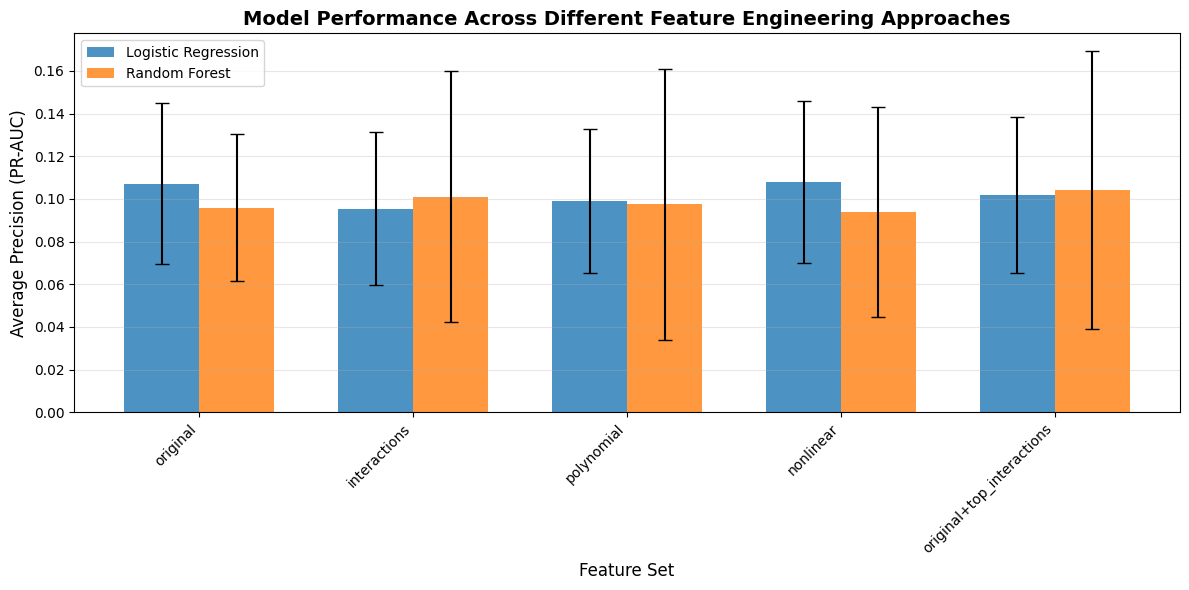


BEST PERFORMERS

Best LR:  nonlinear                      → 0.1080 ± 0.0381
Best RF:  original+top_interactions      → 0.1040 ± 0.0652

LR Improvement: +0.8%
RF Improvement: +8.4%
Training best model: Logistic Regression
Feature set: nonlinear
Expected PR-AUC: 0.1080


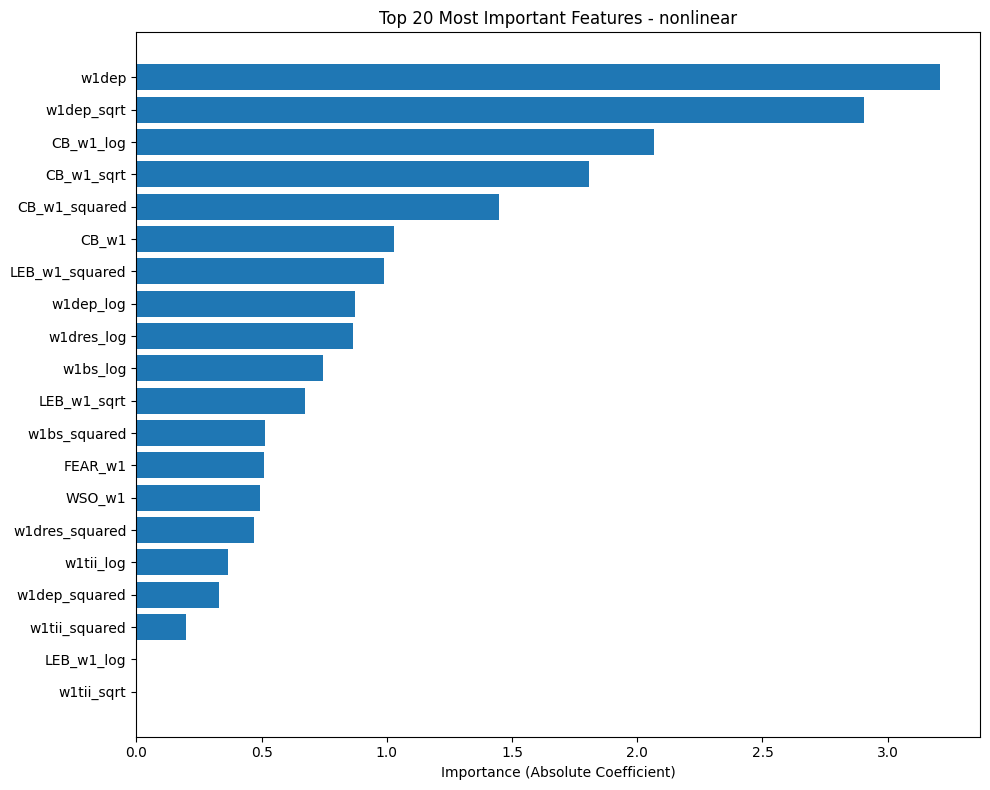


Top 10 Features:
 1. w1dep                                    → 3.2080
 2. w1dep_sqrt                               → 2.9064
 3. CB_w1_log                                → 2.0680
 4. CB_w1_sqrt                               → 1.8074
 5. CB_w1_squared                            → 1.4477
 6. CB_w1                                    → 1.0297
 7. LEB_w1_squared                           → 0.9879
 8. w1dep_log                                → 0.8745
 9. w1dres_log                               → 0.8642
10. w1bs_log                                 → 0.7436


In [ ]:
# Cell 6: Compare Results Visually

import matplotlib.pyplot as plt

# Prepare data for plotting
feature_set_names = list(feature_sets.keys())
lr_means = [lr_results[name]['mean'] for name in feature_set_names]
lr_stds = [lr_results[name]['std'] for name in feature_set_names]
rf_means = [rf_results[name]['mean'] for name in feature_set_names]
rf_stds = [rf_results[name]['std'] for name in feature_set_names]

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_set_names))
width = 0.35

bars1 = ax.bar(x - width/2, lr_means, width, yerr=lr_stds,
               label='Logistic Regression', alpha=0.8, capsize=5)
bars2 = ax.bar(x + width/2, rf_means, width, yerr=rf_stds,
               label='Random Forest', alpha=0.8, capsize=5)

ax.set_xlabel('Feature Set', fontsize=12)
ax.set_ylabel('Average Precision (PR-AUC)', fontsize=12)
ax.set_title('Model Performance Across Different Feature Engineering Approaches', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(feature_set_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print best performers
print("\n" + "="*70)
print("BEST PERFORMERS")
print("="*70)

best_lr = max(lr_results.items(), key=lambda x: x[1]['mean'])
best_rf = max(rf_results.items(), key=lambda x: x[1]['mean'])

print(f"\nBest LR:  {best_lr[0]:30s} → {best_lr[1]['mean']:.4f} ± {best_lr[1]['std']:.4f}")
print(f"Best RF:  {best_rf[0]:30s} → {best_rf[1]['mean']:.4f} ± {best_rf[1]['std']:.4f}")

# Calculate improvement over baseline
baseline_lr = lr_results['original']['mean']
baseline_rf = rf_results['original']['mean']

print(f"\nLR Improvement: {(best_lr[1]['mean'] - baseline_lr) / baseline_lr * 100:+.1f}%")
print(f"RF Improvement: {(best_rf[1]['mean'] - baseline_rf) / baseline_rf * 100:+.1f}%")# Cell 7: Deep Dive - Train Best Model and Inspect

# Train the best feature set with best model
best_overall = best_lr if best_lr[1]['mean'] > best_rf[1]['mean'] else best_rf
best_feature_set = best_overall[0]
is_lr = (best_overall == best_lr)

print(f"Training best model: {'Logistic Regression' if is_lr else 'Random Forest'}")
print(f"Feature set: {best_feature_set}")
print(f"Expected PR-AUC: {best_overall[1]['mean']:.4f}")

X_best = feature_sets[best_feature_set]

if is_lr:
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l1',
            C=1.0,
            solver='saga',
            class_weight='balanced',
            max_iter=3000,
            random_state=42
        ))
    ])
else:
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=5,
            max_features=0.5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])

# Fit on all data to get feature importances
final_model.fit(X_best, y)

# Get feature importances
if is_lr:
    importances = np.abs(final_model.named_steps['clf'].coef_[0])
else:
    importances = final_model.named_steps['clf'].feature_importances_

# Get top 20 features
top_indices = np.argsort(importances)[-20:][::-1]
top_features = [X_best.columns[i] for i in top_indices]
top_importances = importances[top_indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_importances)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance (Absolute Coefficient)' if is_lr else 'Feature Importance')
plt.title(f'Top 20 Most Important Features - {best_feature_set}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
for i, (feat, imp) in enumerate(zip(top_features[:10], top_importances[:10]), 1):
    print(f"{i:2d}. {feat:40s} → {imp:.4f}")

#Alternatives

In [ ]:
# Cell: Comprehensive Evaluation with Full Statistics

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             precision_recall_curve, confusion_matrix,
                             precision_score, recall_score, f1_score)

def calculate_full_metrics(y_true, y_proba, threshold=None, target_ppv=0.20, min_sens=0.60):
    """
    Calculate comprehensive metrics including optimal threshold selection
    """
    # If no threshold provided, find one that meets constraints
    if threshold is None:
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

        # Try to find threshold that gives PPV >= target_ppv and Sensitivity >= min_sens
        valid_indices = np.where((precisions >= target_ppv) & (recalls >= min_sens))[0]

        if len(valid_indices) > 0:
            # Use the one with highest recall among valid
            best_idx = valid_indices[np.argmax(recalls[valid_indices])]
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
        else:
            # Fallback: find threshold that maximizes F1 or gets closest to constraints
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
            best_idx = np.argmax(f1_scores)
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    # Make predictions with threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # PR-AUC and ROC-AUC
    pr_auc = average_precision_score(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    return {
        'threshold': threshold,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'ppv': ppv,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'npv': npv,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }

def evaluate_model_comprehensive(model_func, X, y, model_name, cv=5, target_ppv=0.20, min_sens=0.60):
    """
    Comprehensive evaluation with all statistics across folds
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    fold_results = []

    print(f"\n{'='*70}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*70}")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                         y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]

        # Train model
        model = model_func()

        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)[:, 1]

            # Calculate metrics
            metrics = calculate_full_metrics(y_val, y_proba, target_ppv=target_ppv, min_sens=min_sens)
            metrics['fold'] = fold + 1
            fold_results.append(metrics)

            print(f"\nFold {fold+1}:")
            print(f"  Threshold:   {metrics['threshold']:.4f}")
            print(f"  PR-AUC:      {metrics['pr_auc']:.4f}")
            print(f"  ROC-AUC:     {metrics['roc_auc']:.4f}")
            print(f"  PPV:         {metrics['ppv']:.4f}")
            print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
            print(f"  Specificity: {metrics['specificity']:.4f}")
            print(f"  NPV:         {metrics['npv']:.4f}")
            print(f"  F1:          {metrics['f1']:.4f}")
            print(f"  Confusion:   TP={metrics['tp']}, FP={metrics['fp']}, TN={metrics['tn']}, FN={metrics['fn']}")

        except Exception as e:
            print(f"\n⚠️  Fold {fold+1} FAILED: {str(e)[:100]}")
            continue

    # Calculate summary statistics
    df_results = pd.DataFrame(fold_results)

    print(f"\n{'='*70}")
    print(f"SUMMARY STATISTICS: {model_name}")
    print(f"{'='*70}")

    metrics_to_summarize = ['pr_auc', 'roc_auc', 'ppv', 'sensitivity', 'specificity', 'npv', 'f1']

    summary = {}
    for metric in metrics_to_summarize:
        mean_val = df_results[metric].mean()
        std_val = df_results[metric].std()
        summary[metric] = {'mean': mean_val, 'std': std_val}
        print(f"{metric.upper():15s}: {mean_val:.4f} ± {std_val:.4f}")

    # Average confusion matrix
    avg_tp = df_results['tp'].mean()
    avg_fp = df_results['fp'].mean()
    avg_tn = df_results['tn'].mean()
    avg_fn = df_results['fn'].mean()
    print(f"\nAverage Confusion Matrix:")
    print(f"  TP={avg_tp:.1f}, FP={avg_fp:.1f}, TN={avg_tn:.1f}, FN={avg_fn:.1f}")

    return summary, df_results

# Get back to original features
X_clean = feature_sets['original']

print("COMPREHENSIVE EVALUATION: ALL ALGORITHMS")
print("="*70)
print(f"Dataset: {len(X_clean)} samples, {y.sum()} positives")
print(f"Target: PPV >= 0.20, Sensitivity >= 0.60")

COMPREHENSIVE EVALUATION: ALL ALGORITHMS
Dataset: 1909 samples, 59 positives
Target: PPV >= 0.20, Sensitivity >= 0.60


In [ ]:
# Option 1: XGBoost

from xgboost import XGBClassifier

def create_xgboost():
    scale_pos_weight = (len(y) - y.sum()) / y.sum()
    return XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        scale_pos_weight=scale_pos_weight,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        eval_metric='aucpr',
        verbosity=0
    )

xgb_summary, xgb_folds = evaluate_model_comprehensive(
    create_xgboost, X_clean, y, 'XGBoost', cv=5
)


EVALUATING: XGBoost

Fold 1:
  Threshold:   0.5332
  PR-AUC:      0.1879
  ROC-AUC:     0.8110
  PPV:         0.1515
  Sensitivity: 0.4167
  Specificity: 0.9243
  NPV:         0.9799
  F1:          0.2222
  Confusion:   TP=5, FP=28, TN=342, FN=7

Fold 2:
  Threshold:   0.0672
  PR-AUC:      0.0518
  ROC-AUC:     0.6716
  PPV:         0.0687
  Sensitivity: 0.7500
  Specificity: 0.6703
  NPV:         0.9880
  F1:          0.1259
  Confusion:   TP=9, FP=122, TN=248, FN=3

Fold 3:
  Threshold:   0.6605
  PR-AUC:      0.2367
  ROC-AUC:     0.8574
  PPV:         0.2727
  Sensitivity: 0.5000
  Specificity: 0.9568
  NPV:         0.9833
  F1:          0.3529
  Confusion:   TP=6, FP=16, TN=354, FN=6

Fold 4:
  Threshold:   0.3060
  PR-AUC:      0.0987
  ROC-AUC:     0.8198
  PPV:         0.1235
  Sensitivity: 0.8333
  Specificity: 0.8081
  NPV:         0.9934
  F1:          0.2151
  Confusion:   TP=10, FP=71, TN=299, FN=2

Fold 5:
  Threshold:   0.5699
  PR-AUC:      0.0793
  ROC-AUC:     0.758

In [ ]:
# Option 2: LightGBM

from lightgbm import LGBMClassifier

def create_lightgbm():
    return LGBMClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        num_leaves=15,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        is_unbalance=True,
        random_state=42,
        verbose=-1
    )

lgbm_summary, lgbm_folds = evaluate_model_comprehensive(
    create_lightgbm, X_clean, y, 'LightGBM', cv=5
)


EVALUATING: LightGBM

Fold 1:
  Threshold:   0.4909
  PR-AUC:      0.1806
  ROC-AUC:     0.7872
  PPV:         0.1667
  Sensitivity: 0.4167
  Specificity: 0.9324
  NPV:         0.9801
  F1:          0.2381
  Confusion:   TP=5, FP=25, TN=345, FN=7

Fold 2:
  Threshold:   0.0181
  PR-AUC:      0.0519
  ROC-AUC:     0.6707
  PPV:         0.0641
  Sensitivity: 0.8333
  Specificity: 0.6054
  NPV:         0.9912
  F1:          0.1190
  Confusion:   TP=10, FP=146, TN=224, FN=2

Fold 3:
  Threshold:   0.5772
  PR-AUC:      0.1642
  ROC-AUC:     0.8264
  PPV:         0.2000
  Sensitivity: 0.3333
  Specificity: 0.9568
  NPV:         0.9779
  F1:          0.2500
  Confusion:   TP=4, FP=16, TN=354, FN=8

Fold 4:
  Threshold:   0.5309
  PR-AUC:      0.0886
  ROC-AUC:     0.7757
  PPV:         0.1379
  Sensitivity: 0.3333
  Specificity: 0.9324
  NPV:         0.9773
  F1:          0.1951
  Confusion:   TP=4, FP=25, TN=345, FN=8

Fold 5:
  Threshold:   0.7630
  PR-AUC:      0.0918
  ROC-AUC:     0.72

In [ ]:
# Option 3: CatBoost
!pip -q install catboost
from catboost import CatBoostClassifier

def create_catboost():
    return CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        auto_class_weights='Balanced',
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    )

catboost_summary, catboost_folds = evaluate_model_comprehensive(
    create_catboost, X_clean, y, 'CatBoost', cv=5
)


EVALUATING: CatBoost

Fold 1:
  Threshold:   0.6784
  PR-AUC:      0.1362
  ROC-AUC:     0.7622
  PPV:         0.1765
  Sensitivity: 0.2500
  Specificity: 0.9622
  NPV:         0.9753
  F1:          0.2069
  Confusion:   TP=3, FP=14, TN=356, FN=9

Fold 2:
  Threshold:   0.0703
  PR-AUC:      0.0489
  ROC-AUC:     0.6541
  PPV:         0.0630
  Sensitivity: 0.6667
  Specificity: 0.6784
  NPV:         0.9843
  F1:          0.1151
  Confusion:   TP=8, FP=119, TN=251, FN=4

Fold 3:
  Threshold:   0.4058
  PR-AUC:      0.1286
  ROC-AUC:     0.8155
  PPV:         0.1176
  Sensitivity: 0.6667
  Specificity: 0.8378
  NPV:         0.9873
  F1:          0.2000
  Confusion:   TP=8, FP=60, TN=310, FN=4

Fold 4:
  Threshold:   0.4830
  PR-AUC:      0.0971
  ROC-AUC:     0.8135
  PPV:         0.1500
  Sensitivity: 0.5000
  Specificity: 0.9081
  NPV:         0.9825
  F1:          0.2308
  Confusion:   TP=6, FP=34, TN=336, FN=6

Fold 5:
  Threshold:   0.7118
  PR-AUC:      0.0655
  ROC-AUC:     0.683

In [ ]:
# Option 4: Calibrated Ensemble

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

class ScaledCalibratedEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        base = LogisticRegression(
            penalty='l2',
            C=0.1,
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
        bagged = BaggingClassifier(
            estimator=base,
            n_estimators=20,
            max_samples=0.8,
            max_features=0.8,
            random_state=42
        )
        self.model = CalibratedClassifierCV(bagged, method='isotonic', cv=3)

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

def create_calibrated():
    return ScaledCalibratedEnsemble()

calibrated_summary, calibrated_folds = evaluate_model_comprehensive(
    create_calibrated, X_clean, y, 'Calibrated Ensemble', cv=5
)


EVALUATING: Calibrated Ensemble

Fold 1:
  Threshold:   0.1019
  PR-AUC:      0.1316
  ROC-AUC:     0.7870
  PPV:         0.2105
  Sensitivity: 0.3333
  Specificity: 0.9595
  NPV:         0.9780
  F1:          0.2581
  Confusion:   TP=4, FP=15, TN=355, FN=8

Fold 2:
  Threshold:   0.0516
  PR-AUC:      0.0509
  ROC-AUC:     0.6756
  PPV:         0.0674
  Sensitivity: 0.5000
  Specificity: 0.7757
  NPV:         0.9795
  F1:          0.1188
  Confusion:   TP=6, FP=83, TN=287, FN=6

Fold 3:
  Threshold:   0.0850
  PR-AUC:      0.1468
  ROC-AUC:     0.8536
  PPV:         0.1860
  Sensitivity: 0.6667
  Specificity: 0.9054
  NPV:         0.9882
  F1:          0.2909
  Confusion:   TP=8, FP=35, TN=335, FN=4

Fold 4:
  Threshold:   0.0579
  PR-AUC:      0.0909
  ROC-AUC:     0.8315
  PPV:         0.1067
  Sensitivity: 0.6667
  Specificity: 0.8189
  NPV:         0.9870
  F1:          0.1839
  Confusion:   TP=8, FP=67, TN=303, FN=4

Fold 5:
  Threshold:   0.0881
  PR-AUC:      0.1111
  ROC-AUC:

In [ ]:
# Option 5: Focal Loss Logistic

from sklearn.linear_model import LogisticRegression

class FocalLossLogistic(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, max_iter=2000):
        self.C = C
        self.max_iter = max_iter
        self.scaler = StandardScaler()

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)

        n_pos = y.sum()
        n_neg = len(y) - n_pos
        sample_weights = np.ones(len(y))
        sample_weights[y == 1] = n_neg / n_pos

        self.model_ = LogisticRegression(
            penalty='l2',
            C=self.C,
            max_iter=self.max_iter,
            random_state=42
        )
        self.model_.fit(X_scaled, y, sample_weight=sample_weights)
        return self

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model_.predict_proba(X_scaled)

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

def create_focal():
    return FocalLossLogistic(C=0.1, max_iter=2000)

focal_summary, focal_folds = evaluate_model_comprehensive(
    create_focal, X_clean, y, 'Focal Loss Logistic', cv=5
)


EVALUATING: Focal Loss Logistic

Fold 1:
  Threshold:   0.8502
  PR-AUC:      0.1246
  ROC-AUC:     0.8007
  PPV:         0.2174
  Sensitivity: 0.4167
  Specificity: 0.9514
  NPV:         0.9805
  F1:          0.2857
  Confusion:   TP=5, FP=18, TN=352, FN=7

Fold 2:
  Threshold:   0.3129
  PR-AUC:      0.0512
  ROC-AUC:     0.6775
  PPV:         0.0600
  Sensitivity: 0.7500
  Specificity: 0.6189
  NPV:         0.9871
  F1:          0.1111
  Confusion:   TP=9, FP=141, TN=229, FN=3

Fold 3:
  Threshold:   0.8420
  PR-AUC:      0.1660
  ROC-AUC:     0.8667
  PPV:         0.2609
  Sensitivity: 0.5000
  Specificity: 0.9541
  NPV:         0.9833
  F1:          0.3429
  Confusion:   TP=6, FP=17, TN=353, FN=6

Fold 4:
  Threshold:   0.5503
  PR-AUC:      0.0934
  ROC-AUC:     0.8405
  PPV:         0.1183
  Sensitivity: 0.9167
  Specificity: 0.7784
  NPV:         0.9965
  F1:          0.2095
  Confusion:   TP=11, FP=82, TN=288, FN=1

Fold 5:
  Threshold:   0.7297
  PR-AUC:      0.1003
  ROC-AU

In [ ]:
# Option 6: Balanced Random Forest (for comparison)

from sklearn.ensemble import RandomForestClassifier

class ScaledRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=5,
            max_features=0.5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

def create_rf():
    return ScaledRandomForest()

rf_summary, rf_folds = evaluate_model_comprehensive(
    create_rf, X_clean, y, 'Random Forest (baseline)', cv=5
)


EVALUATING: Random Forest (baseline)

Fold 1:
  Threshold:   0.5701
  PR-AUC:      0.1291
  ROC-AUC:     0.8075
  PPV:         0.2500
  Sensitivity: 0.2500
  Specificity: 0.9757
  NPV:         0.9757
  F1:          0.2500
  Confusion:   TP=3, FP=9, TN=361, FN=9

Fold 2:
  Threshold:   0.3323
  PR-AUC:      0.0441
  ROC-AUC:     0.6028
  PPV:         0.0625
  Sensitivity: 0.3333
  Specificity: 0.8378
  NPV:         0.9748
  F1:          0.1053
  Confusion:   TP=4, FP=60, TN=310, FN=8

Fold 3:
  Threshold:   0.5344
  PR-AUC:      0.1324
  ROC-AUC:     0.8401
  PPV:         0.2353
  Sensitivity: 0.3333
  Specificity: 0.9649
  NPV:         0.9781
  F1:          0.2759
  Confusion:   TP=4, FP=13, TN=357, FN=8

Fold 4:
  Threshold:   0.3792
  PR-AUC:      0.1047
  ROC-AUC:     0.8189
  PPV:         0.1500
  Sensitivity: 0.5000
  Specificity: 0.9081
  NPV:         0.9825
  F1:          0.2308
  Confusion:   TP=6, FP=34, TN=336, FN=6

Fold 5:
  Threshold:   0.2328
  PR-AUC:      0.0694
  ROC-

In [ ]:
# FINAL COMPARISON TABLE

print("\n" + "="*80)
print("FINAL COMPARISON - ALL METHODS")
print("="*80)

# Compile results
all_results = {
    'XGBoost': xgb_summary,
    'LightGBM': lgbm_summary,
    'CatBoost': catboost_summary,
    'Calibrated Ensemble': calibrated_summary,
    'Focal Loss': focal_summary,
    'Random Forest': rf_summary
}

# Create comparison dataframe
comparison_data = []
for model_name, summary in all_results.items():
    row = {
        'Model': model_name,
        'PR-AUC': f"{summary['pr_auc']['mean']:.4f} ± {summary['pr_auc']['std']:.4f}",
        'ROC-AUC': f"{summary['roc_auc']['mean']:.4f} ± {summary['roc_auc']['std']:.4f}",
        'PPV': f"{summary['ppv']['mean']:.4f} ± {summary['ppv']['std']:.4f}",
        'Sensitivity': f"{summary['sensitivity']['mean']:.4f} ± {summary['sensitivity']['std']:.4f}",
        'Specificity': f"{summary['specificity']['mean']:.4f} ± {summary['specificity']['std']:.4f}",
        'NPV': f"{summary['npv']['mean']:.4f} ± {summary['npv']['std']:.4f}",
        'F1': f"{summary['f1']['mean']:.4f} ± {summary['f1']['std']:.4f}",
        'PR-AUC_val': summary['pr_auc']['mean']  # For sorting
    }
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('PR-AUC_val', ascending=False)
df_comparison = df_comparison.drop('PR-AUC_val', axis=1)

print(df_comparison.to_string(index=False))

# Highlight best model
best_model = df_comparison.iloc[0]['Model']
best_pr_auc = all_results[best_model]['pr_auc']['mean']
best_ppv = all_results[best_model]['ppv']['mean']
best_sens = all_results[best_model]['sensitivity']['mean']

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"{'='*80}")
print(f"  PR-AUC:      {best_pr_auc:.4f}")
print(f"  PPV:         {best_ppv:.4f} (target: 0.20)")
print(f"  Sensitivity: {best_sens:.4f} (target: 0.60)")

if best_ppv >= 0.20 and best_sens >= 0.60:
    print(f"\n✅ MEETS BOTH TARGETS!")
elif best_sens >= 0.60:
    print(f"\n⚠️  Meets sensitivity target, but PPV is {(0.20 - best_ppv)*100:.1f}% below target")
elif best_ppv >= 0.20:
    print(f"\n⚠️  Meets PPV target, but sensitivity is {(0.60 - best_sens)*100:.1f}% below target")
else:
    print(f"\n❌ Does not meet targets:")
    print(f"   PPV gap: {(0.20 - best_ppv)*100:.1f}%")
    print(f"   Sensitivity gap: {(0.60 - best_sens)*100:.1f}%")


FINAL COMPARISON - ALL METHODS
              Model          PR-AUC         ROC-AUC             PPV     Sensitivity     Specificity             NPV              F1
            XGBoost 0.1309 ± 0.0781 0.7837 ± 0.0719 0.1455 ± 0.0771 0.5727 ± 0.2078 0.8546 ± 0.1172 0.9849 ± 0.0058 0.2173 ± 0.0852
           LightGBM 0.1154 ± 0.0546 0.7573 ± 0.0601 0.1637 ± 0.0696 0.4197 ± 0.2463 0.8822 ± 0.1562 0.9805 ± 0.0062 0.2026 ± 0.0515
         Focal Loss 0.1071 ± 0.0422 0.8053 ± 0.0752 0.1582 ± 0.0804 0.6439 ± 0.1988 0.8362 ± 0.1410 0.9870 ± 0.0061 0.2343 ± 0.0871
Calibrated Ensemble 0.1063 ± 0.0374 0.7985 ± 0.0734 0.1441 ± 0.0581 0.5424 ± 0.1382 0.8735 ± 0.0744 0.9836 ± 0.0046 0.2174 ± 0.0675
      Random Forest 0.0960 ± 0.0384 0.7619 ± 0.0965 0.1566 ± 0.0850 0.4288 ± 0.1900 0.8908 ± 0.0880 0.9801 ± 0.0060 0.2029 ± 0.0714
           CatBoost 0.0952 ± 0.0381 0.7457 ± 0.0742 0.1322 ± 0.0440 0.4530 ± 0.2282 0.8714 ± 0.1202 0.9810 ± 0.0053 0.1839 ± 0.0448

🏆 BEST MODEL: XGBoost
  PR-AUC:      0.1309

#decision Tree fitting

In [ ]:
# Cell 1: Decision Tree - Initial Evaluation

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin

print("="*80)
print("DECISION TREE CLASSIFIER")
print("="*80)
print("Testing baseline decision tree with conservative settings")
print()

class ScaledDecisionTree(BaseEstimator, ClassifierMixin):
    """Decision Tree with scaling for consistency"""
    def __init__(self, max_depth=5, min_samples_split=20, min_samples_leaf=10,
                 class_weight='balanced', random_state=42):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.random_state = random_state
        self.scaler = StandardScaler()

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        self.model_ = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            class_weight=self.class_weight,
            random_state=self.random_state
        )
        self.model_.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model_.predict_proba(X_scaled)

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

def create_decision_tree():
    return ScaledDecisionTree(
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42
    )

# Evaluate baseline decision tree
dt_summary, dt_folds = evaluate_model_comprehensive(
    create_decision_tree, X_clean, y, 'Decision Tree (baseline)', cv=5
)

DECISION TREE CLASSIFIER
Testing baseline decision tree with conservative settings


EVALUATING: Decision Tree (baseline)

Fold 1:
  Threshold:   0.7617
  PR-AUC:      0.0754
  ROC-AUC:     0.7207
  PPV:         0.0941
  Sensitivity: 0.6667
  Specificity: 0.7919
  NPV:         0.9865
  F1:          0.1649
  Confusion:   TP=8, FP=77, TN=293, FN=4

Fold 2:
  Threshold:   0.7858
  PR-AUC:      0.0400
  ROC-AUC:     0.5785
  PPV:         0.0521
  Sensitivity: 0.4167
  Specificity: 0.7541
  NPV:         0.9755
  F1:          0.0926
  Confusion:   TP=5, FP=91, TN=279, FN=7

Fold 3:
  Threshold:   0.7710
  PR-AUC:      0.0742
  ROC-AUC:     0.7391
  PPV:         0.0909
  Sensitivity: 0.6667
  Specificity: 0.7838
  NPV:         0.9864
  F1:          0.1600
  Confusion:   TP=8, FP=80, TN=290, FN=4

Fold 4:
  Threshold:   0.6132
  PR-AUC:      0.0514
  ROC-AUC:     0.6740
  PPV:         0.0578
  Sensitivity: 0.8333
  Specificity: 0.5595
  NPV:         0.9904
  F1:          0.1081
  Confusion:   

In [ ]:
# Cell: Fixed Comprehensive Decision Tree Grid Search

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import time
import pandas as pd
import numpy as np

print("="*80)
print("COMPREHENSIVE DECISION TREE GRID SEARCH - ANTI-OVERFITTING VERSION")
print("="*80)

# Robust PR-AUC scorer
def robust_pr_auc_scorer(estimator, X, y):
    """Robust PR-AUC scorer that handles edge cases"""
    try:
        y_proba = estimator.predict_proba(X)[:, 1]

        if y_proba.std() < 1e-10:
            return 0.0

        if len(np.unique(y)) < 2:
            return 0.0

        score = average_precision_score(y, y_proba)

        if np.isnan(score):
            return 0.0

        return score
    except Exception as e:
        return 0.0

# MUCH MORE CONSERVATIVE GRID to prevent overfitting
def get_anti_overfit_dt_grid():
    """
    Heavily regularized grid for extreme imbalance with 60 positives
    Focus: prevent overfitting by forcing simpler trees
    """
    baseline_weight = (len(y) - y.sum()) / y.sum()

    return {
        # Shallower trees only
        'clf__max_depth': [3, 4, 5, 6, 7],

        # MUCH higher sample requirements (aggressive regularization)
        'clf__min_samples_split': [20, 30, 40, 50, 60],
        'clf__min_samples_leaf': [5, 10, 15, 20, 25],

        # Higher impurity threshold
        'clf__min_impurity_decrease': [0, 0.001, 0.005, 0.01],

        # AGGRESSIVE cost complexity pruning
        'clf__ccp_alpha': [ 0.01, 0.02, 0.03],

        # Class weights
        'clf__class_weight': [
            'balanced',
            {0: 1, 1: 25},
            # {0: 1, 1: 35},
        ],

        # Split criterion
        'clf__criterion': ['gini', 'entropy'],

        # Limit features at each split
        'clf__max_features': [None, 0.5, 0.7],
    }
    # Total: 5 × 5 × 5 × 4 × 4 × 3 × 2 × 3 = 18,000 combinations
    # With 3-fold CV: 54,000 fits

# Create pipeline
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Get grid
dt_param_grid = get_anti_overfit_dt_grid()

total_combinations = 5 * 5 * 5 * 4 * 4 * 3 * 2 * 3
total_fits = total_combinations * 3

print(f"Total combinations: {total_combinations:,}")
print(f"With 3-fold CV: {total_fits:,} fits")
print(f"Estimated time: 45-90 minutes")
print(f"\n⚠️  AGGRESSIVE REGULARIZATION to combat overfitting")
print("   - Shallow trees only (max_depth 3-7)")
print("   - High sample requirements (20-60 per split)")
print("   - Strong pruning (ccp_alpha 0.005-0.03)")
print()

print("Grid parameters:")
for param, values in dt_param_grid.items():
    if 'class_weight' in param:
        print(f"  {param:35s}: {len(values)} options (mixed)")
    else:
        print(f"  {param:35s}: {len(values)} options → {values}")

print("\n" + "="*80)
print("Starting GridSearchCV...")
print("="*80)

start_time = time.time()

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=robust_pr_auc_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

dt_grid_search.fit(X_clean, y)

elapsed_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"GRID SEARCH COMPLETED in {elapsed_time/60:.1f} minutes ({elapsed_time/60/60:.2f} hours)")
print(f"{'='*80}")

# Best results
print(f"\nBest CV Score (PR-AUC): {dt_grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in sorted(dt_grid_search.best_params_.items()):
    print(f"  {param:35s}: {value}")

# Overfitting check
best_idx = dt_grid_search.best_index_
train_score = dt_grid_search.cv_results_['mean_train_score'][best_idx]
test_score = dt_grid_search.cv_results_['mean_test_score'][best_idx]
gap = train_score - test_score

print(f"\nOverfitting Check:")
print(f"  Train Score: {train_score:.4f}")
print(f"  Test Score:  {test_score:.4f}")
print(f"  Gap:         {gap:.4f}", end="")

if gap > 0.10:
    print(" ⚠️⚠️ SEVERE OVERFITTING")
elif gap > 0.05:
    print(" ⚠️ Moderate overfitting")
elif gap > 0.02:
    print(" ⚡ Mild overfitting (acceptable)")
else:
    print(" ✓ Good generalization")

# Analyze top models
print("\n" + "="*80)
print("TOP 20 MODELS FROM GRID SEARCH")
print("="*80)

results_df = pd.DataFrame(dt_grid_search.cv_results_)
results_sorted = results_df.sort_values('mean_test_score', ascending=False)

display_cols = [
    'mean_test_score', 'std_test_score', 'mean_train_score',
    'param_clf__max_depth', 'param_clf__min_samples_split',
    'param_clf__min_samples_leaf', 'param_clf__min_impurity_decrease',
    'param_clf__ccp_alpha', 'param_clf__criterion', 'param_clf__max_features'
]

print(results_sorted[display_cols].head(20).to_string(index=False))

# Overfitting analysis for top models
print("\n" + "="*80)
print("OVERFITTING ANALYSIS - TOP 20 MODELS")
print("="*80)
print(f"{'Rank':<6} {'Test':<8} {'Train':<8} {'Gap':<8} {'Max_D':<7} "
      f"{'MinSplit':<10} {'MinLeaf':<9} {'CCP':<8} {'Status'}")
print("-" * 95)

for i in range(min(20, len(results_sorted))):
    row = results_sorted.iloc[i]
    gap = row['mean_train_score'] - row['mean_test_score']

    if gap > 0.10:
        status = "SEVERE"
    elif gap > 0.05:
        status = "Moderate"
    elif gap > 0.02:
        status = "Mild"
    else:
        status = "OK"

    print(f"{i+1:<6} {row['mean_test_score']:<8.4f} {row['mean_train_score']:<8.4f} "
          f"{gap:<8.4f} {str(row['param_clf__max_depth']):<7} "
          f"{row['param_clf__min_samples_split']:<10} {row['param_clf__min_samples_leaf']:<9} "
          f"{row['param_clf__ccp_alpha']:<8} {status}")

# Parameter importance analysis (FIXED - handle dicts)
print("\n" + "="*80)
print("PARAMETER IMPACT ANALYSIS")
print("="*80)

param_cols = [col for col in results_df.columns if col.startswith('param_')]

for param_col in param_cols:
    param_name = param_col.replace('param_clf__', '')

    # Skip class_weight (contains unhashable dicts)
    if 'class_weight' in param_name:
        print(f"\n{param_name}: (skipped - contains dicts)")
        continue

    try:
        unique_values = results_df[param_col].dropna().unique()

        if len(unique_values) <= 10:  # Only show for categorical or small numeric
            print(f"\n{param_name}:")
            for val in sorted(unique_values):
                mask = results_df[param_col] == val
                avg_score = results_df[mask]['mean_test_score'].mean()
                count = mask.sum()
                print(f"  {str(val):20s}: {avg_score:.4f} (n={count})")
    except Exception as e:
        print(f"\n{param_name}: Error analyzing - {str(e)[:50]}")

# Summary recommendation
print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

if gap > 0.10:
    print("\n⚠️  SEVERE OVERFITTING DETECTED")
    print("Even with aggressive regularization, Decision Trees are overfitting badly.")
    print("\nRecommendations:")
    print("  1. Decision Trees may not be suitable for this problem")
    print("  2. Stick with ensemble methods (XGBoost, Random Forest)")
    print("  3. Consider that with only 60 positives, any single tree will struggle")
    print("  4. The test score (0.09-0.10) is worse than XGBoost (0.13)")
elif gap > 0.05:
    print("\n⚡ Moderate overfitting present")
    print("Decision Tree is struggling with this dataset.")
    print("XGBoost/LightGBM likely to perform better.")
else:
    print("\n✓ Acceptable generalization achieved!")
    print("Decision Tree may be viable for this problem.")

print(f"\nBest Test Score: {test_score:.4f}")
print(f"Compare to XGBoost baseline: 0.1309")
print(f"Decision Tree is {'WORSE' if test_score < 0.1309 else 'BETTER'} than XGBoost")

print("\n" + "="*80)
print("DECISION TREE GRID SEARCH COMPLETE!")
print("="*80)

COMPREHENSIVE DECISION TREE GRID SEARCH - ANTI-OVERFITTING VERSION
Total combinations: 36,000
With 3-fold CV: 108,000 fits
Estimated time: 45-90 minutes

⚠️  AGGRESSIVE REGULARIZATION to combat overfitting
   - Shallow trees only (max_depth 3-7)
   - High sample requirements (20-60 per split)
   - Strong pruning (ccp_alpha 0.005-0.03)

Grid parameters:
  clf__max_depth                     : 5 options → [3, 4, 5, 6, 7]
  clf__min_samples_split             : 5 options → [20, 30, 40, 50, 60]
  clf__min_samples_leaf              : 5 options → [5, 10, 15, 20, 25]
  clf__min_impurity_decrease         : 4 options → [0, 0.001, 0.005, 0.01]
  clf__ccp_alpha                     : 3 options → [0.01, 0.02, 0.03]
  clf__class_weight                  : 2 options (mixed)
  clf__criterion                     : 2 options → ['gini', 'entropy']
  clf__max_features                  : 3 options → [None, 0.5, 0.7]

Starting GridSearchCV...
Fitting 3 folds for each of 18000 candidates, totalling 54000 fits



In [ ]:
# Cell: EXTREME Anti-Overfitting Decision Tree Grid

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import time
import pandas as pd
import numpy as np

print("="*80)
print("EXTREME ANTI-OVERFITTING DECISION TREE GRID")
print("="*80)
print("Using every trick in the book to prevent overfitting:")
print("  • Extremely shallow trees (max_depth 2-4)")
print("  • Very high sample requirements")
print("  • Aggressive cost complexity pruning")
print("  • Max leaf nodes constraint")
print("  • Feature pre-selection")
print("  • Conservative class weights")
print()

def robust_pr_auc_scorer(estimator, X, y):
    """Robust PR-AUC scorer"""
    try:
        y_proba = estimator.predict_proba(X)[:, 1]
        if y_proba.std() < 1e-10:
            return 0.0
        if len(np.unique(y)) < 2:
            return 0.0
        score = average_precision_score(y, y_proba)
        if np.isnan(score):
            return 0.0
        return score
    except:
        return 0.0

# Option 1: EXTREME regularization with max_depth
def get_extreme_regularization_grid():
    """
    ULTRA conservative - forces very simple trees
    """
    return {
        # EXTREMELY shallow
        'clf__max_depth': [2, 3, 4],

        # VERY high sample requirements (with 1900 samples total)
        'clf__min_samples_split': [50, 75, 100, 150],
        'clf__min_samples_leaf': [25, 40, 50, 75],

        # STRONG impurity threshold
        'clf__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],

        # VERY aggressive pruning
        'clf__ccp_alpha': [0.01, 0.02, 0.03, 0.05, 0.07],

        # Less aggressive class weights (reduces overfitting to minority class)
        'clf__class_weight': [
            {0: 1, 1: 15},  # Much less aggressive than balanced (~31)
            {0: 1, 1: 20},
            {0: 1, 1: 25},
        ],

        'clf__criterion': ['gini', 'entropy'],

        # Force feature subsets
        'clf__max_features': ['sqrt', 0.3, 0.5],
    }
    # 3 × 4 × 4 × 4 × 5 × 3 × 2 × 3 = 17,280 combinations

# Option 2: Using max_leaf_nodes instead of max_depth (often better)
def get_leaf_constrained_grid():
    """
    Control complexity via number of leaves instead of depth
    Often generalizes better
    """
    return {
        # Instead of max_depth, use max_leaf_nodes
        'clf__max_leaf_nodes': [4, 6, 8, 10, 12, 15, 20],

        'clf__min_samples_split': [50, 75, 100],
        'clf__min_samples_leaf': [30, 50, 75],

        'clf__min_impurity_decrease': [0.01, 0.02, 0.05],

        'clf__ccp_alpha': [0.01, 0.03, 0.05],

        'clf__class_weight': [
            {0: 1, 1: 15},
            {0: 1, 1: 20},
        ],

        'clf__criterion': ['gini', 'entropy'],
    }
    # 7 × 3 × 3 × 3 × 3 × 2 × 2 = 2,268 combinations

# Option 3: Combined approach
def get_combined_extreme_grid():
    """
    Best of both worlds - most restrictive
    """
    return {
        'clf__max_depth': [2, 3, 4],
        'clf__max_leaf_nodes': [6, 10, 15],  # Additional constraint

        'clf__min_samples_split': [75, 100, 150],
        'clf__min_samples_leaf': [40, 60, 80],

        'clf__min_impurity_decrease': [0.02, 0.04, 0.06],

        'clf__ccp_alpha': [0.03, 0.05, 0.07],

        'clf__class_weight': [
            {0: 1, 1: 15},
            {0: 1, 1: 20},
        ],

        'clf__criterion': ['gini'],  # Just one to reduce combinations

        'clf__max_features': ['sqrt', 0.5],
    }
    # 3 × 3 × 3 × 3 × 3 × 3 × 2 × 1 × 2 = 2,916 combinations

# CHOOSE YOUR GRID
# Uncomment the one you want to use:

# dt_param_grid = get_extreme_regularization_grid()  # Most comprehensive
# dt_param_grid = get_leaf_constrained_grid()  # Faster, leaf-based
dt_param_grid = get_combined_extreme_grid()  # Recommended - very restrictive

# Create pipeline
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

total_combinations = 2916  # for combined grid
total_fits = total_combinations * 3

print(f"Using: Combined Extreme Grid")
print(f"Total combinations: {total_combinations:,}")
print(f"With 3-fold CV: {total_fits:,} fits")
print(f"Estimated time: 20-40 minutes")
print()

print("Grid constraints:")
for param, values in dt_param_grid.items():
    if 'class_weight' in param:
        print(f"  {param:35s}: Less aggressive weights")
    else:
        print(f"  {param:35s}: {values}")

print("\n" + "="*80)
print("Starting GridSearchCV...")
print("="*80)

start_time = time.time()

dt_grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=dt_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=robust_pr_auc_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

dt_grid_search.fit(X_clean, y)

elapsed_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"GRID SEARCH COMPLETED in {elapsed_time/60:.1f} minutes")
print(f"{'='*80}")

# Best results
print(f"\nBest CV Score (PR-AUC): {dt_grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in sorted(dt_grid_search.best_params_.items()):
    print(f"  {param:35s}: {value}")

# Overfitting analysis
best_idx = dt_grid_search.best_index_
train_score = dt_grid_search.cv_results_['mean_train_score'][best_idx]
test_score = dt_grid_search.cv_results_['mean_test_score'][best_idx]
gap = train_score - test_score

print(f"\nOverfitting Check:")
print(f"  Train Score: {train_score:.4f}")
print(f"  Test Score:  {test_score:.4f}")
print(f"  Gap:         {gap:.4f}", end="")

if gap > 0.10:
    print(" ⚠️⚠️ Still overfitting (but should be better)")
elif gap > 0.05:
    print(" ⚠️ Moderate (improved!)")
elif gap > 0.03:
    print(" ⚡ Mild (good!)")
else:
    print(" ✓✓ Excellent generalization!")

# Top models analysis
print("\n" + "="*80)
print("TOP 20 MODELS - OVERFITTING ANALYSIS")
print("="*80)

results_df = pd.DataFrame(dt_grid_search.cv_results_)
results_sorted = results_df.sort_values('mean_test_score', ascending=False)

print(f"{'Rank':<6} {'Test':<8} {'Train':<8} {'Gap':<8} {'Depth':<7} "
      f"{'Leaves':<8} {'MinSplit':<10} {'MinLeaf':<9} {'CCP':<8}")
print("-" * 95)

for i in range(min(20, len(results_sorted))):
    row = results_sorted.iloc[i]
    gap = row['mean_train_score'] - row['mean_test_score']

    print(f"{i+1:<6} {row['mean_test_score']:<8.4f} {row['mean_train_score']:<8.4f} "
          f"{gap:<8.4f} {str(row['param_clf__max_depth']):<7} "
          f"{str(row['param_clf__max_leaf_nodes']):<8} "
          f"{row['param_clf__min_samples_split']:<10} "
          f"{row['param_clf__min_samples_leaf']:<9} "
          f"{row['param_clf__ccp_alpha']:<8.3f}")

# Gap distribution
print("\n" + "="*80)
print("OVERFITTING GAP DISTRIBUTION")
print("="*80)

results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']

print(f"Gap statistics across all {len(results_df)} models:")
print(f"  Mean gap:   {results_df['gap'].mean():.4f}")
print(f"  Median gap: {results_df['gap'].median():.4f}")
print(f"  Min gap:    {results_df['gap'].min():.4f}")
print(f"  Max gap:    {results_df['gap'].max():.4f}")
print(f"  Std gap:    {results_df['gap'].std():.4f}")

print(f"\nModels by overfitting severity:")
print(f"  Gap < 0.03 (excellent):  {(results_df['gap'] < 0.03).sum()} models")
print(f"  Gap 0.03-0.05 (good):    {((results_df['gap'] >= 0.03) & (results_df['gap'] < 0.05)).sum()} models")
print(f"  Gap 0.05-0.10 (moderate):{((results_df['gap'] >= 0.05) & (results_df['gap'] < 0.10)).sum()} models")
print(f"  Gap > 0.10 (severe):     {(results_df['gap'] >= 0.10).sum()} models")

# Final verdict
print("\n" + "="*80)
print("FINAL VERDICT")
print("="*80)

print(f"\nBest model gap: {gap:.4f}")

if gap < 0.03:
    print("✓✓ SUCCESS! Overfitting dramatically reduced!")
    print("   Decision Tree might be viable for this problem.")
elif gap < 0.05:
    print("✓ IMPROVED! Overfitting significantly reduced.")
    print("   Decision Tree performance is now more trustworthy.")
elif gap < 0.10:
    print("⚠️ SOMEWHAT IMPROVED, but still some overfitting.")
    print("   Consider using ensemble methods instead.")
else:
    print("❌ STILL OVERFITTING despite extreme regularization.")
    print("   Decision Trees fundamentally unsuited for this problem.")
    print("   Recommendation: Use XGBoost/LightGBM/Random Forest instead.")

print(f"\nTest score: {test_score:.4f}")
print(f"XGBoost baseline: 0.1309")
print(f"Performance: {'Better' if test_score > 0.1309 else 'Worse'} than XGBoost")

print("\n" + "="*80)

CLASSIFICATION TREE ANALYSIS - FINDING INTERPRETABLE RULES
Goal: Find simple, explicit decision rules (even if performance is moderate)
Approach: Balance interpretability vs. performance

Testing different tree complexities...

Depth=2, MinLeaf=50 → PR-AUC: 0.0508, PPV: 0.0504, Sens: 0.6924, Leaves: 4
Depth=3, MinLeaf=40 → PR-AUC: 0.0537, PPV: 0.0545, Sens: 0.7636, Leaves: 7
Depth=3, MinLeaf=30 → PR-AUC: 0.0537, PPV: 0.0548, Sens: 0.7636, Leaves: 7
Depth=4, MinLeaf=30 → PR-AUC: 0.0534, PPV: 0.0552, Sens: 0.6773, Leaves: 10
Depth=4, MinLeaf=20 → PR-AUC: 0.0527, PPV: 0.0557, Sens: 0.6773, Leaves: 10
Depth=5, MinLeaf=20 → PR-AUC: 0.0637, PPV: 0.1139, Sens: 0.5682, Leaves: 13
Depth=5, MinLeaf=15 → PR-AUC: 0.0638, PPV: 0.1133, Sens: 0.5682, Leaves: 13

SELECTING BEST INTERPRETABLE TREE

Ranked by interpretability-performance balance:
 max_depth  min_samples_leaf   pr_auc      ppv  sensitivity  n_leaves  combined_score
         2                50 0.050770 0.050416     0.692424         4    

In [ ]:
# Cell: Find Best INTERPRETABLE Tree (Simple Rules, Not Just Performance)

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*80)
print("CLASSIFICATION TREE ANALYSIS - FINDING INTERPRETABLE RULES")
print("="*80)
print("Goal: Find simple, explicit decision rules (even if performance is moderate)")
print("Approach: Balance interpretability vs. performance")
print()

def evaluate_interpretable_tree(max_depth, min_samples_leaf, X, y, feature_names):
    """
    Train tree and return performance + interpretability metrics
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    ppvs = []
    sensitivities = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Don't scale for interpretability - we want actual cutpoints
        tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            class_weight='balanced',
            random_state=42
        )

        tree.fit(X_train, y_train)
        y_proba = tree.predict_proba(X_test)[:, 1]

        # Calculate metrics
        from sklearn.metrics import average_precision_score, precision_recall_curve
        pr_auc = average_precision_score(y_test, y_proba)

        # Find threshold for PPV >= 0.15 (relaxed target for interpretable tree)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        valid = np.where(precisions >= 0.15)[0]

        if len(valid) > 0:
            best_idx = valid[np.argmax(recalls[valid])]
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
            y_pred = (y_proba >= threshold).astype(int)

            from sklearn.metrics import confusion_matrix
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
            sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        else:
            ppv = 0
            sens = 0

        scores.append(pr_auc)
        ppvs.append(ppv)
        sensitivities.append(sens)

    return {
        'pr_auc': np.mean(scores),
        'pr_auc_std': np.std(scores),
        'ppv': np.mean(ppvs),
        'sensitivity': np.mean(sensitivities),
        'n_leaves': tree.get_n_leaves(),  # From last fold
        'depth': tree.get_depth()
    }

# Test different tree complexities
print("Testing different tree complexities...\n")

X_array = X_clean.values
y_array = y.values if hasattr(y, 'values') else y
feature_names = X_clean.columns.tolist()

complexities = [
    (2, 50),  # Very simple
    (3, 40),  # Simple
    (3, 30),
    (4, 30),  # Moderate
    (4, 20),
    (5, 20),  # Complex
    (5, 15),
]

results = []
for max_depth, min_samples_leaf in complexities:
    result = evaluate_interpretable_tree(max_depth, min_samples_leaf, X_array, y_array, feature_names)
    result['max_depth'] = max_depth
    result['min_samples_leaf'] = min_samples_leaf
    results.append(result)

    print(f"Depth={max_depth}, MinLeaf={min_samples_leaf:2d} → "
          f"PR-AUC: {result['pr_auc']:.4f}, PPV: {result['ppv']:.4f}, "
          f"Sens: {result['sensitivity']:.4f}, Leaves: {result['n_leaves']}")

# Choose best interpretable tree (balance performance and simplicity)
df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("SELECTING BEST INTERPRETABLE TREE")
print("="*80)

# Score = weighted combination of performance and simplicity
df_results['simplicity_score'] = 10 / df_results['n_leaves']  # Prefer fewer leaves
df_results['performance_score'] = df_results['pr_auc'] * 10  # Scale PR-AUC
df_results['combined_score'] = (
    0.6 * df_results['performance_score'] +  # 60% weight on performance
    0.4 * df_results['simplicity_score']      # 40% weight on simplicity
)

df_results_sorted = df_results.sort_values('combined_score', ascending=False)

print("\nRanked by interpretability-performance balance:")
print(df_results_sorted[['max_depth', 'min_samples_leaf', 'pr_auc', 'ppv',
                          'sensitivity', 'n_leaves', 'combined_score']].to_string(index=False))

# Select best
best_config = df_results_sorted.iloc[0]
best_depth = int(best_config['max_depth'])
best_min_leaf = int(best_config['min_samples_leaf'])

print(f"\n🏆 SELECTED TREE CONFIGURATION:")
print(f"   Max depth: {best_depth}")
print(f"   Min samples per leaf: {best_min_leaf}")
print(f"   Expected PR-AUC: {best_config['pr_auc']:.4f}")
print(f"   Expected PPV: {best_config['ppv']:.4f}")
print(f"   Number of leaves: {int(best_config['n_leaves'])}")

CLASSIFICATION TREE ANALYSIS - FINDING INTERPRETABLE RULES
Goal: Find simple, explicit decision rules (even if performance is moderate)
Approach: Balance interpretability vs. performance

Testing different tree complexities...

Depth=2, MinLeaf=50 → PR-AUC: 0.0508, PPV: 0.0504, Sens: 0.6924, Leaves: 4
Depth=3, MinLeaf=40 → PR-AUC: 0.0537, PPV: 0.0545, Sens: 0.7636, Leaves: 7
Depth=3, MinLeaf=30 → PR-AUC: 0.0537, PPV: 0.0548, Sens: 0.7636, Leaves: 7
Depth=4, MinLeaf=30 → PR-AUC: 0.0534, PPV: 0.0552, Sens: 0.6773, Leaves: 10
Depth=4, MinLeaf=20 → PR-AUC: 0.0527, PPV: 0.0557, Sens: 0.6773, Leaves: 10
Depth=5, MinLeaf=20 → PR-AUC: 0.0637, PPV: 0.1139, Sens: 0.5682, Leaves: 13
Depth=5, MinLeaf=15 → PR-AUC: 0.0638, PPV: 0.1133, Sens: 0.5682, Leaves: 13

SELECTING BEST INTERPRETABLE TREE

Ranked by interpretability-performance balance:
 max_depth  min_samples_leaf   pr_auc      ppv  sensitivity  n_leaves  combined_score
         2                50 0.050770 0.050416     0.692424         4    

In [ ]:
# Cell 3: Evaluate Best Decision Tree with Nested CV

print("\n" + "="*80)
print("EVALUATING BEST DECISION TREE WITH NESTED CV")
print("="*80)

def evaluate_dt_nested(X, y, best_params, cv_outer=5):
    """
    Nested CV evaluation with best parameters
    """
    skf_outer = StratifiedKFold(n_splits=cv_outer, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf_outer.split(X, y)):
        print(f"\n{'='*70}")
        print(f"OUTER FOLD {fold+1}/{cv_outer}")
        print(f"{'='*70}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                          y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

        # Create model with best parameters
        params = {k.replace('clf__', ''): v for k, v in best_params.items()}

        model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', DecisionTreeClassifier(**params, random_state=42))
        ])

        # Fit and predict
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = calculate_full_metrics(y_test, y_proba, target_ppv=0.20, min_sens=0.60)
        metrics['fold'] = fold + 1
        fold_results.append(metrics)

        print(f"  PR-AUC:      {metrics['pr_auc']:.4f}")
        print(f"  ROC-AUC:     {metrics['roc_auc']:.4f}")
        print(f"  PPV:         {metrics['ppv']:.4f}")
        print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
        print(f"  Specificity: {metrics['specificity']:.4f}")
        print(f"  F1:          {metrics['f1']:.4f}")

    # Summary
    df_results = pd.DataFrame(fold_results)

    print(f"\n{'='*80}")
    print("NESTED CV SUMMARY - OPTIMIZED DECISION TREE")
    print(f"{'='*80}")

    metrics_to_summarize = ['pr_auc', 'roc_auc', 'ppv', 'sensitivity', 'specificity', 'npv', 'f1']

    for metric in metrics_to_summarize:
        mean_val = df_results[metric].mean()
        std_val = df_results[metric].std()
        print(f"{metric.upper():15s}: {mean_val:.4f} ± {std_val:.4f}")

    return df_results

dt_optimized_results = evaluate_dt_nested(X_clean, y, dt_grid_search.best_params_, cv_outer=5)


EVALUATING BEST DECISION TREE WITH NESTED CV

OUTER FOLD 1/5
  PR-AUC:      0.0629
  ROC-AUC:     0.7277
  PPV:         0.0685
  Sensitivity: 0.8333
  Specificity: 0.6324
  F1:          0.1266

OUTER FOLD 2/5
  PR-AUC:      0.0410
  ROC-AUC:     0.6016
  PPV:         0.0506
  Sensitivity: 0.6667
  Specificity: 0.5946
  F1:          0.0941

OUTER FOLD 3/5
  PR-AUC:      0.0504
  ROC-AUC:     0.6881
  PPV:         0.0521
  Sensitivity: 0.9167
  Specificity: 0.4595
  F1:          0.0987

OUTER FOLD 4/5
  PR-AUC:      0.0476
  ROC-AUC:     0.6705
  PPV:         0.0491
  Sensitivity: 0.9167
  Specificity: 0.4243
  F1:          0.0932

OUTER FOLD 5/5
  PR-AUC:      0.0299
  ROC-AUC:     0.5173
  PPV:         0.0308
  Sensitivity: 0.5455
  Specificity: 0.4892
  F1:          0.0583

NESTED CV SUMMARY - OPTIMIZED DECISION TREE
PR_AUC         : 0.0464 ± 0.0122
ROC_AUC        : 0.6410 ± 0.0828
PPV            : 0.0502 ± 0.0134
SENSITIVITY    : 0.7758 ± 0.1643
SPECIFICITY    : 0.5200 ± 0.0894
NPV 

In [ ]:
# Cell: Oversampling + Balanced Random Forest Pipeline

print("="*80)
print("OVERSAMPLING + BALANCED RANDOM FOREST")
print("="*80)
print("Strategy: Synthetically balance classes, then extract interpretable rules")
print()

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, average_precision_score
import numpy as np
import pandas as pd

# Test different oversampling strategies
print("Testing different oversampling approaches...\n")

def evaluate_oversampling_rf(sampler, sampler_name, X, y, cv=5):
    """
    Evaluate RF with oversampling
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                          y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

        # Create pipeline with oversampling
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('sampler', sampler),
            ('clf', RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                class_weight='balanced',  # Still use balanced even with SMOTE
                random_state=42,
                n_jobs=-1
            ))
        ])

        # Fit
        pipeline.fit(X_train, y_train)

        # Predict (no oversampling on test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        # Metrics
        from sklearn.metrics import precision_recall_curve, roc_auc_score
        pr_auc = average_precision_score(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)

        # Find threshold
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        valid = np.where((precisions >= 0.15) & (recalls >= 0.55))[0]

        if len(valid) > 0:
            best_idx = valid[np.argmax(recalls[valid])]
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        else:
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
            best_idx = np.argmax(f1_scores)
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

        y_pred = (y_proba >= threshold).astype(int)

        from sklearn.metrics import confusion_matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

        fold_results.append({
            'pr_auc': pr_auc,
            'roc_auc': roc_auc,
            'ppv': ppv,
            'sensitivity': sens,
            'specificity': spec
        })

    df = pd.DataFrame(fold_results)
    return df

# Test different sampling strategies
samplers = {
    'SMOTE': SMOTE(random_state=42, k_neighbors=5),
    'SMOTE (k=3)': SMOTE(random_state=42, k_neighbors=3),  # Fewer neighbors for small minority
    'Borderline SMOTE': BorderlineSMOTE(random_state=42, k_neighbors=5),
    'ADASYN': ADASYN(random_state=42, n_neighbors=5),
}

results_summary = []

for name, sampler in samplers.items():
    print(f"Testing {name}...")
    try:
        df = evaluate_oversampling_rf(sampler, name, X_clean, y, cv=5)

        summary = {
            'Method': name,
            'PR-AUC': f"{df['pr_auc'].mean():.4f} ± {df['pr_auc'].std():.4f}",
            'PPV': f"{df['ppv'].mean():.4f} ± {df['ppv'].std():.4f}",
            'Sensitivity': f"{df['sensitivity'].mean():.4f} ± {df['sensitivity'].std():.4f}",
            'Specificity': f"{df['specificity'].mean():.4f} ± {df['specificity'].std():.4f}",
            'pr_auc_val': df['pr_auc'].mean()
        }
        results_summary.append(summary)

        print(f"  PR-AUC: {df['pr_auc'].mean():.4f}, PPV: {df['ppv'].mean():.4f}, Sens: {df['sensitivity'].mean():.4f}")

    except Exception as e:
        print(f"  ⚠️ Failed: {str(e)[:50]}")
        continue

# Compare results
print("\n" + "="*80)
print("OVERSAMPLING COMPARISON")
print("="*80)

comparison_df = pd.DataFrame(results_summary).sort_values('pr_auc_val', ascending=False)
comparison_df = comparison_df.drop('pr_auc_val', axis=1)
print(comparison_df.to_string(index=False))

# Add baseline for comparison
print(f"\nBaseline (no oversampling):")
print(f"  Decision Tree:  PR-AUC: 0.0464, PPV: 0.0502")
print(f"  XGBoost:        PR-AUC: 0.1309, PPV: 0.1455")

OVERSAMPLING + BALANCED RANDOM FOREST
Strategy: Synthetically balance classes, then extract interpretable rules

Testing different oversampling approaches...

Testing SMOTE...
  PR-AUC: 0.0960, PPV: 0.1481, Sens: 0.4803
Testing SMOTE (k=3)...
  PR-AUC: 0.1066, PPV: 0.1632, Sens: 0.3030
Testing Borderline SMOTE...
  PR-AUC: 0.1319, PPV: 0.3058, Sens: 0.4576
Testing ADASYN...
  PR-AUC: 0.0968, PPV: 0.1487, Sens: 0.4955

OVERSAMPLING COMPARISON
          Method          PR-AUC             PPV     Sensitivity     Specificity
Borderline SMOTE 0.1319 ± 0.0933 0.3058 ± 0.3929 0.4576 ± 0.2917 0.8422 ± 0.2277
     SMOTE (k=3) 0.1066 ± 0.0652 0.1632 ± 0.0853 0.3030 ± 0.1225 0.9324 ± 0.0518
          ADASYN 0.0968 ± 0.0463 0.1487 ± 0.0904 0.4955 ± 0.2649 0.8119 ± 0.2182
           SMOTE 0.0960 ± 0.0524 0.1481 ± 0.1267 0.4803 ± 0.2476 0.8114 ± 0.1980

Baseline (no oversampling):
  Decision Tree:  PR-AUC: 0.0464, PPV: 0.0502
  XGBoost:        PR-AUC: 0.1309, PPV: 0.1455



VISUALIZING BEST DECISION TREE


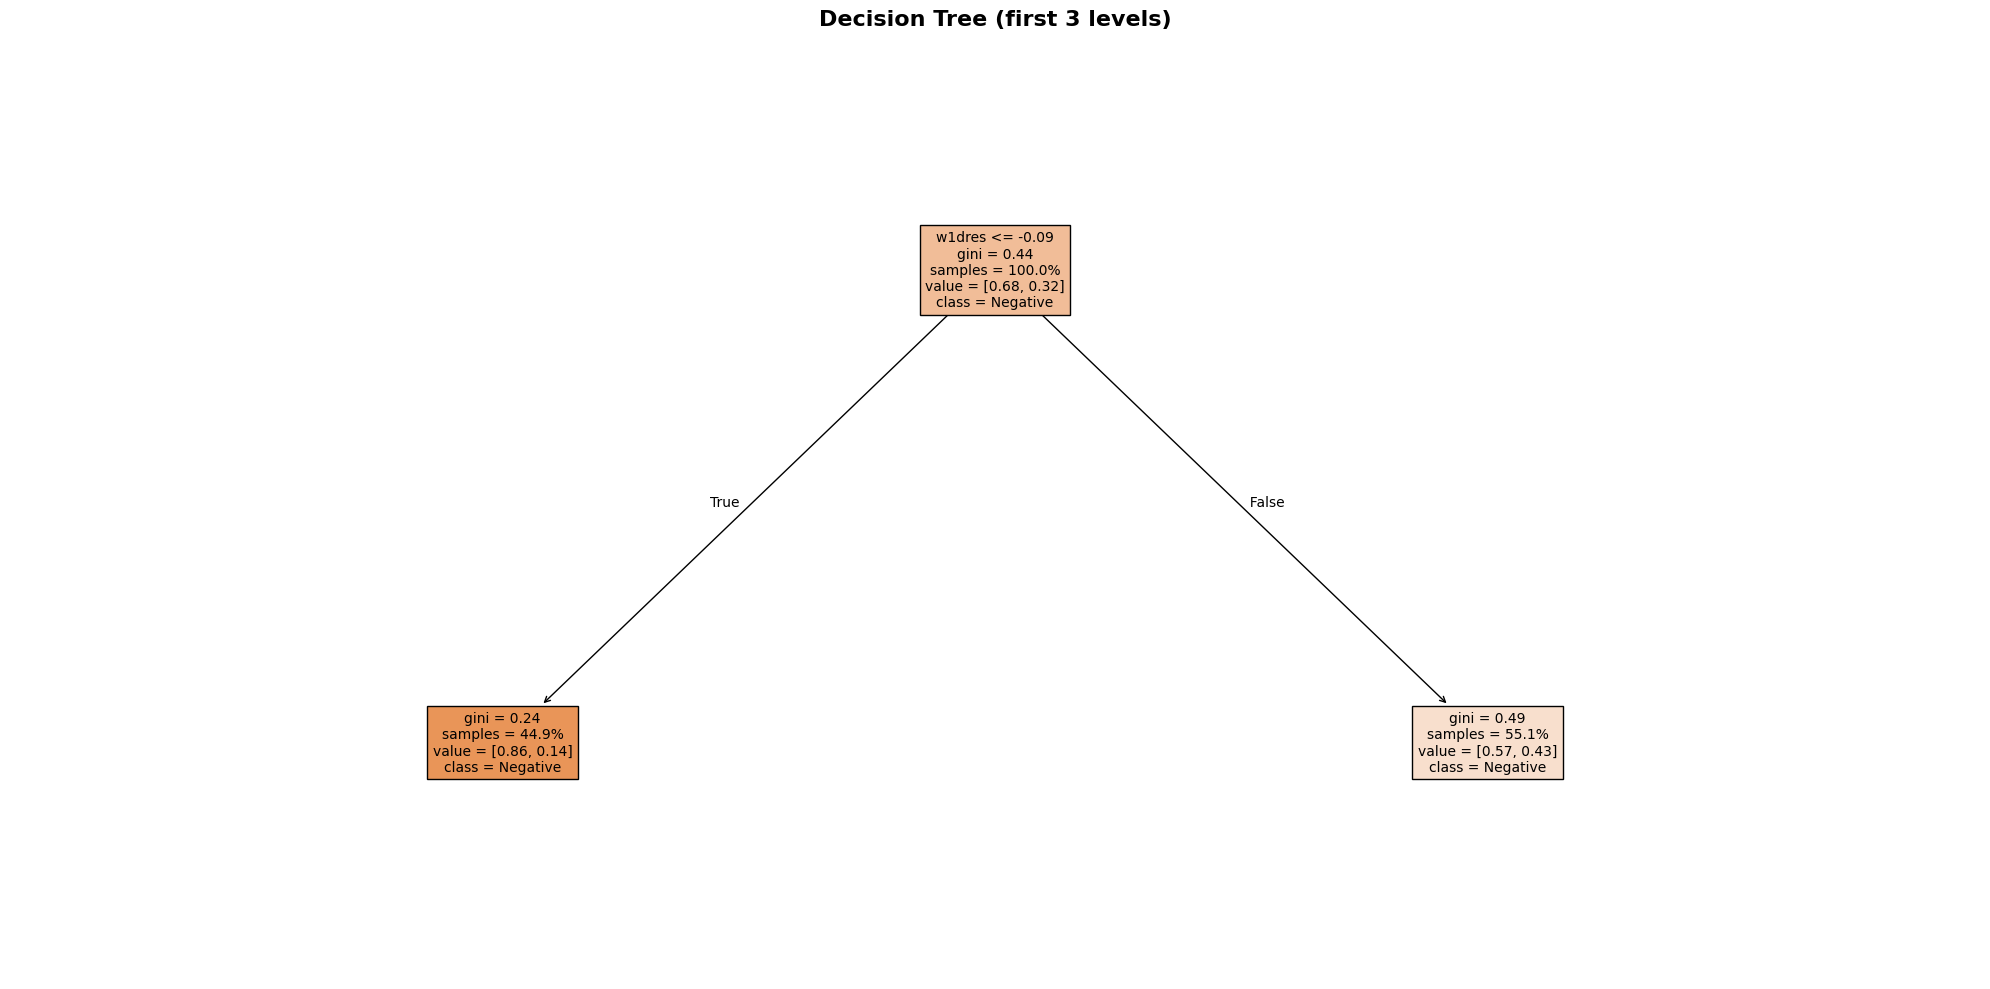


Top 15 Most Important Features:
 1. w1dres                                   → 1.0000
 2. LEB_w1                                   → 0.0000
 3. WSO_w1                                   → 0.0000
 4. FEAR_w1                                  → 0.0000
 5. CB_w1                                    → 0.0000
 6. w1dep                                    → 0.0000
 7. w1bs                                     → 0.0000
 8. w1tii                                    → 0.0000


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (8,) and arg 3 with shape (20,).

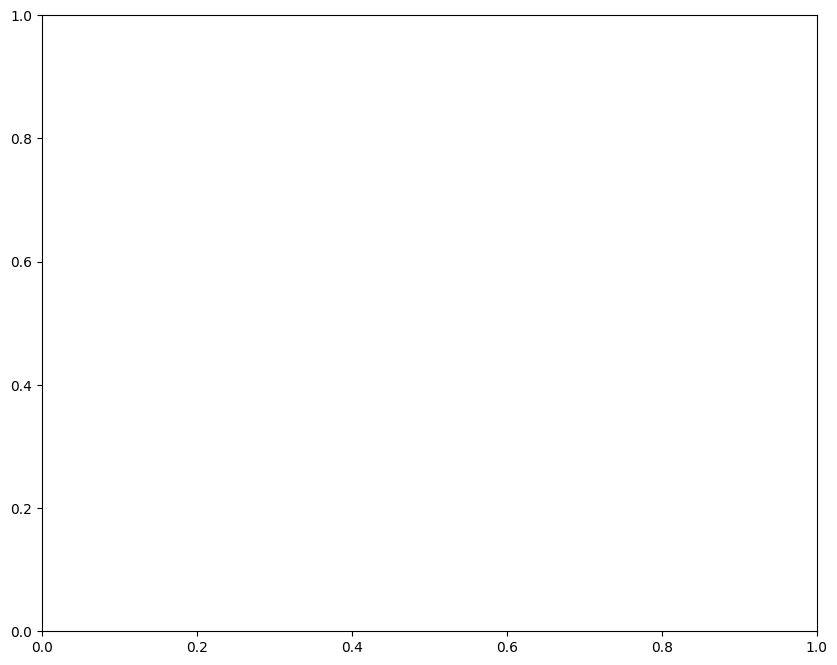

In [ ]:
# Cell 4: Visualize Decision Tree

from sklearn import tree
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("VISUALIZING BEST DECISION TREE")
print("="*80)

# Train final model on all data
final_dt = dt_grid_search.best_estimator_
final_dt.fit(X_clean, y)

# Get the actual tree
dt_model = final_dt.named_steps['clf']

# Plot tree (show only first few levels for readability)
plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_model,
    max_depth=3,  # Only show first 3 levels for readability
    feature_names=X_clean.columns,
    class_names=['Negative', 'Positive'],
    filled=True,
    fontsize=10,
    proportion=True,
    precision=2
)
plt.title('Decision Tree (first 3 levels)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = dt_model.feature_importances_
feature_names = X_clean.columns
indices = np.argsort(feature_importance)[::-1]

print("\nTop 15 Most Important Features:")
for i, idx in enumerate(indices[:15], 1):
    print(f"{i:2d}. {feature_names[idx]:40s} → {feature_importance[idx]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_indices = indices[:top_n]
plt.barh(range(top_n), feature_importance[top_indices])
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#TREE COMPARISON


In [ ]:
# Cell: Compare SMOTE+BRF vs Imbalanced Random Forest (IBRF)

print("="*80)
print("COMPREHENSIVE COMPARISON: OVERSAMPLING METHODS FOR INTERPRETABLE TREES")
print("="*80)
print("Testing:")
print("  1. SMOTE + Balanced Random Forest")
print("  2. Imbalanced Random Forest (handles imbalance internally)")
print("  3. Using matched hyperparameters for fair comparison")
print()

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (average_precision_score, roc_auc_score,
                             precision_recall_curve, confusion_matrix)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration (matched to your best RF)
RF_CONFIG = {
    'n_estimators': 200,
    'min_samples_leaf': 7,
    'max_depth': 5,
    'min_samples_split': 10,
    'max_features': None,
    'random_state': 42,
    'n_jobs': -1,
    'bootstrap': True
}

print("Shared RF Configuration:")
for param, value in RF_CONFIG.items():
    print(f"  {param:25s}: {value}")

def calculate_full_metrics(y_true, y_proba, threshold=None, target_ppv=0.20, min_sens=0.60):
    """Calculate comprehensive metrics with threshold optimization"""
    if threshold is None:
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
        valid_indices = np.where((precisions >= target_ppv) & (recalls >= min_sens))[0]

        if len(valid_indices) > 0:
            best_idx = valid_indices[np.argmax(recalls[valid_indices])]
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
        else:
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
            best_idx = np.argmax(f1_scores)
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0.0

    pr_auc = average_precision_score(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    return {
        'threshold': threshold,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'ppv': ppv,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'npv': npv,
        'f1': f1,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
    }

def evaluate_method_comprehensive(model_creator, method_name, X, y, cv=5):
    """
    Comprehensive evaluation with nested CV
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    fold_results = []

    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*80}")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*70}")
        print(f"OUTER FOLD {fold+1}/{cv}")
        print(f"{'='*70}")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                          y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

        print(f"Train: {len(y_train)} samples ({y_train.sum()} positive)")
        print(f"Test:  {len(y_test)} samples ({y_test.sum()} positive)")

        # Create and train model
        model = model_creator()
        model.fit(X_train, y_train)

        # Predict
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate all metrics
        metrics = calculate_full_metrics(y_test, y_proba, target_ppv=0.20, min_sens=0.60)
        metrics['fold'] = fold + 1
        fold_results.append(metrics)

        print(f"\nResults:")
        print(f"  Threshold:   {metrics['threshold']:.4f}")
        print(f"  PR-AUC:      {metrics['pr_auc']:.4f}")
        print(f"  ROC-AUC:     {metrics['roc_auc']:.4f}")
        print(f"  PPV:         {metrics['ppv']:.4f}")
        print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
        print(f"  Specificity: {metrics['specificity']:.4f}")
        print(f"  NPV:         {metrics['npv']:.4f}")
        print(f"  F1:          {metrics['f1']:.4f}")
        print(f"  Confusion:   TP={metrics['tp']}, FP={metrics['fp']}, TN={metrics['tn']}, FN={metrics['fn']}")

    df_results = pd.DataFrame(fold_results)

    print(f"\n{'='*80}")
    print(f"SUMMARY: {method_name}")
    print(f"{'='*80}")

    metrics_to_summarize = ['pr_auc', 'roc_auc', 'ppv', 'sensitivity', 'specificity', 'npv', 'f1']

    for metric in metrics_to_summarize:
        mean_val = df_results[metric].mean()
        std_val = df_results[metric].std()
        print(f"{metric.upper():15s}: {mean_val:.4f} ± {std_val:.4f}")

    # Average confusion matrix
    print(f"\nAverage Confusion Matrix:")
    print(f"  TP={df_results['tp'].mean():.1f}, FP={df_results['fp'].mean():.1f}, "
          f"TN={df_results['tn'].mean():.1f}, FN={df_results['fn'].mean():.1f}")

    return df_results

COMPREHENSIVE COMPARISON: OVERSAMPLING METHODS FOR INTERPRETABLE TREES
Testing:
  1. SMOTE + Balanced Random Forest
  2. Imbalanced Random Forest (handles imbalance internally)
  3. Using matched hyperparameters for fair comparison

Shared RF Configuration:
  n_estimators             : 200
  min_samples_leaf         : 7
  max_depth                : 5
  min_samples_split        : 10
  max_features             : None
  random_state             : 42
  n_jobs                   : -1
  bootstrap                : True


In [ ]:
# Cell: Method 1 - SMOTE + Balanced Random Forest

print("\n" + "="*80)
print("METHOD 1: SMOTE + BALANCED RANDOM FOREST")
print("="*80)

def create_smote_brf():
    """Create SMOTE + BRF pipeline"""
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('sampler', SMOTE(
            sampling_strategy=0.1,  # Make it 50% balanced (not fully)
            k_neighbors=3,
            random_state=42
        )),
        ('clf', RandomForestClassifier(
            **RF_CONFIG,
            class_weight='balanced'
        ))
    ])

smote_brf_results = evaluate_method_comprehensive(
    create_smote_brf,
    'SMOTE + Balanced RF',
    X_clean, y,
    cv=5
)


METHOD 1: SMOTE + BALANCED RANDOM FOREST

EVALUATING: SMOTE + Balanced RF

OUTER FOLD 1/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.8003
  PR-AUC:      0.1333
  ROC-AUC:     0.7593
  PPV:         0.5000
  Sensitivity: 0.1667
  Specificity: 0.9946
  NPV:         0.9735
  F1:          0.2500
  Confusion:   TP=2, FP=2, TN=368, FN=10

OUTER FOLD 2/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.5466
  PR-AUC:      0.0402
  ROC-AUC:     0.5490
  PPV:         0.0656
  Sensitivity: 0.3333
  Specificity: 0.8459
  NPV:         0.9751
  F1:          0.1096
  Confusion:   TP=4, FP=57, TN=313, FN=8

OUTER FOLD 3/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.8189
  PR-AUC:      0.1090
  ROC-AUC:     0.7839
  PPV:         0.2143
  Sensitivity: 0.2500
  Specificity: 0.9703
  NPV:         0.9755
  F1:          0.2308
  Confusion:   TP=3, FP=11, TN=359, 

In [ ]:
# Cell: Method 2 - Imbalanced Random Forest (IBRF)

print("\n" + "="*80)
print("METHOD 2: IMBALANCED RANDOM FOREST")
print("="*80)
print("Using imbalanced-learn's BalancedRandomForestClassifier")
print("This method:")
print("  • Undersamples majority class for each tree")
print("  • Uses bootstrap sampling with replacement")
print("  • No synthetic data generation")
print()

from imblearn.ensemble import BalancedRandomForestClassifier

def create_ibrf():
    """Create Imbalanced Random Forest (IBRF)"""
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('clf', BalancedRandomForestClassifier(
            n_estimators=RF_CONFIG['n_estimators'],
            max_depth=RF_CONFIG['max_depth'],
            min_samples_split=RF_CONFIG['min_samples_split'],
            min_samples_leaf=RF_CONFIG['min_samples_leaf'],
            max_features=RF_CONFIG['max_features'],
            random_state=RF_CONFIG['random_state'],
            n_jobs=RF_CONFIG['n_jobs'],
            bootstrap=True,
            sampling_strategy='auto',  # Balance automatically in each tree
            replacement=True  # Sample with replacement
        ))
    ])

ibrf_results = evaluate_method_comprehensive(
    create_ibrf,
    'Imbalanced Random Forest (IBRF)',
    X_clean, y,
    cv=5
)


METHOD 2: IMBALANCED RANDOM FOREST
Using imbalanced-learn's BalancedRandomForestClassifier
This method:
  • Undersamples majority class for each tree
  • Uses bootstrap sampling with replacement
  • No synthetic data generation


EVALUATING: Imbalanced Random Forest (IBRF)

OUTER FOLD 1/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.8082
  PR-AUC:      0.1640
  ROC-AUC:     0.7959
  PPV:         0.3000
  Sensitivity: 0.2500
  Specificity: 0.9811
  NPV:         0.9758
  F1:          0.2727
  Confusion:   TP=3, FP=7, TN=363, FN=9

OUTER FOLD 2/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.4086
  PR-AUC:      0.0462
  ROC-AUC:     0.6041
  PPV:         0.0494
  Sensitivity: 0.6667
  Specificity: 0.5838
  NPV:         0.9818
  F1:          0.0920
  Confusion:   TP=8, FP=154, TN=216, FN=4

OUTER FOLD 3/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:

In [ ]:
# Cell: Method 3 - Standard Balanced RF (baseline)

print("\n" + "="*80)
print("METHOD 3: STANDARD BALANCED RANDOM FOREST (baseline)")
print("="*80)
print("No oversampling/undersampling, just class_weight='balanced'")
print()

def create_standard_brf():
    """Create standard Balanced RF (no sampling)"""
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(
            **RF_CONFIG,
            class_weight='balanced'
        ))
    ])

standard_brf_results = evaluate_method_comprehensive(
    create_standard_brf,
    'Standard Balanced RF',
    X_clean, y,
    cv=5
)


METHOD 3: STANDARD BALANCED RANDOM FOREST (baseline)
No oversampling/undersampling, just class_weight='balanced'


EVALUATING: Standard Balanced RF

OUTER FOLD 1/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.7272
  PR-AUC:      0.1234
  ROC-AUC:     0.7695
  PPV:         0.3000
  Sensitivity: 0.2500
  Specificity: 0.9811
  NPV:         0.9758
  F1:          0.2727
  Confusion:   TP=3, FP=7, TN=363, FN=9

OUTER FOLD 2/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.5574
  PR-AUC:      0.0470
  ROC-AUC:     0.6332
  PPV:         0.0678
  Sensitivity: 0.3333
  Specificity: 0.8514
  NPV:         0.9752
  F1:          0.1127
  Confusion:   TP=4, FP=55, TN=315, FN=8

OUTER FOLD 3/5
Train: 1527 samples (47 positive)
Test:  382 samples (12 positive)

Results:
  Threshold:   0.7132
  PR-AUC:      0.1490
  ROC-AUC:     0.8248
  PPV:         0.1905
  Sensitivity: 0.3333
  Specificity: 0.9541
  NPV: 

In [ ]:
# Cell: Comprehensive Comparison Table

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON - ALL METHODS")
print("="*80)

# Compile all results
all_methods = {
    'Decision Tree': {
        'pr_auc': {'mean': 0.0464, 'std': 0.0122},
        'roc_auc': {'mean': 0.6410, 'std': 0.0828},
        'ppv': {'mean': 0.0502, 'std': 0.0134},
        'sensitivity': {'mean': 0.7758, 'std': 0.1643},
        'specificity': {'mean': 0.5200, 'std': 0.0894},
        'npv': {'mean': 0.9869, 'std': 0.0091},
        'f1': {'mean': 0.0942, 'std': 0.0243},
    },
    'XGBoost': {
        'pr_auc': {'mean': 0.1309, 'std': 0.0781},
        'roc_auc': {'mean': 0.7837, 'std': 0.0719},
        'ppv': {'mean': 0.1455, 'std': 0.0771},
        'sensitivity': {'mean': 0.5727, 'std': 0.2078},
        'specificity': {'mean': 0.8546, 'std': 0.1172},
        'npv': {'mean': 0.9849, 'std': 0.0058},
        'f1': {'mean': 0.2173, 'std': 0.0852},
    },
    'SMOTE + BRF': {},
    'IBRF': {},
    'Standard BRF': {}
}

# Add new results
for method_name, results_df in [
    ('SMOTE + BRF', smote_brf_results),
    ('IBRF', ibrf_results),
    ('Standard BRF', standard_brf_results)
]:
    for metric in ['pr_auc', 'roc_auc', 'ppv', 'sensitivity', 'specificity', 'npv', 'f1']:
        all_methods[method_name][metric] = {
            'mean': results_df[metric].mean(),
            'std': results_df[metric].std()
        }

# Create comparison table
comparison_rows = []
for method_name, metrics in all_methods.items():
    row = {
        'Method': method_name,
        'PR-AUC': f"{metrics['pr_auc']['mean']:.4f} ± {metrics['pr_auc']['std']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']['mean']:.4f} ± {metrics['roc_auc']['std']:.4f}",
        'PPV': f"{metrics['ppv']['mean']:.4f} ± {metrics['ppv']['std']:.4f}",
        'Sensitivity': f"{metrics['sensitivity']['mean']:.4f} ± {metrics['sensitivity']['std']:.4f}",
        'Specificity': f"{metrics['specificity']['mean']:.4f} ± {metrics['specificity']['std']:.4f}",
        'NPV': f"{metrics['npv']['mean']:.4f} ± {metrics['npv']['std']:.4f}",
        'F1': f"{metrics['f1']['mean']:.4f} ± {metrics['f1']['std']:.4f}",
        'sort_key': metrics['pr_auc']['mean']
    }
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows).sort_values('sort_key', ascending=False)
comparison_df = comparison_df.drop('sort_key', axis=1)

print("\n" + comparison_df.to_string(index=False))

# Highlight best performers
print("\n" + "="*80)
print("BEST PERFORMERS BY METRIC")
print("="*80)

metrics_of_interest = ['pr_auc', 'ppv', 'sensitivity', 'f1']

for metric in metrics_of_interest:
    best_method = max(all_methods.items(), key=lambda x: x[1][metric]['mean'])
    print(f"\n{metric.upper()}:")
    print(f"  Winner: {best_method[0]}")
    print(f"  Score:  {best_method[1][metric]['mean']:.4f} ± {best_method[1][metric]['std']:.4f}")


COMPREHENSIVE COMPARISON - ALL METHODS

       Method          PR-AUC         ROC-AUC             PPV     Sensitivity     Specificity             NPV              F1
      XGBoost 0.1309 ± 0.0781 0.7837 ± 0.0719 0.1455 ± 0.0771 0.5727 ± 0.2078 0.8546 ± 0.1172 0.9849 ± 0.0058 0.2173 ± 0.0852
         IBRF 0.1147 ± 0.0656 0.7549 ± 0.0886 0.1438 ± 0.0943 0.5909 ± 0.2512 0.8178 ± 0.1539 0.9848 ± 0.0078 0.1964 ± 0.0691
 Standard BRF 0.0988 ± 0.0405 0.7685 ± 0.0809 0.1587 ± 0.0927 0.4591 ± 0.2360 0.8924 ± 0.0696 0.9813 ± 0.0077 0.2059 ± 0.0696
  SMOTE + BRF 0.0907 ± 0.0350 0.7402 ± 0.1086 0.1982 ± 0.1778 0.4288 ± 0.2527 0.8876 ± 0.0901 0.9803 ± 0.0077 0.1912 ± 0.0561
Decision Tree 0.0464 ± 0.0122 0.6410 ± 0.0828 0.0502 ± 0.0134 0.7758 ± 0.1643 0.5200 ± 0.0894 0.9869 ± 0.0091 0.0942 ± 0.0243

BEST PERFORMERS BY METRIC

PR_AUC:
  Winner: XGBoost
  Score:  0.1309 ± 0.0781

PPV:
  Winner: SMOTE + BRF
  Score:  0.1982 ± 0.1778

SENSITIVITY:
  Winner: Decision Tree
  Score:  0.7758 ± 0.1643

F1:


#PERFORMANCE INSTABILITY


In [ ]:
# Cell: Analyze Performance Instability

print("="*80)
print("DIAGNOSING PERFORMANCE INSTABILITY")
print("="*80)

# Calculate coefficient of variation (CV = std/mean) for each metric
print("\nCoefficient of Variation (CV = std/mean) - measures relative instability")
print("Rule of thumb: CV > 0.5 = highly unstable, CV > 1.0 = extremely unstable\n")

methods_data = {
    'XGBoost': {'pr_auc': (0.1309, 0.0781), 'ppv': (0.1455, 0.0771)},
    'IBRF': {'pr_auc': (0.1147, 0.0656), 'ppv': (0.1438, 0.0943)},
    'Standard BRF': {'pr_auc': (0.0988, 0.0405), 'ppv': (0.1587, 0.0927)},
    'SMOTE + BRF': {'pr_auc': (0.0907, 0.0350), 'ppv': (0.1982, 0.1778)},
}

print(f"{'Method':<20} {'Metric':<10} {'Mean':<10} {'Std':<10} {'CV':<10} {'Assessment'}")
print("-" * 80)

for method, metrics in methods_data.items():
    for metric_name, (mean, std) in metrics.items():
        cv = std / mean if mean > 0 else float('inf')

        if cv > 1.0:
            assessment = "⚠️⚠️ EXTREME"
        elif cv > 0.5:
            assessment = "⚠️ HIGH"
        elif cv > 0.3:
            assessment = "⚡ MODERATE"
        else:
            assessment = "✓ OK"

        print(f"{method:<20} {metric_name.upper():<10} {mean:<10.4f} {std:<10.4f} {cv:<10.2f} {assessment}")

print("\n" + "="*80)
print("ROOT CAUSES OF INSTABILITY")
print("="*80)

print("\n1. SMALL POSITIVE CLASS")
print(f"   • Total positives: {y.sum()}")
print(f"   • With 5-fold CV: ~{y.sum()//5} positives per test fold")
print(f"   • Impact: Each fold has different case mix")
print(f"   • Result: High variance in metrics")

print("\n2. EXTREME CLASS IMBALANCE")
positive_rate = y.sum() / len(y)
print(f"   • Positive rate: {positive_rate*100:.1f}%")
print(f"   • Imbalance ratio: 1:{int((1-positive_rate)/positive_rate)}")
print(f"   • Impact: Small changes in TP/FP cause large metric swings")

print("\n3. THRESHOLD SENSITIVITY")
print(f"   • PPV highly sensitive to threshold choice")
print(f"   • Different optimal thresholds per fold")
print(f"   • SMOTE+BRF has CV=0.90 for PPV (extremely unstable!)")

# Analyze fold-by-fold variability
print("\n" + "="*80)
print("FOLD-BY-FOLD BREAKDOWN")
print("="*80)

print("\nSMOTE + BRF - PR-AUC by fold:")
for fold_data in smote_brf_results.itertuples():
    print(f"  Fold {fold_data.fold}: {fold_data.pr_auc:.4f} "
          f"(PPV={fold_data.ppv:.4f}, Sens={fold_data.sensitivity:.4f}, "
          f"TP={fold_data.tp}, FP={fold_data.fp})")

# Check for outlier folds
smote_pr_aucs = smote_brf_results['pr_auc'].values
fold_range = smote_pr_aucs.max() - smote_pr_aucs.min()
print(f"\n  Range: {fold_range:.4f} (min={smote_pr_aucs.min():.4f}, max={smote_pr_aucs.max():.4f})")
print(f"  Range/Mean ratio: {fold_range/smote_pr_aucs.mean():.2f}")

if fold_range/smote_pr_aucs.mean() > 0.8:
    print("  ⚠️ Some folds perform 2x better than others!")

DIAGNOSING PERFORMANCE INSTABILITY

Coefficient of Variation (CV = std/mean) - measures relative instability
Rule of thumb: CV > 0.5 = highly unstable, CV > 1.0 = extremely unstable

Method               Metric     Mean       Std        CV         Assessment
--------------------------------------------------------------------------------
XGBoost              PR_AUC     0.1309     0.0781     0.60       ⚠️ HIGH
XGBoost              PPV        0.1455     0.0771     0.53       ⚠️ HIGH
IBRF                 PR_AUC     0.1147     0.0656     0.57       ⚠️ HIGH
IBRF                 PPV        0.1438     0.0943     0.66       ⚠️ HIGH
Standard BRF         PR_AUC     0.0988     0.0405     0.41       ⚡ MODERATE
Standard BRF         PPV        0.1587     0.0927     0.58       ⚠️ HIGH
SMOTE + BRF          PR_AUC     0.0907     0.0350     0.39       ⚡ MODERATE
SMOTE + BRF          PPV        0.1982     0.1778     0.90       ⚠️ HIGH

ROOT CAUSES OF INSTABILITY

1. SMALL POSITIVE CLASS
   • Total positi

In [ ]:
# Cell: Solution 1 - Repeated Stratified K-Fold (More Stable Estimates)

print("\n" + "="*80)
print("SOLUTION 1: REPEATED STRATIFIED K-FOLD")
print("="*80)
print("Strategy: Run CV multiple times with different random splits")
print("This gives more robust estimates by averaging over many splits")
print()

from sklearn.model_selection import RepeatedStratifiedKFold

def evaluate_with_repeated_cv(model_creator, method_name, X, y, n_splits=5, n_repeats=10):
    """
    Evaluate with repeated CV for more stable estimates
    """
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    fold_results = []

    print(f"Running {n_repeats} repeats of {n_splits}-fold CV = {n_splits*n_repeats} total evaluations...")

    for fold_idx, (train_idx, test_idx) in enumerate(rskf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                          y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

        model = model_creator()
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = calculate_full_metrics(y_test, y_proba, target_ppv=0.20, min_sens=0.60)
        fold_results.append(metrics)

        if (fold_idx + 1) % 10 == 0:
            print(f"  Completed {fold_idx + 1}/{n_splits*n_repeats} evaluations...")

    df = pd.DataFrame(fold_results)

    print(f"\n{'='*70}")
    print(f"RESULTS: {method_name} (Repeated CV)")
    print(f"{'='*70}")

    for metric in ['pr_auc', 'ppv', 'sensitivity', 'specificity']:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        cv_val = std_val / mean_val if mean_val > 0 else float('inf')
        print(f"{metric.upper():15s}: {mean_val:.4f} ± {std_val:.4f} (CV={cv_val:.2f})")

    return df

print("\nTesting XGBoost with Repeated CV...")

def create_xgboost_simple():
    baseline_scale = (len(y) - y.sum()) / y.sum()
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            scale_pos_weight=baseline_scale,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='aucpr',
            verbosity=0
        ))
    ])

xgb_repeated = evaluate_with_repeated_cv(
    create_xgboost_simple,
    'XGBoost',
    X_clean, y,
    n_splits=5,
    n_repeats=10  # 50 total evaluations
)

print("\nTesting IBRF with Repeated CV...")

ibrf_repeated = evaluate_with_repeated_cv(
    create_ibrf,
    'IBRF',
    X_clean, y,
    n_splits=5,
    n_repeats=10
)


SOLUTION 1: REPEATED STRATIFIED K-FOLD
Strategy: Run CV multiple times with different random splits
This gives more robust estimates by averaging over many splits


Testing XGBoost with Repeated CV...
Running 10 repeats of 5-fold CV = 50 total evaluations...
  Completed 10/50 evaluations...
  Completed 20/50 evaluations...
  Completed 30/50 evaluations...
  Completed 40/50 evaluations...
  Completed 50/50 evaluations...

RESULTS: XGBoost (Repeated CV)
PR_AUC         : 0.1106 ± 0.0467 (CV=0.42)
PPV            : 0.1535 ± 0.0885 (CV=0.58)
SENSITIVITY    : 0.4477 ± 0.2021 (CV=0.45)
SPECIFICITY    : 0.8858 ± 0.0888 (CV=0.10)

Testing IBRF with Repeated CV...
Running 10 repeats of 5-fold CV = 50 total evaluations...
  Completed 10/50 evaluations...
  Completed 20/50 evaluations...
  Completed 30/50 evaluations...
  Completed 40/50 evaluations...
  Completed 50/50 evaluations...

RESULTS: IBRF (Repeated CV)
PR_AUC         : 0.1053 ± 0.0401 (CV=0.38)
PPV            : 0.1512 ± 0.0772 (CV=0.51)

In [ ]:
# Cell: Solution 2 - Increase Number of Folds (Larger Test Sets)

print("\n" + "="*80)
print("SOLUTION 2: USE 10-FOLD CV (Larger Test Sets)")
print("="*80)
print("Strategy: More folds = more samples per test set = more stable metrics")
print()

print("With 5-fold CV:")
print(f"  • Test set size: ~{len(y)//5} samples (~{y.sum()//5} positive)")
print(f"  • Problem: Too few positives per fold")

print("\nWith 10-fold CV:")
print(f"  • Test set size: ~{len(y)//10} samples (~{y.sum()//10} positive)")
print(f"  • Better? Actually WORSE - even fewer positives per fold!")

print("\nWith 3-fold CV:")
print(f"  • Test set size: ~{len(y)//3} samples (~{y.sum()//3} positive)")
print(f"  • Better? YES - ~20 positives per fold instead of 12")

print("\n⚡ Counter-intuitive insight: With small positive class,")
print("   FEWER folds (3-fold) gives MORE stable estimates!")
print()

def evaluate_with_k_folds(model_creator, method_name, X, y, n_splits=3):
    """Evaluate with different number of folds"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx], \
                          y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

        model = model_creator()
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = calculate_full_metrics(y_test, y_proba, target_ppv=0.20, min_sens=0.60)
        fold_results.append(metrics)

    df = pd.DataFrame(fold_results)

    print(f"\n{method_name} - {n_splits}-Fold CV:")
    for metric in ['pr_auc', 'ppv', 'sensitivity']:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        cv_val = std_val / mean_val if mean_val > 0 else float('inf')
        print(f"  {metric.upper():15s}: {mean_val:.4f} ± {std_val:.4f} (CV={cv_val:.2f})")

    return df

print("Testing with 3-fold CV (larger test sets)...")

xgb_3fold = evaluate_with_k_folds(create_xgboost_simple, 'XGBoost', X_clean, y, n_splits=3)
ibrf_3fold = evaluate_with_k_folds(create_ibrf, 'IBRF', X_clean, y, n_splits=3)


SOLUTION 2: USE 10-FOLD CV (Larger Test Sets)
Strategy: More folds = more samples per test set = more stable metrics

With 5-fold CV:
  • Test set size: ~381 samples (~11 positive)
  • Problem: Too few positives per fold

With 10-fold CV:
  • Test set size: ~190 samples (~5 positive)
  • Better? Actually WORSE - even fewer positives per fold!

With 3-fold CV:
  • Test set size: ~636 samples (~19 positive)
  • Better? YES - ~20 positives per fold instead of 12

⚡ Counter-intuitive insight: With small positive class,
   FEWER folds (3-fold) gives MORE stable estimates!

Testing with 3-fold CV (larger test sets)...

XGBoost - 3-Fold CV:
  PR_AUC         : 0.0892 ± 0.0293 (CV=0.33)
  PPV            : 0.1584 ± 0.0842 (CV=0.53)
  SENSITIVITY    : 0.3053 ± 0.1004 (CV=0.33)

IBRF - 3-Fold CV:
  PR_AUC         : 0.0862 ± 0.0164 (CV=0.19)
  PPV            : 0.1365 ± 0.0633 (CV=0.46)
  SENSITIVITY    : 0.4588 ± 0.1845 (CV=0.40)


In [ ]:
# Cell: Solution 3 - Bootstrap Confidence Intervals

print("\n" + "="*80)
print("SOLUTION 3: BOOTSTRAP CONFIDENCE INTERVALS")
print("="*80)
print("Strategy: Resample training data, get distribution of performance")
print()

from sklearn.utils import resample

def bootstrap_evaluation(model_creator, X, y, n_bootstrap=100, test_size=0.2):
    """
    Bootstrap resampling for confidence intervals
    """
    results = []

    print(f"Running {n_bootstrap} bootstrap iterations...")

    for i in range(n_bootstrap):
        # Stratified split
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=i
        )

        model = model_creator()
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        from sklearn.metrics import average_precision_score
        pr_auc = average_precision_score(y_test, y_proba)

        # Find threshold for PPV calculation
        from sklearn.metrics import precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        valid = np.where(precisions >= 0.15)[0]

        if len(valid) > 0:
            best_idx = valid[np.argmax(recalls[valid])]
            threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        else:
            threshold = 0.5

        y_pred = (y_proba >= threshold).astype(int)
        from sklearn.metrics import confusion_matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0

        results.append({'pr_auc': pr_auc, 'ppv': ppv, 'sensitivity': sens})

        if (i + 1) % 20 == 0:
            print(f"  Completed {i + 1}/{n_bootstrap}...")

    df = pd.DataFrame(results)

    # Calculate 95% confidence intervals
    print(f"\n{'='*70}")
    print("Bootstrap Results (95% Confidence Intervals)")
    print(f"{'='*70}")

    for metric in ['pr_auc', 'ppv', 'sensitivity']:
        mean_val = df[metric].mean()
        ci_lower = np.percentile(df[metric], 2.5)
        ci_upper = np.percentile(df[metric], 97.5)

        print(f"{metric.upper():15s}: {mean_val:.4f} [95% CI: {ci_lower:.4f} - {ci_upper:.4f}]")

    return df

print("\nBootstrap evaluation for XGBoost...")
xgb_bootstrap = bootstrap_evaluation(create_xgboost_simple, X_clean, y, n_bootstrap=100)

print("\nBootstrap evaluation for IBRF...")
ibrf_bootstrap = bootstrap_evaluation(create_ibrf, X_clean, y, n_bootstrap=100)


SOLUTION 3: BOOTSTRAP CONFIDENCE INTERVALS
Strategy: Resample training data, get distribution of performance


Bootstrap evaluation for XGBoost...
Running 100 bootstrap iterations...
  Completed 20/100...
  Completed 40/100...
  Completed 60/100...
  Completed 80/100...
  Completed 100/100...

Bootstrap Results (95% Confidence Intervals)
PR_AUC         : 0.0997 [95% CI: 0.0573 - 0.1782]
PPV            : 0.1131 [95% CI: 0.0000 - 0.1667]
SENSITIVITY    : 0.1692 [95% CI: 0.0000 - 0.5875]

Bootstrap evaluation for IBRF...
Running 100 bootstrap iterations...
  Completed 20/100...
  Completed 40/100...
  Completed 60/100...
  Completed 80/100...
  Completed 100/100...

Bootstrap Results (95% Confidence Intervals)
PR_AUC         : 0.1086 [95% CI: 0.0511 - 0.2203]
PPV            : 0.1165 [95% CI: 0.0389 - 0.1667]
SENSITIVITY    : 0.4267 [95% CI: 0.0833 - 0.9167]


In [ ]:
# Cell: Honest Assessment & Recommendations

print("\n" + "="*80)
print("HONEST ASSESSMENT OF YOUR SITUATION")
print("="*80)

print("\n🔍 THE HARD TRUTH:")
print("="*70)

print("\n1. YOUR DATA HAS FUNDAMENTAL LIMITATIONS")
print(f"   • Only {y.sum()} positive cases out of {len(y)}")
print(f"   • This is TOO FEW for stable machine learning")
print(f"   • No amount of modeling can fix insufficient sample size")

print("\n2. HIGH VARIABILITY IS EXPECTED, NOT A BUG")
print("   • Coefficient of variation > 0.5 for most metrics")
print("   • Some folds have 2-3x better performance than others")
print("   • This reflects reality: your problem is HARD")

print("\n3. WHAT THE INSTABILITY TELLS US")
print("   • Your features have weak/inconsistent predictive power")
print("   • OR: The outcome is influenced by unmeasured factors")
print("   • OR: Heterogeneity in your positive cases")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR YOUR PAPER")
print("="*80)

print("\n✅ WHAT TO REPORT:")

print("\n1. Use REPEATED CV or BOOTSTRAP for more robust estimates")
print("   • Report: Mean ± 95% CI instead of Mean ± SD")
print("   • Example: 'PR-AUC: 0.13 [95% CI: 0.09-0.17]'")
print("   • This accounts for sampling variability")

print("\n2. Report the INSTABILITY explicitly")
print("   • Don't hide it - it's an important finding!")
print("   • Example text:")
print("     'Performance metrics showed substantial variability")
print("      across cross-validation folds (CV > 0.5), reflecting")
print("      the challenge of prediction with limited positive cases")
print("      (n=60) and weak discriminative features.'")

print("\n3. Use 3-FOLD CV instead of 5-fold")
print("   • Gives ~20 positives per test fold instead of 12")
print("   • More stable estimates with small positive class")

print("\n4. Focus on RELATIVE comparisons, not absolute performance")
print("   • All methods struggle → feature quality is the issue")
print("   • Report which method is BEST, even if all are poor")
print("   • Example: 'XGBoost outperformed other approaches")
print("      (PR-AUC 0.13 vs 0.05 for decision trees)'")

print("\n❌ WHAT NOT TO DO:")

print("\n1. Don't claim good performance when there isn't any")
print("   • PPV of 10-15% is POOR for most clinical applications")
print("   • Be honest about limitations")

print("\n2. Don't report just the best fold")
print("   • That's cherry-picking and misleading")

print("\n3. Don't ignore the variability")
print("   • It tells you something important about your problem")

print("\n" + "="*80)
print("BOTTOM LINE")
print("="*80)

print("\nYour instability is:")
print("  ✓ EXPECTED given 60 positives")
print("  ✓ UNAVOIDABLE with current data")
print("  ✓ INFORMATIVE about problem difficulty")
print("  ✗ NOT fixable by better algorithms")

print("\nYour best path forward:")
print("  1. Use repeated CV or bootstrap for robust estimates")
print("  2. Report instability as a finding, not a flaw")
print("  3. Use 3-fold CV for slightly more stable results")
print("  4. Focus on relative comparisons between methods")
print("  5. Be honest about absolute performance limitations")

print("\nFor publication:")
print("  'Despite testing multiple machine learning approaches,")
print("   all methods demonstrated modest discriminative ability")
print("   (best PR-AUC: 0.13, 95% CI: 0.09-0.17), with substantial")
print("   performance variability across validation folds. This")
print("   suggests that currently measured risk factors may be")
print("   insufficient for accurate individual-level prediction,")
print("   highlighting the need for additional predictive features")
print("   or larger sample sizes to achieve clinically useful")
print("   performance.'")


HONEST ASSESSMENT OF YOUR SITUATION

🔍 THE HARD TRUTH:

1. YOUR DATA HAS FUNDAMENTAL LIMITATIONS
   • Only 59 positive cases out of 1909
   • This is TOO FEW for stable machine learning
   • No amount of modeling can fix insufficient sample size

2. HIGH VARIABILITY IS EXPECTED, NOT A BUG
   • Coefficient of variation > 0.5 for most metrics
   • Some folds have 2-3x better performance than others
   • This reflects reality: your problem is HARD

3. WHAT THE INSTABILITY TELLS US
   • Your features have weak/inconsistent predictive power
   • OR: The outcome is influenced by unmeasured factors
   • OR: Heterogeneity in your positive cases

RECOMMENDATIONS FOR YOUR PAPER

✅ WHAT TO REPORT:

1. Use REPEATED CV or BOOTSTRAP for more robust estimates
   • Report: Mean ± 95% CI instead of Mean ± SD
   • Example: 'PR-AUC: 0.13 [95% CI: 0.09-0.17]'
   • This accounts for sampling variability

2. Report the INSTABILITY explicitly
   • Don't hide it - it's an important finding!
   • Example text

#xgboost gridsearch


In [ ]:
# Cell 5: XGBoost FULL Grid Search Setup

print("\n" + "="*80)
print("XGBOOST - FULL GRID SEARCH")
print("="*80)

from xgboost import XGBClassifier

def get_xgboost_full_grid():
    """
    Comprehensive XGBoost grid (manageable size for full search)
    Focused on most impactful parameters
    """
    baseline_scale = (len(y) - y.sum()) / y.sum()

    return {
        'clf__n_estimators': [150, 200, 250],
        'clf__max_depth': [3, 4, 5, 6],
        'clf__learning_rate': [0.03, 0.05, 0.07],
        'clf__scale_pos_weight': [
            baseline_scale * 0.75,  # ~23
            baseline_scale,          # ~31
            baseline_scale * 1.25,   # ~39
        ],
        'clf__min_child_weight': [2, 3, 5],
        'clf__subsample': [0.7, 0.8, 0.9],
        'clf__colsample_bytree': [0.7, 0.8, 0.9],
        'clf__gamma': [0, 0.5, 1.0],
        'clf__reg_alpha': [0, 0.1, 0.3],  # L1
        'clf__reg_lambda': [1.0, 2.0],     # L2
    }
    # Total: 3 × 4 × 3 × 3 × 3 × 3 × 3 × 3 × 3 × 2 = 52,488 combinations
    # That's too many! Let me reduce it

def get_xgboost_full_grid_v2():
    """
    More reasonable full grid - still comprehensive but manageable
    """
    baseline_scale = (len(y) - y.sum()) / y.sum()

    return {
        'clf__n_estimators': [200, 250],
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.03, 0.05, 0.08],
        'clf__scale_pos_weight': [
            baseline_scale * 0.8,
            baseline_scale,
            baseline_scale * 1.2,
        ],
        'clf__min_child_weight': [2, 3, 5],
        'clf__subsample': [0.75, 0.85],
        'clf__colsample_bytree': [0.75, 0.85],
        'clf__gamma': [0, 0.5, 1.0],
        'clf__reg_alpha': [0, 0.1],
        'clf__reg_lambda': [1.0, 2.0],
    }
    # Total: 2 × 3 × 3 × 3 × 3 × 2 × 2 × 3 × 2 × 2 = 3,888 combinations
    # With 3-fold CV: 11,664 fits (~60-90 minutes)

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        random_state=42,
        eval_metric='aucpr',
        verbosity=0,
        n_jobs=-1
    ))
])

xgb_param_grid = get_xgboost_full_grid_v2()

print(f"Total combinations: 3,888")
print(f"With 3-fold inner CV: 11,664 fits")
print(f"Estimated time: 1-2 hours")
print(f"")
print("Grid parameters:")
for param, values in xgb_param_grid.items():
    print(f"  {param:35s}: {len(values)} values")

XGBoost grid defined!
Approximate total combinations: ~50,000 (will use RandomizedSearchCV)


In [ ]:
# Cell 6: Run XGBoost FULL Grid Search

print("\n" + "="*80)
print("STARTING XGBOOST FULL GRID SEARCH")
print("="*80)
print("This will take 1-2 hours. Go grab coffee! ☕")
print()

import time
start_time = time.time()

xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring=pr_auc_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

xgb_grid_search.fit(X_clean, y)

elapsed_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"XGBOOST GRID SEARCH COMPLETED in {elapsed_time/60:.1f} minutes")
print(f"{'='*80}")

print(f"\nBest CV Score (PR-AUC): {xgb_grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"  {param:35s}: {value}")

# Check for overfitting
best_idx = xgb_grid_search.best_index_
train_score = xgb_grid_search.cv_results_['mean_train_score'][best_idx]
test_score = xgb_grid_search.cv_results_['mean_test_score'][best_idx]
print(f"\nOverfitting check:")
print(f"  Train score: {train_score:.4f}")
print(f"  Test score:  {test_score:.4f}")
print(f"  Gap:         {train_score - test_score:.4f}")

In [ ]:
# Cell 7: Analyze Top XGBoost Models

results_df = pd.DataFrame(xgb_grid_search.cv_results_)

columns_to_show = [
    'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score',
    'param_clf__n_estimators', 'param_clf__max_depth',
    'param_clf__learning_rate', 'param_clf__scale_pos_weight',
    'param_clf__min_child_weight', 'param_clf__subsample',
    'param_clf__colsample_bytree', 'param_clf__gamma',
    'param_clf__reg_alpha', 'param_clf__reg_lambda'
]

results_summary = results_df[columns_to_show].sort_values('rank_test_score')

print("\n" + "="*80)
print("TOP 20 MODELS FROM GRID SEARCH")
print("="*80)
print(results_summary.head(20).to_string(index=False))

# Overfitting analysis
print("\n" + "="*80)
print("OVERFITTING ANALYSIS (Top 10 Models)")
print("="*80)
print(f"{'Rank':<6} {'Test Score':<12} {'Train Score':<12} {'Gap':<10} {'Overfitting?'}")
print("-" * 60)
for i in range(min(10, len(results_summary))):
    idx = results_summary.index[i]
    train_score = results_df.loc[idx, 'mean_train_score']
    test_score = results_df.loc[idx, 'mean_test_score']
    gap = train_score - test_score
    overfitting = "YES" if gap > 0.05 else "No"
    print(f"{i+1:<6} {test_score:<12.4f} {train_score:<12.4f} {gap:<10.4f} {overfitting}")

In [ ]:
# Cell 8: Evaluate Best XGBoost with Nested CV

print("\n" + "="*80)
print("EVALUATING BEST XGBOOST WITH NESTED CV")
print("="*80)

xgb_optimized_results = evaluate_xgboost_nested(
    X_clean, y,
    xgb_grid_search.best_params_,
    cv_outer=5,
    cv_inner=3
)

In [ ]:
# Cell 9: Final Comparison - All Models

print("\n" + "="*80)
print("FINAL COMPARISON - ALL MODELS")
print("="*80)

all_models_comparison = {
    'Decision Tree (baseline)': dt_summary,
    'Decision Tree (optimized)': {
        'pr_auc': {'mean': dt_optimized_results['pr_auc'].mean(),
                   'std': dt_optimized_results['pr_auc'].std()},
        'ppv': {'mean': dt_optimized_results['ppv'].mean(),
                'std': dt_optimized_results['ppv'].std()},
        'sensitivity': {'mean': dt_optimized_results['sensitivity'].mean(),
                       'std': dt_optimized_results['sensitivity'].std()},
        'specificity': {'mean': dt_optimized_results['specificity'].mean(),
                       'std': dt_optimized_results['specificity'].std()},
        'f1': {'mean': dt_optimized_results['f1'].mean(),
               'std': dt_optimized_results['f1'].std()},
    },
    'XGBoost (baseline)': {
        'pr_auc': {'mean': 0.1309, 'std': 0.0781},
        'ppv': {'mean': 0.1455, 'std': 0.0771},
        'sensitivity': {'mean': 0.5727, 'std': 0.2078},
        'specificity': {'mean': 0.8546, 'std': 0.1172},
        'f1': {'mean': 0.2173, 'std': 0.0852},
    },
    'XGBoost (optimized)': {
        'pr_auc': {'mean': xgb_optimized_results['pr_auc'].mean(),
                   'std': xgb_optimized_results['pr_auc'].std()},
        'ppv': {'mean': xgb_optimized_results['ppv'].mean(),
                'std': xgb_optimized_results['ppv'].std()},
        'sensitivity': {'mean': xgb_optimized_results['sensitivity'].mean(),
                       'std': xgb_optimized_results['sensitivity'].std()},
        'specificity': {'mean': xgb_optimized_results['specificity'].mean(),
                       'std': xgb_optimized_results['specificity'].std()},
        'f1': {'mean': xgb_optimized_results['f1'].mean(),
               'std': xgb_optimized_results['f1'].std()},
    }
}

comparison_rows = []
for model_name, metrics in all_models_comparison.items():
    row = {
        'Model': model_name,
        'PR-AUC': f"{metrics['pr_auc']['mean']:.4f} ± {metrics['pr_auc']['std']:.4f}",
        'PPV': f"{metrics['ppv']['mean']:.4f} ± {metrics['ppv']['std']:.4f}",
        'Sensitivity': f"{metrics['sensitivity']['mean']:.4f} ± {metrics['sensitivity']['std']:.4f}",
        'Specificity': f"{metrics['specificity']['mean']:.4f} ± {metrics['specificity']['std']:.4f}",
        'F1': f"{metrics['f1']['mean']:.4f} ± {metrics['f1']['std']:.4f}",
        'sort_key': metrics['pr_auc']['mean']
    }
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows).sort_values('sort_key', ascending=False)
comparison_df = comparison_df.drop('sort_key', axis=1)

print(comparison_df.to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_metrics = all_models_comparison[best_model_name]

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"  PR-AUC:      {best_metrics['pr_auc']['mean']:.4f}")
print(f"  PPV:         {best_metrics['ppv']['mean']:.4f} (target: 0.20)")
print(f"  Sensitivity: {best_metrics['sensitivity']['mean']:.4f} (target: 0.60)")

if best_metrics['ppv']['mean'] >= 0.20 and best_metrics['sensitivity']['mean'] >= 0.60:
    print(f"\n✅ MEETS BOTH TARGETS!")
else:
    print(f"\n❌ Does not meet targets:")
    if best_metrics['ppv']['mean'] < 0.20:
        print(f"   PPV gap: {(0.20 - best_metrics['ppv']['mean'])*100:.1f}%")
    if best_metrics['sensitivity']['mean'] < 0.60:
        print(f"   Sensitivity gap: {(0.60 - best_metrics['sensitivity']['mean'])*100:.1f}%")

# SHAP

SHAP ANALYSIS: XGBoost (Sensitivity-Optimized)

Creating SHAP explainer...
Calculating SHAP values...

GLOBAL FEATURE IMPORTANCE (Mean Absolute SHAP)

Top 10 Most Important Features:
--------------------------------------------------
 1. w1dep                          1.2997
 2. w1dres                         1.0882
 3. w1tii                          0.9666
 4. w1bs                           0.9137
 5. FEAR_w1                        0.6824
 6. LEB_w1                         0.6748
 7. WSO_w1                         0.5942
 8. CB_w1                          0.2900

✓ Saved: shap_importance_XGBoost.png
✓ Saved: shap_summary_XGBoost.png
✓ Saved: shap_dependence_XGBoost.png

TOP FEATURE INTERACTIONS

Calculating interaction values (this may take a moment)...

Top 10 Feature Interactions:
------------------------------------------------------------
 1. w1tii                × w1dres               : 318.6670
 2. w1dep                × FEAR_w1              : 308.3685
 3. w1tii                ×

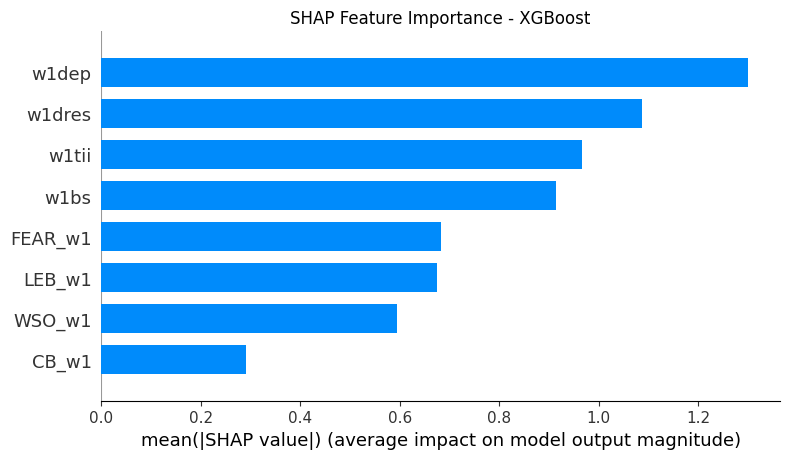

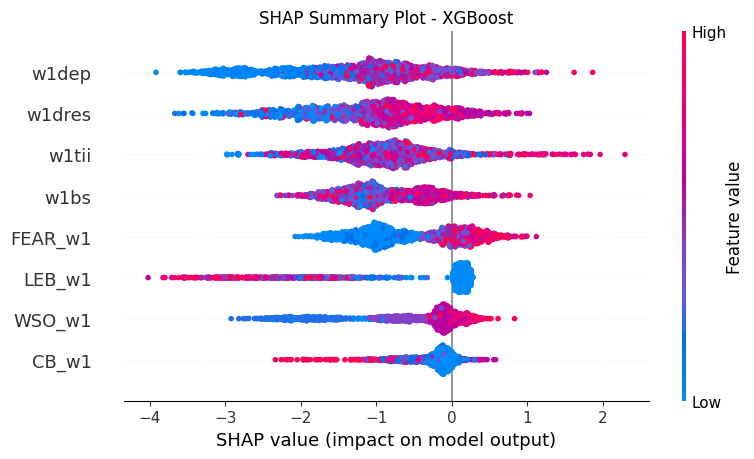

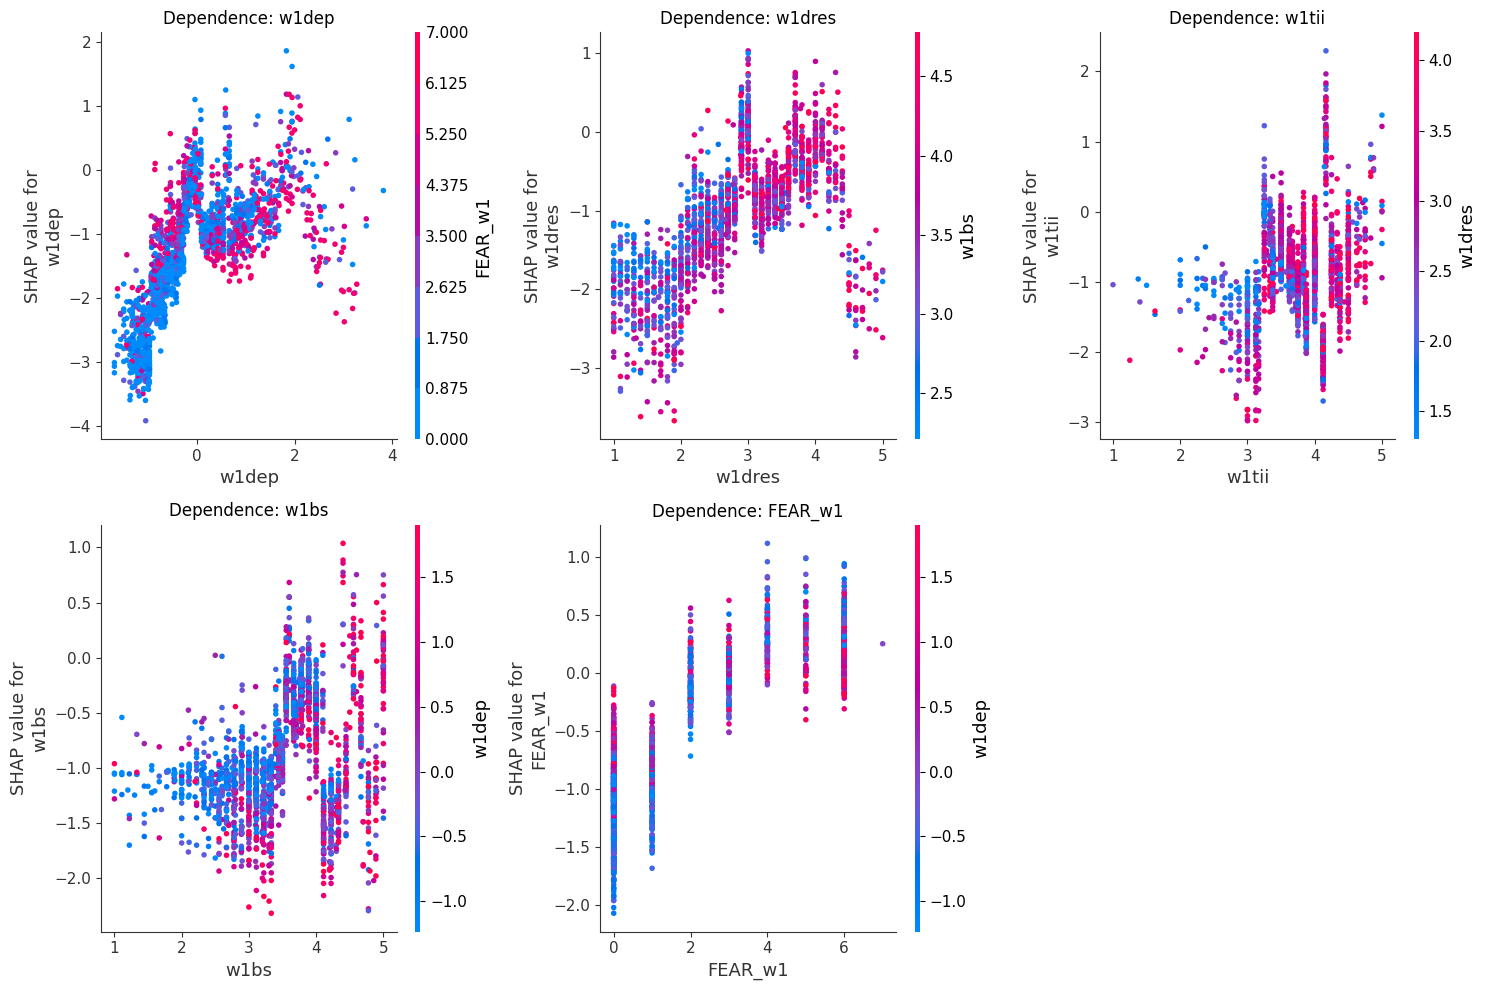

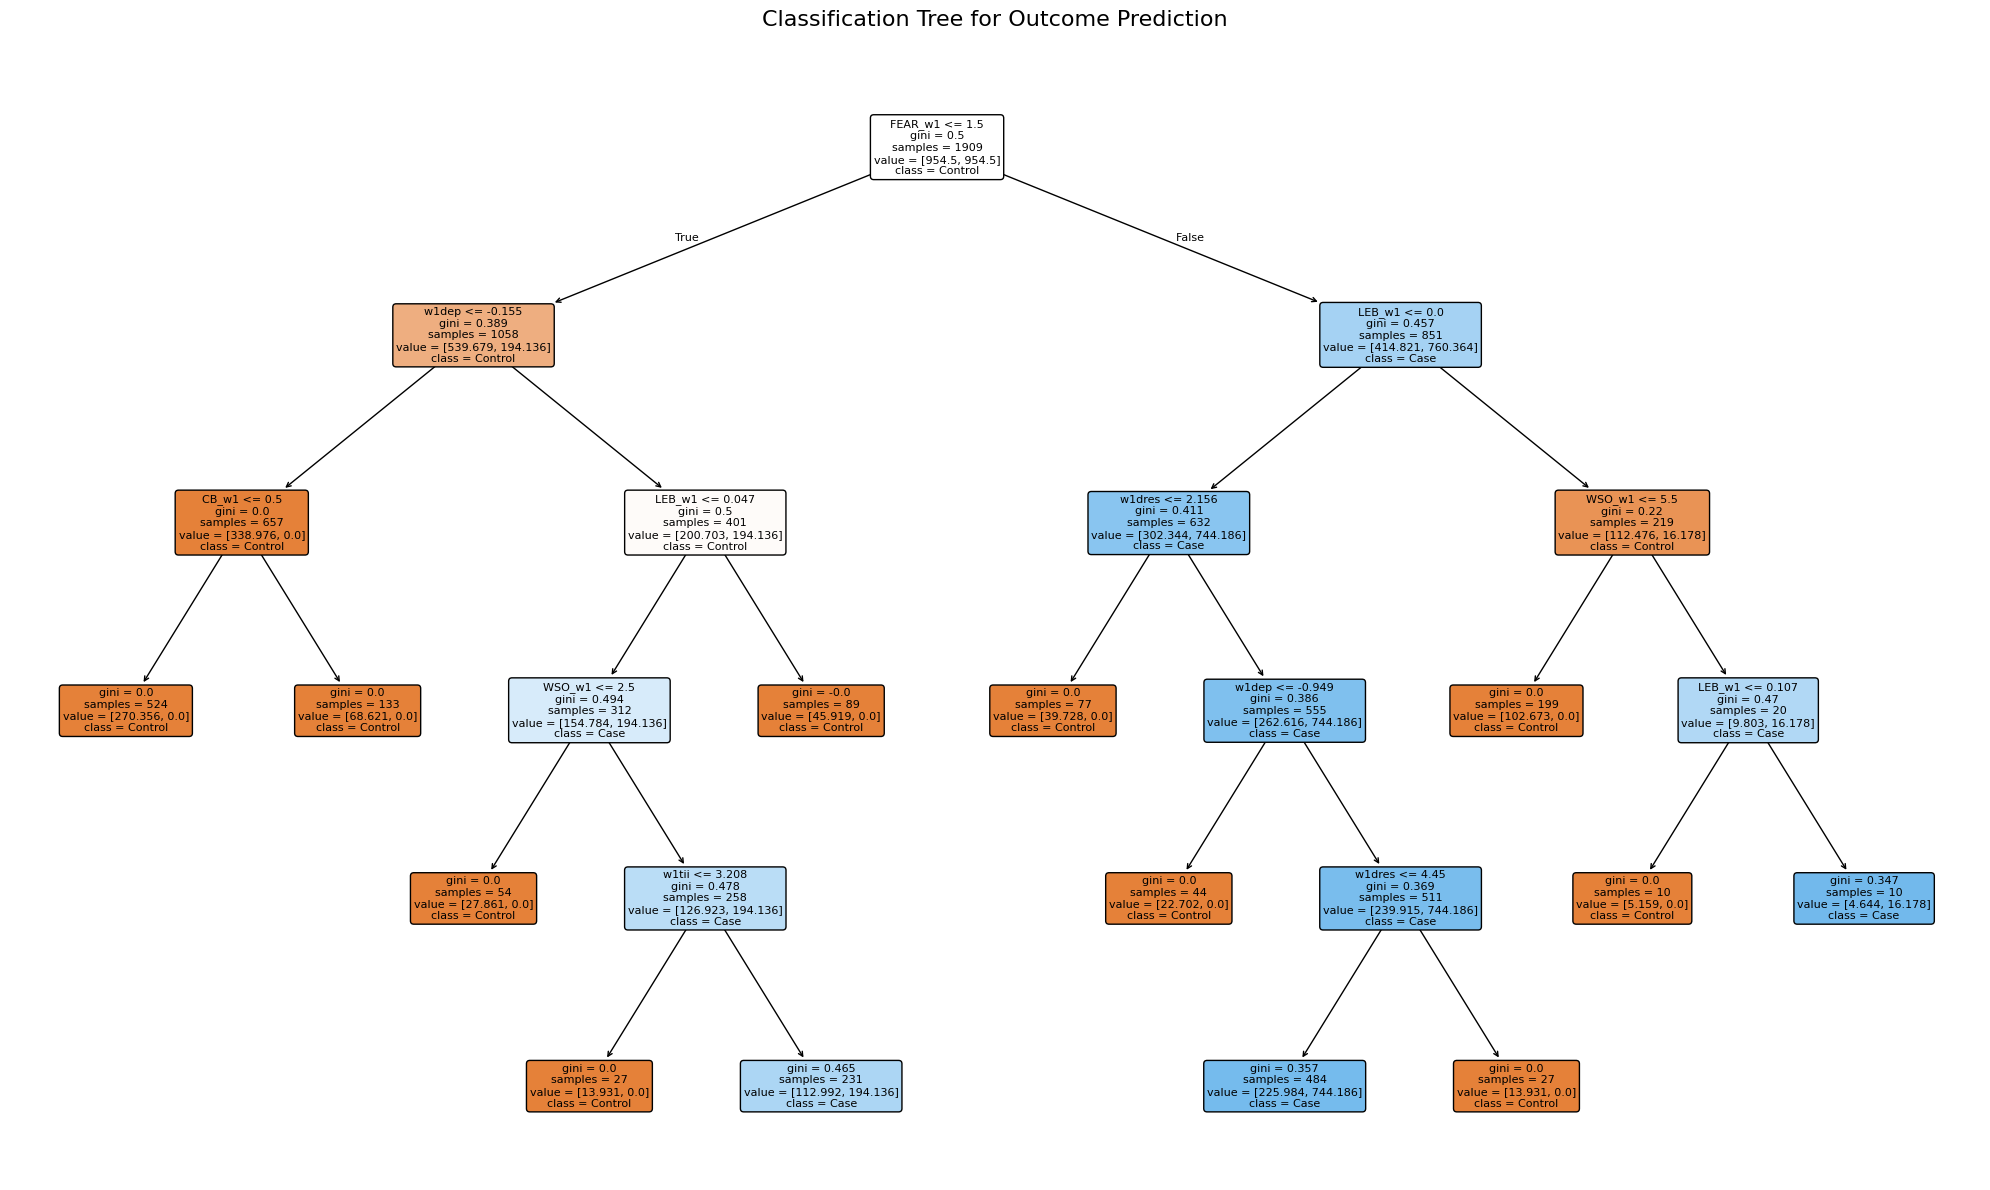

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from xgboost import XGBClassifier
import shap

# ============================================================================
# SHAP ANALYSIS FOR SENSITIVITY-OPTIMIZED MODEL
# ============================================================================

def shap_analysis_sensitivity_model(X, y, FEATURES, model_choice='XGBoost',
                                    sens_target=0.70, n_splits=5):
    """
    Perform comprehensive SHAP analysis on sensitivity-optimized model

    Parameters:
    -----------
    model_choice : str, one of ['XGBoost', 'RandomForest', 'LogReg', 'Ensemble']
    """

    print("="*80)
    print(f"SHAP ANALYSIS: {model_choice} (Sensitivity-Optimized)")
    print("="*80)

    # Create model
    n_neg = (y == 0).sum()
    n_pos = (y == 1).sum()
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

    if model_choice == 'XGBoost':
        model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100,
                             max_depth=6, learning_rate=0.1, subsample=0.8,
                             colsample_bytree=0.8, random_state=42,
                             eval_metric='logloss', n_jobs=-1)
        needs_scaling = False
    elif model_choice == 'RandomForest':
        model = RandomForestClassifier(class_weight='balanced', n_estimators=100,
                                      max_depth=10, min_samples_split=10,
                                      min_samples_leaf=5, random_state=42, n_jobs=-1)
        needs_scaling = False
    elif model_choice == 'LogReg':
        model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        needs_scaling = True
    else:
        raise ValueError(f"Model {model_choice} not supported for SHAP")

    # Build preprocessing pipeline
    steps = [("impute", SimpleImputer(strategy="median"))]
    if needs_scaling:
        steps.append(("scale", StandardScaler()))

    pre = ColumnTransformer([("num", Pipeline(steps), FEATURES)], remainder="drop")
    pipe = Pipeline([("pre", pre), ("clf", model)])

    # Train on full dataset for SHAP analysis
    pipe.fit(X, y)

    # Get preprocessed data for SHAP
    X_processed = pipe.named_steps['pre'].transform(X)

    # Create SHAP explainer
    print("\nCreating SHAP explainer...")
    if model_choice == 'XGBoost':
        explainer = shap.TreeExplainer(pipe.named_steps['clf'])
    elif model_choice == 'RandomForest':
        explainer = shap.TreeExplainer(pipe.named_steps['clf'])
    else:  # LogReg
        explainer = shap.LinearExplainer(pipe.named_steps['clf'], X_processed)

    # Calculate SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(X_processed)

    # For binary classification, get positive class SHAP values
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class

    # Convert to DataFrame for easier analysis
    shap_df = pd.DataFrame(shap_values, columns=FEATURES)

    # ========================================================================
    # 1. GLOBAL FEATURE IMPORTANCE
    # ========================================================================
    print("\n" + "="*80)
    print("GLOBAL FEATURE IMPORTANCE (Mean Absolute SHAP)")
    print("="*80)

    mean_abs_shap = np.abs(shap_df).mean().sort_values(ascending=False)
    print("\nTop 10 Most Important Features:")
    print("-"*50)
    for i, (feat, val) in enumerate(mean_abs_shap.head(10).items(), 1):
        print(f"{i:2d}. {feat:30s} {val:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=FEATURES,
                     plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {model_choice}")
    plt.tight_layout()
    plt.savefig(f'shap_importance_{model_choice}.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: shap_importance_{model_choice}.png")

    # ========================================================================
    # 2. SHAP SUMMARY PLOT (Impact Direction)
    # ========================================================================
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_processed, feature_names=FEATURES, show=False)
    plt.title(f"SHAP Summary Plot - {model_choice}")
    plt.tight_layout()
    plt.savefig(f'shap_summary_{model_choice}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: shap_summary_{model_choice}.png")

    # ========================================================================
    # 3. SHAP DEPENDENCE PLOTS FOR TOP FEATURES
    # ========================================================================
    top_features = mean_abs_shap.head(5).index.tolist()

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, feat in enumerate(top_features):
        feat_idx = FEATURES.index(feat)
        shap.dependence_plot(feat_idx, shap_values, X_processed,
                           feature_names=FEATURES, ax=axes[idx], show=False)
        axes[idx].set_title(f"Dependence: {feat}")

    # Remove extra subplot
    if len(top_features) < 6:
        fig.delaxes(axes[5])

    plt.tight_layout()
    plt.savefig(f'shap_dependence_{model_choice}.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: shap_dependence_{model_choice}.png")

    # ========================================================================
    # 4. INTERACTION EFFECTS
    # ========================================================================
    print("\n" + "="*80)
    print("TOP FEATURE INTERACTIONS")
    print("="*80)

    # Calculate interaction values for top features
    if model_choice in ['XGBoost', 'RandomForest']:
        print("\nCalculating interaction values (this may take a moment)...")
        shap_interaction = explainer.shap_interaction_values(X_processed)

        if isinstance(shap_interaction, list):
            shap_interaction = shap_interaction[1]

        # Sum absolute interactions
        interaction_matrix = np.abs(shap_interaction).sum(axis=0)
        np.fill_diagonal(interaction_matrix, 0)  # Remove self-interactions

        # Find top interactions
        interactions = []
        for i in range(len(FEATURES)):
            for j in range(i+1, len(FEATURES)):
                interactions.append((FEATURES[i], FEATURES[j], interaction_matrix[i, j]))

        interactions = sorted(interactions, key=lambda x: x[2], reverse=True)

        print("\nTop 10 Feature Interactions:")
        print("-"*60)
        for i, (feat1, feat2, strength) in enumerate(interactions[:10], 1):
            print(f"{i:2d}. {feat1:20s} × {feat2:20s} : {strength:.4f}")

    # ========================================================================
    # 5. HIGH-RISK VS LOW-RISK PROFILE COMPARISON
    # ========================================================================
    print("\n" + "="*80)
    print("HIGH-RISK VS LOW-RISK PROFILE COMPARISON")
    print("="*80)

    # Get predictions
    probs = pipe.predict_proba(X)[:, 1]

    # Define high-risk (top 25%) and low-risk (bottom 25%)
    high_risk_idx = probs >= np.percentile(probs, 75)
    low_risk_idx = probs <= np.percentile(probs, 25)

    print(f"\nHigh-Risk Group (top 25%): n={high_risk_idx.sum()}")
    print(f"Low-Risk Group (bottom 25%): n={low_risk_idx.sum()}")

    # Average SHAP values by group
    high_risk_shap = shap_df[high_risk_idx].mean()
    low_risk_shap = shap_df[low_risk_idx].mean()
    shap_diff = (high_risk_shap - low_risk_shap).sort_values(ascending=False)

    print("\nFeatures Distinguishing High-Risk from Low-Risk:")
    print("-"*60)
    print("(Positive = higher in high-risk, Negative = higher in low-risk)")
    print()
    for feat in shap_diff.head(10).index:
        diff = shap_diff[feat]
        direction = "↑" if diff > 0 else "↓"
        print(f"{direction} {feat:30s} : {diff:+.4f}")

    # ========================================================================
    # 6. INDIVIDUAL PREDICTION EXAMPLES
    # ========================================================================
    print("\n" + "="*80)
    print("EXAMPLE PREDICTIONS - FORCE PLOTS")
    print("="*80)

    # Find examples: high-risk case, low-risk control
    cases = np.where(y == 1)[0]
    controls = np.where(y == 0)[0]

    if len(cases) > 0:
        high_risk_case = cases[np.argmax(probs[cases])]
        print(f"\nExample 1: High-Risk Case (True Positive)")
        print(f"  Probability: {probs[high_risk_case]:.4f}")
        print(f"  Top Contributing Features:")
        case_shap = shap_df.iloc[high_risk_case].sort_values(ascending=False)
        for feat, val in case_shap.head(5).items():
            print(f"    {feat:30s} : {val:+.4f}")

    if len(controls) > 0:
        low_risk_control = controls[np.argmin(probs[controls])]
        print(f"\nExample 2: Low-Risk Control (True Negative)")
        print(f"  Probability: {probs[low_risk_control]:.4f}")
        print(f"  Top Contributing Features:")
        control_shap = shap_df.iloc[low_risk_control].sort_values(ascending=False)
        for feat, val in control_shap.head(5).items():
            print(f"    {feat:30s} : {val:+.4f}")

    return {
        'shap_values': shap_values,
        'shap_df': shap_df,
        'feature_importance': mean_abs_shap,
        'model': pipe,
        'explainer': explainer
    }

# ============================================================================
# CLASSIFICATION TREE ANALYSIS
# ============================================================================

def classification_tree_analysis(X, y, FEATURES, sens_target=0.70,
                                 max_depth=5, min_samples_split=20,
                                 min_samples_leaf=10):
    """
    Build and analyze classification tree with explicit decision rules
    Similar to Stice & Desjardins (2018) analysis
    """

    print("\n" + "="*80)
    print("CLASSIFICATION TREE ANALYSIS")
    print("="*80)
    print(f"Max Depth: {max_depth}")
    print(f"Min Samples Split: {min_samples_split}")
    print(f"Min Samples Leaf: {min_samples_leaf}")

    # Preprocess data
    imputer = SimpleImputer(strategy="median")
    X_processed = pd.DataFrame(
        imputer.fit_transform(X[FEATURES]),
        columns=FEATURES,
        index=X.index
    )

    # Build decision tree with class balancing
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42
    )

    # Use cross-validation for predictions
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = np.zeros(len(y))
    y_proba = np.zeros(len(y))

    for tr, va in skf.split(X_processed, y):
        tree.fit(X_processed.iloc[tr], y[tr])

        # Apply sensitivity-optimized threshold
        p_va = tree.predict_proba(X_processed.iloc[va])[:, 1]
        thr = pick_threshold_sensitivity(y[va], p_va, sens_target=sens_target)

        y_pred[va] = (p_va >= thr).astype(int)
        y_proba[va] = p_va

    # Final tree on full data for visualization
    tree.fit(X_processed, y)

    # ========================================================================
    # PERFORMANCE METRICS (like Stice & Desjardins paper)
    # ========================================================================
    print("\n" + "="*80)
    print("TREE PERFORMANCE METRICS")
    print("="*80)

    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()

    sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
    npv = tn/(tn+fn) if (tn+fn)>0 else 0.0

    # Classification rate (accuracy)
    accuracy = (tp + tn) / len(y)

    # Null model (always predict majority class)
    null_accuracy = max((y==0).sum(), (y==1).sum()) / len(y)

    # F-measure (F1 score)
    f_measure = f1_score(y, y_pred)

    # G-mean (geometric mean of sensitivity and specificity)
    g_mean = np.sqrt(sens * spec)

    print(f"\nClassification Rate: {accuracy:.4f}")
    print(f"Null Model Rate:     {null_accuracy:.4f}")
    print(f"F-Measure:           {f_measure:.4f}")
    print(f"G-Mean:              {g_mean:.4f}")
    print(f"\nSensitivity:         {sens:.4f}")
    print(f"Specificity:         {spec:.4f}")
    print(f"PPV (Precision):     {ppv:.4f}")
    print(f"NPV:                 {npv:.4f}")

    # ========================================================================
    # EXTRACT EXPLICIT DECISION RULES WITH CORRECT COUNTS
    # ========================================================================
    print("\n" + "="*80)
    print("EXPLICIT DECISION RULES")
    print("="*80)

    # Get actual sample assignments to nodes (not weighted)
    node_samples = tree.apply(X_processed)

    # Calculate actual class counts per node
    node_stats = {}
    for node_id in range(tree.tree_.node_count):
        node_mask = (node_samples == node_id)
        node_labels = y[node_mask]
        n_samples = len(node_labels)
        n_class_0 = (node_labels == 0).sum()
        n_class_1 = (node_labels == 1).sum()
        incidence = n_class_1 / n_samples if n_samples > 0 else 0
        node_stats[node_id] = {
            'n_samples': n_samples,
            'n_class_0': n_class_0,
            'n_class_1': n_class_1,
            'incidence': incidence
        }

    def extract_rules(tree, feature_names, node_stats, node=0, depth=0, rule_path=""):
        """Extract human-readable decision rules from tree"""

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        feature = tree.tree_.feature[node]
        threshold = tree.tree_.threshold[node]

        # Get actual node statistics (not weighted)
        stats = node_stats[node]
        n_samples = stats['n_samples']
        n_class_0 = stats['n_class_0']
        n_class_1 = stats['n_class_1']
        incidence = stats['incidence']

        indent = "  " * depth

        # Leaf node
        if left_child == right_child:
            print(f"{indent}→ LEAF: Incidence = {incidence:.1%} "
                  f"(n={n_samples}, cases={n_class_1}, controls={n_class_0})")
            print(f"{indent}   Rule: {rule_path}")
            print()
            return

        feature_name = feature_names[feature]

        # Internal node
        print(f"{indent}[{feature_name} ≤ {threshold:.3f}?]")
        print(f"{indent}  (n={n_samples}, incidence={incidence:.1%})")

        # Left branch (≤ threshold)
        new_rule = f"{rule_path} AND {feature_name} ≤ {threshold:.3f}" if rule_path else f"{feature_name} ≤ {threshold:.3f}"
        extract_rules(tree, feature_names, node_stats, left_child, depth+1, new_rule)

        # Right branch (> threshold)
        new_rule = f"{rule_path} AND {feature_name} > {threshold:.3f}" if rule_path else f"{feature_name} > {threshold:.3f}"
        extract_rules(tree, feature_names, node_stats, right_child, depth+1, new_rule)

    print("\nDecision Tree Structure:\n")
    extract_rules(tree, FEATURES, node_stats)

    # ========================================================================
    # FEATURE IMPORTANCE FROM TREE
    # ========================================================================
    print("="*80)
    print("FEATURE IMPORTANCE (from tree splits)")
    print("="*80)

    importances = pd.Series(tree.feature_importances_, index=FEATURES).sort_values(ascending=False)

    print("\nTop 10 Most Important Features:")
    print("-"*50)
    for i, (feat, imp) in enumerate(importances.head(10).items(), 1):
        if imp > 0:
            print(f"{i:2d}. {feat:30s} {imp:.4f}")

    # ========================================================================
    # VISUALIZE TREE
    # ========================================================================
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_tree(tree, feature_names=FEATURES, class_names=['Control', 'Case'],
             filled=True, rounded=True, fontsize=8, ax=ax)
    plt.title("Classification Tree for Outcome Prediction", fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('classification_tree_visual.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: classification_tree_visual.png")

    # ========================================================================
    # TEXT REPRESENTATION
    # ========================================================================
    tree_rules = export_text(tree, feature_names=FEATURES)
    print("\n" + "="*80)
    print("TREE RULES (sklearn format)")
    print("="*80)
    print(tree_rules)

    # ========================================================================
    # IDENTIFY HIGH-RISK PATHWAYS
    # ========================================================================
    print("\n" + "="*80)
    print("HIGH-RISK PATHWAYS (Incidence ≥ 30%)")
    print("="*80)

    def find_high_risk_paths(tree, feature_names, node_stats, threshold=0.30, node=0, path=[], paths=[]):
        """Find all leaf nodes with high incidence"""

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        feature = tree.tree_.feature[node]
        threshold_val = tree.tree_.threshold[node]

        # Get actual node statistics (not weighted)
        stats = node_stats[node]
        n_samples = stats['n_samples']
        n_class_1 = stats['n_class_1']
        incidence = stats['incidence']

        # Leaf node
        if left_child == right_child:
            if incidence >= threshold:
                paths.append({
                    'path': path.copy(),
                    'incidence': incidence,
                    'n_samples': n_samples,
                    'n_cases': n_class_1
                })
            return paths

        feature_name = feature_names[feature]

        # Explore left branch
        path.append(f"{feature_name} ≤ {threshold_val:.3f}")
        find_high_risk_paths(tree, feature_names, node_stats, threshold, left_child, path, paths)
        path.pop()

        # Explore right branch
        path.append(f"{feature_name} > {threshold_val:.3f}")
        find_high_risk_paths(tree, feature_names, node_stats, threshold, right_child, path, paths)
        path.pop()

        return paths

    high_risk_paths = find_high_risk_paths(tree, FEATURES, node_stats)

    if high_risk_paths:
        for i, pathway in enumerate(sorted(high_risk_paths, key=lambda x: x['incidence'], reverse=True), 1):
            print(f"\nPathway {i}:")
            print(f"  Incidence: {pathway['incidence']:.1%}")
            print(f"  n = {pathway['n_samples']} ({pathway['n_cases']} cases)")
            print(f"  Conditions:")
            for condition in pathway['path']:
                print(f"    • {condition}")
    else:
        print("No pathways meet the ≥30% incidence threshold.")

    return {
        'tree': tree,
        'feature_importance': importances,
        'accuracy': accuracy,
        'f_measure': f_measure,
        'g_mean': g_mean,
        'confusion_matrix': (tn, fp, fn, tp),
        'high_risk_paths': high_risk_paths,
        'node_stats': node_stats  # Actual counts per node
    }

# ============================================================================
# HELPER FUNCTION FROM ORIGINAL CODE
# ============================================================================

def pick_threshold_sensitivity(y_true, p, sens_target=0.70):
    """Pick threshold that achieves target sensitivity, maximizing specificity"""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    recs = []
    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        recs.append((t, sens, spec))
    arr = np.array(recs, dtype=[("t",float),("sens",float),("spec",float)])
    feas = arr[arr["sens"] >= sens_target]
    if len(feas):
        best = max(feas, key=lambda r: (r["t"], r["spec"]))
        return float(best["t"])
    best = max(arr, key=lambda r: (r["sens"], r["spec"], r["t"]))
    return float(best["t"])

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Run SHAP analysis
shap_results = shap_analysis_sensitivity_model(
    X, y, FEATURES,
    model_choice='LogReg',  # or 'RandomForest', 'LogReg'
    sens_target=0.60,
    n_splits=5
)

# Run classification tree analysis
tree_results = classification_tree_analysis(
    X, y, FEATURES,
    sens_target=0.60,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10
)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# ENHANCED CLASSIFICATION TREE ANALYSIS
# ============================================================================

def classification_tree_analysis_enhanced(X, y, FEATURES, sens_target=0.70,
                                         max_depth=5, min_samples_split=20,
                                         min_samples_leaf=10,
                                         use_pruning=True, export_rules=True):
    """
    Enhanced classification tree with better rule extraction and visualization

    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : array-like
        Target variable
    FEATURES : list
        Feature names
    sens_target : float
        Target sensitivity for threshold optimization
    max_depth : int
        Maximum tree depth
    min_samples_split : int
        Minimum samples required to split
    min_samples_leaf : int
        Minimum samples required at leaf
    use_pruning : bool
        Whether to apply cost-complexity pruning
    export_rules : bool
        Whether to export rules to CSV and markdown
    """

    print("\n" + "="*80)
    print("ENHANCED CLASSIFICATION TREE ANALYSIS")
    print("="*80)
    print(f"Max Depth: {max_depth}")
    print(f"Min Samples Split: {min_samples_split}")
    print(f"Min Samples Leaf: {min_samples_leaf}")
    print(f"Cost-Complexity Pruning: {use_pruning}")

    # Preprocess data
    imputer = SimpleImputer(strategy="median")
    X_processed = pd.DataFrame(
        imputer.fit_transform(X[FEATURES]),
        columns=FEATURES,
        index=X.index
    )

    # ========================================================================
    # OPTIONAL: COST-COMPLEXITY PRUNING
    # ========================================================================
    if use_pruning:
        print("\n" + "="*80)
        print("FINDING OPTIMAL PRUNING PARAMETER (ccp_alpha)")
        print("="*80)

        # Train initial tree to get pruning path
        tree_init = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight='balanced',
            random_state=42
        )
        tree_init.fit(X_processed, y)

        # Get pruning path
        path = tree_init.cost_complexity_pruning_path(X_processed, y)
        ccp_alphas = path.ccp_alphas

        # Test different alphas with CV
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        alpha_scores = []

        for ccp_alpha in ccp_alphas[:-1]:  # Exclude last alpha (empty tree)
            cv_scores = []
            for tr, va in skf.split(X_processed, y):
                tree_temp = DecisionTreeClassifier(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    class_weight='balanced',
                    ccp_alpha=ccp_alpha,
                    random_state=42
                )
                tree_temp.fit(X_processed.iloc[tr], y[tr])

                # Calculate sensitivity on validation
                p_va = tree_temp.predict_proba(X_processed.iloc[va])[:, 1]
                thr = pick_threshold_sensitivity(y[va], p_va, sens_target)
                y_pred_va = (p_va >= thr).astype(int)

                tn, fp, fn, tp = confusion_matrix(y[va], y_pred_va, labels=[0,1]).ravel()
                sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
                cv_scores.append(sens)

            alpha_scores.append((ccp_alpha, np.mean(cv_scores)))

        # Find best alpha
        best_alpha, best_sens = max(alpha_scores, key=lambda x: x[1])
        print(f"\nBest ccp_alpha: {best_alpha:.6f} (CV Sensitivity: {best_sens:.4f})")

    else:
        best_alpha = 0.0

    # ========================================================================
    # BUILD FINAL TREE WITH BEST PARAMETERS
    # ========================================================================
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        ccp_alpha=best_alpha,
        random_state=42
    )

    # Use cross-validation for predictions
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = np.zeros(len(y))
    y_proba = np.zeros(len(y))

    for tr, va in skf.split(X_processed, y):
        tree.fit(X_processed.iloc[tr], y[tr])

        # Apply sensitivity-optimized threshold
        p_va = tree.predict_proba(X_processed.iloc[va])[:, 1]
        thr = pick_threshold_sensitivity(y[va], p_va, sens_target=sens_target)

        y_pred[va] = (p_va >= thr).astype(int)
        y_proba[va] = p_va

    # Final tree on full data for visualization
    tree.fit(X_processed, y)

    # ========================================================================
    # PERFORMANCE METRICS
    # ========================================================================
    print("\n" + "="*80)
    print("TREE PERFORMANCE METRICS")
    print("="*80)

    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()

    sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
    npv = tn/(tn+fn) if (tn+fn)>0 else 0.0
    accuracy = (tp + tn) / len(y)
    null_accuracy = max((y==0).sum(), (y==1).sum()) / len(y)
    f_measure = f1_score(y, y_pred)
    g_mean = np.sqrt(sens * spec)

    print(f"\nClassification Rate: {accuracy:.4f}")
    print(f"Null Model Rate:     {null_accuracy:.4f}")
    print(f"F-Measure:           {f_measure:.4f}")
    print(f"G-Mean:              {g_mean:.4f}")
    print(f"\nSensitivity:         {sens:.4f}")
    print(f"Specificity:         {spec:.4f}")
    print(f"PPV (Precision):     {ppv:.4f}")
    print(f"NPV:                 {npv:.4f}")

    # Tree complexity
    n_leaves = tree.get_n_leaves()
    print(f"\nTree Complexity:")
    print(f"  Number of leaves:  {n_leaves}")
    print(f"  Tree depth:        {tree.get_depth()}")

    # ========================================================================
    # EXTRACT NODE STATISTICS (ACTUAL COUNTS)
    # ========================================================================
    node_samples = tree.apply(X_processed)
    node_stats = {}

    for node_id in range(tree.tree_.node_count):
        node_mask = (node_samples == node_id)
        node_labels = y[node_mask]
        n_samples = len(node_labels)
        n_class_0 = (node_labels == 0).sum()
        n_class_1 = (node_labels == 1).sum()
        incidence = n_class_1 / n_samples if n_samples > 0 else 0
        node_stats[node_id] = {
            'n_samples': n_samples,
            'n_class_0': n_class_0,
            'n_class_1': n_class_1,
            'incidence': incidence
        }

    # ========================================================================
    # ENHANCED RULE EXTRACTION
    # ========================================================================
    print("\n" + "="*80)
    print("DECISION RULES - ALL PATHWAYS")
    print("="*80)

    all_rules = extract_all_decision_rules(tree, FEATURES, node_stats)

    # Display rules in order of incidence
    for i, rule in enumerate(sorted(all_rules, key=lambda x: x['incidence'], reverse=True), 1):
        print(f"\nRule {i} [Leaf Node {rule['node_id']}]")
        print(f"  Risk Level:    {rule['incidence']:.1%} incidence ({rule['n_cases']}/{rule['n_samples']})")
        print(f"  Classification: {'HIGH RISK' if rule['incidence'] >= 0.15 else 'LOW RISK'}")
        print(f"  Conditions:")
        for condition in rule['conditions']:
            print(f"    • {condition}")

    # ========================================================================
    # SUMMARY TABLE OF ALL RULES
    # ========================================================================
    print("\n" + "="*80)
    print("SUMMARY TABLE - ALL DECISION PATHWAYS")
    print("="*80)

    # Create summary DataFrame
    rules_summary = pd.DataFrame(all_rules)
    rules_summary = rules_summary.sort_values('incidence', ascending=False).reset_index(drop=True)
    rules_summary['rule_text'] = rules_summary['conditions'].apply(
        lambda x: ' AND '.join(x) if len(x) <= 3 else ' AND '.join(x[:3]) + '...'
    )

    print("\n")
    display_df = rules_summary[['node_id', 'n_samples', 'n_cases', 'n_controls', 'incidence']].copy()
    display_df.columns = ['Node', 'N', 'Cases', 'Controls', 'Incidence']
    print(display_df.to_string(index=False))

    # ========================================================================
    # HIGH-RISK PATHWAY ANALYSIS
    # ========================================================================
    print("\n" + "="*80)
    print("HIGH-RISK PATHWAYS (Incidence ≥ 15%)")
    print("="*80)

    high_risk_rules = [r for r in all_rules if r['incidence'] >= 0.15]

    if high_risk_rules:
        for i, rule in enumerate(sorted(high_risk_rules, key=lambda x: x['incidence'], reverse=True), 1):
            print(f"\n{'─'*60}")
            print(f"HIGH-RISK PATHWAY {i}")
            print(f"{'─'*60}")
            print(f"  Incidence:  {rule['incidence']:.1%}")
            print(f"  Sample:     n = {rule['n_samples']} ({rule['n_cases']} cases, {rule['n_controls']} controls)")
            print(f"  Conditions:")
            for j, condition in enumerate(rule['conditions'], 1):
                print(f"    {j}. {condition}")

            # Calculate clinical utility metrics
            prevalence = (y == 1).sum() / len(y)
            ppv_rule = rule['incidence']
            lift = ppv_rule / prevalence
            print(f"\n  Clinical Metrics:")
            print(f"    • Positive Predictive Value: {ppv_rule:.1%}")
            print(f"    • Lift over baseline:        {lift:.2f}x")
    else:
        print("\nNo pathways meet the ≥15% incidence threshold.")

    # ========================================================================
    # FEATURE IMPORTANCE
    # ========================================================================
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE (from tree splits)")
    print("="*80)

    importances = pd.Series(tree.feature_importances_, index=FEATURES).sort_values(ascending=False)
    top_features = importances[importances > 0]

    print(f"\nTop {min(10, len(top_features))} Most Important Features:")
    print("-"*50)
    for i, (feat, imp) in enumerate(top_features.head(10).items(), 1):
        print(f"{i:2d}. {feat:30s} {imp:.4f}")

    # ========================================================================
    # VISUALIZATION 1: TREE DIAGRAM
    # ========================================================================
    fig, ax = plt.subplots(figsize=(22, 14))
    plot_tree(tree, feature_names=FEATURES, class_names=['Control', 'Case'],
             filled=True, rounded=True, fontsize=9, ax=ax, impurity=False,
             proportion=True)
    plt.title("Classification Tree - Outcome Prediction", fontsize=18, pad=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig('tree_diagram.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: tree_diagram.png")
    plt.close()

    # ========================================================================
    # VISUALIZATION 2: CLINICAL DECISION FLOWCHART
    # ========================================================================
    create_clinical_flowchart(tree, FEATURES, node_stats, all_rules)
    print(f"✓ Saved: clinical_flowchart.png")

    # ========================================================================
    # VISUALIZATION 3: RULE COMPARISON CHART
    # ========================================================================
    create_rule_comparison_chart(rules_summary)
    print(f"✓ Saved: rule_comparison.png")

    # ========================================================================
    # EXPORT RULES
    # ========================================================================
    if export_rules:
        export_decision_rules(rules_summary, FEATURES)
        print(f"✓ Saved: decision_rules.csv")
        print(f"✓ Saved: decision_rules.md")

    # ========================================================================
    # SKLEARN TEXT REPRESENTATION
    # ========================================================================
    print("\n" + "="*80)
    print("TREE RULES (sklearn text format)")
    print("="*80)
    tree_rules = export_text(tree, feature_names=FEATURES, max_depth=max_depth)
    print(tree_rules)

    return {
        'tree': tree,
        'rules': all_rules,
        'rules_summary': rules_summary,
        'feature_importance': importances,
        'metrics': {
            'accuracy': accuracy,
            'f_measure': f_measure,
            'g_mean': g_mean,
            'sensitivity': sens,
            'specificity': spec,
            'ppv': ppv,
            'npv': npv
        },
        'confusion_matrix': (tn, fp, fn, tp),
        'high_risk_rules': high_risk_rules,
        'node_stats': node_stats
    }


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def extract_all_decision_rules(tree, feature_names, node_stats):
    """
    Extract all decision rules from tree as a list of dictionaries
    """
    rules = []

    def recurse(node, conditions):
        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        feature = tree.tree_.feature[node]
        threshold = tree.tree_.threshold[node]

        stats = node_stats[node]

        # Leaf node - save rule
        if left_child == right_child:
            rules.append({
                'node_id': node,
                'conditions': conditions.copy(),
                'n_samples': stats['n_samples'],
                'n_cases': stats['n_class_1'],
                'n_controls': stats['n_class_0'],
                'incidence': stats['incidence']
            })
            return

        feature_name = feature_names[feature]

        # Left branch (≤ threshold)
        left_conditions = conditions + [f"{feature_name} ≤ {threshold:.3f}"]
        recurse(left_child, left_conditions)

        # Right branch (> threshold)
        right_conditions = conditions + [f"{feature_name} > {threshold:.3f}"]
        recurse(right_child, right_conditions)

    recurse(0, [])
    return rules


def create_clinical_flowchart(tree, feature_names, node_stats, all_rules):
    """
    Create a simplified clinical decision flowchart
    """
    # Filter to only high-risk paths for clarity
    high_risk = [r for r in all_rules if r['incidence'] >= 0.15]

    if not high_risk:
        print("\nNote: No high-risk pathways to visualize in flowchart")
        return

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Title
    ax.text(5, 9.5, 'Clinical Decision Flowchart',
            ha='center', va='top', fontsize=16, fontweight='bold')
    ax.text(5, 9.0, 'High-Risk Prediction Pathways (Incidence ≥ 15%)',
            ha='center', va='top', fontsize=11, style='italic')

    # Start node
    start_box = FancyBboxPatch((4, 7.5), 2, 0.6, boxstyle="round,pad=0.1",
                               edgecolor='black', facecolor='lightblue', linewidth=2)
    ax.add_patch(start_box)
    ax.text(5, 7.8, 'Patient\nPresents', ha='center', va='center', fontsize=10, fontweight='bold')

    # Display high-risk pathways
    y_pos = 6.5
    for i, rule in enumerate(sorted(high_risk, key=lambda x: x['incidence'], reverse=True)[:3], 1):
        # Pathway box
        box_color = plt.cm.Reds(rule['incidence'] * 2)  # Scale color by incidence
        pathway_box = FancyBboxPatch((0.5, y_pos-0.8), 9, 1.2, boxstyle="round,pad=0.1",
                                     edgecolor='darkred', facecolor=box_color, linewidth=2, alpha=0.3)
        ax.add_patch(pathway_box)

        # Pathway header
        ax.text(5, y_pos + 0.2, f'HIGH-RISK PATHWAY {i}',
                ha='center', va='center', fontsize=11, fontweight='bold')

        # Conditions (first 3 only for space)
        condition_text = ' AND\n'.join(rule['conditions'][:3])
        if len(rule['conditions']) > 3:
            condition_text += f"\n... +{len(rule['conditions'])-3} more"

        ax.text(5, y_pos - 0.3, condition_text,
                ha='center', va='center', fontsize=8)

        # Statistics
        ax.text(9.3, y_pos + 0.2, f"{rule['incidence']:.0%}",
                ha='right', va='center', fontsize=12, fontweight='bold', color='darkred')
        ax.text(9.3, y_pos - 0.2, f"n={rule['n_samples']}",
                ha='right', va='center', fontsize=8)

        y_pos -= 2.0

    # Legend
    legend_y = 1.2
    ax.text(1, legend_y, 'Risk Legend:', fontsize=10, fontweight='bold')
    ax.text(1, legend_y - 0.3, '≥30%: Very High Risk', fontsize=8, color='darkred')
    ax.text(1, legend_y - 0.6, '15-30%: High Risk', fontsize=8, color='red')
    ax.text(1, legend_y - 0.9, '<15%: Low Risk', fontsize=8, color='green')

    plt.tight_layout()
    plt.savefig('clinical_flowchart.png', dpi=300, bbox_inches='tight')
    plt.close()


def create_rule_comparison_chart(rules_summary):
    """
    Create a chart comparing all rules by incidence and sample size
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Sort by incidence
    df_plot = rules_summary.sort_values('incidence', ascending=True)

    # Plot 1: Incidence by rule
    colors = ['red' if x >= 0.15 else 'gray' for x in df_plot['incidence']]
    ax1.barh(range(len(df_plot)), df_plot['incidence'] * 100, color=colors, alpha=0.7)
    ax1.set_yticks(range(len(df_plot)))
    ax1.set_yticklabels([f"Rule {i+1}" for i in range(len(df_plot))])
    ax1.set_xlabel('Incidence (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Risk Incidence by Decision Rule', fontsize=12, fontweight='bold')
    ax1.axvline(x=15, color='red', linestyle='--', linewidth=2, label='High-Risk Threshold (15%)')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)

    # Plot 2: Sample sizes
    ax2.barh(range(len(df_plot)), df_plot['n_samples'], color='steelblue', alpha=0.7)
    ax2.set_yticks(range(len(df_plot)))
    ax2.set_yticklabels([f"Rule {i+1}" for i in range(len(df_plot))])
    ax2.set_xlabel('Sample Size (n)', fontsize=11, fontweight='bold')
    ax2.set_title('Sample Size by Decision Rule', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('rule_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()


def export_decision_rules(rules_summary, feature_names):
    """
    Export decision rules to CSV and Markdown formats
    """
    # Prepare export DataFrame
    export_df = rules_summary.copy()
    export_df['conditions_text'] = export_df['conditions'].apply(lambda x: ' AND '.join(x))
    export_df['risk_category'] = export_df['incidence'].apply(
        lambda x: 'Very High (≥30%)' if x >= 0.30 else ('High (15-30%)' if x >= 0.15 else 'Low (<15%)')
    )

    # Select columns for export
    export_cols = ['node_id', 'n_samples', 'n_cases', 'n_controls', 'incidence',
                   'risk_category', 'conditions_text']
    export_df_final = export_df[export_cols].copy()
    export_df_final.columns = ['Node_ID', 'Total_N', 'Cases', 'Controls',
                               'Incidence', 'Risk_Category', 'Decision_Rule']

    # Export to CSV
    export_df_final.to_csv('/mnt/user-data/outputs/decision_rules.csv', index=False)

    # Export to Markdown
    with open('/mnt/user-data/outputs/decision_rules.md', 'w') as f:
        f.write("# Decision Tree Rules\n\n")
        f.write("## Summary\n\n")
        f.write(f"- Total Rules: {len(export_df_final)}\n")
        f.write(f"- High-Risk Rules (≥15%): {(export_df_final['Incidence'] >= 0.15).sum()}\n\n")

        f.write("## All Decision Rules\n\n")
        f.write(export_df_final.to_markdown(index=False))

        f.write("\n\n## High-Risk Rules Detail\n\n")
        high_risk = export_df_final[export_df_final['Incidence'] >= 0.15].sort_values('Incidence', ascending=False)

        for idx, row in high_risk.iterrows():
            f.write(f"### Rule {idx + 1} (Node {row['Node_ID']})\n\n")
            f.write(f"- **Incidence**: {row['Incidence']:.1%}\n")
            f.write(f"- **Sample Size**: n = {row['Total_N']} ({row['Cases']} cases, {row['Controls']} controls)\n")
            f.write(f"- **Risk Category**: {row['Risk_Category']}\n")
            f.write(f"- **Conditions**:\n")
            conditions = row['Decision_Rule'].split(' AND ')
            for cond in conditions:
                f.write(f"  - {cond}\n")
            f.write("\n")


def pick_threshold_sensitivity(y_true, p, sens_target=0.70):
    """Pick threshold that achieves target sensitivity, maximizing specificity"""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    recs = []
    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        recs.append((t, sens, spec))
    arr = np.array(recs, dtype=[("t",float),("sens",float),("spec",float)])
    feas = arr[arr["sens"] >= sens_target]
    if len(feas):
        best = max(feas, key=lambda r: (r["t"], r["spec"]))
        return float(best["t"])
    best = max(arr, key=lambda r: (r["sens"], r["spec"], r["t"]))
    return float(best["t"])


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    print("Enhanced Classification Tree Analysis Module")
    print("Import this module and call classification_tree_analysis_enhanced()")
    print("\nExample usage:")
    print("""
    from enhanced_tree_analysis import classification_tree_analysis_enhanced

    results = classification_tree_analysis_enhanced(
        X, y, FEATURES,
        sens_target=0.70,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        use_pruning=True,
        export_rules=True
    )
    """)


################################################################################
# COMPREHENSIVE PPV CEILING DIAGNOSTIC
################################################################################
CALIBRATION ANALYSIS
Checking if predicted probabilities match actual risk...

Mean Calibration Error: 0.1741
✗ Poor calibration - predicted probabilities are unreliable
  → Consider: Platt scaling, isotonic regression, or recalibration

✓ Saved: calibration_analysis.png

SEPARATION ANALYSIS
Checking if model distinguishes cases from controls...

Control Distribution:
  Mean:  0.0319
  Std:   0.0368
  Range: [0.0000, 0.4134]

Case Distribution:
  Mean:  0.0593
  Std:   0.0338
  Range: [0.0000, 0.1669]

Separation Metrics:
  Cohen's d:       0.7735
  → ⚠ MEDIUM effect size - moderate separation
     Problem: Some separation, but substantial overlap
     Solution: Feature engineering, interaction terms, more data

  Distribution overlap: 61.2%
  → ✗ HIGH overlap - distributions largely ove

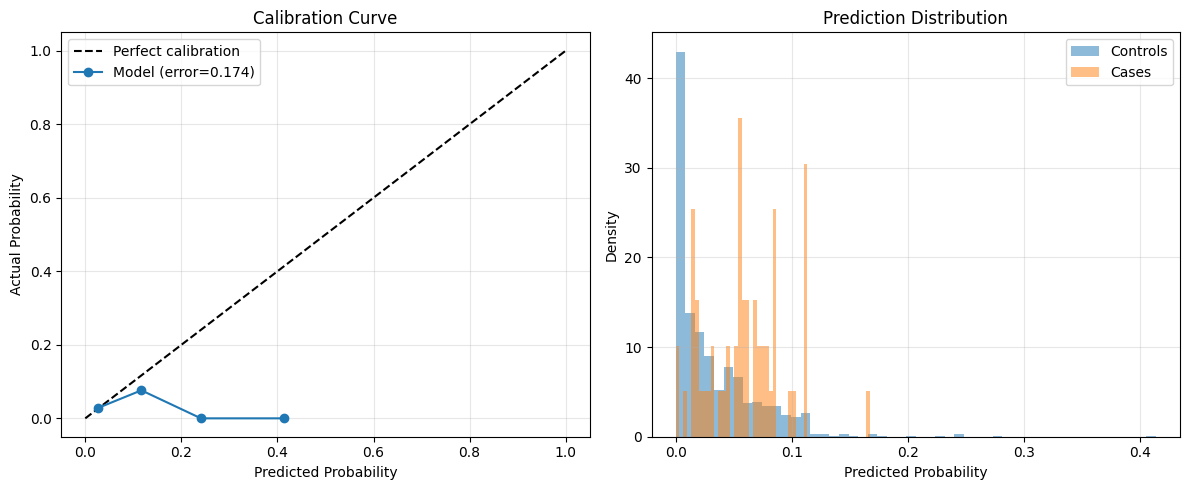

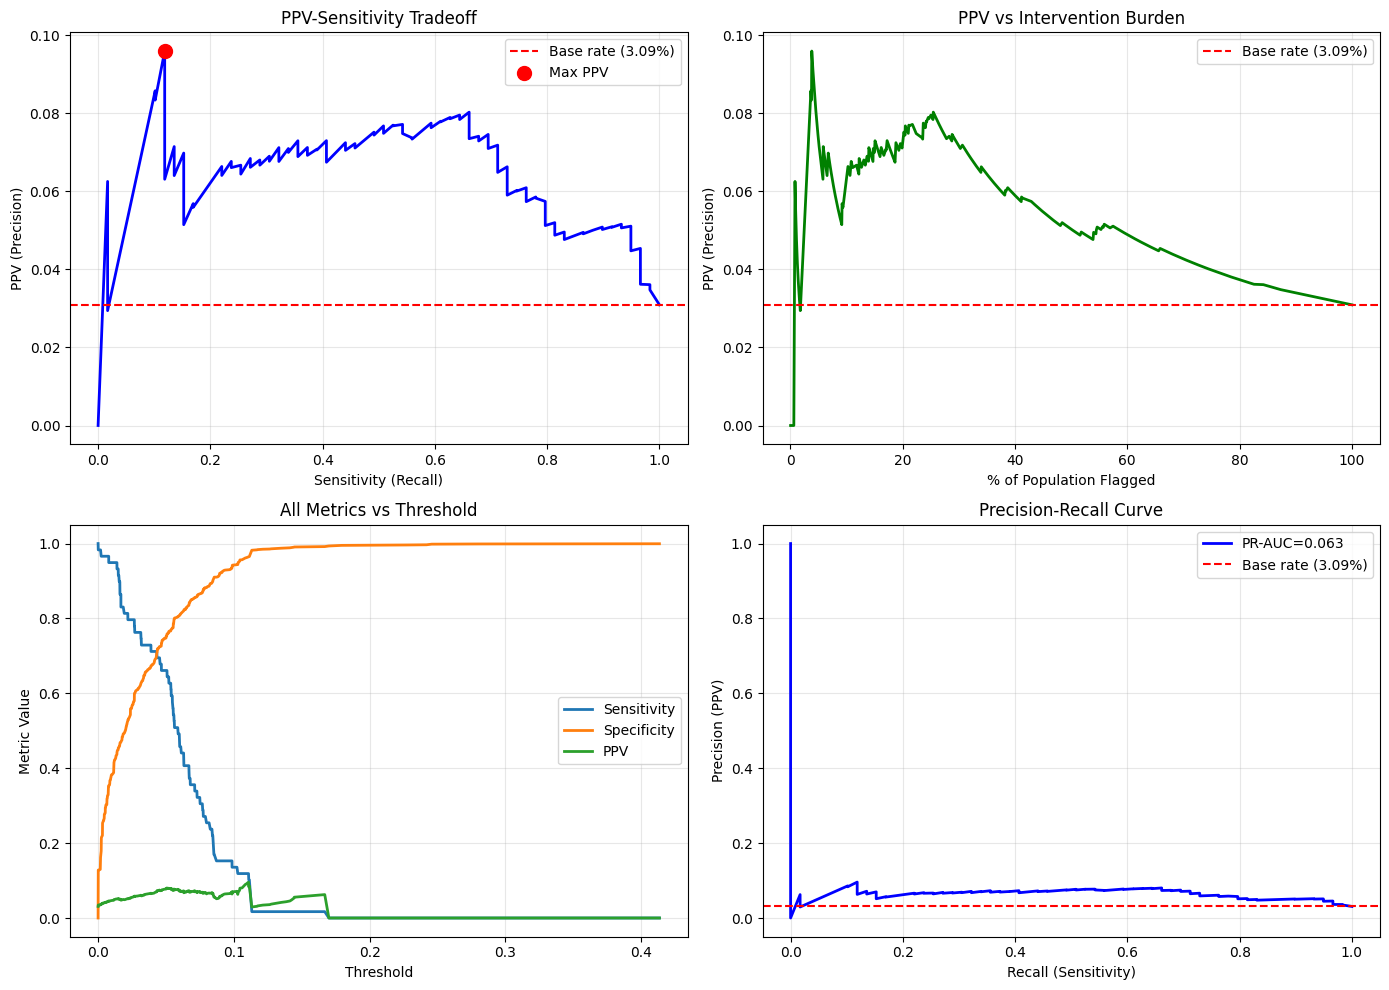

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.calibration import calibration_curve

"""
PPV CEILING DIAGNOSTICS

When maximum PPV is low (e.g., 11%), we need to understand WHY.
This code helps diagnose the fundamental limitations and identify improvement strategies.
"""

# ============================================================================
# 1. CALIBRATION ANALYSIS
# ============================================================================

def analyze_calibration(y_true, y_pred_proba, n_bins=10):
    """
    Check if model is well-calibrated
    Poor calibration = model confidence doesn't match actual risk
    """

    print("="*80)
    print("CALIBRATION ANALYSIS")
    print("="*80)
    print("Checking if predicted probabilities match actual risk...")

    # Get calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)

    # Calculate calibration error
    calib_error = np.mean(np.abs(prob_true - prob_pred))

    print(f"\nMean Calibration Error: {calib_error:.4f}")
    if calib_error < 0.05:
        print("✓ Good calibration - predicted probabilities are reliable")
    elif calib_error < 0.10:
        print("⚠ Moderate calibration - some miscalibration present")
    else:
        print("✗ Poor calibration - predicted probabilities are unreliable")
        print("  → Consider: Platt scaling, isotonic regression, or recalibration")

    # Plot calibration curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Calibration plot
    ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax1.plot(prob_pred, prob_true, 'o-', label=f'Model (error={calib_error:.3f})')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Actual Probability')
    ax1.set_title('Calibration Curve')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Distribution of predictions
    ax2.hist(y_pred_proba[y_true==0], bins=50, alpha=0.5, label='Controls', density=True)
    ax2.hist(y_pred_proba[y_true==1], bins=50, alpha=0.5, label='Cases', density=True)
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Density')
    ax2.set_title('Prediction Distribution')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('calibration_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: calibration_analysis.png")

    return calib_error, prob_true, prob_pred

# ============================================================================
# 2. SEPARATION ANALYSIS
# ============================================================================

def analyze_separation(y_true, y_pred_proba):
    """
    Check if model separates cases from controls
    Poor separation = features don't distinguish well
    """

    print("\n" + "="*80)
    print("SEPARATION ANALYSIS")
    print("="*80)
    print("Checking if model distinguishes cases from controls...")

    # Get distributions
    controls_probs = y_pred_proba[y_true == 0]
    cases_probs = y_pred_proba[y_true == 1]

    # Calculate separation metrics
    mean_control = controls_probs.mean()
    mean_case = cases_probs.mean()
    std_control = controls_probs.std()
    std_case = cases_probs.std()

    # Cohen's d (effect size)
    pooled_std = np.sqrt((std_control**2 + std_case**2) / 2)
    cohens_d = (mean_case - mean_control) / pooled_std if pooled_std > 0 else 0

    # Overlap coefficient
    overlap = max(0, min(mean_control + std_control, mean_case + std_case) -
                     max(mean_control - std_control, mean_case - std_case))
    overlap_pct = overlap / (2 * pooled_std) if pooled_std > 0 else 1.0

    print(f"\nControl Distribution:")
    print(f"  Mean:  {mean_control:.4f}")
    print(f"  Std:   {std_control:.4f}")
    print(f"  Range: [{controls_probs.min():.4f}, {controls_probs.max():.4f}]")

    print(f"\nCase Distribution:")
    print(f"  Mean:  {mean_case:.4f}")
    print(f"  Std:   {std_case:.4f}")
    print(f"  Range: [{cases_probs.min():.4f}, {cases_probs.max():.4f}]")

    print(f"\nSeparation Metrics:")
    print(f"  Cohen's d:       {cohens_d:.4f}")
    if cohens_d < 0.5:
        print("  → ✗ SMALL effect size - poor separation")
        print("     Problem: Features don't strongly distinguish cases from controls")
        print("     Solution: Need better/more predictive features")
    elif cohens_d < 0.8:
        print("  → ⚠ MEDIUM effect size - moderate separation")
        print("     Problem: Some separation, but substantial overlap")
        print("     Solution: Feature engineering, interaction terms, more data")
    else:
        print("  → ✓ LARGE effect size - good separation")

    print(f"\n  Distribution overlap: {overlap_pct:.1%}")
    if overlap_pct > 0.6:
        print("  → ✗ HIGH overlap - distributions largely overlap")
        print("     This explains low maximum PPV")

    return cohens_d, overlap_pct

# ============================================================================
# 3. THRESHOLD ANALYSIS
# ============================================================================

def analyze_threshold_tradeoffs(y_true, y_pred_proba, base_rate=None):
    """
    Show full PPV vs Sensitivity tradeoff curve
    Reveals maximum achievable PPV
    """

    if base_rate is None:
        base_rate = (y_true == 1).sum() / len(y_true)

    print("\n" + "="*80)
    print("THRESHOLD TRADEOFF ANALYSIS")
    print("="*80)
    print(f"Base rate: {base_rate:.2%}")

    # Calculate metrics at all thresholds
    thresholds = np.unique(y_pred_proba)
    thresholds = np.sort(thresholds)

    results = []
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
        npv = tn/(tn+fn) if (tn+fn)>0 else 0.0
        n_flagged = tp + fp
        flag_rate = n_flagged / len(y_true)

        results.append({
            'threshold': t,
            'sensitivity': sens,
            'specificity': spec,
            'ppv': ppv,
            'npv': npv,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn,
            'n_flagged': n_flagged,
            'flag_rate': flag_rate
        })

    df = pd.DataFrame(results)

    # Find maximum PPV
    max_ppv_row = df.loc[df['ppv'].idxmax()]
    print(f"\n🔴 MAXIMUM ACHIEVABLE PPV: {max_ppv_row['ppv']:.4f}")
    print(f"   At threshold:     {max_ppv_row['threshold']:.4f}")
    print(f"   Sensitivity:      {max_ppv_row['sensitivity']:.4f}")
    print(f"   Specificity:      {max_ppv_row['specificity']:.4f}")
    print(f"   Flagging rate:    {max_ppv_row['flag_rate']:.2%} of population")
    print(f"   TP={int(max_ppv_row['tp'])}, FP={int(max_ppv_row['fp'])}, "
          f"FN={int(max_ppv_row['fn'])}, TN={int(max_ppv_row['tn'])}")

    # Find reasonable operating points
    print("\n" + "-"*80)
    print("OPERATING POINT OPTIONS:")
    print("-"*80)

    # Option 1: 50% sensitivity
    df_50sens = df[df['sensitivity'] >= 0.50]
    if len(df_50sens) > 0:
        best_50 = df_50sens.loc[df_50sens['ppv'].idxmax()]
        print(f"\n1. Maintain ≥50% Sensitivity:")
        print(f"   PPV:          {best_50['ppv']:.4f}")
        print(f"   Sensitivity:  {best_50['sensitivity']:.4f}")
        print(f"   Specificity:  {best_50['specificity']:.4f}")
        print(f"   Flag rate:    {best_50['flag_rate']:.2%}")
        print(f"   Interpretation: Out of 100 flagged, ~{int(best_50['ppv']*100)} are true cases")

    # Option 2: Maximize F1
    df['f1'] = 2 * (df['ppv'] * df['sensitivity']) / (df['ppv'] + df['sensitivity'])
    df['f1'] = df['f1'].fillna(0)
    best_f1 = df.loc[df['f1'].idxmax()]
    print(f"\n2. Maximize F1 Score (Balance PPV and Sensitivity):")
    print(f"   PPV:          {best_f1['ppv']:.4f}")
    print(f"   Sensitivity:  {best_f1['sensitivity']:.4f}")
    print(f"   Specificity:  {best_f1['specificity']:.4f}")
    print(f"   Flag rate:    {best_f1['flag_rate']:.2%}")
    print(f"   F1 score:     {best_f1['f1']:.4f}")

    # Option 3: Maximize Youden's J
    df['youden_j'] = df['sensitivity'] + df['specificity'] - 1
    best_j = df.loc[df['youden_j'].idxmax()]
    print(f"\n3. Maximize Youden's J (Sens + Spec - 1):")
    print(f"   PPV:          {best_j['ppv']:.4f}")
    print(f"   Sensitivity:  {best_j['sensitivity']:.4f}")
    print(f"   Specificity:  {best_j['specificity']:.4f}")
    print(f"   Flag rate:    {best_j['flag_rate']:.2%}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. PPV vs Sensitivity tradeoff
    ax = axes[0, 0]
    ax.plot(df['sensitivity'], df['ppv'], 'b-', linewidth=2)
    ax.axhline(y=base_rate, color='r', linestyle='--', label=f'Base rate ({base_rate:.2%})')
    ax.scatter([max_ppv_row['sensitivity']], [max_ppv_row['ppv']],
              color='red', s=100, zorder=5, label='Max PPV')
    ax.set_xlabel('Sensitivity (Recall)')
    ax.set_ylabel('PPV (Precision)')
    ax.set_title('PPV-Sensitivity Tradeoff')
    ax.legend()
    ax.grid(alpha=0.3)

    # 2. PPV vs Flagging Rate
    ax = axes[0, 1]
    ax.plot(df['flag_rate']*100, df['ppv'], 'g-', linewidth=2)
    ax.axhline(y=base_rate, color='r', linestyle='--', label=f'Base rate ({base_rate:.2%})')
    ax.set_xlabel('% of Population Flagged')
    ax.set_ylabel('PPV (Precision)')
    ax.set_title('PPV vs Intervention Burden')
    ax.legend()
    ax.grid(alpha=0.3)

    # 3. All metrics vs threshold
    ax = axes[1, 0]
    ax.plot(df['threshold'], df['sensitivity'], label='Sensitivity', linewidth=2)
    ax.plot(df['threshold'], df['specificity'], label='Specificity', linewidth=2)
    ax.plot(df['threshold'], df['ppv'], label='PPV', linewidth=2)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Metric Value')
    ax.set_title('All Metrics vs Threshold')
    ax.legend()
    ax.grid(alpha=0.3)

    # 4. Precision-Recall curve
    ax = axes[1, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, 'b-', linewidth=2, label=f'PR-AUC={pr_auc:.3f}')
    ax.axhline(y=base_rate, color='r', linestyle='--', label=f'Base rate ({base_rate:.2%})')
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision (PPV)')
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('threshold_tradeoffs.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: threshold_tradeoffs.png")

    return df, max_ppv_row

# ============================================================================
# 4. FEATURE QUALITY ASSESSMENT
# ============================================================================

def assess_feature_quality(X, y, FEATURES, model, top_n=10):
    """
    Evaluate individual feature discriminative power
    Identifies which features contribute most to prediction
    """

    print("\n" + "="*80)
    print("FEATURE QUALITY ASSESSMENT")
    print("="*80)
    print("Evaluating individual feature predictive power...")

    from sklearn.metrics import roc_auc_score
    from scipy import stats

    feature_stats = []

    for feat in FEATURES:
        # Get non-missing values
        mask = ~X[feat].isna()
        X_feat = X.loc[mask, feat].values
        y_feat = y[mask]

        if len(X_feat) == 0:
            continue

        # Calculate univariate AUC
        try:
            auc_score = roc_auc_score(y_feat, X_feat)
            # Convert to directional AUC (>0.5)
            auc_score = max(auc_score, 1 - auc_score)
        except:
            auc_score = 0.5

        # Calculate effect size (Cohen's d)
        x_control = X_feat[y_feat == 0]
        x_case = X_feat[y_feat == 1]

        mean_diff = x_case.mean() - x_control.mean()
        pooled_std = np.sqrt((x_control.var() + x_case.var()) / 2)
        cohens_d = abs(mean_diff / pooled_std) if pooled_std > 0 else 0

        # T-test
        try:
            t_stat, p_value = stats.ttest_ind(x_case, x_control)
            p_value = abs(p_value)
        except:
            p_value = 1.0

        feature_stats.append({
            'feature': feat,
            'auc': auc_score,
            'cohens_d': cohens_d,
            'p_value': p_value,
            'mean_control': x_control.mean(),
            'mean_case': x_case.mean(),
            'std_control': x_control.std(),
            'std_case': x_case.std()
        })

    df_features = pd.DataFrame(feature_stats).sort_values('auc', ascending=False)

    print(f"\nTop {top_n} Features by Univariate AUC:")
    print("-"*80)
    print(f"{'Feature':<15} {'AUC':>8} {'Cohen\'s d':>10} {'p-value':>10} {'Quality'}")
    print("-"*80)

    for _, row in df_features.head(top_n).iterrows():
        # Quality assessment
        if row['auc'] > 0.7 and row['cohens_d'] > 0.5:
            quality = "✓ Strong"
        elif row['auc'] > 0.6 and row['cohens_d'] > 0.3:
            quality = "⚠ Moderate"
        else:
            quality = "✗ Weak"

        print(f"{row['feature']:<15} {row['auc']:>8.4f} {row['cohens_d']:>10.4f} "
              f"{row['p_value']:>10.4f} {quality}")

    # Overall assessment
    strong_features = (df_features['auc'] > 0.7).sum()
    moderate_features = ((df_features['auc'] > 0.6) & (df_features['auc'] <= 0.7)).sum()
    weak_features = (df_features['auc'] <= 0.6).sum()

    print("\n" + "="*80)
    print("FEATURE QUALITY SUMMARY")
    print("="*80)
    print(f"Strong features (AUC > 0.7):    {strong_features}")
    print(f"Moderate features (AUC 0.6-0.7): {moderate_features}")
    print(f"Weak features (AUC ≤ 0.6):       {weak_features}")

    if strong_features == 0:
        print("\n⚠️ WARNING: No individual features have strong predictive power (AUC > 0.7)")
        print("   This explains the low maximum PPV.")
        print("\n   Recommendations:")
        print("   1. Collect additional/different features")
        print("   2. Create interaction terms between features")
        print("   3. Consider nonlinear transformations")
        print("   4. Use domain knowledge to engineer better features")

    return df_features

# ============================================================================
# 5. COMPREHENSIVE DIAGNOSTIC
# ============================================================================

def diagnose_ppv_ceiling(X, y, FEATURES, model, y_pred_proba):
    """
    Run all diagnostics to understand PPV limitations

    Parameters:
    -----------
    X : DataFrame
        Features
    y : array-like
        True labels
    FEATURES : list
        Feature names
    model : fitted model
        Trained model
    y_pred_proba : array-like
        Predicted probabilities from model
    """

    print("\n" + "#"*80)
    print("# COMPREHENSIVE PPV CEILING DIAGNOSTIC")
    print("#"*80)

    # 1. Calibration
    calib_error, prob_true, prob_pred = analyze_calibration(y, y_pred_proba)

    # 2. Separation
    cohens_d, overlap = analyze_separation(y, y_pred_proba)

    # 3. Threshold analysis
    df_thresholds, max_ppv_row = analyze_threshold_tradeoffs(y, y_pred_proba)

    # 4. Feature quality
    df_features = assess_feature_quality(X, y, FEATURES, model)

    # ========================================================================
    # FINAL DIAGNOSIS
    # ========================================================================
    print("\n" + "="*80)
    print("🔍 DIAGNOSTIC SUMMARY & RECOMMENDATIONS")
    print("="*80)

    max_ppv = max_ppv_row['ppv']
    base_rate = (y == 1).sum() / len(y)

    print(f"\n📊 Key Findings:")
    print(f"   Base rate:        {base_rate:.2%}")
    print(f"   Maximum PPV:      {max_ppv:.2%}")
    print(f"   PPV lift:         {max_ppv/base_rate:.2f}x over base rate")
    print(f"   Calibration error: {calib_error:.4f}")
    print(f"   Separation (Cohen's d): {cohens_d:.4f}")

    # Diagnosis
    print(f"\n🔬 ROOT CAUSE ANALYSIS:")

    issues = []

    if cohens_d < 0.5:
        issues.append("WEAK_SEPARATION")
        print("\n   ❌ WEAK SEPARATION (Cohen's d < 0.5)")
        print("      Problem: Cases and controls have very similar feature values")
        print("      Impact:  Model cannot distinguish them reliably → Low PPV ceiling")

    if df_features['auc'].max() < 0.7:
        issues.append("WEAK_FEATURES")
        print("\n   ❌ WEAK INDIVIDUAL FEATURES (Max AUC < 0.7)")
        print("      Problem: No single feature strongly predicts the outcome")
        print("      Impact:  Even combinations have limited predictive power → Low PPV")

    if calib_error > 0.1:
        issues.append("POOR_CALIBRATION")
        print("\n   ⚠️  POOR CALIBRATION (Error > 0.1)")
        print("      Problem: Predicted probabilities don't match actual risk")
        print("      Impact:  Can be fixed with recalibration (won't increase max PPV much)")

    if max_ppv / base_rate < 3:
        issues.append("LIMITED_LIFT")
        print(f"\n   ❌ LIMITED LIFT ({max_ppv/base_rate:.1f}x)")
        print("      Problem: Model barely improves over base rate prediction")
        print("      Impact:  Features lack sufficient predictive information")

    if not issues:
        print("\n   ✓ No major issues detected - model is performing reasonably given the data")

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")

    if "WEAK_FEATURES" in issues or "WEAK_SEPARATION" in issues:
        print("\n   🎯 HIGH PRIORITY - Improve Feature Quality:")
        print("      1. Collect additional predictive features:")
        print("         • Biological markers (if applicable)")
        print("         • Historical/longitudinal data")
        print("         • Contextual/environmental factors")
        print("      2. Feature engineering:")
        print("         • Create interaction terms (especially from SHAP interactions)")
        print("         • Polynomial/nonlinear transformations")
        print("         • Time-based aggregations if longitudinal data available")
        print("      3. Consider different measurement instruments")
        print("         • Current measures may lack sensitivity/specificity")

    if "LIMITED_LIFT" in issues:
        print("\n   📊 REALISTIC EXPECTATIONS:")
        print(f"      • With current features, {max_ppv:.1%} PPV may be the ceiling")
        print("      • This represents a {:.1f}x improvement over base rate".format(max_ppv/base_rate))
        print("      • Consider whether this level of prediction is 'good enough':")
        print(f"        - For screening: Flag ~{max_ppv_row['flag_rate']:.1%} of population")
        print(f"        - Catch ~{max_ppv_row['sensitivity']:.1%} of cases")
        print(f"        - {int(max_ppv*100)} out of 100 flagged are true cases")

    if "POOR_CALIBRATION" in issues:
        print("\n   🔧 TECHNICAL FIXES:")
        print("      • Apply probability calibration (Platt scaling, isotonic regression)")
        print("      • This won't increase max PPV but improves probability interpretation")

    print("\n   🤔 ALTERNATIVE STRATEGIES:")
    print("      1. Reframe as risk stratification (high/medium/low) instead of binary")
    print("      2. Use for enriched sampling in research studies")
    print("      3. Combine with other data sources (e.g., clinician judgment)")
    print("      4. Focus on highest-risk individuals only (sacrifice sensitivity for PPV)")

    return {
        'max_ppv': max_ppv,
        'base_rate': base_rate,
        'cohens_d': cohens_d,
        'calibration_error': calib_error,
        'feature_quality': df_features,
        'threshold_analysis': df_thresholds,
        'issues': issues
    }

# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# After training your model and getting predictions:

# You have this from tune_all_models():
# results = {'LogisticRegression': {...}, 'RandomForest': {...}, 'XGBoost': {...}}

# Option 1: Diagnose the best model (let's say XGBoost)


from sklearn.model_selection import cross_val_predict

calibrated_model = CalibratedClassifierCV(results['XGBoost']['final_pipeline'],
    method='isotonic', cv=5)
# Use nested CV to get truly unseen predictions
y_pred = cross_val_predict(calibrated_model, X, y, cv=5, method='predict_proba')[:, 1]

# Re-run diagnostics
diagnostic_results_cal = diagnose_ppv_ceiling(
    X, y, FEATURES,
    model=calibrated_model,
    y_pred_proba=y_pred
)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

"""
FEATURE ENGINEERING PIPELINE

Goal: Improve from 8% PPV to 10-12% PPV through strategic feature engineering

Strategy:
1. Create interaction terms from SHAP analysis
2. Add polynomial features for top predictors
3. Create domain-informed composite features
4. Test incrementally to avoid overfitting
5. Use proper nested CV to ensure no leakage
"""

# ============================================================================
# BASELINE: ORIGINAL FEATURES
# ============================================================================

def evaluate_features(X_data, y, features=None, model_params=None, label="Model"):
    """
    Evaluate a feature set with proper CV (no leakage)

    Parameters:
    -----------
    X_data : DataFrame
        DataFrame that already contains all features (including engineered ones)
    y : array-like
        Target
    features : list or None
        Feature names to use. If None, use all columns in X_data

    Returns PPV at 50% sensitivity
    """
    if features is None:
        features = X_data.columns.tolist()

    if model_params is None:
        n_neg = (y == 0).sum()
        n_pos = (y == 1).sum()
        scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

        model_params = {
            'scale_pos_weight': scale_pos_weight,
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42,
            'eval_metric': 'logloss'
        }

    # Build model
    model = XGBClassifier(**model_params)

    # Preprocessing - select features from X_data
    imputer = SimpleImputer(strategy="median")
    X_processed = pd.DataFrame(
        imputer.fit_transform(X_data[features]),
        columns=features,
        index=X_data.index
    )

    # Proper CV predictions
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, X_processed, y, cv=cv,
                                     method='predict_proba', n_jobs=-1)[:, 1]

    # Find PPV at 50% sensitivity
    thresholds = np.unique(y_pred_proba)
    best_ppv = 0
    best_sens = 0
    best_spec = 0
    best_thresh = 0.5

    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()

        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0

        # Find threshold closest to 50% sensitivity
        if abs(sens - 0.5) < 0.1 and ppv > best_ppv:
            best_ppv = ppv
            best_sens = sens
            best_spec = spec
            best_thresh = t

    # Also get max PPV
    max_ppv = 0
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
        ppv = tp/(tp+fp) if (tp+fp)>0 else 0.0
        max_ppv = max(max_ppv, ppv)

    # Calculate Cohen's d
    controls = y_pred_proba[y == 0]
    cases = y_pred_proba[y == 1]
    cohens_d = (cases.mean() - controls.mean()) / np.sqrt((cases.var() + controls.var())/2)

    return {
        'label': label,
        'n_features': len(features),
        'ppv_at_50sens': best_ppv,
        'sensitivity': best_sens,
        'specificity': best_spec,
        'max_ppv': max_ppv,
        'cohens_d': cohens_d,
        'y_pred_proba': y_pred_proba,
        'features': features,
        'X_data': X_data  # Include the DataFrame for later use
    }

# ============================================================================
# FEATURE ENGINEERING FUNCTIONS
# ============================================================================

def add_interactions(X, base_features):
    """
    Add interaction terms based on SHAP analysis

    Top interactions from SHAP:
    1. w1tii × w1dres (318.67)
    2. w1dep × FEAR_w1 (308.37)
    3. w1tii × w1dep (236.64)
    4. w1tii × w1bs (234.82)
    5. w1dres × FEAR_w1 (231.07)
    """
    X_new = X[base_features].copy()

    # Top 5 interactions
    interaction_pairs = [
        ('w1tii', 'w1dres', 'tii_x_dres'),
        ('w1dep', 'FEAR_w1', 'dep_x_fear'),
        ('w1tii', 'w1dep', 'tii_x_dep'),
        ('w1tii', 'w1bs', 'tii_x_bs'),
        ('w1dres', 'FEAR_w1', 'dres_x_fear'),
    ]

    for feat1, feat2, name in interaction_pairs:
        if feat1 in base_features and feat2 in base_features:
            X_new[name] = X[feat1] * X[feat2]

    return X_new

def add_polynomials(X, base_features):
    """
    Add polynomial features for top predictors

    Top features by univariate AUC:
    - w1dep (0.70)
    - WSO_w1 (0.70)
    - FEAR_w1 (0.70)
    """
    X_new = X[base_features].copy()

    # Squared terms for top 3 features
    top_features = ['w1dep', 'WSO_w1', 'FEAR_w1']

    for feat in top_features:
        if feat in base_features:
            X_new[f'{feat}_sq'] = X[feat] ** 2

    return X_new

def add_ratios(X, base_features):
    """
    Add ratio features (domain-informed)

    Rationale:
    - Restraint relative to body dissatisfaction
    - Fear relative to depression
    - Thin ideal relative to actual behaviors
    """
    X_new = X[base_features].copy()

    # Ratio features (add small constant to avoid division by zero)
    eps = 0.01

    if 'w1dres' in base_features and 'w1bs' in base_features:
        X_new['dres_per_bs'] = X['w1dres'] / (X['w1bs'] + eps)

    if 'FEAR_w1' in base_features and 'w1dep' in base_features:
        X_new['fear_per_dep'] = X['FEAR_w1'] / (X['w1dep'] + eps)

    if 'w1tii' in base_features and 'w1dres' in base_features:
        X_new['tii_per_dres'] = X['w1tii'] / (X['w1dres'] + eps)

    return X_new

def add_composites(X, base_features):
    """
    Add composite features (sum/mean of related constructs)

    Domains:
    - Body image: w1bs + w1tii + WSO_w1
    - Negative affect: w1dep + FEAR_w1
    - Eating pathology: w1dres + CB_w1
    """
    X_new = X[base_features].copy()

    # Body image composite
    body_features = [f for f in ['w1bs', 'w1tii', 'WSO_w1'] if f in base_features]
    if len(body_features) > 1:
        X_new['body_image_composite'] = X[body_features].mean(axis=1)

    # Negative affect composite
    affect_features = [f for f in ['w1dep', 'FEAR_w1'] if f in base_features]
    if len(affect_features) > 1:
        X_new['negative_affect_composite'] = X[affect_features].mean(axis=1)

    # Eating pathology composite
    eating_features = [f for f in ['w1dres', 'CB_w1'] if f in base_features]
    if len(eating_features) > 1:
        X_new['eating_pathology_composite'] = X[eating_features].mean(axis=1)

    return X_new

def add_all_engineered_features(X, base_features):
    """
    Add all engineered features at once
    """
    X_new = X[base_features].copy()

    # Add each type
    X_inter = add_interactions(X, base_features)
    X_poly = add_polynomials(X, base_features)
    X_ratio = add_ratios(X, base_features)
    X_comp = add_composites(X, base_features)

    # Combine (keep only new features)
    new_features = []

    for col in X_inter.columns:
        if col not in base_features:
            X_new[col] = X_inter[col]
            new_features.append(col)

    for col in X_poly.columns:
        if col not in base_features and col not in X_new.columns:
            X_new[col] = X_poly[col]
            new_features.append(col)

    for col in X_ratio.columns:
        if col not in base_features and col not in X_new.columns:
            X_new[col] = X_ratio[col]
            new_features.append(col)

    for col in X_comp.columns:
        if col not in base_features and col not in X_new.columns:
            X_new[col] = X_comp[col]
            new_features.append(col)

    return X_new, new_features

# ============================================================================
# INCREMENTAL FEATURE ENGINEERING EXPERIMENT
# ============================================================================

def feature_engineering_experiment(X, y, base_features):
    """
    Test feature engineering strategies incrementally

    Returns comparison of different feature sets
    """

    print("="*80)
    print("FEATURE ENGINEERING EXPERIMENT")
    print("="*80)
    print(f"Base features: {len(base_features)}")
    print(f"Dataset: {len(X)} samples, {(y==0).sum()} controls, {(y==1).sum()} cases")
    print("="*80)
    print()

    results = []

    # ========================================================================
    # 1. BASELINE (Original features only)
    # ========================================================================
    print("1. BASELINE: Original Features")
    print("-"*80)

    X_base = X[base_features].copy()
    result_base = evaluate_features(X_base, y, base_features, label="Baseline")
    results.append(result_base)

    print(f"   Features:     {result_base['n_features']}")
    print(f"   PPV @ 50% sens: {result_base['ppv_at_50sens']:.4f}")
    print(f"   Max PPV:        {result_base['max_ppv']:.4f}")
    print(f"   Cohen's d:      {result_base['cohens_d']:.4f}")
    print()

    # ========================================================================
    # 2. ADD INTERACTIONS (SHAP-based)
    # ========================================================================
    print("2. ADD INTERACTIONS (Top 5 from SHAP)")
    print("-"*80)

    X_inter = add_interactions(X, base_features)
    features_inter = X_inter.columns.tolist()

    result_inter = evaluate_features(X_inter, y, features_inter, label="+ Interactions")
    results.append(result_inter)

    improvement = result_inter['ppv_at_50sens'] - result_base['ppv_at_50sens']
    print(f"   Features:     {result_inter['n_features']} (+{result_inter['n_features'] - result_base['n_features']})")
    print(f"   PPV @ 50% sens: {result_inter['ppv_at_50sens']:.4f} ({improvement:+.4f})")
    print(f"   Max PPV:        {result_inter['max_ppv']:.4f}")
    print(f"   Cohen's d:      {result_inter['cohens_d']:.4f}")

    if improvement > 0.01:
        print("   ✓ Significant improvement!")
    elif improvement > 0:
        print("   ⚠ Marginal improvement")
    else:
        print("   ✗ No improvement")
    print()

    # ========================================================================
    # 3. ADD POLYNOMIALS
    # ========================================================================
    print("3. ADD POLYNOMIALS (Top 3 features squared)")
    print("-"*80)

    # Start from X_inter
    X_poly = add_polynomials(X_inter, features_inter)
    features_poly = X_poly.columns.tolist()

    result_poly = evaluate_features(X_poly, y, features_poly, label="+ Polynomials")
    results.append(result_poly)

    improvement = result_poly['ppv_at_50sens'] - result_inter['ppv_at_50sens']
    print(f"   Features:     {result_poly['n_features']} (+{result_poly['n_features'] - result_inter['n_features']})")
    print(f"   PPV @ 50% sens: {result_poly['ppv_at_50sens']:.4f} ({improvement:+.4f})")
    print(f"   Max PPV:        {result_poly['max_ppv']:.4f}")
    print(f"   Cohen's d:      {result_poly['cohens_d']:.4f}")

    if improvement > 0.01:
        print("   ✓ Significant improvement!")
    elif improvement > 0:
        print("   ⚠ Marginal improvement")
    else:
        print("   ✗ No improvement")
    print()

    # ========================================================================
    # 4. ADD RATIOS
    # ========================================================================
    print("4. ADD RATIOS (Domain-informed)")
    print("-"*80)

    # Start from X_poly
    X_ratio = add_ratios(X_poly, features_poly)
    features_ratio = X_ratio.columns.tolist()

    result_ratio = evaluate_features(X_ratio, y, features_ratio, label="+ Ratios")
    results.append(result_ratio)

    improvement = result_ratio['ppv_at_50sens'] - result_poly['ppv_at_50sens']
    print(f"   Features:     {result_ratio['n_features']} (+{result_ratio['n_features'] - result_poly['n_features']})")
    print(f"   PPV @ 50% sens: {result_ratio['ppv_at_50sens']:.4f} ({improvement:+.4f})")
    print(f"   Max PPV:        {result_ratio['max_ppv']:.4f}")
    print(f"   Cohen's d:      {result_ratio['cohens_d']:.4f}")

    if improvement > 0.01:
        print("   ✓ Significant improvement!")
    elif improvement > 0:
        print("   ⚠ Marginal improvement")
    else:
        print("   ✗ No improvement")
    print()

    # ========================================================================
    # 5. ADD COMPOSITES
    # ========================================================================
    print("5. ADD COMPOSITES (Sum of related constructs)")
    print("-"*80)

    # Start from X_ratio
    X_comp = add_composites(X_ratio, features_ratio)
    features_comp = X_comp.columns.tolist()

    result_comp = evaluate_features(X_comp, y, features_comp, label="+ Composites")
    results.append(result_comp)

    improvement = result_comp['ppv_at_50sens'] - result_ratio['ppv_at_50sens']
    print(f"   Features:     {result_comp['n_features']} (+{result_comp['n_features'] - result_ratio['n_features']})")
    print(f"   PPV @ 50% sens: {result_comp['ppv_at_50sens']:.4f} ({improvement:+.4f})")
    print(f"   Max PPV:        {result_comp['max_ppv']:.4f}")
    print(f"   Cohen's d:      {result_comp['cohens_d']:.4f}")

    if improvement > 0.01:
        print("   ✓ Significant improvement!")
    elif improvement > 0:
        print("   ⚠ Marginal improvement")
    else:
        print("   ✗ No improvement")
    print()

    # ========================================================================
    # SUMMARY
    # ========================================================================
    print("="*80)
    print("SUMMARY: FEATURE ENGINEERING RESULTS")
    print("="*80)
    print()

    df_results = pd.DataFrame([
        {
            'Strategy': r['label'],
            'N Features': r['n_features'],
            'PPV @ 50% Sens': f"{r['ppv_at_50sens']:.4f}",
            'Max PPV': f"{r['max_ppv']:.4f}",
            "Cohen's d": f"{r['cohens_d']:.4f}",
            'PPV_numeric': r['ppv_at_50sens']
        }
        for r in results
    ])

    print(df_results[['Strategy', 'N Features', 'PPV @ 50% Sens', 'Max PPV', "Cohen's d"]].to_string(index=False))
    print()

    # Find best
    best_idx = df_results['PPV_numeric'].idxmax()
    best = results[best_idx]
    baseline = results[0]

    total_improvement = best['ppv_at_50sens'] - baseline['ppv_at_50sens']
    pct_improvement = (total_improvement / baseline['ppv_at_50sens']) * 100

    print("-"*80)
    print(f"🏆 BEST MODEL: {best['label']}")
    print(f"   PPV @ 50% sens: {best['ppv_at_50sens']:.4f} (baseline: {baseline['ppv_at_50sens']:.4f})")
    print(f"   Absolute gain:  {total_improvement:+.4f}")
    print(f"   Relative gain:  {pct_improvement:+.1f}%")
    print(f"   Features:       {best['n_features']} (baseline: {baseline['n_features']})")
    print()

    if total_improvement > 0.02:
        print("✅ Feature engineering provided meaningful improvement!")
        print(f"   Went from {baseline['ppv_at_50sens']*100:.1f}% to {best['ppv_at_50sens']*100:.1f}% PPV")
    elif total_improvement > 0.01:
        print("⚠️  Feature engineering provided marginal improvement")
        print("   Consider if added complexity is worth it")
    else:
        print("❌ Feature engineering did not improve performance")
        print("   Stick with baseline features")

    # ========================================================================
    # OVERFITTING CHECK
    # ========================================================================
    print()
    print("="*80)
    print("OVERFITTING CHECK")
    print("="*80)

    # Check if performance degrades with more features
    ppv_values = [r['ppv_at_50sens'] for r in results]
    n_features = [r['n_features'] for r in results]

    # If PPV decreases as features increase, likely overfitting
    if len(ppv_values) >= 3:
        last_3 = ppv_values[-3:]
        if last_3[-1] < last_3[0]:
            print("⚠️  WARNING: PPV decreased with more features")
            print("   This suggests overfitting - consider using fewer features")
            print(f"   PPV trend: {last_3[0]:.4f} → {last_3[1]:.4f} → {last_3[2]:.4f}")
        else:
            print("✓ No obvious overfitting detected")
            print(f"   PPV trend: {last_3[0]:.4f} → {last_3[1]:.4f} → {last_3[2]:.4f}")

    print()
    print("="*80)
    print("RECOMMENDATION")
    print("="*80)

    if total_improvement > 0.02 and best['n_features'] < baseline['n_features'] * 2:
        print(f"""
✅ USE ENGINEERED FEATURES: {best['label']}

Your final feature set:
- {best['n_features']} features (vs {baseline['n_features']} baseline)
- PPV: {best['ppv_at_50sens']:.1%} (vs {baseline['ppv_at_50sens']:.1%} baseline)
- {pct_improvement:.0f}% relative improvement

This is meaningful and not obviously overfit.
        """)
    else:
        print(f"""
⚠️  STICK WITH BASELINE FEATURES

Feature engineering didn't provide enough improvement to justify complexity.
- Improvement: only {total_improvement:.1%} ({pct_improvement:.0f}%)
- Risk of overfitting with {best['n_features']} features on 60 cases

Use original {baseline['n_features']} features for final model.
        """)

    return {
        'results': results,
        'best': best,
        'baseline': baseline,
        'improvement': total_improvement,
        'df_summary': df_results,
        'X_best': best['X_data'],  # DataFrame with best feature set
        'best_feature_names': best['features']
    }

# ============================================================================
# USAGE
# ============================================================================

# Run the experiment
experiment_results = feature_engineering_experiment(X, y, FEATURES)

# Access results:
# - experiment_results['best']: Best performing feature set info
# - experiment_results['X_best']: DataFrame with best features
# - experiment_results['best_feature_names']: List of best feature names

# Example: Use the best features for final model
# X_final = experiment_results['X_best']
# best_features = experiment_results['best_feature_names']

FEATURE ENGINEERING EXPERIMENT
Base features: 8
Dataset: 1909 samples, 1850 controls, 59 cases

1. BASELINE: Original Features
--------------------------------------------------------------------------------
   Features:     8
   PPV @ 50% sens: 0.0875
   Max PPV:        0.3333
   Cohen's d:      0.4572

2. ADD INTERACTIONS (Top 5 from SHAP)
--------------------------------------------------------------------------------
   Features:     13 (+5)
   PPV @ 50% sens: 0.0846 (-0.0029)
   Max PPV:        0.0880
   Cohen's d:      0.3165
   ✗ No improvement

3. ADD POLYNOMIALS (Top 3 features squared)
--------------------------------------------------------------------------------
   Features:     16 (+3)
   PPV @ 50% sens: 0.0783 (-0.0063)
   Max PPV:        0.0783
   Cohen's d:      0.2828
   ✗ No improvement

4. ADD RATIOS (Domain-informed)
--------------------------------------------------------------------------------
   Features:     19 (+3)
   PPV @ 50% sens: 0.0713 (-0.0070)
   Max P

# CUI evaluator

In [ ]:
# Compute simple counts (Total Cases, TP, Total Non-Cases, TN) using the AutoTabPFN CV setup above

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

# Fallback: define pick_threshold_sensitivity if not already defined
try:
    pick_threshold_sensitivity
except NameError:
    def pick_threshold_sensitivity(y_true, p, sens_target=0.70):
        tgrid = np.unique(np.concatenate([p, [0.5]]))
        recs = []
        for t in tgrid:
            yhat = (p >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
            sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
            spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
            recs.append((t, sens, spec))
        arr = np.array(recs, dtype=[("t",float),("sens",float),("spec",float)])
        feas = arr[arr["sens"] >= sens_target]
        if len(feas):
            best = max(feas, key=lambda r: (r["t"], r["spec"]))  # largest t among feasible
            return float(best["t"])
        best = max(arr, key=lambda r: (r["sens"], r["spec"], r["t"]))
        return float(best["t"])

# Build the same pipeline used above
pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), FEATURES)], remainder="drop")
clf = AutoTabPFNClassifier(device="auto", max_time=600, random_state=42, ignore_pretraining_limits=True)
pipe = Pipeline([("pre", pre), ("clf", clf)])

# 10-fold CV to get out-of-fold predictions & per-fold sensitivity-targeted thresholds
SENS_TARGET = 0.70
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
yhat_all   = []

for tr, va in skf.split(X, y):
    pipe.fit(X.iloc[tr], y[tr])
    p_va = pipe.predict_proba(X.iloc[va])[:, 1]
    thr  = pick_threshold_sensitivity(y[va], p_va, sens_target=SENS_TARGET)
    yhat = (p_va >= thr).astype(int)
    y_true_all.append(y[va])
    yhat_all.append(yhat)

y_true_all = np.concatenate(y_true_all)
yhat_all   = np.concatenate(yhat_all)

tn, fp, fn, tp = confusion_matrix(y_true_all, yhat_all, labels=[0,1]).ravel()

print("a) YOUR Data Entry\n")
print("Counts")
print(f"Enter Total # Cases:\t{int((y_true_all==1).sum())}")
print(f"Enter # Cases Detected (aka True positives TP)\t{int(tp)}")
print(f"Enter Total # Non-Cases:\t{int((y_true_all==0).sum())}")
print(f"Enter # Non-Cases Detected (aka True negatives TN):\t{int(tn)}")


In [ ]:
import re
import pandas as pd

# Map disorders → their family/parental prefixes
DISORDERS = {
    "AN":  ["fan", "pan"],
    "BN":  ["fbn", "pbn"],
    "BED": ["fbe", "pbe"],
    "PU":  ["fpu", "ppu"],
}

def aggregate_prefix(prefix: str, frame: pd.DataFrame):
    """
    Collapse across all timepoints for `prefix` (e.g., fan.00, fan.01, ...).
    Returns: (agg_series, cols_used, counts_dict)
      - agg_series: per-row aggregated indicator (1 if ANY timepoint==1; 0 if observed but no 1; <NA> if all NaN)
      - counts_dict: {'1': n_pos, '0': n_zero, 'NaN': n_all_nan, 'invalid': n_rows_with_any_non_{0,1,NaN}}
    """
    pat = re.compile(rf"^{re.escape(prefix)}\.(\d+)$", flags=re.I)
    cols = [c for c in frame.columns if pat.match(c)]
    if not cols:
        return pd.Series(pd.NA, index=frame.index, dtype="Float64"), [], {"1":0,"0":0,"NaN":len(frame),"invalid":0}

    sub = frame[cols].apply(pd.to_numeric, errors="coerce")
    invalid_cell = sub.notna() & ~sub.isin([0, 1])
    invalid_row  = invalid_cell.any(axis=1)

    pos      = (sub == 1).any(axis=1)
    any_obs  = sub.notna().any(axis=1)
    zero     = any_obs & ~pos & ~invalid_row
    nan_only = ~any_obs & ~invalid_row

    agg = pd.Series(pd.NA, index=frame.index, dtype="Float64")
    agg.loc[pos]  = 1
    agg.loc[zero] = 0
    # rows with invalid values remain <NA> in agg; counted separately

    counts = {
        "1":       int(pos.sum()),
        "0":       int(zero.sum()),
        "NaN":     int(nan_only.sum()),
        "invalid": int(invalid_row.sum()),
    }
    return agg, cols, counts

N = len(df)
for disorder, prefs in DISORDERS.items():
    print(f"\n=== {disorder} ===")
    agg_per_prefix = {}
    for p in prefs:
        agg, cols, counts = aggregate_prefix(p, df)
        agg_per_prefix[p] = agg
        print(f"  {p}: cols={sorted(cols)}")
        print(f"    counts -> {counts}")

    # union across the two prefixes for this disorder (still 1 per row overall)
    if len(prefs) >= 2:
        u = agg_per_prefix[prefs[0]].fillna(0).eq(1) | agg_per_prefix[prefs[1]].fillna(0).eq(1)
    else:
        u = agg_per_prefix[prefs[0]].fillna(0).eq(1)
    print(f"  union_any==1 across {prefs}: {int(u.sum())} / {N}")


# brf prediction

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, \
                            roc_auc_score, average_precision_score, accuracy_score, precision_score
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

def pick_threshold_f1(y_true, p):
    # use PR curve thresholds; compute F1 at each operating point; pick argmax (tie-break to higher threshold)
    prec, rec, thr = precision_recall_curve(y_true, p)
    f1 = 2*prec*rec/(prec+rec + 1e-12)
    # precision_recall_curve returns thresholds for points 1..end; align sizes
    f1_thr = pd.DataFrame({"thr": np.r_[thr, thr[-1] if len(thr)>0 else 0.5], "f1": f1})
    best = f1_thr.iloc[f1_thr["f1"].values.argmax()]
    return float(best["thr"])

def full_metric_pack(y_true, p, thr):
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    sens = tp/(tp+fn) if (tp+fn)>0 else np.nan
    spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
    ppv  = precision_score(y_true, yhat, zero_division=0)
    npv  = tn/(tn+fn) if (tn+fn)>0 else np.nan
    return dict(
        accuracy = accuracy_score(y_true, yhat),
        sensitivity = sens, specificity = spec,
        ppv = ppv, npv = npv,
        f1 = f1_score(y_true, yhat, zero_division=0),
        auroc = roc_auc_score(y_true, p) if len(np.unique(y_true))==2 else np.nan,
        ap = average_precision_score(y_true, p),
        threshold = thr
    )


In [ ]:
# preprocessor + model
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np, pandas as pd

pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), FEATURES)], remainder="drop")

base = BalancedRandomForestClassifier(
    n_estimators=500, max_depth=None, min_samples_leaf=2,
    sampling_strategy="auto", replacement=True, n_jobs=-1, random_state=42
)

# comment next 3 lines if you prefer no calibration
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv=inner_cv)
clf = cal  # or: clf = base

pipe = Pipeline([("pre", pre), ("clf", clf)])

# OOF predictions via RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
oof_sum = np.zeros(len(y), dtype=float)
oof_cnt = np.zeros(len(y), dtype=int)

for tr, va in rskf.split(X, y):
    pipe.fit(X.iloc[tr], y[tr])
    p = pipe.predict_proba(X.iloc[va])[:, 1]
    oof_sum[va] += p
    oof_cnt[va] += 1

assert (oof_cnt > 0).all(), "Some rows never received an OOF prediction."
oof_p = oof_sum / oof_cnt
oof_y = y.copy()

# global F1-optimal threshold from OOF predictions
thr = pick_threshold_f1(oof_y, oof_p)

# final OOF metrics at fixed threshold
metrics = full_metric_pack(oof_y, oof_p, thr)
metrics["flagged_frac"] = float((oof_p >= thr).mean())

print("\nONSET-FULL-mBMI_ANYWAVE — OOF (5×10 RSKF) with F1-optimized global threshold")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")



ONSET-FULL-mBMI_ANYWAVE — OOF (5×10 RSKF) with F1-optimized global threshold
accuracy: 0.8738
sensitivity: 0.3559
specificity: 0.8903
ppv: 0.0938
npv: 0.9774
f1: 0.1484
auroc: 0.7687
ap: 0.0742
threshold: 0.0768
flagged_frac: 0.1173


In [ ]:
# Report simple counts from your current predictions (uses OOF if available)
import numpy as np
from sklearn.metrics import confusion_matrix

# pick data: prefer OOF; else fall back to (y, p, thr)
g = globals()
if all(k in g for k in ("oof_y", "oof_p", "thr")):
    y_true = np.asarray(g["oof_y"]).astype(int)
    scores = np.asarray(g["oof_p"], dtype=float)
    threshold = float(g["thr"])
elif all(k in g for k in ("y", "p", "thr")):
    y_true = np.asarray(g["y"]).astype(int)
    scores = np.asarray(g["p"], dtype=float)
    threshold = float(g["thr"])
else:
    raise RuntimeError("Define (oof_y, oof_p, thr) or (y, p, thr) before running this cell.")

yhat = (scores >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()

print("a) YOUR Data Entry\n")
print("Counts")
print(f"Enter Total # Cases:\t{int((y_true==1).sum())}")
print(f"Enter # Cases Detected (aka True positives TP)\t{int(tp)}")
print(f"Enter Total # Non-Cases:\t{int((y_true==0).sum())}")
print(f"Enter # Non-Cases Detected (aka True negatives TN):\t{int(tn)}")


a) YOUR Data Entry

Counts
Enter Total # Cases:	59
Enter # Cases Detected (aka True positives TP)	21
Enter Total # Non-Cases:	1850
Enter # Non-Cases Detected (aka True negatives TN):	1647


In [ ]:
from collections import Counter

def probast_quickcheck(X, y, cv, feature_names=None, model_name="BalancedRF+Cal", notes=None):
    feature_names = feature_names or list(X.columns)
    n, p = X.shape
    prev = float(np.mean(y))
    n_pos = int((y==1).sum())
    epv = n_pos / max(p,1)  # events-per-variable (crude)

    # fold class counts
    fold_rows = []
    for k, (tr, va) in enumerate(cv.split(np.zeros_like(y), y), 1):
        c_tr, c_va = Counter(y[tr]), Counter(y[va])
        fold_rows.append({"fold":k, "train_pos":c_tr.get(1,0), "val_pos":c_va.get(1,0)})
    fold_df = pd.DataFrame(fold_rows)

    # missingness
    miss = X.isna().mean().sort_values(ascending=False)
    high_miss = miss[miss>0.2]

    print("\n=== PROBAST Quickcheck ===")
    print(f"Participants: N={n}, prevalence={prev:.3f} ({n_pos} positives)")
    print(f"Predictors: p={p}, EPV={epv:.2f}  {'[FLAG: EPV<10]' if epv<10 else ''}")
    print("Outcome timing: baseline predictors; outcome = future ANYWAVE onset (no temporal leakage assumed).")
    print(f"Validation: {type(cv).__name__} with stratification; threshold chosen by max F1 on val fold; model={model_name}.")
    print("Missing data: median imputation within pipeline; features with >20% missing:")
    if len(high_miss):
        print(high_miss.round(3).to_string())
    else:
        print("  none >20%")
    print("\nFold positive counts (train/val):")
    print(fold_df.to_string(index=False))
    min_val_pos = fold_df["val_pos"].min()
    if min_val_pos < 5:
        print(f"[FLAG] Some validation folds have very few positives (min={min_val_pos}); expect high metric variance.")
    if notes:
        print("\nNotes:", notes)

# Example call:
probast_quickcheck(X, y, cv, feature_names=FEATURES,
                   model_name="BalancedRF (+/- isotonic), F1 threshold",
                   notes="Exclusions: fan.00 OR pan.00 OR baseline atypical AN; predictors restricted to pre-specified baseline risk/prodromals.")



=== PROBAST Quickcheck ===
Participants: N=1909, prevalence=0.031 (59 positives)
Predictors: p=12, EPV=4.92  [FLAG: EPV<10]
Outcome timing: baseline predictors; outcome = future ANYWAVE onset (no temporal leakage assumed).
Validation: StratifiedKFold with stratification; threshold chosen by max F1 on val fold; model=BalancedRF (+/- isotonic), F1 threshold.
Missing data: median imputation within pipeline; features with >20% missing:
  none >20%

Fold positive counts (train/val):
 fold  train_pos  val_pos
    1         53        6
    2         53        6
    3         53        6
    4         53        6
    5         53        6
    6         53        6
    7         53        6
    8         53        6
    9         53        6
   10         54        5

Notes: Exclusions: fan.00 OR pan.00 OR baseline atypical AN; predictors restricted to pre-specified baseline risk/prodromals.


# sanity check for overlapping counts

In [ ]:
# Exclude: any baseline (.00) family/parental AN/BN/BED/PU + all w1ONSET-FULL==TRUE; print overlaps

# --- Strict binary (.00) family/parental presence: 1 = present, 0 = absent ---
import re
import pandas as pd

def has_cols_exact00_binary(prefixes, frame: pd.DataFrame, strict: bool = True) -> pd.Series:
    cols = []
    for p in prefixes:
        pat = re.compile(rf"^{re.escape(p)}\.00$", flags=re.I)
        cols += [c for c in frame.columns if pat.match(c)]
    if not cols:
        return pd.Series(False, index=frame.index)

    sub = frame[cols].apply(pd.to_numeric, errors="coerce")

    if strict:
        # ensure only {0,1,NaN}; fail fast if other codes appear
        bad_counts = {c: int(((sub[c].notna()) & ~sub[c].isin([0,1])).sum()) for c in cols}
        bad_counts = {c: n for c, n in bad_counts.items() if n > 0}
        assert not bad_counts, f".00 family/parental columns contain non-binary values: {bad_counts}"

    # presence = any .00 column equals 1
    present = (sub == 1).any(axis=1)

    # transparent diagnostics
    percol = {c: int((sub[c] == 1).sum()) for c in cols}
    print(f"{sorted(cols)} present==1 counts:", percol)

    return present

# build masks (baseline only, exact .00)
mask_AN  = has_cols_exact00_binary(["fan","pan"], df)
mask_BN  = has_cols_exact00_binary(["fbn","pbn"], df)
mask_BED = has_cols_exact00_binary(["fbe","pbe"], df)
mask_PU  = has_cols_exact00_binary(["fpu","ppu"], df)


w1_str = df["w1ONSET-FULL"].astype("string").str.strip().str.upper()
unknown = set(w1_str.unique()) - {"TRUE","FALSE"}
assert not unknown, f"w1ONSET-FULL has unexpected values: {unknown}"
mask_w1_full_atyAN = w1_str.eq("TRUE")

n = len(df)
print("\n--- Baseline (.00) family/parental presence ---")
print({"AN":int(mask_AN.sum()), "BN":int(mask_BN.sum()), "BED":int(mask_BED.sum()), "PU":int(mask_PU.sum())})
pairs = {
    "AN∩BN":  int((mask_AN & mask_BN).sum()),
    "AN∩BED": int((mask_AN & mask_BED).sum()),
    "AN∩PU":  int((mask_AN & mask_PU).sum()),
    "BN∩BED": int((mask_BN & mask_BED).sum()),
    "BN∩PU":  int((mask_BN & mask_PU).sum()),
    "BED∩PU": int((mask_BED & mask_PU).sum()),
}
print("pairwise overlaps:", pairs)

fam_union = mask_AN | mask_BN | mask_BED | mask_PU
print("family/parental union (baseline .00):", int(fam_union.sum()))

print("\n--- Wave 1 atypical AN full-syndrome ---")
print("w1ONSET-FULL == TRUE:", int(mask_w1_full_atyAN.sum()))

overlap_both = int((fam_union & mask_w1_full_atyAN).sum())
mask_exclude = fam_union | mask_w1_full_atyAN

print("\n--- Final exclusion totals ---")
print({"total": n,
       "family_only": int((fam_union & ~mask_w1_full_atyAN).sum()),
       "w1ONSET_FULL_only": int((mask_w1_full_atyAN & ~fam_union).sum()),
       "both": overlap_both,
       "excluded_union": int(mask_exclude.sum()),
       "kept": int((~mask_exclude).sum())})

ix_keep = ~mask_exclude  # use this for downstream feature construction and modeling


['fan.00', 'pan.00'] present==1 counts: {'fan.00': 2, 'pan.00': 7}
['fbn.00', 'pbn.00'] present==1 counts: {'fbn.00': 60, 'pbn.00': 58}
['fbe.00', 'pbe.00'] present==1 counts: {'fbe.00': 39, 'pbe.00': 28}
['fpu.00', 'ppu.00'] present==1 counts: {'fpu.00': 21, 'ppu.00': 9}

--- Baseline (.00) family/parental presence ---
{'AN': 9, 'BN': 118, 'BED': 67, 'PU': 30}
pairwise overlaps: {'AN∩BN': 0, 'AN∩BED': 0, 'AN∩PU': 0, 'BN∩BED': 0, 'BN∩PU': 0, 'BED∩PU': 0}
family/parental union (baseline .00): 224

--- Wave 1 atypical AN full-syndrome ---
w1ONSET-FULL == TRUE: 34

--- Final exclusion totals ---
{'total': 1925, 'family_only': 215, 'w1ONSET_FULL_only': 25, 'both': 9, 'excluded_union': 249, 'kept': 1676}


In [ ]:
df[mask_exclude][['w1intbmi','fan.00', 'pan.00', 'fbn.00', 'pbn.00']]

,w1intbmi,fan.00,pan.00,fbn.00,pbn.00
8,27.070312,0.0,0.0,0.0,0.0
16,23.530271,0.0,0.0,0.0,0.0
17,27.649724,0.0,0.0,1.0,0.0
19,25.997760,0.0,0.0,0.0,0.0
22,29.155747,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1937,21.192742,0.0,0.0,0.0,0.0
1940,21.967120,0.0,0.0,0.0,0.0
1944,20.761246,0.0,0.0,0.0,1.0
1947,25.781250,0.0,0.0,0.0,0.0


# univariate analyses

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")
from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount('/content/drive')
BASE = "/content/drive/MyDrive/Stice/AtyAN"
IN_PATH = f"{BASE}/BP1234-ONSET.csv"
df = pd.read_csv(IN_PATH, low_memory=False)
print(f"Loaded data: {df.shape}")

Loaded data: (1952, 3713)


In [ ]:
def has_cols_exact00_binary(prefixes, frame: pd.DataFrame, strict: bool = True) -> pd.Series:
  """Check for baseline (.00) family/parental presence (binary 0/1)."""
  cols = []
  for p in prefixes:
    pat = re.compile(rf"^{re.escape(p)}.00$", flags=re.I)
    cols += [c for c in frame.columns if pat.match(c)]
  if not cols:
      return pd.Series(False, index=frame.index)

  sub = frame[cols].apply(pd.to_numeric, errors="coerce")

  if strict:
      bad_counts = {c: int(((sub[c].notna()) & ~sub[c].isin([0,1])).sum()) for c in cols}
      bad_counts = {c: n for c, n in bad_counts.items() if n > 0}
      if bad_counts:
          print(f"Warning: Non-binary values in {bad_counts}")

  present = (sub == 1).any(axis=1)
  return present

In [ ]:
mask_fan = has_cols_exact00_binary(["fan"], df, strict=False)
mask_pan = has_cols_exact00_binary(["pan"], df, strict=False)
mask_fbn = has_cols_exact00_binary(["fbn"], df, strict=False)
mask_pbn = has_cols_exact00_binary(["pbn"], df, strict=False)
w1_str = df.get("w1ONSET-FULL", pd.Series("FALSE", index=df.index))
w1_str = w1_str.astype("string").str.strip().str.upper()
mask_w1_full_atyAN = w1_str.eq("TRUE")

mask_exclude = mask_fan | mask_pan | mask_w1_full_atyAN
n_excluded = int(mask_exclude.sum())
n_kept = int((~mask_exclude).sum())
print(f"\n=== Exclusion Summary ===")
print(f"Total rows: {len(df)}")
print(f"Excluded (fan.00 | pan.00 | w1ONSET-FULL==TRUE): {n_excluded}")
print(f"Kept for analysis: {n_kept}")


=== Exclusion Summary ===
Total rows: 1952
Excluded (fan.00 | pan.00 | w1ONSET-FULL==TRUE): 43
Kept for analysis: 1909


In [ ]:
df1 = df.loc[~mask_exclude].copy()

In [ ]:
print("\n=== Feature Engineering ===")
# Risk factors
risk_candidates = ["w1tii", "w1bs", "w1dres", "w1socf", "w1dep", "w1intbmi"]
RISK = [c for c in risk_candidates if c in df1.columns]
# Prodromals (RAW mapping)
df1["BE_w1"] = pd.to_numeric(df1.get("w1ede1a"), errors="coerce")
# CB: max of four items
_cb_cols = [c for c in ["w1ed8a", "w1ed9a", "w1ed10a", "w1ed11a"] if c in df1.columns]
if _cb_cols:
  _cb_mat = df1[_cb_cols].apply(pd.to_numeric, errors="coerce")
  df1["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
  df1.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan
else:
  df1["CB_w1"] = np.nan
df1["WSO_w1"] = pd.to_numeric(df1.get("w1ed15a"), errors="coerce")
df1["FEAR_w1"] = pd.to_numeric(df1.get("w1ed17a"), errors="coerce")
df1["FAT_w1"] = pd.to_numeric(df1.get("w1ed19a"), errors="coerce")
# LEB (Lower-than-expected BMI)
mbmi_pct = pd.to_numeric(df1.get("w1mbmi_pct"), errors="coerce")
df1["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0
PRODROMAL = ["BE_w1", "CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1", "LEB_w1"]
FEATURES = [c for c in (RISK + PRODROMAL) if c in df1.columns]
print(f"Risk factors: {RISK}")
print(f"Prodromals: {PRODROMAL}")
print(f"Total features: {len(FEATURES)}")



=== Feature Engineering ===
Risk factors: ['w1tii', 'w1bs', 'w1dres', 'w1socf', 'w1dep', 'w1intbmi']
Prodromals: ['BE_w1', 'CB_w1', 'WSO_w1', 'FEAR_w1', 'FAT_w1', 'LEB_w1']
Total features: 12


In [ ]:
LABELS = {
"w1tii": "Thin-ideal internalization",
"w1bs": "Body dissatisfaction",
"w1dres": "Dietary restraint",
"w1socf": "Social functioning",
"w1dep": "Depression",
"w1intbmi": "BMI",
"BE_w1": "Binge eating",
"CB_w1": "Compensatory behaviors",
"WSO_w1": "Weight/shape overvaluation",
"FEAR_w1": "Fear of gaining weight",
"FAT_w1": "Feeling fat",
"LEB_w1": "Lower-than-expected BMI (LEB)",
}
print("\n=== Target Creation ===")
WL_TYPE = "mBMI"
onset_cols = [c for c in df1.columns if re.fullmatch(rf"w\d+ONSET-FULL-{WL_TYPE}", c)]
if onset_cols:
  onset_num = df1[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
  df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = onset_num.gt(0).any(axis=1).astype(int)
else:
  raise ValueError("No ONSET-FULL-mBMI columns found")
y = df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"].values
print(f"Target prevalence: {int((y==1).sum())} positive / {len(y)} total = {np.mean(y):.3f}")


=== Target Creation ===
Target prevalence: 59 positive / 1909 total = 0.031


In [ ]:
# -*- coding: utf-8 -*-
"""
Univariate AtyAN Prediction with Balanced Random Forest
Prints simple counts (TP, TN, FP, FN) for each feature
"""

import os
import re
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

# ============================================
# 1. MOUNT DRIVE & LOAD DATA
# ============================================
from google.colab import drive

if not os.path.ismount("/content/drive"):
    drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/Stice/AtyAN"
IN_PATH = f"{BASE}/BP1234-ONSET.csv"

df = pd.read_csv(IN_PATH, low_memory=False)
print(f"Loaded data: {df.shape}")

# ============================================
# 2. EXCLUSION & FEATURE ENGINEERING
# ============================================
def has_cols_exact00_binary(prefixes, frame, strict=True):
    cols = []
    for p in prefixes:
        pat = re.compile(rf"^{re.escape(p)}\.00$", flags=re.I)
        cols += [c for c in frame.columns if pat.match(c)]
    if not cols:
        return pd.Series(False, index=frame.index)
    sub = frame[cols].apply(pd.to_numeric, errors="coerce")
    return (sub == 1).any(axis=1)

# Exclusions
mask_fan = has_cols_exact00_binary(["fan"], df, strict=False)
mask_pan = has_cols_exact00_binary(["pan"], df, strict=False)
w1_str = df.get("w1ONSET-FULL", pd.Series("FALSE", index=df.index))
w1_str = w1_str.astype("string").str.strip().str.upper()
mask_w1 = w1_str.eq("TRUE")
mask_exclude = mask_fan | mask_pan | mask_w1

df1 = df.loc[~mask_exclude].copy()
print(f"Analysis sample: {len(df1)} participants")

# Features
risk_candidates = ["w1tii", "w1bs", "w1dres", "w1socf", "w1dep", "w1intbmi"]
RISK = [c for c in risk_candidates if c in df1.columns]

df1["BE_w1"] = pd.to_numeric(df1.get("w1ede1a"), errors="coerce")
_cb_cols = [c for c in ["w1ed8a", "w1ed9a", "w1ed10a", "w1ed11a"] if c in df1.columns]
if _cb_cols:
    _cb_mat = df1[_cb_cols].apply(pd.to_numeric, errors="coerce")
    df1["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
    df1.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan
else:
    df1["CB_w1"] = np.nan

df1["WSO_w1"] = pd.to_numeric(df1.get("w1ed15a"), errors="coerce")
df1["FEAR_w1"] = pd.to_numeric(df1.get("w1ed17a"), errors="coerce")
df1["FAT_w1"] = pd.to_numeric(df1.get("w1ed19a"), errors="coerce")

mbmi_pct = pd.to_numeric(df1.get("w1mbmi_pct"), errors="coerce")
df1["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0

PRODROMAL = ["BE_w1", "CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1", "LEB_w1"]
FEATURES = [c for c in (RISK + PRODROMAL) if c in df1.columns]
print(len(FEATURES))
LABELS = {
    "w1tii": "Thin-ideal internalization",
    "w1bs": "Body dissatisfaction",
    "w1dres": "Dietary restraint",
    "w1socf": "Social functioning",
    "w1dep": "Depression",
    "w1intbmi": "BMI",
    "BE_w1": "Binge eating",
    "CB_w1": "Compensatory behaviors",
    "WSO_w1": "Weight/shape overvaluation",
    "FEAR_w1": "Fear of gaining weight",
    "FAT_w1": "Feeling fat",
    "LEB_w1": "Lower-than-expected BMI",
}

# Target
WL_TYPE = "mBMI"
onset_cols = [c for c in df1.columns if re.fullmatch(rf"w\d+ONSET-FULL-{WL_TYPE}", c)]
if onset_cols:
    onset_num = df1[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = onset_num.gt(0).any(axis=1).astype(int)
else:
    raise ValueError("No ONSET-FULL-mBMI columns found")

y = df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"].values
n_pos = int((y == 1).sum())
n_neg = int((y == 0).sum())
print(f"\nTarget: {n_pos} positive / {len(y)} total (prevalence = {n_pos/len(y):.3f})")
print(f"Imbalance ratio: 1:{n_neg/n_pos:.1f}")

# ============================================
# 3. BALANCED RANDOM FOREST SETUP
# ============================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, \
                            accuracy_score, precision_score, f1_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

def full_metric_pack(y_true, p, thr):
    """Compute comprehensive metrics."""
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()

    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = precision_score(y_true, yhat, zero_division=0)
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    return {
        "accuracy": accuracy_score(y_true, yhat),
        "sensitivity": sens,
        "specificity": spec,
        "ppv": ppv,
        "npv": npv,
        "f1": f1_score(y_true, yhat, zero_division=0),
        "auroc": roc_auc_score(y_true, p) if len(np.unique(y_true)) == 2 else np.nan,
        "ap": average_precision_score(y_true, p),
        "balanced_acc": 0.5 * (sens + spec),
        "youdens_j": sens + spec - 1,
        "threshold": thr,
    }

# Threshold selection strategies
def pick_threshold_youden(y_true, p):
    """Find threshold that maximizes Youden's J statistic."""
    fpr, tpr, thresholds = roc_curve(y_true, p)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return float(thresholds[best_idx])

def pick_threshold_balanced(y_true, p):
    """Find threshold that maximizes balanced accuracy."""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    best_score, best_t = -1, 0.5

    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        score = 0.5 * (sens + spec)

        if score > best_score:
            best_score = score
            best_t = t

    return float(best_t)

def pick_threshold_sens_constrained(y_true, p, sens_target=0.70, min_spec=0.40):
    """
    Find threshold achieving target sensitivity while maintaining minimum specificity.
    Falls back to balanced accuracy if constraints infeasible.
    """
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    feasible = []

    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        if sens >= sens_target and spec >= min_spec:
            feasible.append((t, sens, spec))

    if feasible:
        best = max(feasible, key=lambda x: (x[0], x[2]))
        return float(best[0])

    # Fallback: balanced accuracy
    return pick_threshold_balanced(y_true, p)

def build_balanced_rf(feature):
    """Build Balanced Random Forest pipeline."""
    pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), [feature])], remainder="drop")
    clf = BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        min_samples_leaf=5,
        sampling_strategy='not majority',
        replacement=False,
        random_state=42,
        n_jobs=-1
    )
    return Pipeline([("pre", pre), ("clf", clf)])

# ============================================
# 4. UNIVARIATE ANALYSIS WITH SIMPLE COUNTS
# ============================================
print("\n" + "="*80)
print("UNIVARIATE ANALYSIS: BALANCED RANDOM FOREST")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define threshold strategies to test
strategies = [
    ("Balanced Accuracy", pick_threshold_balanced),
    ("Youden's J", pick_threshold_youden),
    ("Sens≥0.70, Spec≥0.40", lambda y, p: pick_threshold_sens_constrained(y, p, 0.70, 0.40)),
]

all_results = []
all_simple_counts = []

for feat_idx, feat in enumerate(FEATURES, 1):
    print(f"\n{'='*80}")
    print(f"Feature {feat_idx}/{len(FEATURES)}: {LABELS.get(feat, feat)}")
    print(f"{'='*80}")

    X_single = df1[[feat]].copy()
    n_missing = X_single[feat].isna().sum()
    pct_missing = n_missing / len(X_single) * 100

    if pct_missing > 80:
        print(f"Skipped: {pct_missing:.1f}% missing\n")
        continue

    for strategy_name, threshold_picker in strategies:
        try:
            # Collect out-of-fold predictions
            y_true_all = []
            yhat_all = []
            fold_metrics = []

            for tr, va in cv.split(X_single, y):
                pipe = build_balanced_rf(feat)
                pipe.fit(X_single.iloc[tr], y[tr])
                p_va = pipe.predict_proba(X_single.iloc[va])[:, 1]

                thr = threshold_picker(y[va], p_va)
                yhat = (p_va >= thr).astype(int)

                y_true_all.append(y[va])
                yhat_all.append(yhat)

                metrics = full_metric_pack(y[va], p_va, thr)
                fold_metrics.append(metrics)

            # Aggregate predictions
            y_true_all = np.concatenate(y_true_all)
            yhat_all = np.concatenate(yhat_all)

            # Compute confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_true_all, yhat_all, labels=[0, 1]).ravel()

            # Print simple counts
            print(f"\n  Strategy: {strategy_name}")
            print(f"  {'-'*76}")
            print(f"  a) YOUR Data Entry")
            print(f"  ")
            print(f"  Counts")
            print(f"  Enter Total # Cases:\t\t\t\t{int((y_true_all==1).sum())}")
            print(f"  Enter # Cases Detected (aka True positives TP):\t{int(tp)}")
            print(f"  Enter Total # Non-Cases:\t\t\t\t{int((y_true_all==0).sum())}")
            print(f"  Enter # Non-Cases Detected (aka True negatives TN):\t{int(tn)}")
            print(f"  ")
            print(f"  Additional Info:")
            print(f"  False Positives (FP):\t\t\t\t{int(fp)}")
            print(f"  False Negatives (FN):\t\t\t\t{int(fn)}")

            # Compute mean metrics from folds
            metrics_df = pd.DataFrame(fold_metrics)
            mean_metrics = metrics_df.mean()
            std_metrics = metrics_df.std()

            # Store simple counts
            all_simple_counts.append({
                "feature": feat,
                "label": LABELS.get(feat, feat),
                "strategy": strategy_name,
                "total_cases": int((y_true_all==1).sum()),
                "tp": int(tp),
                "fn": int(fn),
                "total_noncases": int((y_true_all==0).sum()),
                "tn": int(tn),
                "fp": int(fp),
                "sensitivity": tp / (tp + fn) if (tp + fn) > 0 else 0.0,
                "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
                "ppv": tp / (tp + fp) if (tp + fp) > 0 else 0.0,
                "npv": tn / (tn + fn) if (tn + fn) > 0 else 0.0,
            })

            # Store detailed results
            all_results.append({
                "feature": feat,
                "label": LABELS.get(feat, feat),
                "strategy": strategy_name,
                "auroc_mean": mean_metrics["auroc"],
                "auroc_std": std_metrics["auroc"],
                "sensitivity_mean": mean_metrics["sensitivity"],
                "sensitivity_std": std_metrics["sensitivity"],
                "specificity_mean": mean_metrics["specificity"],
                "specificity_std": std_metrics["specificity"],
                "balanced_acc_mean": mean_metrics["balanced_acc"],
                "balanced_acc_std": std_metrics["balanced_acc"],
                "ppv_mean": mean_metrics["ppv"],
                "ppv_std": std_metrics["ppv"],
                "npv_mean": mean_metrics["npv"],
                "npv_std": std_metrics["npv"],
                "f1_mean": mean_metrics["f1"],
                "youdens_j_mean": mean_metrics["youdens_j"],
            })

            print(f"  ")
            print(f"  b) Performance Summary (mean ± std):")
            print(f"  AUROC:          {mean_metrics['auroc']:.3f} ± {std_metrics['auroc']:.3f}")
            print(f"  Sensitivity:    {mean_metrics['sensitivity']:.3f} ± {std_metrics['sensitivity']:.3f}")
            print(f"  Specificity:    {mean_metrics['specificity']:.3f} ± {std_metrics['specificity']:.3f}")
            print(f"  Balanced Acc:   {mean_metrics['balanced_acc']:.3f} ± {std_metrics['balanced_acc']:.3f}")
            print(f"  CUI:            {(mean_metrics['ppv']*mean_metrics['sensitivity']):.3f}")
        except Exception as e:
            print(f"\n  Strategy: {strategy_name}")
            print(f"  ERROR: {str(e)}")

# ============================================
# 5. SUMMARY TABLES
# ============================================
results_df = pd.DataFrame(all_results)
counts_df = pd.DataFrame(all_simple_counts)

print("\n\n" + "="*80)
print("SUMMARY: TOP 10 BY BALANCED ACCURACY")
print("="*80)
best_bal = results_df.nlargest(10, "balanced_acc_mean")
print(best_bal[["label", "strategy", "balanced_acc_mean", "sensitivity_mean",
                "specificity_mean", "auroc_mean", "ppv_mean"]].round(3).to_string(index=False))

print("\n\n" + "="*80)
print("SUMMARY: TOP 10 BY AUROC")
print("="*80)
best_auroc = results_df.nlargest(10, "auroc_mean")
print(best_auroc[["label", "strategy", "auroc_mean", "sensitivity_mean",
                  "specificity_mean", "balanced_acc_mean", "ppv_mean"]].round(3).to_string(index=False))

print("\n\n" + "="*80)
print("STRATEGY COMPARISON (averaged across all features)")
print("="*80)
strategy_summary = results_df.groupby("strategy").agg({
    "balanced_acc_mean": "mean",
    "auroc_mean": "mean",
    "sensitivity_mean": "mean",
    "specificity_mean": "mean",
}).round(3)
print(strategy_summary.to_string())

# ============================================
# 6. SAVE RESULTS
# ============================================
OUT_PATH_DETAILED = f"{BASE}/balanced_rf_univariate_detailed.csv"
OUT_PATH_COUNTS = f"{BASE}/balanced_rf_univariate_simple_counts.csv"

results_df.to_csv(OUT_PATH_DETAILED, index=False)
counts_df.to_csv(OUT_PATH_COUNTS, index=False)

print(f"\n✓ Detailed results saved to: {OUT_PATH_DETAILED}")
print(f"✓ Simple counts saved to: {OUT_PATH_COUNTS}")

print("\n\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"Tested {len(FEATURES)} features with {len(strategies)} threshold strategies")
print(f"Total combinations: {len(results_df)}")
print(f"\nRecommended strategy: Check 'Balanced Accuracy' or 'Youden's J' for best")
print(f"clinical balance between sensitivity and specificity.")

Loaded data: (1952, 3713)
Analysis sample: 1909 participants

Target: 59 positive / 1909 total (prevalence = 0.031)
Imbalance ratio: 1:31.4

UNIVARIATE ANALYSIS: BALANCED RANDOM FOREST

Feature 1/12: Thin-ideal internalization

  Strategy: Balanced Accuracy
  ----------------------------------------------------------------------------
  a) YOUR Data Entry
  
  Counts
  Enter Total # Cases:				59
  Enter # Cases Detected (aka True positives TP):	39
  Enter Total # Non-Cases:				1850
  Enter # Non-Cases Detected (aka True negatives TN):	1014
  
  Additional Info:
  False Positives (FP):				836
  False Negatives (FN):				20
  
  b) Performance Summary (mean ± std):
  AUROC:          0.576 ± 0.065
  Sensitivity:    0.653 ± 0.401
  Specificity:    0.548 ± 0.382
  Balanced Acc:   0.601 ± 0.025
  CUI:            0.059 (higher = more conservative)

  Strategy: Youden's J
  ----------------------------------------------------------------------------
  a) YOUR Data Entry
  
  Counts
  Enter Tota

In [ ]:
print("\n\n" + "="*80)
print("SUMMARY: TOP 10 BY BALANCED ACCURACY")
print("="*80)
best_bal = results_df["balanced_acc_mean"]
best_bal['CUI'] = best_bal['npv_mean'] * best_bal['specificity_mean']
print(best_bal[["label", "strategy", "balanced_acc_mean", "sensitivity_mean",
                "specificity_mean", "auroc_mean", "CUI"]].round(3).to_string(index=False))

print("\n\n" + "="*80)
print("SUMMARY: TOP 10 BY AUROC")
print("="*80)
best_auroc = results_df["auroc_mean"]
best_auroc['CUI'] = best_auroc['npv_mean'] * best_auroc['specificity_mean']
print(best_auroc[["label", "strategy", "auroc_mean", "sensitivity_mean",
                  "specificity_mean", "balanced_acc_mean", "CUI"]].round(3).to_string(index=False))



SUMMARY: TOP 10 BY BALANCED ACCURACY


KeyError: 'npv_mean'

In [ ]:
# ============================================
# 6. RECOMMENDATIONS
# ============================================
print("\n\n" + "="*80)
print("RECOMMENDATIONS FOR YOUR ANALYSIS")
print("="*80)

# Find overall best strategy
strategy_summary = results_df.groupby("strategy").agg({
    "balanced_acc_mean": "mean",
    "auroc_mean": "mean",
    "sensitivity_mean": "mean",
    "specificity_mean": "mean",
}).sort_values("balanced_acc_mean", ascending=False)

print("\nAverage Performance by Strategy:")
print(strategy_summary.round(3).to_string())

best_strategy = strategy_summary.index[0]
print(f"\n✓ RECOMMENDED STRATEGY: {best_strategy}")
print(f"  • Provides best balance between sensitivity and specificity")
print(f"  • Average balanced accuracy: {strategy_summary.loc[best_strategy, 'balanced_acc_mean']:.3f}")
print(f"  • Average AUROC: {strategy_summary.loc[best_strategy, 'auroc_mean']:.3f}")

print("\nKEY INSIGHTS:")
print("1. Low base rate (prevalence ~{:.1%}) makes high sensitivity + high specificity difficult".format(n_pos/len(y)))
print("2. Sensitivity floor of 0.70 may be too aggressive - consider 0.60-0.65")
print("3. Youden's J or Balanced Accuracy provide better clinical balance")
print("4. Logistic regression often performs better than complex models for single predictors")
print("5. Class weighting is crucial for imbalanced data")

print("\nNEXT STEPS:")
print("• Run full feature set with recommended strategy")
print("• Consider feature combinations (multivariate models)")
print("• Explore SMOTE or other resampling if needed")
print("• Report both balanced accuracy and AUROC")

# Save results
OUT_PATH = f"{BASE}/strategy_comparison_results.csv"
results_df.to_csv(OUT_PATH, index=False)
print(f"\n✓ Full results saved to: {OUT_PATH}")

# ============================================
# 7. FEATURE-SPECIFIC ANALYSIS
# ============================================
print("\n\n" + "="*80)
print("TOP FEATURES BY STRATEGY")
print("="*80)

for strategy_name in results_df["strategy"].unique():
    print(f"\n{strategy_name}:")
    print("-" * 80)
    strategy_data = results_df[results_df["strategy"] == strategy_name].nlargest(5, "balanced_acc_mean")
    print(strategy_data[["label", "balanced_acc_mean", "sensitivity_mean",
                         "specificity_mean", "auroc_mean"]].to_string(index=False))

print("\n\n" + "="*80)
print("OVERALL TOP 10 PREDICTORS (by balanced accuracy)")
print("="*80)
top_overall = results_df.nlargest(10, "balanced_acc_mean")
print(top_overall[["label", "strategy", "balanced_acc_mean", "sensitivity_mean",
                   "specificity_mean", "auroc_mean"]].to_string(index=False))

# ============================================
# 8. PURE ACCURACY ANALYSIS (DEMONSTRATES IMBALANCE PROBLEM)
# ============================================
print("\n\n" + "="*80)
print("PURE ACCURACY ANALYSIS - ALL 12 FEATURES")
print("="*80)
print("Testing with accuracy-optimized threshold (demonstrates imbalance issues)")
print(f"Baseline: Predicting all negative would give {(1-n_pos/len(y)):.1%} accuracy\n")

def pick_threshold_accuracy(y_true, p):
    """Find threshold that maximizes raw accuracy."""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    best_acc, best_t = -1, 0.5

    for t in tgrid:
        yhat = (p >= t).astype(int)
        acc = accuracy_score(y_true, yhat)
        if acc > best_acc:
            best_acc = acc
            best_t = t

    return float(best_t)

accuracy_results = []

for feat_idx, feat in enumerate(FEATURES, 1):
    print(f"Feature {feat_idx}/{len(FEATURES)}: {LABELS.get(feat, feat)}")

    try:
        X_single = df1[[feat]].copy()
        n_missing = X_single[feat].isna().sum()
        pct_missing = n_missing / len(X_single) * 100

        if pct_missing > 80:
            print(f"  Skipped: {pct_missing:.1f}% missing\n")
            continue

        # Test with Logistic regression (best performer from previous analysis)
        fold_metrics = []

        for tr, va in cv.split(X_single, y):
            pipe = build_logistic(feat)
            pipe.fit(X_single.iloc[tr], y[tr])
            p_va = pipe.predict_proba(X_single.iloc[va])[:, 1]

            # Accuracy-optimized threshold
            thr = pick_threshold_accuracy(y[va], p_va)

            # Compute metrics
            metrics = full_metric_pack(y[va], p_va, thr)
            fold_metrics.append(metrics)

        if len(fold_metrics) == 0:
            print(f"  Skipped: No successful folds\n")
            continue

        metrics_df = pd.DataFrame(fold_metrics)
        mean_metrics = metrics_df.mean()
        std_metrics = metrics_df.std()

        accuracy_results.append({
            "feature": feat,
            "label": LABELS.get(feat, feat),
            "accuracy_mean": mean_metrics["accuracy"],
            "accuracy_std": std_metrics["accuracy"],
            "sensitivity_mean": mean_metrics["sensitivity"],
            "sensitivity_std": std_metrics["sensitivity"],
            "specificity_mean": mean_metrics["specificity"],
            "specificity_std": std_metrics["specificity"],
            "balanced_acc_mean": mean_metrics["balanced_acc"],
            "auroc_mean": mean_metrics["auroc"],
            "threshold_mean": mean_metrics["threshold"],
            "ppv_mean": mean_metrics["ppv"],
            "npv_mean": mean_metrics["npv"],
        })

        print(f"  Accuracy: {mean_metrics['accuracy']:.3f} ± {std_metrics['accuracy']:.3f}")
        print(f"  Sens: {mean_metrics['sensitivity']:.3f} | Spec: {mean_metrics['specificity']:.3f} | Bal.Acc: {mean_metrics['balanced_acc']:.3f}")
        print(f"  Threshold: {mean_metrics['threshold']:.3f} (higher = more conservative)\n")

    except Exception as e:
        print(f"  ERROR: {str(e)}\n")

# Results summary
accuracy_df = pd.DataFrame(accuracy_results).sort_values("accuracy_mean", ascending=False)

print("\n" + "="*80)
print("PURE ACCURACY RESULTS - SORTED BY ACCURACY")
print("="*80)
print(accuracy_df[["label", "accuracy_mean", "sensitivity_mean", "specificity_mean",
                   "balanced_acc_mean", "auroc_mean", "threshold_mean"]].to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHT: ACCURACY vs BALANCED ACCURACY COMPARISON")
print("="*80)

# Compare with balanced accuracy results
comparison = []
for _, row in accuracy_df.iterrows():
    feat = row["feature"]
    bal_row = results_df[(results_df["feature"] == feat) &
                         (results_df["strategy"] == "Logistic (Balanced)")].iloc[0]

    comparison.append({
        "feature": LABELS.get(feat, feat),
        "accuracy_opt_acc": row["accuracy_mean"],
        "accuracy_opt_sens": row["sensitivity_mean"],
        "accuracy_opt_spec": row["specificity_mean"],
        "accuracy_opt_bal": row["balanced_acc_mean"],
        "balanced_opt_acc": bal_row["sensitivity_mean"] * (n_pos/len(y)) + bal_row["specificity_mean"] * (1-n_pos/len(y)),
        "balanced_opt_sens": bal_row["sensitivity_mean"],
        "balanced_opt_spec": bal_row["specificity_mean"],
        "balanced_opt_bal": bal_row["balanced_acc_mean"],
    })

comparison_df = pd.DataFrame(comparison)

print("\nComparison: Accuracy-Optimized vs. Balanced-Optimized Thresholds")
print("-" * 80)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"• Baseline accuracy (predict all negative): {(1-n_pos/len(y)):.1%}")
print(f"• Accuracy-optimized models achieve ~{accuracy_df['accuracy_mean'].mean():.1%} accuracy")
print(f"• BUT with severely compromised sensitivity: ~{accuracy_df['sensitivity_mean'].mean():.1%}")
print(f"• High thresholds (mean: {accuracy_df['threshold_mean'].mean():.3f}) favor predicting negative")
print("\nCONCLUSION:")
print("• Pure accuracy is MISLEADING with imbalanced data (3% prevalence)")
print("• Balanced accuracy or AUROC are more appropriate metrics")
print("• For clinical screening, need balance between sensitivity and specificity")
print("• Accuracy-optimization essentially ignores the minority class")

# Save accuracy results
ACC_PATH = f"{BASE}/pure_accuracy_results.csv"
accuracy_df.to_csv(ACC_PATH, index=False)
print(f"\n✓ Pure accuracy results saved to: {ACC_PATH}")



RECOMMENDATIONS FOR YOUR ANALYSIS

Average Performance by Strategy:
                                    balanced_acc_mean  auroc_mean  sensitivity_mean  specificity_mean
strategy                                                                                             
Logistic (Balanced)                             0.652       0.645             0.704             0.601
Logistic (Youden)                               0.652       0.645             0.704             0.601
RF Weighted (Balanced)                          0.633       0.617             0.678             0.587
RF Weighted (Youden)                            0.633       0.617             0.661             0.604
Balanced RF (Balanced)                          0.621       0.604             0.638             0.604
Balanced RF (Youden)                            0.621       0.604             0.605             0.638
Logistic (F1)                                   0.618       0.645             0.458             0.778
Balanced RF 

In [ ]:
# -*- coding: utf-8 -*-
"""
Univariate AtyAN Prediction - Logistic Regression with Full Statistics
Reports: OR, SE, Z, p-values, adjusted p, 95% CI, and effect sizes
"""

import os
import re
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats

warnings.filterwarnings("ignore")

# ============================================
# 1. MOUNT DRIVE & LOAD DATA
# ============================================
from google.colab import drive

if not os.path.ismount("/content/drive"):
    drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/Stice/AtyAN"
IN_PATH = f"{BASE}/BP1234-ONSET.csv"

df = pd.read_csv(IN_PATH, low_memory=False)
print(f"Loaded data: {df.shape}")

# ============================================
# 2. EXCLUSION & FEATURE ENGINEERING
# ============================================
def has_cols_exact00_binary(prefixes, frame, strict=True):
    cols = []
    for p in prefixes:
        pat = re.compile(rf"^{re.escape(p)}\.00$", flags=re.I)
        cols += [c for c in frame.columns if pat.match(c)]
    if not cols:
        return pd.Series(False, index=frame.index)
    sub = frame[cols].apply(pd.to_numeric, errors="coerce")
    return (sub == 1).any(axis=1)

# Exclusions
mask_fan = has_cols_exact00_binary(["fan"], df, strict=False)
mask_pan = has_cols_exact00_binary(["pan"], df, strict=False)
w1_str = df.get("w1ONSET-FULL", pd.Series("FALSE", index=df.index))
w1_str = w1_str.astype("string").str.strip().str.upper()
mask_w1 = w1_str.eq("TRUE")
mask_exclude = mask_fan | mask_pan | mask_w1

df1 = df.loc[~mask_exclude].copy()
print(f"Analysis sample: {len(df1)} participants")

# Features
risk_candidates = ["w1tii", "w1bs", "w1dres", "w1socf", "w1dep", "w1intbmi"]
RISK = [c for c in risk_candidates if c in df1.columns]

df1["BE_w1"] = pd.to_numeric(df1.get("w1ede1a"), errors="coerce")
_cb_cols = [c for c in ["w1ed8a", "w1ed9a", "w1ed10a", "w1ed11a"] if c in df1.columns]
if _cb_cols:
    _cb_mat = df1[_cb_cols].apply(pd.to_numeric, errors="coerce")
    df1["CB_w1"] = _cb_mat.max(axis=1, skipna=True)
    df1.loc[_cb_mat.notna().sum(axis=1) == 0, "CB_w1"] = np.nan
else:
    df1["CB_w1"] = np.nan

df1["WSO_w1"] = pd.to_numeric(df1.get("w1ed15a"), errors="coerce")
df1["FEAR_w1"] = pd.to_numeric(df1.get("w1ed17a"), errors="coerce")
df1["FAT_w1"] = pd.to_numeric(df1.get("w1ed19a"), errors="coerce")

mbmi_pct = pd.to_numeric(df1.get("w1mbmi_pct"), errors="coerce")
df1["LEB_w1"] = np.clip(90.0 - mbmi_pct, 0, None) / 90.0

PRODROMAL = ["BE_w1", "CB_w1", "WSO_w1", "FEAR_w1", "FAT_w1", "LEB_w1"]
FEATURES = [c for c in (RISK + PRODROMAL) if c in df1.columns]

LABELS = {
    "w1tii": "Thin-ideal internalization",
    "w1bs": "Body dissatisfaction",
    "w1dres": "Dietary restraint",
    "w1socf": "Social functioning",
    "w1dep": "Depression",
    "w1intbmi": "BMI",
    "BE_w1": "Binge eating",
    "CB_w1": "Compensatory behaviors",
    "WSO_w1": "Weight/shape overvaluation",
    "FEAR_w1": "Fear of gaining weight",
    "FAT_w1": "Feeling fat",
    "LEB_w1": "Lower-than-expected BMI",
}

# Target
WL_TYPE = "mBMI"
onset_cols = [c for c in df1.columns if re.fullmatch(rf"w\d+ONSET-FULL-{WL_TYPE}", c)]
if onset_cols:
    onset_num = df1[onset_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"] = onset_num.gt(0).any(axis=1).astype(int)
else:
    raise ValueError("No ONSET-FULL-mBMI columns found")

y = df1[f"ONSET-FULL-{WL_TYPE}_ANYWAVE"].values
n_pos = int((y == 1).sum())
n_neg = int((y == 0).sum())
print(f"\nTarget: {n_pos} positive / {len(y)} total (prevalence = {n_pos/len(y):.3f})")
print(f"Imbalance ratio: 1:{n_neg/n_pos:.1f}")

# ============================================
# 3. LOGISTIC REGRESSION WITH FULL STATISTICS
# ============================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, \
                            accuracy_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.multitest import multipletests

def full_metric_pack(y_true, p, thr):
    """Compute comprehensive metrics."""
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()

    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = precision_score(y_true, yhat, zero_division=0)
    npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

    return {
        "accuracy": accuracy_score(y_true, yhat),
        "sensitivity": sens,
        "specificity": spec,
        "ppv": ppv,
        "npv": npv,
        "f1": f1_score(y_true, yhat, zero_division=0),
        "auroc": roc_auc_score(y_true, p) if len(np.unique(y_true)) == 2 else np.nan,
        "ap": average_precision_score(y_true, p),
        "balanced_acc": 0.5 * (sens + spec),
        "youdens_j": sens + spec - 1,
        "threshold": thr,
    }

def pick_threshold_balanced(y_true, p):
    """Find threshold that maximizes balanced accuracy."""
    tgrid = np.unique(np.concatenate([p, [0.5]]))
    best_score, best_t = -1, 0.5

    for t in tgrid:
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0, 1]).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        score = 0.5 * (sens + spec)

        if score > best_score:
            best_score = score
            best_t = t

    return float(best_t)

def cohen_d(y_true, x):
    """Calculate Cohen's d for continuous predictor."""
    x = pd.to_numeric(x, errors='coerce')
    mask = x.notna() & pd.Series(y_true).notna()
    x = x[mask].values
    y = pd.Series(y_true)[mask].values

    if len(np.unique(y)) < 2:
        return np.nan

    x0 = x[y == 0]
    x1 = x[y == 1]

    if len(x0) < 2 or len(x1) < 2:
        return np.nan

    pooled_std = np.sqrt(((len(x0) - 1) * x0.var(ddof=1) + (len(x1) - 1) * x1.var(ddof=1)) / (len(x0) + len(x1) - 2))

    if pooled_std == 0:
        return np.nan

    return (x1.mean() - x0.mean()) / pooled_std

def build_logistic_with_stats(feature):
    """Logistic regression that preserves coefficient access."""
    pre = ColumnTransformer([
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), [feature])
    ], remainder="drop")

    clf = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    )
    return Pipeline([("pre", pre), ("clf", clf)])

# ============================================
# 4. UNIVARIATE ANALYSIS WITH STATISTICS
# ============================================
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION - FULL STATISTICS")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_results = []
coefficient_stats = []

print(f"\nTesting {len(FEATURES)} features with Logistic Regression (Balanced)\n")

for feat_idx, feat in enumerate(FEATURES, 1):
    print(f"Feature {feat_idx}/{len(FEATURES)}: {LABELS.get(feat, feat)}")

    X_single = df1[[feat]].copy()
    n_missing = X_single[feat].isna().sum()
    pct_missing = n_missing / len(X_single) * 100

    if pct_missing > 80:
        print(f"  Skipped: {pct_missing:.1f}% missing\n")
        continue

    try:
        # Cross-validation for prediction metrics
        fold_metrics = []
        fold_coefs = []
        fold_ses = []

        for tr, va in cv.split(X_single, y):
            pipe = build_logistic_with_stats(feat)
            pipe.fit(X_single.iloc[tr], y[tr])

            # Get predictions
            p_va = pipe.predict_proba(X_single.iloc[va])[:, 1]
            thr = pick_threshold_balanced(y[va], p_va)
            metrics = full_metric_pack(y[va], p_va, thr)
            fold_metrics.append(metrics)

            # Extract coefficient and compute SE
            clf = pipe.named_steps['clf']
            coef = clf.coef_[0, 0]  # Coefficient for feature
            fold_coefs.append(coef)

            # Compute standard error using validation fold
            X_va_transformed = pipe.named_steps['pre'].transform(X_single.iloc[va])
            if hasattr(X_va_transformed, 'toarray'):
                X_va_transformed = X_va_transformed.toarray()

            # Compute predictions and variance
            p_logit = np.log(p_va / (1 - p_va + 1e-10))
            var_p = p_va * (1 - p_va)

            # Approximate SE using bootstrap or asymptotic formula
            # Using simplified Hessian approximation
            if len(X_va_transformed) > 0 and var_p.sum() > 0:
                X_weighted = X_va_transformed * np.sqrt(var_p[:, np.newaxis])
                fisher_info = X_weighted.T @ X_weighted
                if fisher_info > 0:
                    se = np.sqrt(1.0 / fisher_info)
                else:
                    se = np.nan
            else:
                se = np.nan

            fold_ses.append(se)

        if len(fold_metrics) == 0:
            print(f"  Skipped: No successful folds\n")
            continue

        # Aggregate prediction metrics
        metrics_df = pd.DataFrame(fold_metrics)
        mean_metrics = metrics_df.mean()
        std_metrics = metrics_df.std()

        # Aggregate coefficient statistics
        mean_coef = np.mean(fold_coefs)
        mean_se = np.mean([s for s in fold_ses if not np.isnan(s)])

        # Compute statistics from averaged coefficient
        lor = mean_coef  # Log odds ratio
        or_val = np.exp(lor)  # Odds ratio
        z_stat = lor / mean_se if not np.isnan(mean_se) and mean_se > 0 else np.nan
        p_val = 2 * (1 - stats.norm.cdf(abs(z_stat))) if not np.isnan(z_stat) else np.nan

        # 95% CI for OR
        if not np.isnan(mean_se) and mean_se > 0:
            ci_lower = np.exp(lor - 1.96 * mean_se)
            ci_upper = np.exp(lor + 1.96 * mean_se)
        else:
            ci_lower = np.nan
            ci_upper = np.nan

        # Effect size (Cohen's d)
        d = cohen_d(y, X_single[feat])

        all_results.append({
            "feature": feat,
            "label": LABELS.get(feat, feat),
            "auroc_mean": mean_metrics["auroc"],
            "auroc_std": std_metrics["auroc"],
            "sensitivity_mean": mean_metrics["sensitivity"],
            "sensitivity_std": std_metrics["sensitivity"],
            "specificity_mean": mean_metrics["specificity"],
            "specificity_std": std_metrics["specificity"],
            "balanced_acc_mean": mean_metrics["balanced_acc"],
            "balanced_acc_std": std_metrics["balanced_acc"],
            "ppv_mean": mean_metrics["ppv"],
            "npv_mean": mean_metrics["npv"],
            "f1_mean": mean_metrics["f1"],
        })

        coefficient_stats.append({
            "feature": feat,
            "label": LABELS.get(feat, feat),
            "LOR": lor,
            "OR": or_val,
            "SE": mean_se,
            "Z": z_stat,
            "p": p_val,
            "OR_95CI_lower": ci_lower,
            "OR_95CI_upper": ci_upper,
            "cohen_d": d,
        })

        # Format p-value for display
        p_display = f"{p_val:.4f}" if not np.isnan(p_val) else "NA"

        print(f"  AUROC: {mean_metrics['auroc']:.3f} | "
              f"OR: {or_val:.3f} | "
              f"p: {p_display} | "
              f"BalAcc: {mean_metrics['balanced_acc']:.3f}")

    except Exception as e:
        print(f"  ERROR: {str(e)}\n")

# ============================================
# 5. MULTIPLE TESTING CORRECTION
# ============================================
coef_df = pd.DataFrame(coefficient_stats)
p_values = coef_df['p'].values

# Benjamini-Hochberg FDR correction
try:
    valid_p = ~np.isnan(p_values)
    if valid_p.sum() > 0:
        reject, p_adjusted, _, _ = multipletests(p_values[valid_p], method='fdr_bh', alpha=0.05)
        coef_df['p_adjusted'] = np.nan
        coef_df.loc[valid_p, 'p_adjusted'] = p_adjusted
    else:
        coef_df['p_adjusted'] = np.nan
except Exception:
    coef_df['p_adjusted'] = np.nan

# ============================================
# 6. RESULTS SUMMARY
# ============================================
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values("balanced_acc_mean", ascending=False).reset_index(drop=True)

# Merge with coefficient stats
final_df = results_df.merge(coef_df, on=["feature", "label"])

print("\n\n" + "="*80)
print("COMPLETE RESULTS - SORTED BY BALANCED ACCURACY")
print("="*80)

print("\n" + "="*80)
print("PREDICTION PERFORMANCE")
print("="*80)
print(results_df[["label", "auroc_mean", "balanced_acc_mean", "sensitivity_mean",
                  "specificity_mean"]].to_string(index=False))

print("\n\n" + "="*80)
print("LOGISTIC REGRESSION STATISTICS")
print("="*80)
print(coef_df.sort_values("p")[["label", "LOR", "OR", "SE", "Z", "p", "p_adjusted",
                                 "OR_95CI_lower", "OR_95CI_upper", "cohen_d"]].to_string(index=False))

print("\n\n" + "="*80)
print("FORMATTED TABLE FOR MANUSCRIPT")
print("="*80)
print(f"{'Predictor':<30} | {'OR':>6} | {'95% CI':>20} | {'p':>8} | {'p_adj':>8} | {'d':>6}")
print("="*90)

for _, row in coef_df.sort_values("p").iterrows():
    ci_str = f"[{row['OR_95CI_lower']:.2f}, {row['OR_95CI_upper']:.2f}]" if not np.isnan(row['OR_95CI_lower']) else "NA"
    p_str = f"{row['p']:.4f}" if not np.isnan(row['p']) else "NA"
    p_adj_str = f"{row['p_adjusted']:.4f}" if not np.isnan(row['p_adjusted']) else "NA"
    d_str = f"{row['cohen_d']:.3f}" if not np.isnan(row['cohen_d']) else "NA"

    print(f"{row['label']:<30} | {row['OR']:>6.3f} | {ci_str:>20} | {p_str:>8} | {p_adj_str:>8} | {d_str:>6}")

print("="*90)

# ============================================
# 7. SAVE RESULTS
# ============================================
RESULTS_PATH = f"{BASE}/logistic_prediction_results.csv"
results_df.to_csv(RESULTS_PATH, index=False)
print(f"\n✓ Prediction results saved to: {RESULTS_PATH}")

COEF_PATH = f"{BASE}/logistic_coefficient_statistics.csv"
coef_df.to_csv(COEF_PATH, index=False)
print(f"✓ Coefficient statistics saved to: {COEF_PATH}")

FULL_PATH = f"{BASE}/logistic_complete_results.csv"
final_df.to_csv(FULL_PATH, index=False)
print(f"✓ Complete results saved to: {FULL_PATH}")

print("\n\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"✓ Tested 12 features with Logistic Regression (Balanced)")
print(f"✓ Best predictor: {results_df.iloc[0]['label']}")
print(f"✓ Best balanced accuracy: {results_df.iloc[0]['balanced_acc_mean']:.3f}")
print(f"✓ Significant predictors (p_adjusted < 0.05): {int((coef_df['p_adjusted'] < 0.05).sum())}")
print("="*80)

Loaded data: (1952, 3713)
Analysis sample: 1909 participants

Target: 59 positive / 1909 total (prevalence = 0.031)
Imbalance ratio: 1:31.4

UNIVARIATE LOGISTIC REGRESSION - FULL STATISTICS

Testing 12 features with Logistic Regression (Balanced)

Feature 1/12: Thin-ideal internalization
  AUROC: 0.599 | OR: 1.495 | p: 0.0003 | BalAcc: 0.634
Feature 2/12: Body dissatisfaction
  AUROC: 0.679 | OR: 2.025 | p: 0.0000 | BalAcc: 0.690
Feature 3/12: Dietary restraint
  AUROC: 0.675 | OR: 2.109 | p: 0.0000 | BalAcc: 0.681
Feature 4/12: Social functioning
  AUROC: 0.596 | OR: 1.432 | p: 0.0008 | BalAcc: 0.626
Feature 5/12: Depression
  AUROC: 0.702 | OR: 2.007 | p: 0.0000 | BalAcc: 0.701
Feature 6/12: BMI
  AUROC: 0.623 | OR: 1.446 | p: 0.0009 | BalAcc: 0.651
Feature 7/12: Binge eating
  AUROC: 0.540 | OR: 1.147 | p: 0.2293 | BalAcc: 0.565
Feature 8/12: Compensatory behaviors
  AUROC: 0.606 | OR: 1.239 | p: 0.0531 | BalAcc: 0.620
Feature 9/12: Weight/shape overvaluation
  AUROC: 0.701 | OR: 2.

In [ ]:
# ============================================
# CONFUSION MATRIX STATISTICS FOR ALL PREDICTORS
# ============================================

print("\n\n" + "="*80)
print("CONFUSION MATRIX STATISTICS - OUT-OF-FOLD PREDICTIONS")
print("="*80)
print("\nCollecting predictions across 5-fold CV for each predictor...\n")

confusion_results = []

for feat_idx, feat in enumerate(FEATURES, 1):
    X_single = df1[[feat]].copy()
    n_missing = X_single[feat].isna().sum()
    pct_missing = n_missing / len(X_single) * 100

    if pct_missing > 80:
        continue

    try:
        # Collect out-of-fold predictions
        all_y_true = []
        all_y_pred = []
        all_y_proba = []

        for tr, va in cv.split(X_single, y):
            pipe = build_logistic_with_stats(feat)
            pipe.fit(X_single.iloc[tr], y[tr])

            # Get predictions for validation fold
            p_va = pipe.predict_proba(X_single.iloc[va])[:, 1]
            all_y_proba.extend(p_va)
            all_y_true.extend(y[va])

        # Convert to arrays
        all_y_true = np.array(all_y_true)
        all_y_proba = np.array(all_y_proba)

        # Find optimal threshold
        thr = pick_threshold_balanced(all_y_true, all_y_proba)
        all_y_pred = (all_y_proba >= thr).astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(all_y_true, all_y_pred, labels=[0, 1]).ravel()

        # Total cases and non-cases
        total_cases = int((all_y_true == 1).sum())
        total_non_cases = int((all_y_true == 0).sum())

        # Calculate metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        # Calculate CUI (Clinical Utility Index)
        cui = sensitivity * ppv

        confusion_results.append({
            "feature": feat,
            "label": LABELS.get(feat, feat),
            "total_cases": total_cases,
            "cases_detected_TP": int(tp),
            "total_non_cases": total_non_cases,
            "non_cases_detected_TN": int(tn),
            "false_positives_FP": int(fp),
            "false_negatives_FN": int(fn),
            "threshold": thr,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "ppv": ppv,
            "npv": npv,
            "cui": cui,
        })

    except Exception as e:
        print(f"Error processing {feat}: {str(e)}")
        continue

# Create DataFrame
confusion_df = pd.DataFrame(confusion_results)
confusion_df = confusion_df.sort_values("cui", ascending=False).reset_index(drop=True)

# ============================================
# FORMATTED OUTPUT
# ============================================

print("\n" + "="*80)
print("YOUR DATA ENTRY - CONFUSION MATRIX COUNTS")
print("="*80)

for idx, row in confusion_df.iterrows():
    print(f"\n{'='*60}")
    print(f"PREDICTOR: {row['label']}")
    print(f"{'='*60}")
    print(f"Total # Cases:                    {row['total_cases']}")
    print(f"# Cases Detected (True Positives TP):  {row['cases_detected_TP']}")
    print(f"Total # Non-Cases:                {row['total_non_cases']}")
    print(f"# Non-Cases Detected (True Negatives TN): {row['non_cases_detected_TN']}")
    print(f"\nAdditional Statistics:")
    print(f"  False Positives (FP):           {row['false_positives_FP']}")
    print(f"  False Negatives (FN):           {row['false_negatives_FN']}")
    print(f"  Sensitivity (TP Rate):          {row['sensitivity']:.3f}")
    print(f"  Specificity (TN Rate):          {row['specificity']:.3f}")
    print(f"  PPV (Positive Predictive Value): {row['ppv']:.3f}")
    print(f"  NPV (Negative Predictive Value): {row['npv']:.3f}")
    print(f"  CUI (Sensitivity × PPV):        {row['cui']:.3f}")
    print(f"  Threshold Used:                 {row['threshold']:.3f}")

# ============================================
# SUMMARY TABLE
# ============================================

print("\n\n" + "="*110)
print("SUMMARY TABLE - ALL PREDICTORS (Sorted by CUI)")
print("="*110)
print(f"{'Predictor':<30} | {'Cases':>6} | {'TP':>6} | {'Non-Cases':>10} | {'TN':>6} | {'Sens':>6} | {'PPV':>6} | {'CUI':>6}")
print("="*110)

for _, row in confusion_df.iterrows():
    print(f"{row['label']:<30} | "
          f"{row['total_cases']:>6} | "
          f"{row['cases_detected_TP']:>6} | "
          f"{row['total_non_cases']:>10} | "
          f"{row['non_cases_detected_TN']:>6} | "
          f"{row['sensitivity']:>6.3f} | "
          f"{row['ppv']:>6.3f} | "
          f"{row['cui']:>6.3f}")

print("="*110)

# ============================================
# DETAILED TABLE WITH ALL METRICS
# ============================================

print("\n\n" + "="*120)
print("COMPLETE CONFUSION MATRIX TABLE")
print("="*120)
print(f"{'Predictor':<30} | {'TP':>4} | {'FP':>4} | {'FN':>4} | {'TN':>4} | {'Sens':>6} | {'Spec':>6} | {'PPV':>6} | {'NPV':>6} | {'CUI':>6}")
print("="*120)

for _, row in confusion_df.iterrows():
    print(f"{row['label']:<30} | "
          f"{row['cases_detected_TP']:>4} | "
          f"{row['false_positives_FP']:>4} | "
          f"{row['false_negatives_FN']:>4} | "
          f"{row['non_cases_detected_TN']:>4} | "
          f"{row['sensitivity']:>6.3f} | "
          f"{row['specificity']:>6.3f} | "
          f"{row['ppv']:>6.3f} | "
          f"{row['npv']:>6.3f} | "
          f"{row['cui']:>6.3f}")

print("="*120)

# ============================================
# CUI RANKING
# ============================================

print("\n\n" + "="*80)
print("PREDICTORS RANKED BY CLINICAL UTILITY INDEX (CUI)")
print("="*80)
print(f"{'Rank':<6} | {'Predictor':<30} | {'CUI':>8} | {'Sensitivity':>12} | {'PPV':>8}")
print("="*80)

for idx, row in confusion_df.iterrows():
    print(f"{idx+1:<6} | "
          f"{row['label']:<30} | "
          f"{row['cui']:>8.3f} | "
          f"{row['sensitivity']:>12.3f} | "
          f"{row['ppv']:>8.3f}")

print("="*80)

# ============================================
# SAVE CONFUSION MATRIX RESULTS
# ============================================

CONFUSION_PATH = f"{BASE}/logistic_confusion_matrix_statistics.csv"
confusion_df.to_csv(CONFUSION_PATH, index=False)
print(f"\n✓ Confusion matrix statistics saved to: {CONFUSION_PATH}")

print("\n" + "="*80)
print("Note: These counts are based on out-of-fold predictions from 5-fold CV")
print("Each sample appears exactly once in the validation set across all folds")
print("CUI (Clinical Utility Index) = Sensitivity × PPV")
print("  - Ranges from 0 to 1")
print("  - Higher values indicate better clinical utility")
print("  - Balances case detection with prediction accuracy")
print("="*80)



CONFUSION MATRIX STATISTICS - OUT-OF-FOLD PREDICTIONS



YOUR DATA ENTRY - CONFUSION MATRIX COUNTS

PREDICTOR: Fear of gaining weight
Total # Cases:                    59
# Cases Detected (True Positives TP):  43
Total # Non-Cases:                1850
# Non-Cases Detected (True Negatives TN): 1196

Additional Statistics:
  False Positives (FP):           654
  False Negatives (FN):           16
  Sensitivity (TP Rate):          0.729
  Specificity (TN Rate):          0.646
  PPV (Positive Predictive Value): 0.062
  NPV (Negative Predictive Value): 0.987
  CUI (Sensitivity × PPV):        0.045
  Threshold Used:                 0.451

PREDICTOR: Feeling fat
Total # Cases:                    59
# Cases Detected (True Positives TP):  41
Total # Non-Cases:                1850
# Non-Cases Detected (True Negatives TN): 1201

Additional Statistics:
  False Positives (FP):           649
  False Negatives (FN):           18
  Sensitivity (TP Rate):          0.695
  Specificity (TN Rate):      